# Построение регрессии для параметра gamma
# для клеточной линии S2
### Михаль Розенвальд
13.05.20

## Данные:

**Объекты** - bins - отрезки хромосомы длина 20 000

id: chrN_start_coordinate

8430

5950 - отобранных объектов с ненулевым значений целевой переменной.

**Признаки** - эпигенетика 

*исходный файл*: "S2-DRSC.merged.binned.txt"

5950 rows


**Целевая переменная** - гамма - значение параметра

*исходный файл*: "S2_20K.flG.foundG.txt"

Значения от 0 до 10 - не расбалансировано


В этом файле:

1. data - Данные о признаках объектов - ChipSeq
2. data_scaled - Нормализация признаков - вычитаем среднее и делим на дисперсию 
3. Визуализация признаков
4. target - целевая переменная
5. findEmptyChr(), cleanDataTarget() -- отчищение данных от нулевых хромосом с отсутствующим параметром гамма
6. data_scaled_clean, target_clean - обработанные данные
7. Линейная регрессия
8. Линейная регрессия с L2 регуляризацией - Rige
9. Линейная регрессия с L1 регуляризацией - Lasso
10. Решаюшие леса


Для оценки качества использовалась класс-валидация на 5 Folds.

Рассматриваются коэффиценты моделей для выделения "значимых" признаков.

In [25]:
bioset =  None 
# Selecting subset of features:
# bioset = ['chrN', 'start_coord', 'Chriz', 'CTCF', 'Su(Hw)', 'H3K27me3', 'H3K27ac']

cell_line = 'is_s2' #  'all' #  'is_bg' # 'all' # 'is_s2' # cell_line one of: 'is_s2', 'is_kc', 'is_bg',  or 'all'


data_features_path = '../../data/epigenetics/s2_kc_bg_scaled_18_features.csv'
target_path = "/Users/michal/diploma/Hi-ChIP-ML/data/target/s2_kc_bg_clean_gamma_2901.csv"

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn import linear_model, preprocessing, ensemble

In [27]:
results_pd = pd.DataFrame(columns=['model_name', 'wMSE_test_mean', 'wMSE_test_std', 
                                   'wMSE_train_mean', 'wMSE_train_std', 'comments', 'params',
                                   'MSE_test_mean', 'MSE_test_std', 'MSE_train_mean', 'MSE_train_std', 
                                   'r2_test', 'n_splits', 'model'])
results_pd

Empty DataFrame
Columns: [model_name, wMSE_test_mean, wMSE_test_std, wMSE_train_mean, wMSE_train_std, comments, params, MSE_test_mean, MSE_test_std, MSE_train_mean, MSE_train_std, r2_test, n_splits, model]
Index: []

In [28]:
res_dict = {
    'model_name': 'test_model',
    'wMSE_test_mean': 160, 
    'wMSE_test_std': 1, 
    'wMSE_train_mean': 16, 
    'wMSE_train_std': 3,
    'comments': 'no coms', 
    'params': 'test_params = testtest',
}

# Add results:
# results_pd = results_pd.append(res_dict, ignore_index=True)

model_name wMSE_test_mean wMSE_test_std wMSE_train_mean wMSE_train_std  \
0  test_model            160             1              16              3   

  comments                  params MSE_test_mean MSE_test_std MSE_train_mean  \
0  no coms  test_params = testtest           NaN          NaN            NaN   

  MSE_train_std r2_test n_splits model  
0           NaN     NaN      NaN   NaN

# Data

In [29]:
su_drsc = pd.read_csv(data_features_path, index_col=0)
su_drsc.head()

is_s2  is_kc  is_bg   chrN  start_coord     Chriz      CTCF    Su(Hw)  \
0      1      0      0  chr2L            0  0.242773 -0.187138 -0.015891   
1      1      0      0  chr2L        20000  0.048761  0.025261 -0.331142   
2      1      0      0  chr2L        40000 -0.180974  0.113429 -0.199996   
3      1      0      0  chr2L        60000  0.110472  0.124802  0.041301   
4      1      0      0  chr2L        80000  0.085216 -0.114072 -0.317669   

    BEAF-32     CP190  ...   H3K4me3   H3K9me2   H3K9me3   H3K27ac  H3K27me1  \
0  0.059491  0.189992  ...  0.050970 -0.001048  0.202823 -0.016338  0.054507   
1 -0.058042  0.410915  ...  0.183057  0.392984  0.754869 -0.261296 -0.245977   
2 -0.083374  0.109929  ...  0.149762 -0.051553 -0.089343 -0.173464 -0.320367   
3  0.246241  0.374247  ...  0.447890 -0.199223 -0.114387  0.345721  0.238762   
4  0.051119 -0.095739  ... -0.207146 -0.176570 -0.075462  0.183040  0.210215   

   H3K27me3  H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0  0.124710 -0.008189  0.596746 -0.206230           0.496281  
1  0.597867 -0.241132 -0.201980 -0.373747          -0.075792  
2  0.580357 -0.245850 -0.311737 -0.349173          -0.012810  
3 -0.400088 -0.134613  0.541448  0.261649           0.285790  
4 -0.467417  0.338950  0.624765  0.140050           0.197589  

[5 rows x 23 columns]

In [30]:
su_drsc.shape

(17850, 23)

# Select features from the bioset

In [31]:
if bioset:
    su_drsc = su_drsc[bioset]
su_drsc.shape

(17850, 23)

In [32]:
su_drsc

is_s2  is_kc  is_bg   chrN  start_coord     Chriz      CTCF    Su(Hw)  \
0         1      0      0  chr2L            0  0.242773 -0.187138 -0.015891   
1         1      0      0  chr2L        20000  0.048761  0.025261 -0.331142   
2         1      0      0  chr2L        40000 -0.180974  0.113429 -0.199996   
3         1      0      0  chr2L        60000  0.110472  0.124802  0.041301   
4         1      0      0  chr2L        80000  0.085216 -0.114072 -0.317669   
5         1      0      0  chr2L       100000  0.636797 -0.016064 -0.176933   
6         1      0      0  chr2L       120000  0.074764 -0.025722  0.146668   
7         1      0      0  chr2L       140000  0.496702 -0.175458 -0.251325   
8         1      0      0  chr2L       160000  0.000000  0.000000  0.000000   
9         1      0      0  chr2L       180000 -0.101164 -0.047332 -0.293452   
10        1      0      0  chr2L       200000  0.254826 -0.154389 -0.268466   
11        1      0      0  chr2L       220000 -0.058327 -0.115229 -0.241678   
12        1      0      0  chr2L       240000  0.369718 -0.102199 -0.003403   
13        1      0      0  chr2L       260000  0.457230 -0.137239  0.046827   
14        1      0      0  chr2L       280000  0.825976 -0.082191 -0.249266   
15        1      0      0  chr2L       300000  0.140619 -0.078029  0.064784   
16        1      0      0  chr2L       320000 -0.182001 -0.069641 -0.131698   
17        1      0      0  chr2L       340000  0.107365 -0.004655 -0.184781   
18        1      0      0  chr2L       360000 -0.198588 -0.028257 -0.188305   
19        1      0      0  chr2L       380000 -0.157332  0.270993 -0.128874   
20        1      0      0  chr2L       400000  0.450527  0.239332 -0.253397   
21        1      0      0  chr2L       420000  0.070556  0.026351 -0.301090   
22        1      0      0  chr2L       440000  0.011641 -0.150584 -0.365623   
23        1      0      0  chr2L       460000 -0.026188 -0.104582 -0.008916   
24        1      0      0  chr2L       480000  0.226734  0.192149 -0.072529   
25        1      0      0  chr2L       500000 -0.233702 -0.226313 -0.208079   
26        1      0      0  chr2L       520000 -0.077578 -0.176713 -0.222809   
27        1      0      0  chr2L       540000  0.573071 -0.144465  0.169531   
28        1      0      0  chr2L       560000  0.713082 -0.073945 -0.005589   
29        1      0      0  chr2L       580000 -0.225534 -0.004596 -0.138131   
...     ...    ...    ...    ...          ...       ...       ...       ...   
8373      0      0      1   chrX     21820000  0.037348 -0.007414 -0.028124   
8374      0      0      1   chrX     21840000  0.688066  0.048019 -0.016265   
8375      0      0      1   chrX     21860000  0.295333  0.015477 -0.092949   
8376      0      0      1   chrX     21880000  0.553509  0.030083 -0.006675   
8377      0      0      1   chrX     21900000 -0.149445  0.030194 -0.062540   
8378      0      0      1   chrX     21920000  0.141291  0.014134 -0.096932   
8379      0      0      1   chrX     21940000  0.035629  0.180013 -0.026842   
8380      0      0      1   chrX     21960000 -0.057263  0.004322 -0.025092   
8381      0      0      1   chrX     21980000 -0.372392 -0.066277 -0.056114   
8382      0      0      1   chrX     22000000 -0.365241 -0.024814  0.131179   
8383      0      0      1   chrX     22020000 -0.257400 -0.004522 -0.049721   
8384      0      0      1   chrX     22040000 -0.298711 -0.006681  0.077172   
8385      0      0      1   chrX     22060000 -0.430904 -0.035538  0.110866   
8386      0      0      1   chrX     22080000 -0.202574 -0.014747 -0.071646   
8387      0      0      1   chrX     22100000 -0.127523 -0.035565 -0.087641   
8388      0      0      1   chrX     22120000 -0.207512 -0.043579 -0.030311   
8389      0      0      1   chrX     22140000 -0.252345 -0.020619  0.113464   
8390      0      0      1   chrX     22160000 -0.328051 -0.012459 -0.079371   
8391      0      0      1   chrX     22180000 -0.222879 

# Target data

In [33]:
!ls /Users/michal/diploma/Hi-ChIP-ML/data/target

s2_kc_bg_clean_gamma_2901.csv


In [34]:
gamma_S2 = pd.read_csv(target_path, header=0, index_col=0) #None,  names=["chrN","start_coord", "gamma" ]) 
print(gamma_S2.shape)
gamma_S2.head()

(17850, 6)


is_s2  is_kc  is_bg   chrN  start_coord  gamma
0      1      0      0  chr2L            0   0.00
1      1      0      0  chr2L        20000   3.42
2      1      0      0  chr2L        40000   3.42
3      1      0      0  chr2L        60000   1.33
4      1      0      0  chr2L        80000   1.31

# Select cell line

In [35]:
if cell_line != 'all':
    su_drsc = su_drsc[su_drsc[cell_line] == 1]
    su_drsc = su_drsc.drop(['is_s2', 'is_kc', 'is_bg'], axis=1)
    su_drsc.index = np.arange(su_drsc.shape[0])

    gamma_S2 = gamma_S2[gamma_S2[cell_line] == 1]
    gamma_S2 = gamma_S2.drop(['is_s2', 'is_kc', 'is_bg'], axis=1)
    gamma_S2.index = np.arange(gamma_S2.shape[0])

    
su_drsc.shape, gamma_S2.shape

((5950, 20), (5950, 3))

In [36]:
su_drsc.head()

chrN  start_coord     Chriz      CTCF    Su(Hw)   BEAF-32     CP190  \
0  chr2L            0  0.242773 -0.187138 -0.015891  0.059491  0.189992   
1  chr2L        20000  0.048761  0.025261 -0.331142 -0.058042  0.410915   
2  chr2L        40000 -0.180974  0.113429 -0.199996 -0.083374  0.109929   
3  chr2L        60000  0.110472  0.124802  0.041301  0.246241  0.374247   
4  chr2L        80000  0.085216 -0.114072 -0.317669  0.051119 -0.095739   

        GAF   H3K4me1   H3K4me2   H3K4me3   H3K9me2   H3K9me3   H3K27ac  \
0  0.238641  0.499715  0.368470  0.050970 -0.001048  0.202823 -0.016338   
1 -0.104523 -0.339507 -0.372157  0.183057  0.392984  0.754869 -0.261296   
2  0.190493 -0.272087 -0.444541  0.149762 -0.051553 -0.089343 -0.173464   
3  0.640334  0.437721  0.519130  0.447890 -0.199223 -0.114387  0.345721   
4  0.109310  0.611076  0.191777 -0.207146 -0.176570 -0.075462  0.183040   

   H3K27me1  H3K27me3  H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0  0.054507  0.124710 -0.008189  0.596746 -0.206230           0.496281  
1 -0.245977  0.597867 -0.241132 -0.201980 -0.373747          -0.075792  
2 -0.320367  0.580357 -0.245850 -0.311737 -0.349173          -0.012810  
3  0.238762 -0.400088 -0.134613  0.541448  0.261649           0.285790  
4  0.210215 -0.467417  0.338950  0.624765  0.140050           0.197589

In [37]:
gamma_S2.head()

chrN  start_coord  gamma
0  chr2L            0   0.00
1  chr2L        20000   3.42
2  chr2L        40000   3.42
3  chr2L        60000   1.33
4  chr2L        80000   1.31

# Util Functions

In [38]:
def print_metrices(model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const):
    print('wMSE_train', np.round(np.mean(weighted_mse_train_all), 
                            decimals=2))
    print('wMSE_test', np.round(np.mean(weighted_mse_test_all), 
                          decimals=2))
    
    print('MSE_train', np.round(np.mean(MSE_train), decimals=2))
    print('MSE_test',np.round(np.mean(MSE_test), decimals=2))
    
    
    print('MAE_train', np.round(np.mean(mae_train), decimals=2))
    print('MAE_test',np.round(np.mean(mae_test), decimals=2))

    print('r2_test',np.round(np.mean(r2_test), decimals=2))

def plotData(data, ncols, nrows, method = 'hist', is_sharex=True, share_axes='y', bins=50, 
             plt_title='Histograms of data features', figsize=(20, 18), 
             cmin=None, cmax=None, min_val=None, max_val=None,
             verbose=False, fig=None, axes=None, alpha=0.6):
    if (min_val is None or  max_val is None):
        min_val, max_val = min(np.min(data)) - 3, max(np.max(data))
    if (fig is None or axes is None):
        if (share_axes == 'xy'):
            fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize, 
                                     sharex='all', sharey='all')
        else:
            fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize,
                                     sharex=is_sharex)
    fig.set_figheight(24)
    i = 0
    for row in range(nrows):
        if i >= len(data.columns):
                break      
        for col in range(ncols):
            if i >= len(data.columns):
                break
            axes[row][col].set_title(data.columns[i], fontsize=22)       
            if method == "hist":
                if (cmin is not None and  cmax is not None):
                    axes[row][col].hist(data[[data.columns[i]]].values, bins=bins, range=(cmin, cmax), alpha=0.6, label=plt_title) # cmin=cmin, cmax=cmax)
                else:
                    axes[row][col].hist(data[[data.columns[i]]].values, bins=bins, alpha=alpha, label=plt_title) # cmin=cmin, cmax=cmax)
                if is_sharex or share_axes == 'xy':
                    axes[row][col].set_xlim(min_val, max_val)
                
            elif method == "original":
                axes[row][col].scatter(np.arange(0, data.shape[0]), data[[data.columns[i]]].values,)
                if is_sharex or share_axes == 'xy':
                    axes[row][col].set_ylim(min_val, max_val)
                    
            if verbose:
                print(i)   
                print(data[[data.columns[i]]].mean(), data[[data.columns[i]]].std(), data[[data.columns[i]]].min(), data[[data.columns[i]]].max())
            i += 1
    plt.suptitle(plt_title, fontsize=30, y=0.92)
    # return fig, axes   



In [39]:
# find empty chromosoms: 
def findEmptyChr(data, print_info=True):
    print(data.head())

    chr_names = np.unique(data['chrN'])
    empty_chr_names = []
    num_empty_bins = 0

    for chr_i in chr_names:
        gamma_sum = sum(data[data.chrN == chr_i].gamma)
        if (print_info):
            print("---\nChr name =", chr_i)
            print("Sum of gamma values =", gamma_sum)
            print("Number of bins =", len(data[data.chrN == chr_i]))

        if (gamma_sum == 0):
            empty_chr_names.append(chr_i)
            num_empty_bins += len(data[data.chrN == chr_i])
        
    print("===")
    print("Total num of chr =", len(chr_names), "\n", chr_names)

    print("Num of empty chr =", len(empty_chr_names), "\n", empty_chr_names)

    print("Total num of chr =", len(data.index))
    print("Num of empty bins =", num_empty_bins)
    
    return(empty_chr_names, num_empty_bins)

def cleanDataTarget(data, target, print_info=True):
    ''' Remove empty (zeros) chromosomes from data and target '''
    
    empty_chr_names, num_empty_bins = findEmptyChr(target, print_info)
    return (data[~target.chrN.isin(empty_chr_names)], target[~target.chrN.isin(empty_chr_names)], empty_chr_names, num_empty_bins)


# print(sum(target[target.chrN.isin(empty_chr_names)].gamma))  # selected zero chr sum
# print(sum(target[~target.chrN.isin(empty_chr_names)].gamma))  # total sum

# target[~target.chrN.isin(empty_chr_names)]


# K-fold cross Validation

In [40]:
def train_test_KFold(X, y, model, model_name, results_pd, n_splits=10, random_state=16, shuffle=True):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    kf.get_n_splits(X)

    MSE_train = []
    MSE_test = []
    r2_test = []

    coefs = []
    coefs_argsort = []
    
    weighted_mse_test_all = []
    weighted_mse_train_all = []
    print(kf)  

    for train_index, test_index in kf.split(X):
        
        print('train_index=', train_index)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model using the training sets
        model.fit(X_train, y_train)

        # Make predictions using the train set
        y_pred_train = model.predict(X_train)

        # Make predictions using the testing set
        y_pred = model.predict(X_test)

        MSE_train.append(mean_squared_error(y_train, y_pred_train))
        MSE_test.append(mean_squared_error(y_test, y_pred))
        r2_test.append(r2_score(y_test, y_pred))

        coefs.append(model.coef_)
        coefs_argsort.append(np.argsort(-np.abs(model.coef_)))
        
        weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const = cout_errors_lin(X_train,  
                                                                          X_test,
                                                                          y_train, 
                                                                          y_test, 
                                                                          model)
            
        weighted_mse_test_all.append(weighted_mse_test)
        weighted_mse_train_all.append(weighted_mse_train)

    weighted_mse_test_all = np.array(weighted_mse_test_all)
    weighted_mse_train_all =  np.array(weighted_mse_train_all)

    coefs = np.array(coefs)
    coefs_argsort = np.array(coefs_argsort)

    # The mean squared error
    print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all),
          "\n MSE mean train:", np.mean(MSE_train), "\n")

    # The mean squared error
    print("Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), 
          "\n MSE mean test: " , np.mean(MSE_test), "\n")

    # The mean squared error
    print("Root of MSE on Test: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), 
          "\n", np.sqrt(np.mean(MSE_test)), "\n")

    # Explained variance score: 1 is perfect prediction
    print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), 
          "\n r2_test:" , np.mean(r2_test), "\n")
    
    print_metrices(model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const)

    coefs_pd = pd.DataFrame(coefs, columns=su_drsc.columns[2:])
    print(coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]])
    
    res_dict = {
        'model_name': model_name,
        'wMSE_test_mean': np.mean(weighted_mse_test_all), 
        'wMSE_test_std':  np.std(weighted_mse_test_all), 
        'wMSE_train_mean': np.mean(weighted_mse_train_all), 
        'wMSE_train_std': np.std(weighted_mse_train_all),
        'comments': '-', 
        'params': 'test_params = testtest',
        
        'MSE_test_mean': np.mean(MSE_test), 
        'MSE_test_std': np.std(MSE_test), 
        'MSE_train_mean': np.mean(MSE_train), 
        'MSE_train_std': np.std(MSE_train),
        'r2_test': r2_test,
        
        'n_splits': n_splits,
        'model': model,
    }

    results_pd = results_pd.append(res_dict, ignore_index=True)
    results_pd
    
    return model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, results_pd

# wieghted MSE

In [41]:
def cout_errors_lin(X_train,  X_test, y_train, y_test, model):
    x_train,  x_test = X_train,  X_test
    # y_train, y_test = y_train.values, y_test.values

    # ------------PREDICTION-------------------------------------------------------------

    y_pred_test = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    # y_pred_val = model.predict(x_val)

    # -------------------------------------------------------------------------

    #          TEST PREDICTION Error
    # -------------------------------------------------------------------------

    # ! Count Error !
    print(" TEST PREDICTION Error")
    weighted_mse_test = weighted_mse_cout(y_true = y_test, y_pred = y_pred_test)
    rmse_test = rmse_cout(y_true = y_test, y_pred = y_pred_test)
    mae_test = mae_cout(y_true = y_test, y_pred = y_pred_test)
    print("weighted_mse_test:", weighted_mse_test, "\n\n")

    # -------------------------------------------------------------------------

    #          TRAIN PREDICTION Error
    # -------------------------------------------------------------------------

    # ! Count Error !
    print(" TRAIN PREDICTION Error")
    weighted_mse_train = weighted_mse_cout(y_true = y_train, y_pred = y_pred_train)
    rmse_train = rmse_cout(y_true = y_train, y_pred = y_pred_train)
    mae_train = mae_cout(y_true = y_train, y_pred = y_pred_train)

    print("weighted_mse_train:", weighted_mse_train, "\n\n")

    # -------------------------------------------------------------------------

    #          VAL PREDICTION Error
    # -------------------------------------------------------------------------

    # # ! Count Error !
    # print(" VAL PREDICTION Error" )

    # rmse_val = rmse_cout(y_true = y_val, y_pred = y_pred_val)
    # weighted_mse_val = weighted_mse_cout(y_true = y_val, y_pred = y_pred_val)
    # mae_val = mae_cout(y_true = y_val, y_pred = y_pred_val)

    # print("rmse_val_preds:", rmse_val, "\n\n")

    # -------------------------------------------------------------------------

    # TEST Const Error

    # -------------------------------------------------------------------------


    print(" CONSTANT pred Error:" )
    const_pred = np.mean(y_train)
    const_pred_test = np.array([const_pred] * len(y_test) )

    weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)
    rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
    mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)
    print("weighted_mse_test_const: ", weighted_mse_test_const )


    # -------------------------------------------------------------------------
    # -------------------------------------------------------------------------

    #     ERROR by TARGET value :  

    # -------------------------------------------------------------------------


    mae_errors_by_grid, rmse_errors_by_grid, \
        weig_mse_errors_by_grid, objs_by_grid = count_plot_test_errors(model, x_test, y_test)


    mae_errors_by_grid_const, rmse_errors_by_grid_const, \
        weig_mse_errors_by_grid_const, \
            objs_by_grid_const = count_errors_by_target_grid(y_pred=const_pred_test, y_true=y_test)

    #     print(mae_errors_by_grid_const, rmse_errors_by_grid_const, weig_mse_errors_by_grid_const, objs_by_grid_const)


    return weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const
        # , \
#                 sequenc_len, overlop_len, num_epochs, BATCH_SIZE_original, \
#                 num_lstm_units, output_size, cell, \
#                 duration, \
#                 mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, \
#                 mae_errors_by_grid_const, rmse_errors_by_grid_const, weig_mse_errors_by_grid_const, \
#                 objs_by_grid_const, \
#                 history, loss_train, losss_val, mse_train_hist, mse_val_hist
        
    

In [42]:
def weighted_mse(y_true, y_pred):   
    
    diff = ( (y_true - y_pred)**2 ) * (11 - y_true)  / 11
    return  K.mean(diff)  # K.mean(K.sum(diff, axis = -1)) # 

def count_errors_by_target_grid(y_true, y_pred):
    
    if (len(y_true) != len(y_pred)) :
         return "ERROR of prediction and true size"
    
    mae_errors_by_grid = np.array([0]*11, dtype=float)
    mae_errors_by_grid
    
    rmse_errors_by_grid = np.array([0]*11, dtype=float)
    rmse_errors_by_grid
    
    weig_mse_errors_by_grid = np.array([0]*11, dtype=float)
    weig_mse_errors_by_grid
    
    objs_by_grid = np.array([0]*11, dtype=float)
    objs_by_grid

    for i in range(len(y_true)): # K.int_shape(y_true)):

    #     print(y_true[i], int(y_true[i]), np.abs(y_true[i] - y_pred[i]), errors_by_diaposone[int(y_true[i])] )
        mae_errors_by_grid[int(y_true[i])] += np.abs(y_true[i] - y_pred[i]) # (y_true[i] - y_pred[i])**2 # mse

        rmse_errors_by_grid[int(y_true[i])] += (y_true[i] - y_pred[i])**2 # mse
        
        weig_mse_errors_by_grid[int(y_true[i])] += (y_true[i] - y_pred[i])**2 * (11 - y_true[i]) 
       
        objs_by_grid[int(y_true[i])] += 1
      
    mae_errors_by_grid /= objs_by_grid

    rmse_errors_by_grid /= objs_by_grid
    rmse_errors_by_grid = np.sqrt(rmse_errors_by_grid)
    
    weig_mse_errors_by_grid /= objs_by_grid
        
    return mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, objs_by_grid

def mae_cout(y_true, y_pred):
    y_pred = np.hstack(y_pred)
    
    return np.mean(np.abs( y_true - y_pred ) )

def rmse_cout(y_true, y_pred):
    y_pred = np.hstack(y_pred)
    
    return np.sqrt(np.mean( (y_true - y_pred)**2 ) )

def weighted_mse_cout(y_true, y_pred):
#     if ((y_pred).shape !=  y_true.shape ):
    y_pred = np.hstack(y_pred)
        
#     print(y_true, y_pred)
#     print("(y_true - y_pred) = ", (y_true - y_pred), "\n")
#     print("(y_true - y_pred)**2 = ", (y_true - y_pred)**2, "\n")
#     print("(11 - y_true) = ",(11 - y_true), "\n")
#     print("(y_true - y_pred)**2 * (11 - y_true) =  ", ((y_true - y_pred)**2) * (11 - y_true), "\n")
    
    return np.mean( ((y_true - y_pred)**2) * (11 - y_true) ) / 11 




def plot_train_res(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss - weighted mse')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # summarize history for MSE
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model mean squared error')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    

# y_range =t = np.arange(0.01, 5.0, 0.01)
# s1 = np.sin(2 * np.pi * t)
# s2 = np.exp(-t)
# s3 = np.sin(4 * np.pi * t)

def count_plot_test_errors(model, x_test, y_test):
    
    y_pred_test = model.predict(x_test)
   
    print("test sizes = ", len(y_test), len(x_test), len(y_pred_test))
#     print(count_errors_by_target_grid(y_test, y_pred_test))
#     print(mae_errors_by_grid, rmse_errors_by_grid, \
#         weig_mse_errors_by_grid, objs_by_grid )

    mae_errors_by_grid, rmse_errors_by_grid, \
        weig_mse_errors_by_grid, objs_by_grid = count_errors_by_target_grid(y_test, y_pred_test)
        
        
    y_range = np.arange(0, 11)

    # figsize=(15,15)
    f, axs = plt.subplots(figsize=(7,10))
    axs.set_ylabel('error')


    ax1 = plt.subplot(311) #, sharex=ax1)
    plt.bar(y_range, mae_errors_by_grid)
    # plt.setp(ax1.get_xticklabels(), fontsize=6)
    ax1.set_title('MAE error by target value')

    # share x only
    ax2 = plt.subplot(312)#, sharex=ax1)
    plt.bar(y_range, rmse_errors_by_grid)
    # make these tick labels invisible
    # plt.setp(ax2.get_xticklabels(), visible=False)
    ax2.set_title('RMSE error by target value')

    # share x and y
    ax3 = plt.subplot(313)#, sharex=ax1, sharey=ax1)
    plt.bar(y_range, weig_mse_errors_by_grid)

    ax3.set_title('Weighted MSE (custom) error by target value')

    # plt.xlim(0.01, 5.0)
    plt.show()
    
    return mae_errors_by_grid, rmse_errors_by_grid, weig_mse_errors_by_grid, objs_by_grid

# Data standartization

In [43]:
data = su_drsc.copy()
data.shape

(5950, 20)

In [44]:
data.drop(["chrN" , "start_coord"], axis=1, inplace=True)
data.head()

Chriz      CTCF    Su(Hw)   BEAF-32     CP190       GAF   H3K4me1  \
0  0.242773 -0.187138 -0.015891  0.059491  0.189992  0.238641  0.499715   
1  0.048761  0.025261 -0.331142 -0.058042  0.410915 -0.104523 -0.339507   
2 -0.180974  0.113429 -0.199996 -0.083374  0.109929  0.190493 -0.272087   
3  0.110472  0.124802  0.041301  0.246241  0.374247  0.640334  0.437721   
4  0.085216 -0.114072 -0.317669  0.051119 -0.095739  0.109310  0.611076   

    H3K4me2   H3K4me3   H3K9me2   H3K9me3   H3K27ac  H3K27me1  H3K27me3  \
0  0.368470  0.050970 -0.001048  0.202823 -0.016338  0.054507  0.124710   
1 -0.372157  0.183057  0.392984  0.754869 -0.261296 -0.245977  0.597867   
2 -0.444541  0.149762 -0.051553 -0.089343 -0.173464 -0.320367  0.580357   
3  0.519130  0.447890 -0.199223 -0.114387  0.345721  0.238762 -0.400088   
4  0.191777 -0.207146 -0.176570 -0.075462  0.183040  0.210215 -0.467417   

   H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0 -0.008189  0.596746 -0.206230           0.496281  
1 -0.241132 -0.201980 -0.373747          -0.075792  
2 -0.245850 -0.311737 -0.349173          -0.012810  
3 -0.134613  0.541448  0.261649           0.285790  
4  0.338950  0.624765  0.140050           0.197589

In [45]:
data_scaled = preprocessing.scale(data, axis=0, with_mean=True, with_std=True)
data_scaled.shape, data_scaled

((5950, 18), array([[ 0.8572214 , -1.4770782 , -0.10116758, ...,  1.55230545,
         -0.55332375,  3.00818739],
        [ 0.16291749,  0.18417599, -1.2642982 , ..., -0.52848767,
         -0.97802889, -0.42154993],
        [-0.65922348,  0.87377239, -0.78042936, ..., -0.8144188 ,
         -0.91572712, -0.04395274],
        ...,
        [-0.10329374, -0.30456542, -0.52110366, ...,  0.03761368,
          0.44834393,  0.25551081],
        [-0.00332122, -0.14332496, -0.66373738, ...,  0.58464903,
          1.16753974, -0.03220221],
        [ 1.30297313, -0.70783241, -0.35361639, ...,  0.85634057,
          1.52356347,  1.34366963]]))

In [46]:
data_scaled = pd.DataFrame(data_scaled)
data_scaled.head()

0         1         2         3         4         5         6   \
0  0.857221 -1.477078 -0.101168  0.274214  1.321501  0.864622  1.132997   
1  0.162917  0.184176 -1.264298 -0.288058  2.897976 -0.479922 -0.869254   
2 -0.659223  0.873772 -0.780429 -0.409246  0.750176  0.675975 -0.708401   
3  0.383762  0.962722  0.109845  1.167623  2.636323  2.438492  0.985090   
4  0.293380 -0.905598 -1.214589  0.234165 -0.717444  0.357894  1.398686   

         7         8         9         10        11        12        13  \
0  0.697846  0.088574  0.111226  0.965512 -0.106126  0.198173  0.275947   
1 -0.787398  0.379795  1.317428  3.135955 -1.088348 -1.039614  1.544209   
2 -0.932556  0.306388 -0.043378 -0.183181 -0.736162 -1.346045  1.497277   
3  0.999978  0.963690 -0.495423 -0.281642  1.345645  0.957175 -1.130737   
4  0.343508 -0.480513 -0.426077 -0.128603  0.693334  0.839583 -1.311206   

         14        15        16        17  
0 -0.056612  1.552305 -0.553324  3.008187  
1 -0.769726 -0.528488 -0.978029 -0.421550  
2 -0.784169 -0.814419 -0.915727 -0.043953  
3 -0.443636  1.408247  0.632890  1.746236  
4  1.006091  1.625301  0.324599  1.217448

In [47]:
data_scaled.columns = su_drsc.columns[2:]
data_scaled.head()

Chriz      CTCF    Su(Hw)   BEAF-32     CP190       GAF   H3K4me1  \
0  0.857221 -1.477078 -0.101168  0.274214  1.321501  0.864622  1.132997   
1  0.162917  0.184176 -1.264298 -0.288058  2.897976 -0.479922 -0.869254   
2 -0.659223  0.873772 -0.780429 -0.409246  0.750176  0.675975 -0.708401   
3  0.383762  0.962722  0.109845  1.167623  2.636323  2.438492  0.985090   
4  0.293380 -0.905598 -1.214589  0.234165 -0.717444  0.357894  1.398686   

    H3K4me2   H3K4me3   H3K9me2   H3K9me3   H3K27ac  H3K27me1  H3K27me3  \
0  0.697846  0.088574  0.111226  0.965512 -0.106126  0.198173  0.275947   
1 -0.787398  0.379795  1.317428  3.135955 -1.088348 -1.039614  1.544209   
2 -0.932556  0.306388 -0.043378 -0.183181 -0.736162 -1.346045  1.497277   
3  0.999978  0.963690 -0.495423 -0.281642  1.345645  0.957175 -1.130737   
4  0.343508 -0.480513 -0.426077 -0.128603  0.693334  0.839583 -1.311206   

   H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0 -0.056612  1.552305 -0.553324           3.008187  
1 -0.769726 -0.528488 -0.978029          -0.421550  
2 -0.784169 -0.814419 -0.915727          -0.043953  
3 -0.443636  1.408247  0.632890           1.746236  
4  1.006091  1.625301  0.324599           1.217448

## Explore features distribution

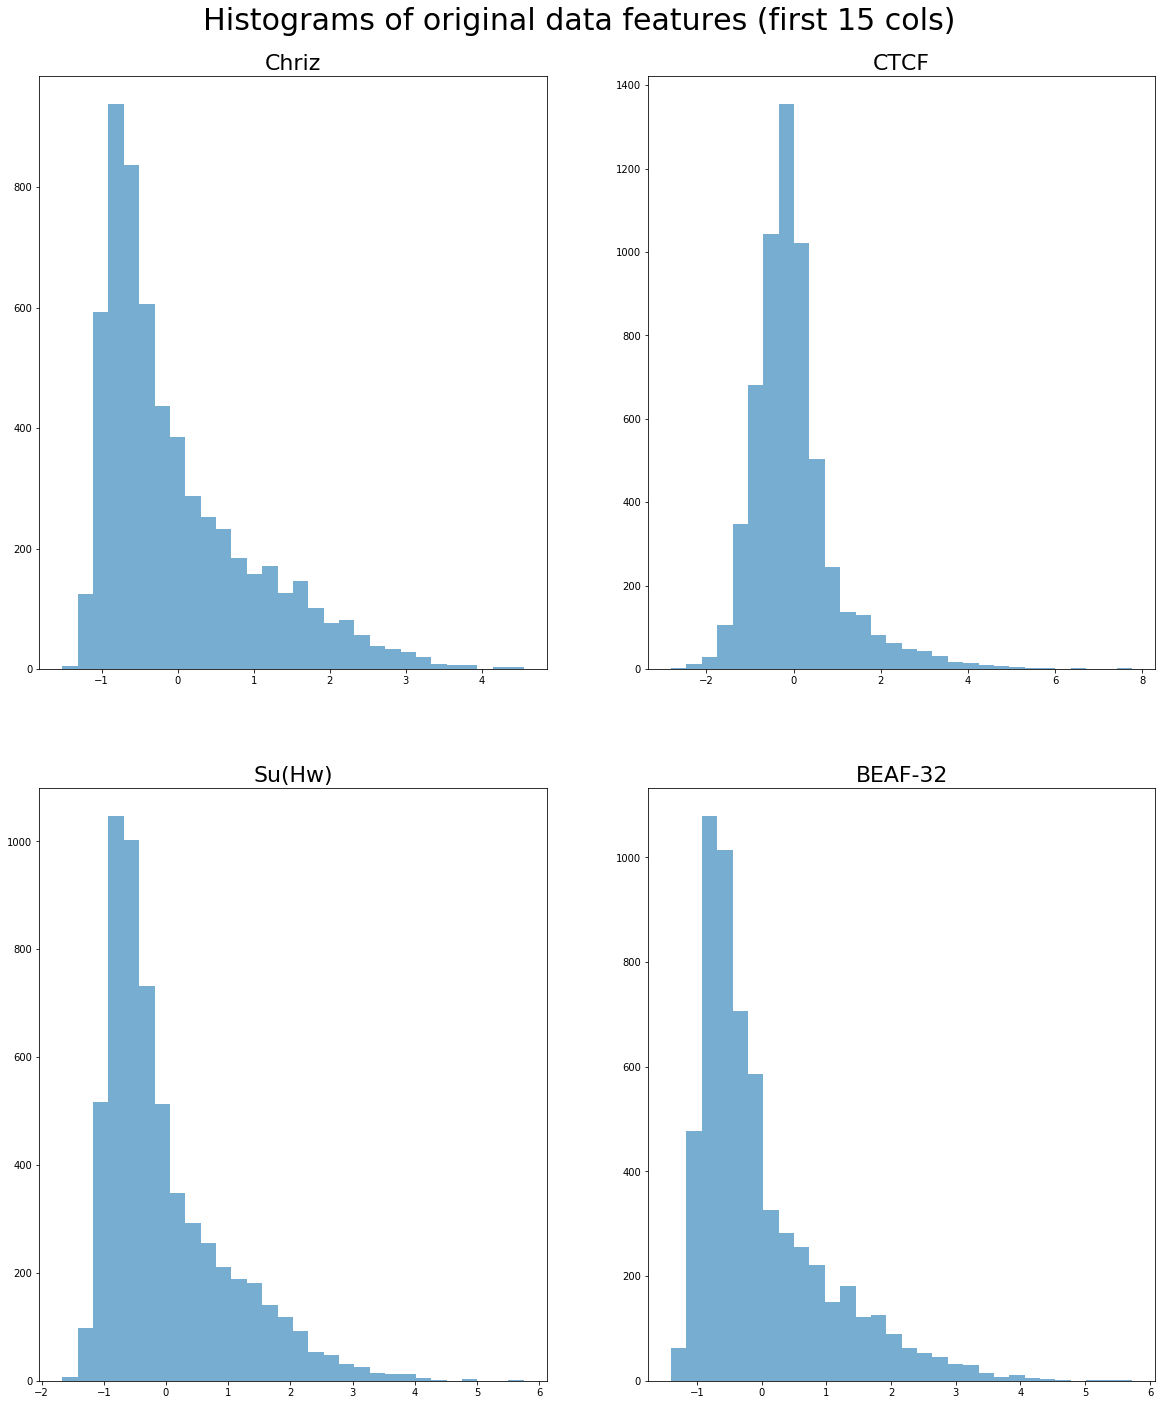

In [48]:
ncols = 2
nrows = 2
plotData(pd.DataFrame(data_scaled), ncols, nrows, bins=30, method = 'hist', is_sharex=False, plt_title='Histograms of original data features (first 15 cols)')

# target - gamma

# Explore target

In [49]:
target = gamma_S2.copy()
target.head()

chrN  start_coord  gamma
0  chr2L            0   0.00
1  chr2L        20000   3.42
2  chr2L        40000   3.42
3  chr2L        60000   1.33
4  chr2L        80000   1.31

In [50]:
# np.unique(target.gamma)

Text(0.5, 1.0, 'gamma values for all bins')

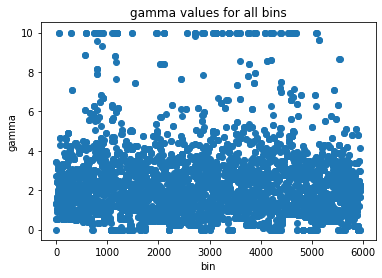

In [51]:
plt.scatter(np.arange(len(target.gamma)), target.gamma) # target
plt.xlabel('bin')
plt.ylabel('gamma')
plt.title('gamma values for all bins')

Text(0.5, 1.0, 'Distribution of gamma values for all bins')

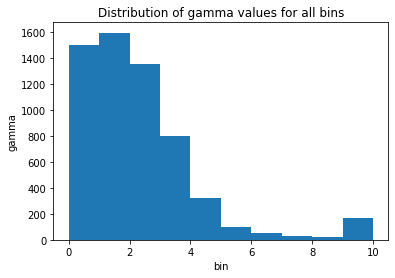

In [52]:
plt.hist(target.gamma)
plt.xlabel('bin')
plt.ylabel('gamma')
plt.title('Distribution of gamma values for all bins')

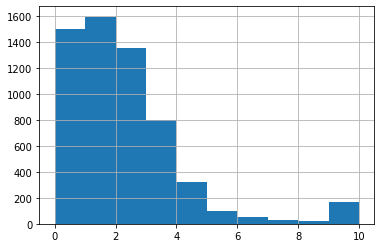

In [53]:
target.gamma.hist()

Log scale

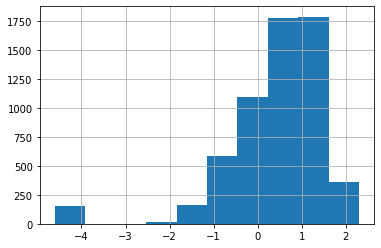

In [54]:
(np.log(0.01+target.gamma)).hist()

# Clean Data  from empty chromosomes

In [55]:
data_scaled_clean, target_clean, empty_chr_names, num_empty_bins = data_scaled, target, [], []
# cleanDataTarget(data_scaled, target)

data_scaled_clean.shape, target_clean.shape

((5950, 18), (5950, 3))

In [56]:
data_scaled_clean.head()

Chriz      CTCF    Su(Hw)   BEAF-32     CP190       GAF   H3K4me1  \
0  0.857221 -1.477078 -0.101168  0.274214  1.321501  0.864622  1.132997   
1  0.162917  0.184176 -1.264298 -0.288058  2.897976 -0.479922 -0.869254   
2 -0.659223  0.873772 -0.780429 -0.409246  0.750176  0.675975 -0.708401   
3  0.383762  0.962722  0.109845  1.167623  2.636323  2.438492  0.985090   
4  0.293380 -0.905598 -1.214589  0.234165 -0.717444  0.357894  1.398686   

    H3K4me2   H3K4me3   H3K9me2   H3K9me3   H3K27ac  H3K27me1  H3K27me3  \
0  0.697846  0.088574  0.111226  0.965512 -0.106126  0.198173  0.275947   
1 -0.787398  0.379795  1.317428  3.135955 -1.088348 -1.039614  1.544209   
2 -0.932556  0.306388 -0.043378 -0.183181 -0.736162 -1.346045  1.497277   
3  0.999978  0.963690 -0.495423 -0.281642  1.345645  0.957175 -1.130737   
4  0.343508 -0.480513 -0.426077 -0.128603  0.693334  0.839583 -1.311206   

   H3K36me1  H3K36me3   H4K16ac  RNA-polymerase-II  
0 -0.056612  1.552305 -0.553324           3.008187  
1 -0.769726 -0.528488 -0.978029          -0.421550  
2 -0.784169 -0.814419 -0.915727          -0.043953  
3 -0.443636  1.408247  0.632890           1.746236  
4  1.006091  1.625301  0.324599           1.217448

In [57]:
target_clean.head()

chrN  start_coord  gamma
0  chr2L            0   0.00
1  chr2L        20000   3.42
2  chr2L        40000   3.42
3  chr2L        60000   1.33
4  chr2L        80000   1.31

Target distribution

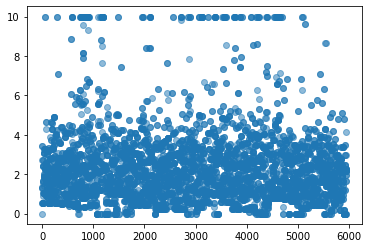

In [58]:
plt.scatter(np.arange(len(target_clean)),  target_clean.gamma, alpha=0.5)

(array([1502., 1598., 1359.,  800.,  325.,   95.,   56.,   28.,   22.,
         165.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

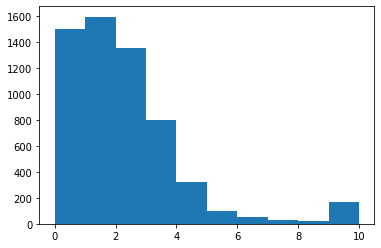

In [59]:
plt.hist(target_clean.gamma)

Log scale

(array([ 157.,    0.,    0.,    0.,   16.,  147.,  618., 1587., 2730.,
         695.]),
 array([-6.90775528, -5.98671124, -5.06566721, -4.14462317, -3.22357913,
        -2.3025351 , -1.38149106, -0.46044702,  0.46059701,  1.38164105,
         2.30268509]),
 <a list of 10 Patch objects>)

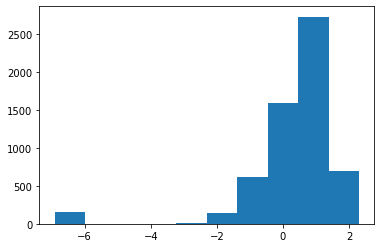

In [60]:
plt.hist(np.log(0.001 + target_clean.gamma))

In [61]:
target.shape, target.head()

((5950, 3),     chrN  start_coord  gamma
 0  chr2L            0   0.00
 1  chr2L        20000   3.42
 2  chr2L        40000   3.42
 3  chr2L        60000   1.33
 4  chr2L        80000   1.31)

# data_scaled_clean, target_clean - prossesed data

# Train Test Split

In [62]:
data = data_scaled_clean 
target = target_clean['gamma']

In [63]:
X, y = data_scaled_clean, target_clean['gamma']
X.shape, y.shape

((5950, 18), (5950,))

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X[:], y[:], test_size=0.3, random_state=16)

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((4165, 18), (1785, 18), (4165,), (1785,))

# Linear Regression

In [65]:
%time

# Create linear regression object
lin_reg = linear_model.LinearRegression() 

# Train the model using the training sets
lin_reg.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg.predict(X_test)

model = lin_reg

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


 TEST PREDICTION Error
weighted_mse_test: 1.133413613699472 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1278091407562294 


 CONSTANT pred Error:
weighted_mse_test_const:  1.639465531072487
test sizes =  1785 1785 1785


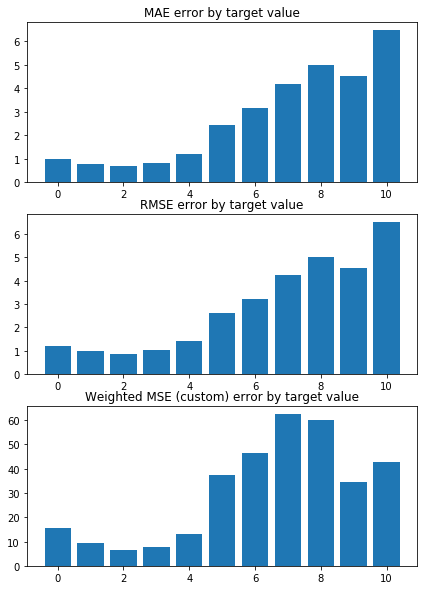

In [66]:
# Make predictions using the testing set
y_pred_train = lin_reg.predict(X_train)

weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const = cout_errors_lin(X_train,  
                                                                          X_test,
                                                                          y_train.values, 
                                                                          y_test.values, 
                                                                          model)

In [67]:
# The coefficients
print('Coefficients: \n', lin_reg.coef_[:20])

Coefficients: 
 [-3.71292484e-01  4.19336632e-02  9.13413195e-02  1.06952279e-03
 -2.50895152e-01 -4.66193591e-02 -2.32980438e-01  1.53562294e-01
 -7.35322009e-02  2.50809052e-04  5.56762793e-03  5.11425411e-02
 -2.82636495e-01 -3.12226553e-01 -2.88309776e-01 -2.94413184e-01
  5.89068551e-02 -1.00927186e-01]


In [68]:
coef = lin_reg.coef_

(array([1., 4., 2., 0., 0., 2., 1., 4., 3., 1.]),
 array([-0.37129248, -0.31880701, -0.26632153, -0.21383605, -0.16135057,
        -0.10886509, -0.05637962, -0.00389414,  0.04859134,  0.10107682,
         0.15356229]),
 <a list of 10 Patch objects>)

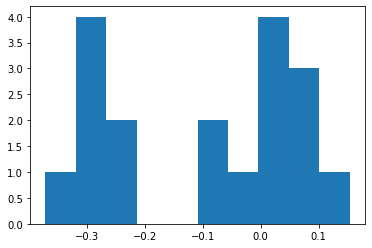

In [69]:
plt.hist(lin_reg.coef_)

Посмотрим на распределения остатков и на нормальное распределение.

(array([  4.,   1.,  10.,  11.,  10.,  18.,  19.,  28.,  40.,  52.,  58.,
         72.,  77., 115., 131., 134., 134., 172., 181., 210., 189., 208.,
        188., 224., 202., 186., 193., 179., 158., 131., 116., 118.,  91.,
         84.,  62.,  49.,  44.,  23.,  21.,  17.,  12.,   8.,   7.,   4.,
          2.,   2.,   3.,   0.,   1.,   1.]),
 array([-3.03846292, -2.90396135, -2.76945977, -2.6349582 , -2.50045663,
        -2.36595506, -2.23145348, -2.09695191, -1.96245034, -1.82794877,
        -1.6934472 , -1.55894562, -1.42444405, -1.28994248, -1.15544091,
        -1.02093933, -0.88643776, -0.75193619, -0.61743462, -0.48293305,
        -0.34843147, -0.2139299 , -0.07942833,  0.05507324,  0.18957481,
         0.32407639,  0.45857796,  0.59307953,  0.7275811 ,  0.86208268,
         0.99658425,  1.13108582,  1.26558739,  1.40008896,  1.53459054,
         1.66909211,  1.80359368,  1.93809525,  2.07259682,  2.2070984 ,
         2.34159997,  2.47610154,  2.61060311,  2.74510469,  2.87960626,
 

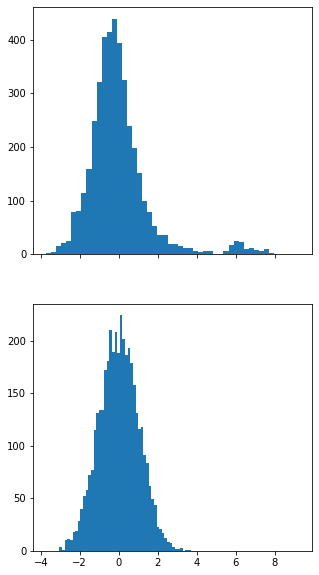

In [70]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
axes[0].hist((y_train - y_pred_train).values, bins=50)
axes[1].hist(np.random.randn(4000), bins=50)

Следовательно ошибка на train имеет нормальное распределение -> модель обучается описывать данные

Значения, на которых модель возвращает наибольшую ошибку:

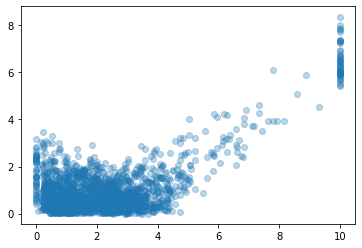

In [71]:
plt.scatter(y_test,  np.abs(y_test - y_pred) , alpha=0.3)

# Remove outlires
Посмотрим на результаты удаления объектов, для которых значение целевой переменной больше 9.

In [72]:
target_clean.head()

chrN  start_coord  gamma
0  chr2L            0   0.00
1  chr2L        20000   3.42
2  chr2L        40000   3.42
3  chr2L        60000   1.33
4  chr2L        80000   1.31

In [73]:
data_scaled_clean[target < 9].values

target[target < 9].values

array([0.  , 3.42, 3.42, ..., 2.29, 0.  , 0.  ])

KFold(n_splits=5, random_state=3, shuffle=True)
train_index= [   1    2    3 ... 5782 5783 5784]
 TEST PREDICTION Error
weighted_mse_test: 0.9689124818613231 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9048594955733784 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4093606332379138
test sizes =  1157 1157 1157


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


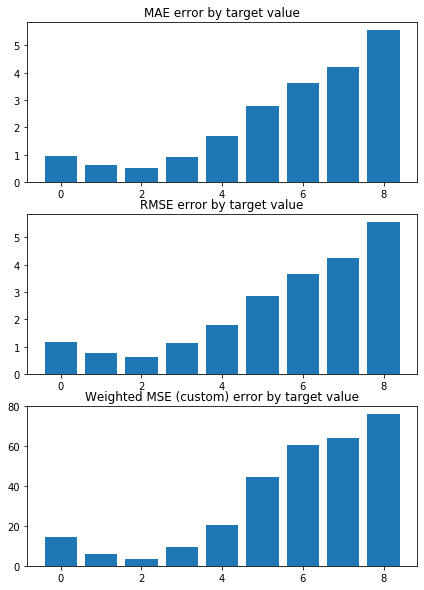

train_index= [   0    1    2 ... 5782 5783 5784]
 TEST PREDICTION Error
weighted_mse_test: 0.872111385249223 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9265135790568341 


 CONSTANT pred Error:
weighted_mse_test_const:  1.3302436375391358
test sizes =  1157 1157 1157


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


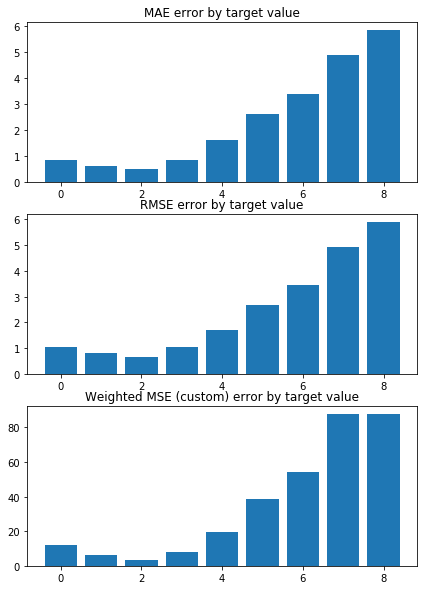

train_index= [   0    1    2 ... 5779 5782 5784]
 TEST PREDICTION Error
weighted_mse_test: 0.9344666013811629 


 TRAIN PREDICTION Error
weighted_mse_train: 0.916465507489906 


 CONSTANT pred Error:
weighted_mse_test_const:  1.3452438191350962
test sizes =  1157 1157 1157


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


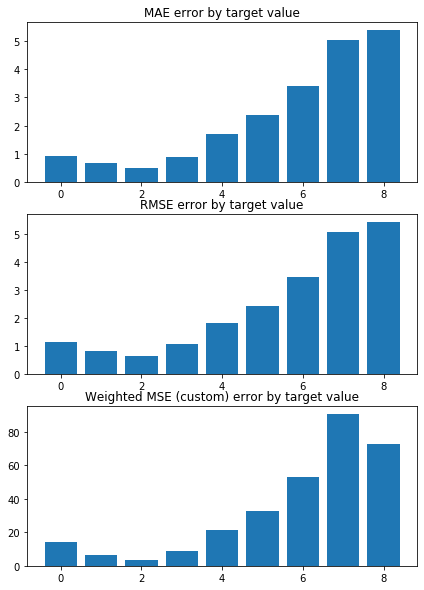

train_index= [   0    3    4 ... 5780 5781 5783]
 TEST PREDICTION Error
weighted_mse_test: 0.8958251314079931 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9229273463564641 


 CONSTANT pred Error:
weighted_mse_test_const:  1.405183043757934
test sizes =  1157 1157 1157


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


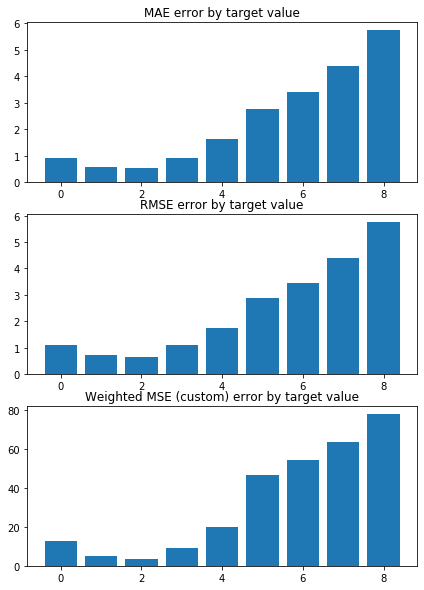

train_index= [   0    1    2 ... 5782 5783 5784]
 TEST PREDICTION Error
weighted_mse_test: 0.9449505262196685 


 TRAIN PREDICTION Error
weighted_mse_train: 0.9127200156958929 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4301776521714968
test sizes =  1157 1157 1157


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


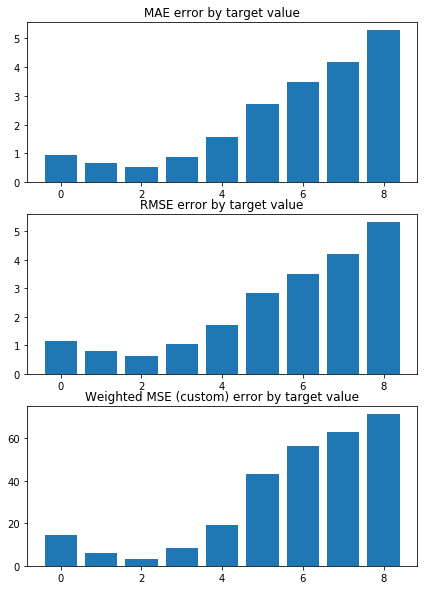

Weighted Mean squared error on Train: 0.92 
 MSE mean train: 1.382760122491548 

Mean squared error on Test: 0.92 
 MSE mean test:  1.3928739256470382 

Root of MSE on Test: 0.96 
 1.1802007988673107 

Variance score on Test: 0.03 
 r2_test: 0.326788334180475 

wMSE_train 0.92
wMSE_test 0.92
MSE_train 1.38
MSE_test 1.39
MAE_train 0.86
MAE_test 0.88
r2_test 0.33
      Chriz  H3K27me1   H3K4me2     CP190   H3K4me3   H3K4me1  H3K27me3  \
0 -0.315916 -0.251512  0.225293 -0.191172 -0.183982 -0.162929 -0.146835   
1 -0.364494 -0.192026  0.197003 -0.182665 -0.089585 -0.195239 -0.156993   
2 -0.283968 -0.233265  0.165848 -0.209809 -0.133755 -0.165128 -0.168667   
3 -0.328504 -0.159027  0.179767 -0.181290 -0.131306 -0.181485 -0.160647   
4 -0.303950 -0.156336  0.176568 -0.199068 -0.122285 -0.193482 -0.151423   

   H3K36me3  H3K36me1  RNA-polymerase-II    Su(Hw)   BEAF-32   H3K27ac  \
0 -0.138354 -0.118825          -0.102149  0.082626  0.059056 -0.058310   
1 -0.168974 -0.143299          -0.136

In [74]:
X, y = data_scaled_clean[target < 9].values, target[target < 9].values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.LinearRegression() 
model_name = 'LR+L1_no_outliers'


lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=5, random_state=3, shuffle=True)


In [75]:
results_pd 

model_name wMSE_test_mean wMSE_test_std wMSE_train_mean  \
0         test_model            160             1              16   
1  LR+L1_no_outliers       0.923253     0.0347824        0.916697   

  wMSE_train_std comments                  params  MSE_test_mean  \
0              3  no coms  test_params = testtest            NaN   
1     0.00763124        -  test_params = testtest       1.392874   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0           NaN             NaN            NaN   
1      0.042988         1.38276       0.010296   

                                             r2_test n_splits  \
0                                                NaN      NaN   
1  [0.3173100836941761, 0.33173764707849474, 0.30...        5   

                                               model  
0                                                NaN  
1  LinearRegression(copy_X=True, fit_intercept=Tr...

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K-fold cross Validation - RL

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1399807373292121 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1257163976254185 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6918784159536415
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


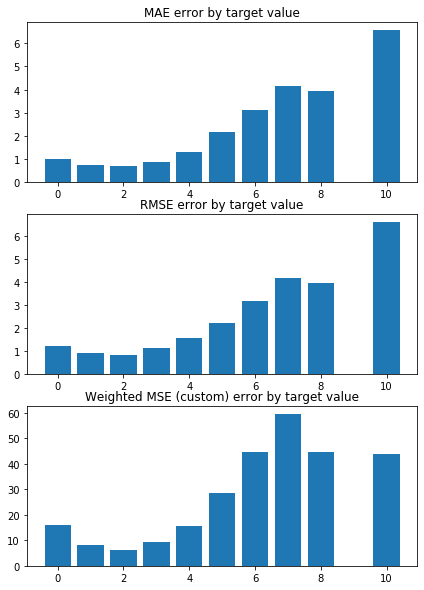

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1290968331118791 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1305077007950748 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


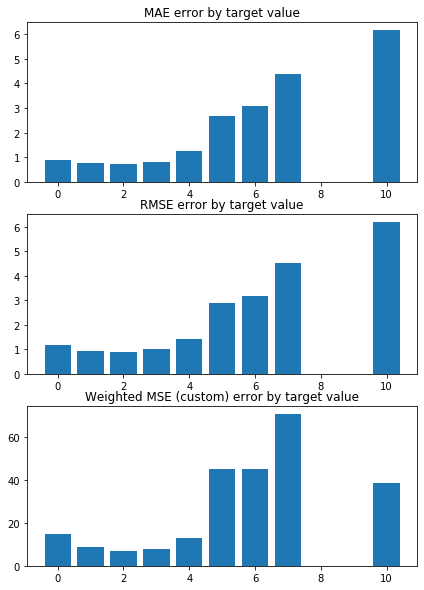

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1469742957368263 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1365426645646823 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


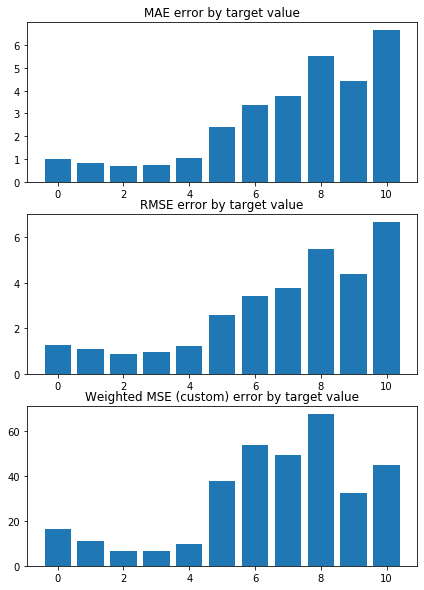

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0902129803399987 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1412522694643552 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


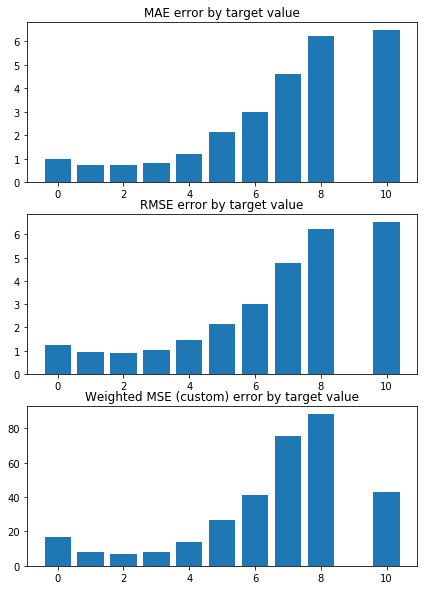

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1901367240971035 


 TRAIN PREDICTION Error
weighted_mse_train: 1.122924657341638 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


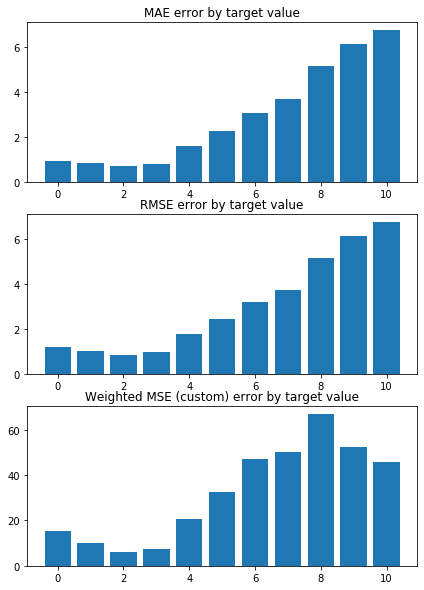

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2938024890243434 


 TRAIN PREDICTION Error
weighted_mse_train: 1.115065393119995 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


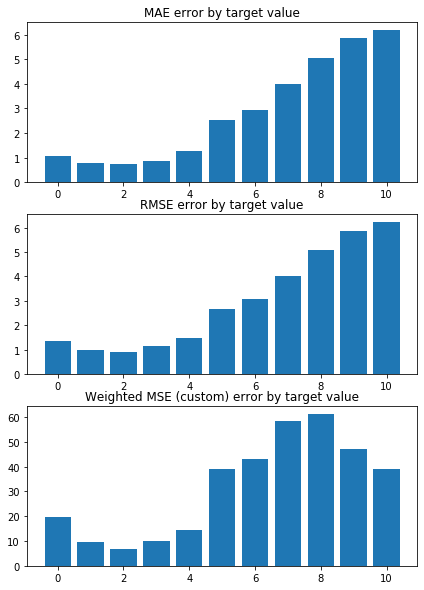

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0988531127868442 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1405528145667763 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


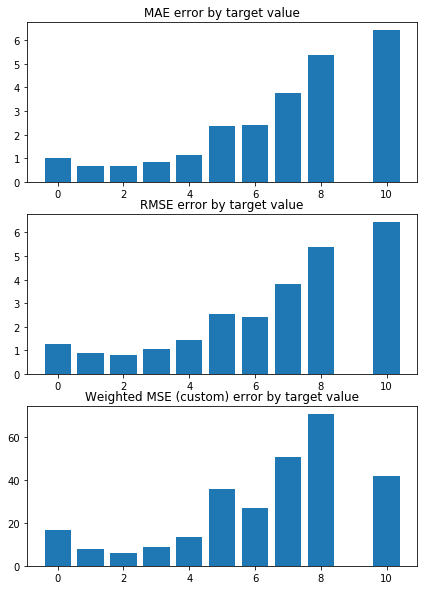

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.2068702910415512 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1324953726649976 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


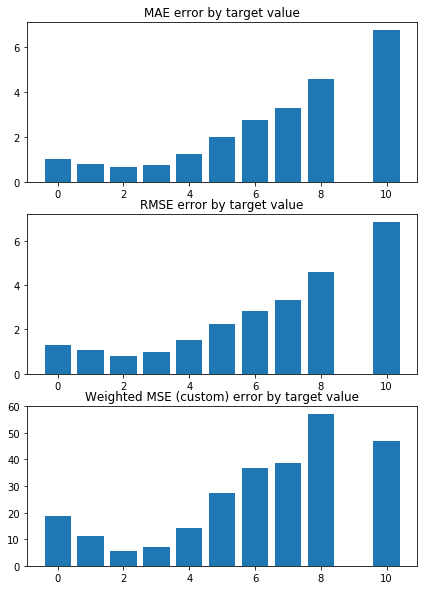

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.087134798183459 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1249546625028684 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


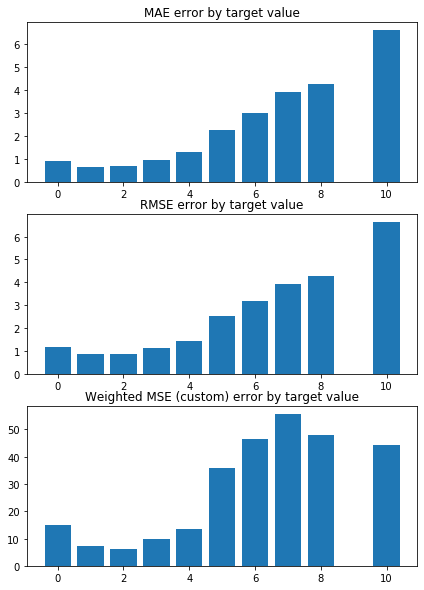

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0035966389449589 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1497996064729967 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


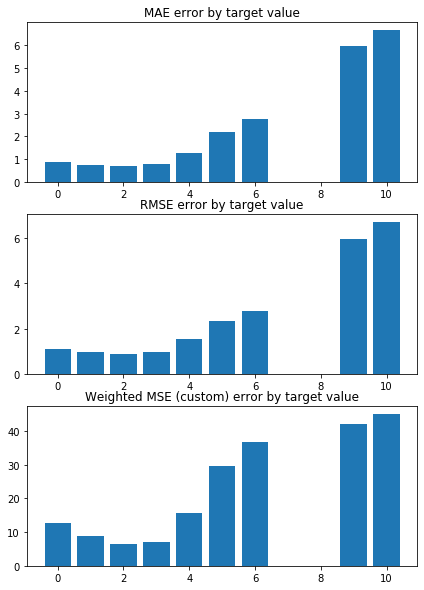

Weighted Mean squared error on Train: 1.13 
 MSE mean train: 2.6197014139933215 

Mean squared error on Test: 1.14 
 MSE mean test:  2.6340089733098777 

Root of MSE on Test: 1.07 
 1.6229630227795941 

Variance score on Test: 0.08 
 r2_test: 0.28824059929516277 

wMSE_train 1.13
wMSE_test 1.14
MSE_train 2.62
MSE_test 2.63
MAE_train 1.08
MAE_test 1.02
r2_test 0.29
      Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.319028 -0.294063 -0.277849 -0.271401 -0.270839 -0.258442 -0.247798   
1 -0.334489 -0.299304 -0.256882 -0.265283 -0.280700 -0.282460 -0.272424   
2 -0.340081 -0.337740 -0.268718 -0.241906 -0.308471 -0.334819 -0.241820   
3 -0.345520 -0.316966 -0.264153 -0.245392 -0.304656 -0.293735 -0.235759   
4 -0.308994 -0.331351 -0.291953 -0.225332 -0.314548 -0.336994 -0.240104   
5 -0.284300 -0.305691 -0.282470 -0.251748 -0.292721 -0.293370 -0.234909   
6 -0.306876 -0.299488 -0.267949 -0.253933 -0.262839 -0.279531 -0.295387   
7 -0.298799 -0.314179 -0.286027 -

model_name wMSE_test_mean wMSE_test_std wMSE_train_mean  \
0         test_model            160             1              16   
1  LR+L1_no_outliers       0.923253     0.0347824        0.916697   
2                 LR        1.13867     0.0750751         1.13198   

  wMSE_train_std comments                  params  MSE_test_mean  \
0              3  no coms  test_params = testtest            NaN   
1     0.00763124        -  test_params = testtest       1.392874   
2     0.00978238        -  test_params = testtest       2.634009   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0           NaN             NaN            NaN   
1      0.042988        1.382760       0.010296   
2      0.159500        2.619701       0.017773   

                                             r2_test n_splits  \
0                                                NaN      NaN   
1  [0.3173100836941761, 0.33173764707849474, 0.30...        5   
2  [0.30233272815667, 0.3418028647562872, 0.25460...       10   

                                               model  
0                                                NaN  
1  LinearRegression(copy_X=True, fit_intercept=Tr...  
2  LinearRegression(copy_X=True, fit_intercept=Tr...

In [76]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.LinearRegression() 

model_name = 'LR'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)
results_pd

In [77]:
results_pd

model_name wMSE_test_mean wMSE_test_std wMSE_train_mean  \
0         test_model            160             1              16   
1  LR+L1_no_outliers       0.923253     0.0347824        0.916697   
2                 LR        1.13867     0.0750751         1.13198   

  wMSE_train_std comments                  params  MSE_test_mean  \
0              3  no coms  test_params = testtest            NaN   
1     0.00763124        -  test_params = testtest       1.392874   
2     0.00978238        -  test_params = testtest       2.634009   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0           NaN             NaN            NaN   
1      0.042988        1.382760       0.010296   
2      0.159500        2.619701       0.017773   

                                             r2_test n_splits  \
0                                                NaN      NaN   
1  [0.3173100836941761, 0.33173764707849474, 0.30...        5   
2  [0.30233272815667, 0.3418028647562872, 0.25460...       10   

                                               model  
0                                                NaN  
1  LinearRegression(copy_X=True, fit_intercept=Tr...  
2  LinearRegression(copy_X=True, fit_intercept=Tr...

In [78]:
coefs_argsort, coefs

(array([[ 0, 13,  4, 12, 14, 15,  6,  2,  7, 17,  8,  1, 11, 16,  5, 10,
          9,  3],
        [ 0, 13, 15, 14,  6, 12,  4,  7,  8, 17,  2, 11,  1, 16,  5,  3,
         10,  9],
        [ 0, 13, 15, 14,  4, 12,  6, 17,  7,  2, 16,  8, 11, 10,  1,  5,
          9,  3],
        [ 0, 13, 14, 15,  4, 12,  6, 17,  2,  7,  8, 16, 11,  1, 10,  5,
          9,  3],
        [15, 13, 14,  0,  4,  6, 12,  7,  2, 17,  8,  1, 16, 10,  5, 11,
          9,  3],
        [13, 15, 14,  0,  4, 12,  6, 17,  2,  8,  7, 11,  1, 16,  9, 10,
          5,  3],
        [ 0, 13,  6, 15,  4, 14, 12, 17, 11,  2,  8, 16,  7,  1,  5,  9,
         10,  3],
        [13,  0, 15,  4, 14,  6, 12,  8,  7, 17,  2,  1, 11, 16, 10,  3,
          5,  9],
        [ 0, 13,  4, 14,  6, 15, 12, 17,  7,  2,  8, 11,  1, 16, 10,  9,
          5,  3],
        [ 6, 13,  0, 15, 14,  4, 12,  7,  8, 17,  2, 11, 16,  1, 10,  5,
          9,  3]]), array([[-3.19027753e-01,  6.27806074e-02,  1.18813914e-01,
          1.31555983e-02, -2.

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(array([  1.,   1.,   2.,   2.,   4.,   4.,   7.,  10.,  15.,  18.,  30.,
         27.,  47.,  53.,  84.,  72.,  95., 144., 147., 159., 207., 180.,
        208., 215., 209., 225., 228., 219., 196., 206., 163., 143., 117.,
        132., 102.,  70.,  55.,  47.,  45.,  32.,  31.,  11.,  13.,   5.,
          3.,   5.,   3.,   5.,   1.,   2.]),
 array([-3.55421785, -3.41287042, -3.271523  , -3.13017558, -2.98882816,
        -2.84748073, -2.70613331, -2.56478589, -2.42343847, -2.28209104,
        -2.14074362, -1.9993962 , -1.85804878, -1.71670135, -1.57535393,
        -1.43400651, -1.29265909, -1.15131167, -1.00996424, -0.86861682,
        -0.7272694 , -0.58592198, -0.44457455, -0.30322713, -0.16187971,
        -0.02053229,  0.12081514,  0.26216256,  0.40350998,  0.5448574 ,
         0.68620483,  0.82755225,  0.96889967,  1.11024709,  1.25159452,
         1.39294194,  1.53428936,  1.67563678,  1.8169842 ,  1.95833163,
         2.09967905,  2.24102647,  2.38237389,  2.52372132,  2.66506874,
 

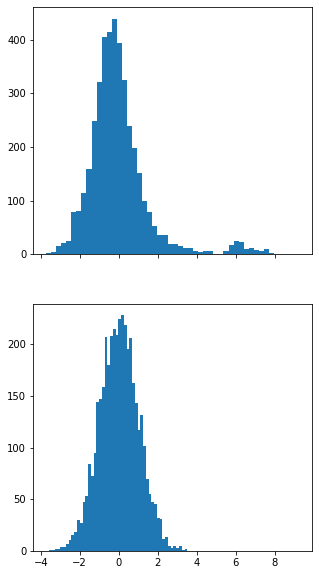

In [79]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
axes[0].hist((y_train - y_pred_train), bins=50)
axes[1].hist(np.random.randn(4000), bins=50)

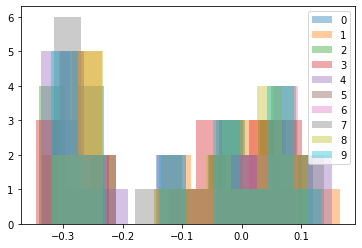

In [80]:
for i, coef_i in enumerate(coefs):
    plt.hist(coef_i, label=str(i), alpha=0.4, bins=10)
plt.legend()

(array([3., 4., 0., 0., 2., 0., 2., 2., 3., 2.]),
 array([-0.31902775, -0.27524359, -0.23145942, -0.18767525, -0.14389109,
        -0.10010692, -0.05632275, -0.01253859,  0.03124558,  0.07502975,
         0.11881391]),
 <a list of 10 Patch objects>)

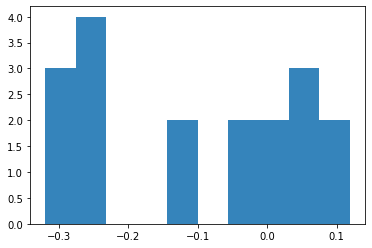

In [81]:
plt.hist(coefs[0], label=str(i), alpha=0.9, bins=10)

### Отсортированные номера выделенных признаков обычной линейной модели

In [82]:
su_drsc.columns

Index(['chrN', 'start_coord', 'Chriz', 'CTCF', 'Su(Hw)', 'BEAF-32', 'CP190',
       'GAF', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9me2', 'H3K9me3', 'H3K27ac',
       'H3K27me1', 'H3K27me3', 'H3K36me1', 'H3K36me3', 'H4K16ac',
       'RNA-polymerase-II'],
      dtype='object')

In [83]:
su_drsc.columns[2:][coefs_argsort[0]]

Index(['Chriz', 'H3K27me3', 'CP190', 'H3K27me1', 'H3K36me1', 'H3K36me3',
       'H3K4me1', 'Su(Hw)', 'H3K4me2', 'RNA-polymerase-II', 'H3K4me3', 'CTCF',
       'H3K27ac', 'H4K16ac', 'GAF', 'H3K9me3', 'H3K9me2', 'BEAF-32'],
      dtype='object')

In [84]:
coefs_argsort

array([[ 0, 13,  4, 12, 14, 15,  6,  2,  7, 17,  8,  1, 11, 16,  5, 10,
         9,  3],
       [ 0, 13, 15, 14,  6, 12,  4,  7,  8, 17,  2, 11,  1, 16,  5,  3,
        10,  9],
       [ 0, 13, 15, 14,  4, 12,  6, 17,  7,  2, 16,  8, 11, 10,  1,  5,
         9,  3],
       [ 0, 13, 14, 15,  4, 12,  6, 17,  2,  7,  8, 16, 11,  1, 10,  5,
         9,  3],
       [15, 13, 14,  0,  4,  6, 12,  7,  2, 17,  8,  1, 16, 10,  5, 11,
         9,  3],
       [13, 15, 14,  0,  4, 12,  6, 17,  2,  8,  7, 11,  1, 16,  9, 10,
         5,  3],
       [ 0, 13,  6, 15,  4, 14, 12, 17, 11,  2,  8, 16,  7,  1,  5,  9,
        10,  3],
       [13,  0, 15,  4, 14,  6, 12,  8,  7, 17,  2,  1, 11, 16, 10,  3,
         5,  9],
       [ 0, 13,  4, 14,  6, 15, 12, 17,  7,  2,  8, 11,  1, 16, 10,  9,
         5,  3],
       [ 6, 13,  0, 15, 14,  4, 12,  7,  8, 17,  2, 11, 16,  1, 10,  5,
         9,  3]])

In [85]:
pd.DataFrame(coefs_argsort, columns=su_drsc.columns[2:][coefs_argsort[0]])

Chriz  H3K27me3  CP190  H3K27me1  H3K36me1  H3K36me3  H3K4me1  Su(Hw)  \
0      0        13      4        12        14        15        6       2   
1      0        13     15        14         6        12        4       7   
2      0        13     15        14         4        12        6      17   
3      0        13     14        15         4        12        6      17   
4     15        13     14         0         4         6       12       7   
5     13        15     14         0         4        12        6      17   
6      0        13      6        15         4        14       12      17   
7     13         0     15         4        14         6       12       8   
8      0        13      4        14         6        15       12      17   
9      6        13      0        15        14         4       12       7   

   H3K4me2  RNA-polymerase-II  H3K4me3  CTCF  H3K27ac  H4K16ac  GAF  H3K9me3  \
0        7                 17        8     1       11       16    5       10   
1        8                 17        2    11        1       16    5        3   
2        7                  2       16     8       11       10    1        5   
3        2                  7        8    16       11        1   10        5   
4        2                 17        8     1       16       10    5       11   
5        2                  8        7    11        1       16    9       10   
6       11                  2        8    16        7        1    5        9   
7        7                 17        2     1       11       16   10        3   
8        7                  2        8    11        1       16   10        9   
9        8                 17        2    11       16        1   10        5   

   H3K9me2  BEAF-32  
0        9        3  
1       10        9  
2        9        3  
3        9        3  
4        9        3  
5        5        3  
6       10        3  
7        5        9  
8        5        3  
9        9        3

# !! одинаковая приоритизация 

In [86]:
def getConfIdxFrequencies(coefs_argsort, row_lim, min_lim = 5, max_lim = 5):
    ''' 
    Get Frequencies of feature indexes in the sorted array of indexes bu the coefficient of the feature in different itterstions.
    The smallest and the biggest elements are valueable - as they give the biggest impact.
    min_lim, max_lim - limitations of the number of smallest and biggest coefficients to consider for the frequency.
    '''
    merged_coefs = np.concatenate(np.hstack([coefs_argsort[:row_lim,:min_lim], coefs_argsort[:row_lim,-max_lim:]]))

    merged_coefs = list(merged_coefs)

    featur_freq_dict =  dict((i, merged_coefs.count(i)) for i in merged_coefs)
    for key, value in  sorted(featur_freq_dict.items(), key=lambda item: (-item[1], item[0])):
        print("{}: {}".format(key, value))
        
    return featur_freq_dict

In [87]:
featur_freq_dict = getConfIdxFrequencies(coefs_argsort, row_lim=len(coefs_argsort), min_lim = 3, max_lim = 3)

3: 10
13: 10
9: 9
0: 8
5: 6
15: 5
10: 4
14: 3
4: 2
6: 2
11: 1


## Explore fold with big error

train_index= [   0    1    2 ... 5947 5948 5949]
train_index= [   0    1    2 ... 5947 5948 5949]
train_index= [   0    2    3 ... 5947 5948 5949]
train_index= [   0    1    2 ... 5947 5948 5949]
train_index= [   0    1    2 ... 5946 5948 5949]
train_index= [   1    4    5 ... 5945 5947 5949]
train_index= [   0    1    2 ... 5947 5948 5949]
train_index= [   0    1    2 ... 5946 5947 5948]
train_index= [   0    1    2 ... 5947 5948 5949]
train_index= [   0    1    2 ... 5947 5948 5949]


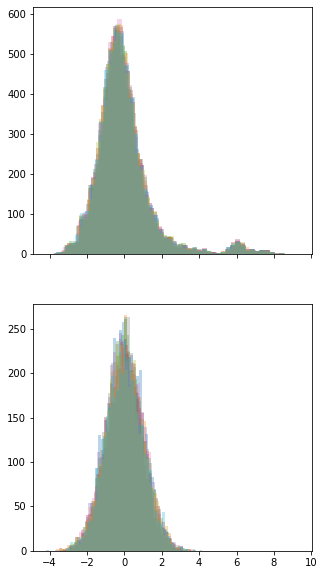

In [88]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)

for train_index, test_index in kf.split(X):

    print('train_index=', train_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

     # Train the model using the training sets
    model.fit(X_train, y_train)

    # Make predictions using the train set
    y_pred_train = model.predict(X_train)

    # Make predictions using the testing set
    y_pred = model.predict(X_test)

    axes[0].hist(y_train - y_pred_train, bins=50, alpha=0.3)
    axes[1].hist(np.random.randn(4000), bins=50, alpha=0.3)

# ================================================================

# Linear Regression with L1 regularization -  LASSO

$$ (1 / (2  n\_{samples}))  ||y - Xw||^2_2 + \alpha * ||w||_1 $$


In [89]:
X, y = data_scaled_clean, target_clean.gamma
X_train, X_test, y_train, y_test = train_test_split(X[:], y[:], test_size=0.3, random_state=10)

In [90]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# Create linear regression object
lin_reg_l1 = linear_model.Lasso()

# Train the model using the training sets
lin_reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg_l1.predict(X_test)

Коэффициенты

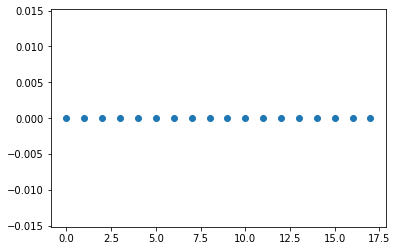

In [91]:
# plt.plot(lin_reg_l1.coef_)
plt.scatter( np.arange(len(lin_reg_l1.coef_)) , lin_reg_l1.coef_)


plt.show()

In [92]:
su_drsc.columns[2:][lin_reg_l1.coef_ < 0]

Index([], dtype='object')

In [93]:
lin_reg_l1.coef_

array([-0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0., -0., -0., -0., -0.])

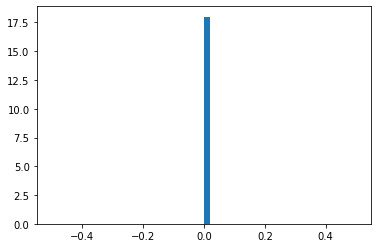

In [94]:
plt.hist(lin_reg_l1.coef_, bins=50)
plt.show()

In [95]:
# f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
# axes[0].hist((y_train - y_pred_train), bins=50)
# axes[1].hist(np.random.randn(4000), bins=50)

### Cross validation
without outliers

In [96]:
# X, y = data_scaled_clean[target < 9].values, target[target < 9].values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# # Create linear regression with L2 regularization object
# model_l1 = linear_model.Lasso(0.2)

# model_name = 'LR+L1_t<.9'

# lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
#                 weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
#                 rmse_test, rmse_train, rmse_test_const, \
#                 mae_test,    mae_train,  mae_test_const, \
#                 results_pd = train_test_KFold(X, y, 
#                                               model, model_name, results_pd,
#                                               n_splits=5, random_state=3, shuffle=True)
# results_pd

In [97]:
# np.mean(weighted_mse_test_all)

In [98]:
# for coef_i in coefs_l1:
#     plt.hist(coef_i, alpha=0.5)
# plt.hist(coefs_l1[0], alpha=0.5)

In [99]:
# np.sort(coefs_l1)

In [100]:
# lin_reg_l1.predict(X_test)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K-fold cross Validation - RL + L 1 

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6918784159536415 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6029384354397758 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6918784159536415
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


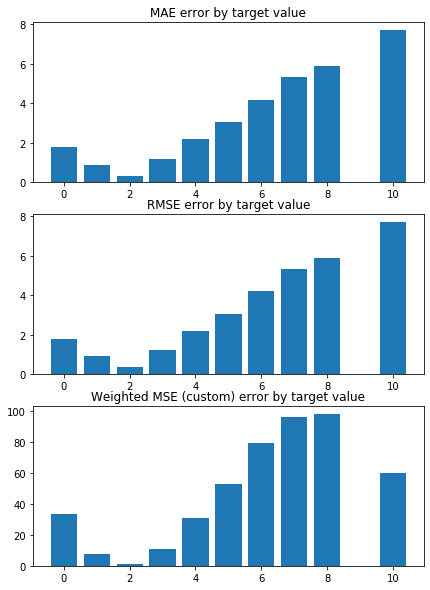

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.7231686180118282 


 TRAIN PREDICTION Error
weighted_mse_train: 1.603578125120089 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


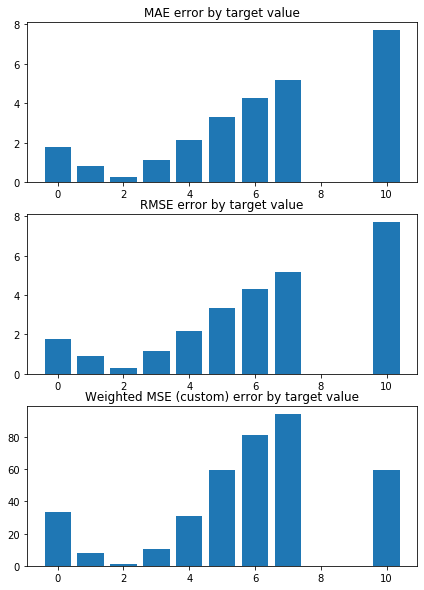

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5102232818954902 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6267009453663652 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


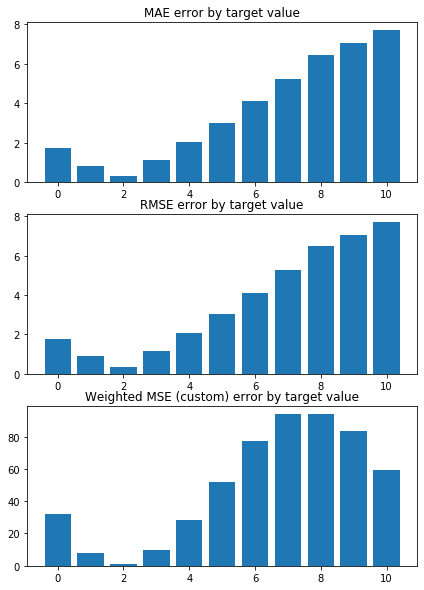

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4472258533824836 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6327687127534842 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


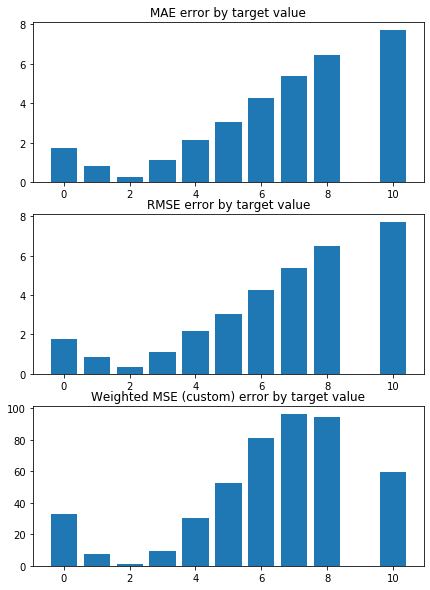

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6722112246990009 


 TRAIN PREDICTION Error
weighted_mse_train: 1.600895815024395 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


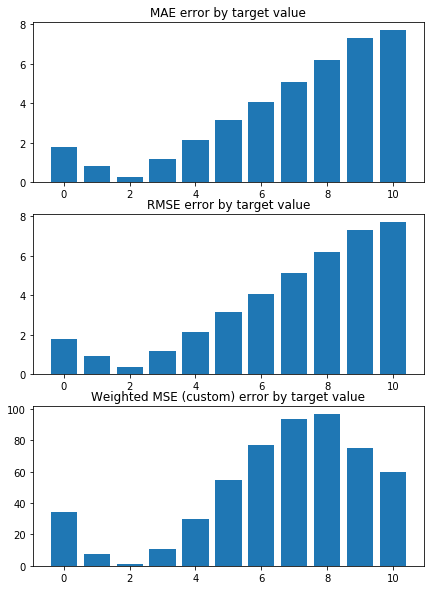

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.699109321425948 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6042463671176324 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


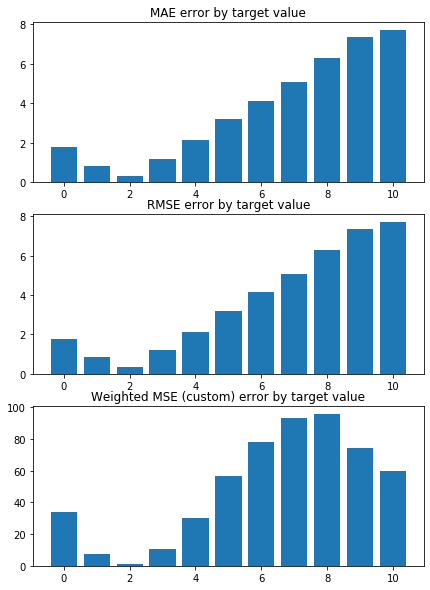

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6115493681587238 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6229792610483615 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


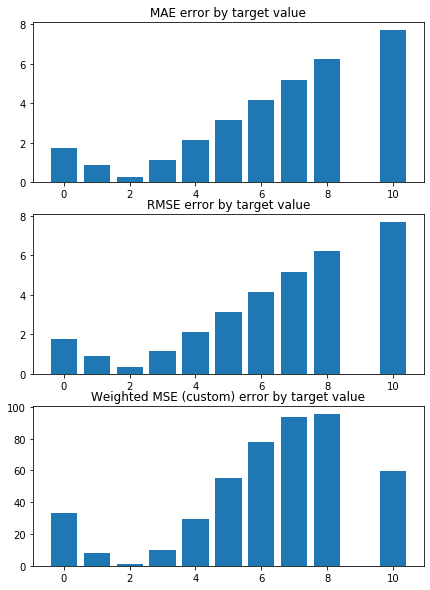

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.7038577806859556 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6145880862212005 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


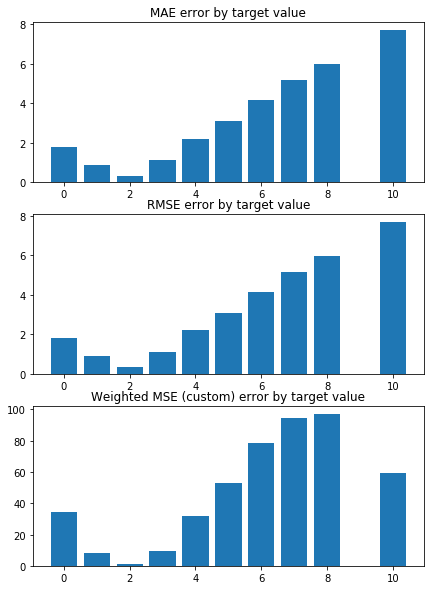

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.579451336632733 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6105903959818606 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


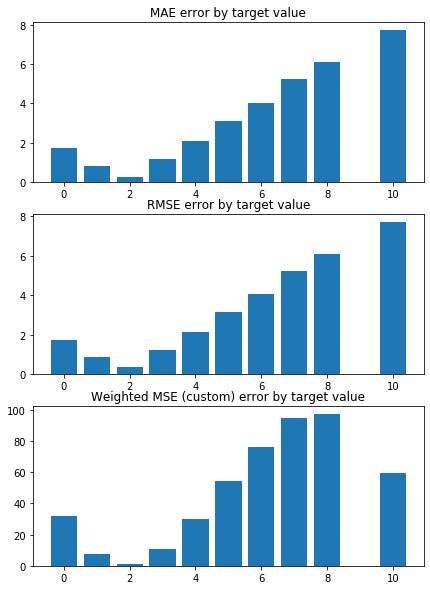

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5164826084211207 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6296968812107187 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


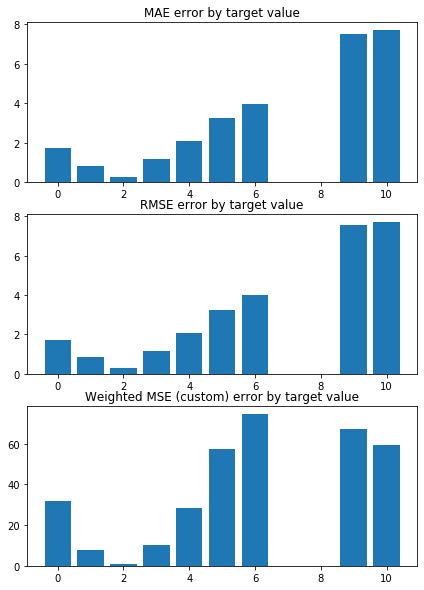

Weighted Mean squared error on Train: 1.61 
 MSE mean train: 3.7072627679387224 

Mean squared error on Test: 1.62 
 MSE mean test:  3.7083534412806514 

Root of MSE on Test: 1.27 
 1.9257085556440392 

Variance score on Test: 0.09 
 r2_test: -0.0014964637020806082 

wMSE_train 1.61
wMSE_test 1.62
MSE_train 3.71
MSE_test 3.71
MAE_train 1.36
MAE_test 1.31
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0  

model_name wMSE_test_mean wMSE_test_std wMSE_train_mean  \
0         test_model            160             1              16   
1  LR+L1_no_outliers       0.923253     0.0347824        0.916697   
2                 LR        1.13867     0.0750751         1.13198   
3              LR+L1        1.61552      0.092714          1.6149   

  wMSE_train_std comments                  params  MSE_test_mean  \
0              3  no coms  test_params = testtest            NaN   
1     0.00763124        -  test_params = testtest       1.392874   
2     0.00978238        -  test_params = testtest       2.634009   
3      0.0115859        -  test_params = testtest       3.708353   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0           NaN             NaN            NaN   
1      0.042988        1.382760       0.010296   
2      0.159500        2.619701       0.017773   
3      0.221185        3.707263       0.024586   

                                             r2_test n_splits  \
0                                                NaN      NaN   
1  [0.3173100836941761, 0.33173764707849474, 0.30...        5   
2  [0.30233272815667, 0.3418028647562872, 0.25460...       10   
3  [-0.0005277141720481104, -2.210887072906509e-0...       10   

                                               model  
0                                                NaN  
1  LinearRegression(copy_X=True, fit_intercept=Tr...  
2  LinearRegression(copy_X=True, fit_intercept=Tr...  
3  Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...

In [101]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.Lasso()

model_name = 'LR+L1'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)
results_pd

# Fined parametrs for lasso L1

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.139980737329212 


 TRAIN PREDICTION Error


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6964.6554792621055, tolerance: 1.9670830459197017
  positive)


weighted_mse_train: 1.1257163976254179 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6918784159536415
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


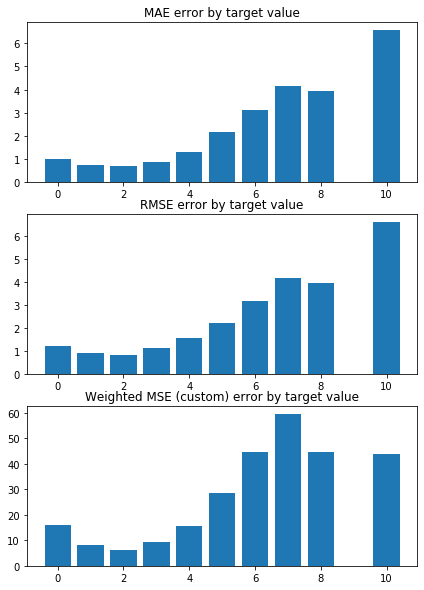

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.129096833111879 


 TRAIN PREDICTION Error
weighted_mse_train: 1.130507700795075 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7049.752537593615, tolerance: 1.978396552873951
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountere

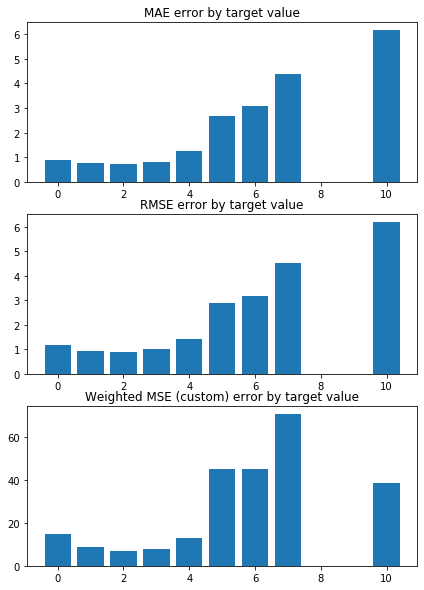

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1469742957368252 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1365426645646817 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6975.026668600487, tolerance: 1.984944464436975
  positive)


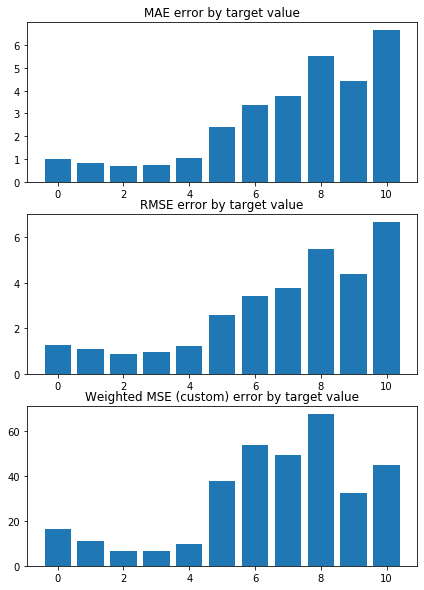

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.090212980339998 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1412522694643548 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7031.9977660037475, tolerance: 2.000600970849673
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encounter

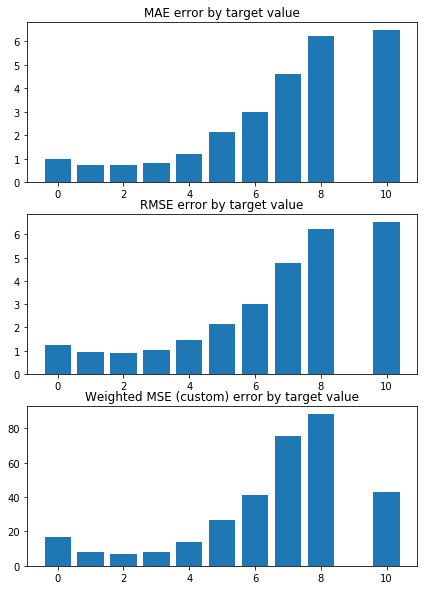

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1901367240971035 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1229246573416378 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6983.246928694507, tolerance: 1.9817038385546206
  positive)


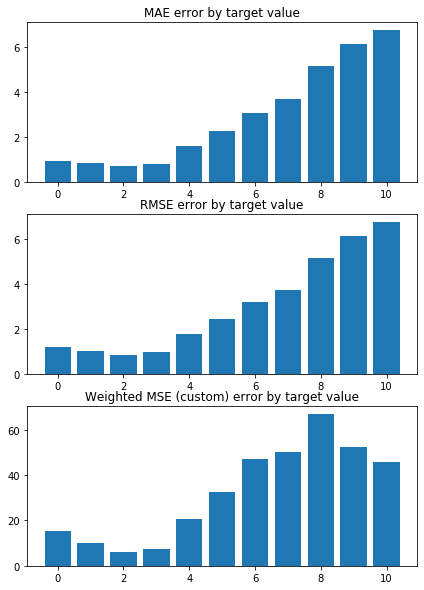

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2938024890243425 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1150653931199945 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6975.542554521183, tolerance: 1.9736104950961726
  positive)


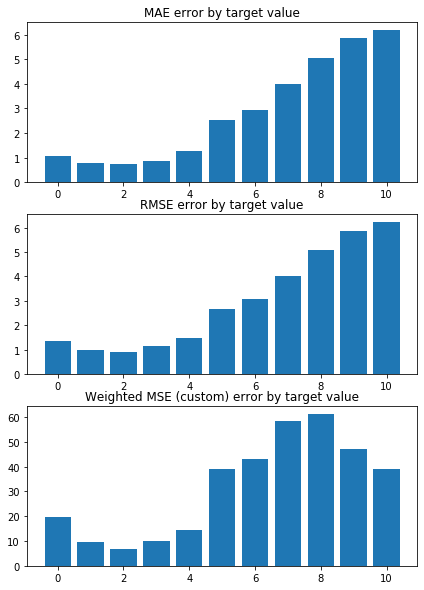

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.098853112786844 


 TRAIN PREDICTION Error
weighted_mse_train: 1.140552814566776 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7106.363251765085, tolerance: 2.004541321762838
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountere

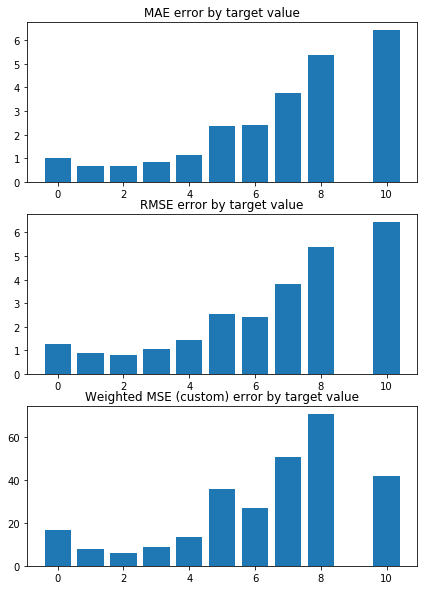

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.206870291041551 


 TRAIN PREDICTION Error


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7041.1444746062325, tolerance: 1.99764737471522
  positive)


weighted_mse_train: 1.1324953726649971 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


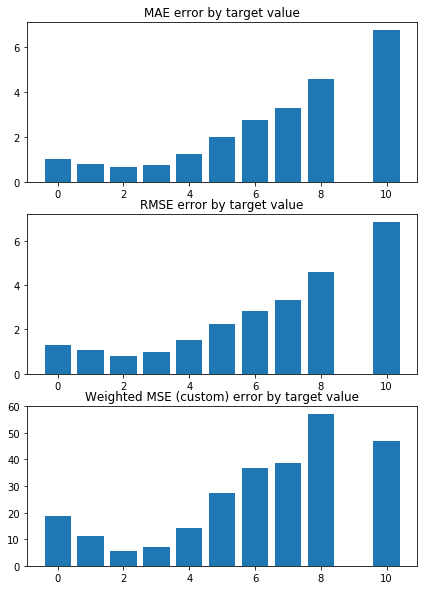

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0871347981834585 


 TRAIN PREDICTION Error
weighted_mse_train: 1.124954662502868 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6955.859443127744, tolerance: 1.96735906019421
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered

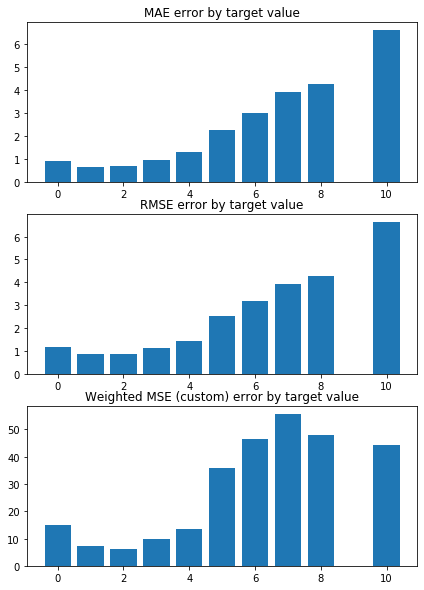

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0035966389449584 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1497996064729963 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7058.916255496497, tolerance: 1.9965049979084977
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encounter

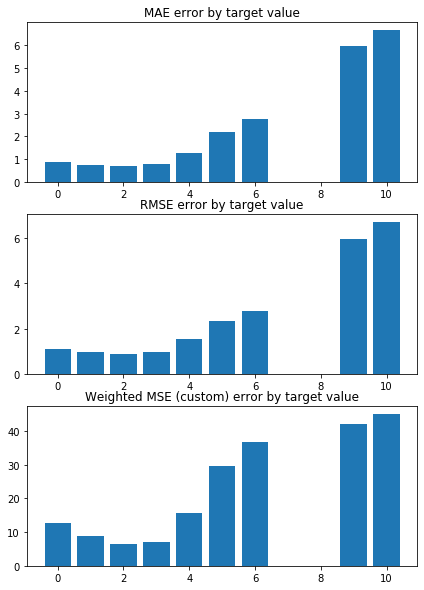

Weighted Mean squared error on Train: 1.13 
 MSE mean train: 2.6197014139933215 

Mean squared error on Test: 1.14 
 MSE mean test:  2.6340089733098773 

Root of MSE on Test: 1.07 
 1.6229630227795941 

Variance score on Test: 0.08 
 r2_test: 0.28824059929516277 

wMSE_train 1.13
wMSE_test 1.14
MSE_train 2.62
MSE_test 2.63
MAE_train 1.08
MAE_test 1.02
r2_test 0.29
      Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.319028 -0.294063 -0.277849 -0.271401 -0.270839 -0.258442 -0.247798   
1 -0.334489 -0.299304 -0.256882 -0.265283 -0.280700 -0.282460 -0.272424   
2 -0.340081 -0.337740 -0.268718 -0.241906 -0.308471 -0.334819 -0.241820   
3 -0.345520 -0.316966 -0.264153 -0.245392 -0.304656 -0.293735 -0.235759   
4 -0.308994 -0.331351 -0.291953 -0.225332 -0.314548 -0.336994 -0.240104   
5 -0.284300 -0.305691 -0.282470 -0.251748 -0.292721 -0.293370 -0.234909   
6 -0.306876 -0.299488 -0.267949 -0.253933 -0.262839 -0.279531 -0.295387   
7 -0.298799 -0.314179 -0.286027 -

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


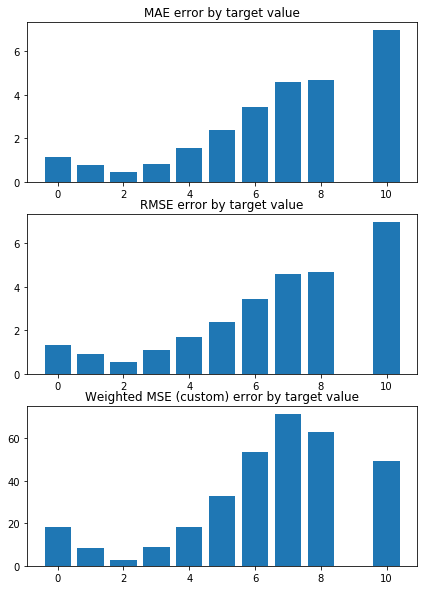

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.138466846838625 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1190063400406027 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


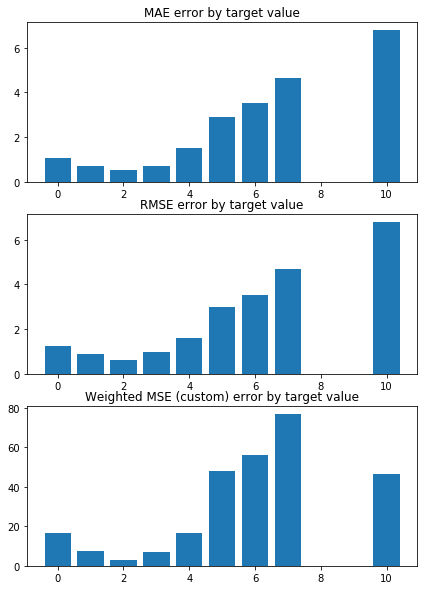

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0576132990225136 


 TRAIN PREDICTION Error
weighted_mse_train: 1.125935116334583 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


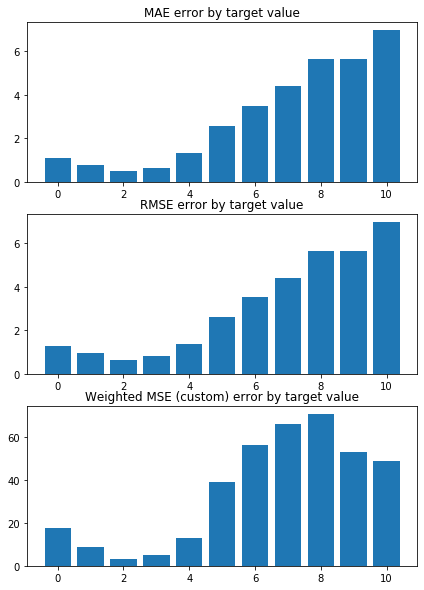

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0530511937953846 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1295747094390396 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


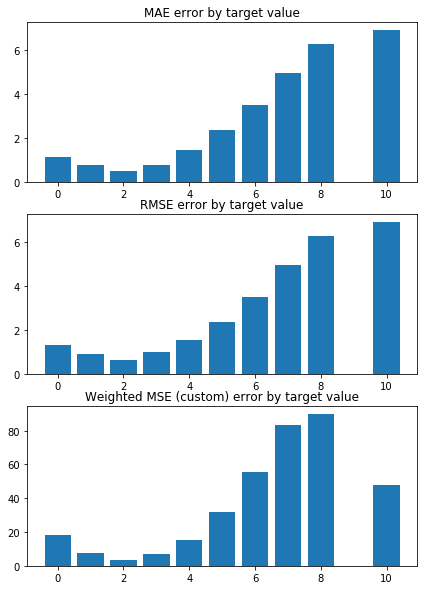

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.15461240814487 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1119658054201655 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


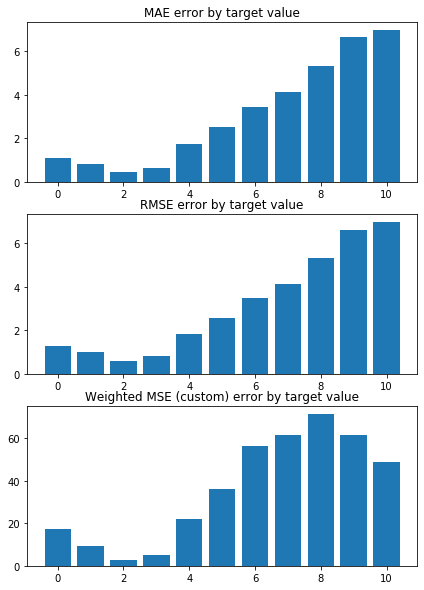

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.248523648938308 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1076033662672697 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


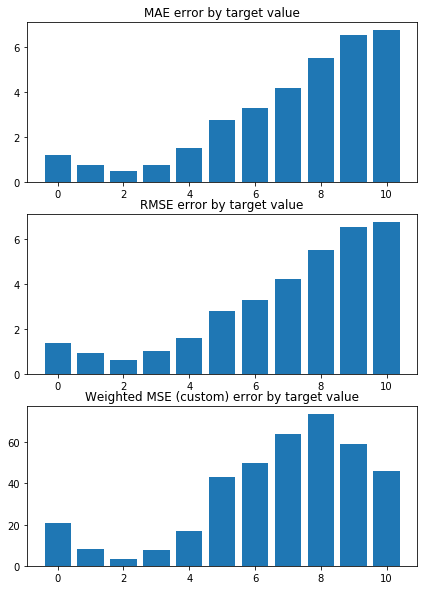

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1101301378493147 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1258726210136634 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


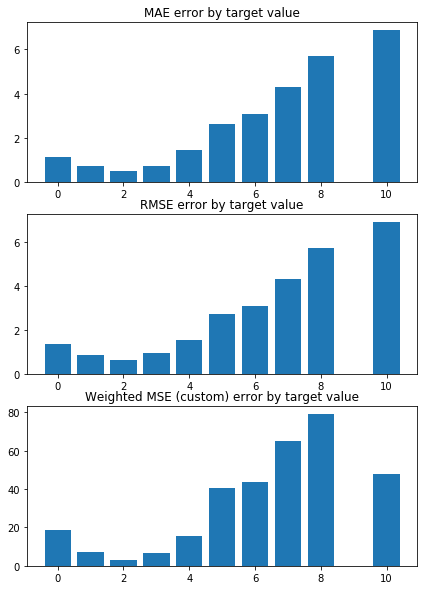

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1833544093501587 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1172404335431874 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


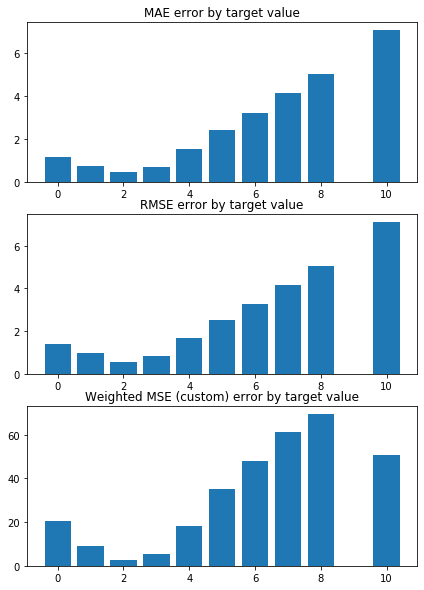

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0978353453869034 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1158538182432958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


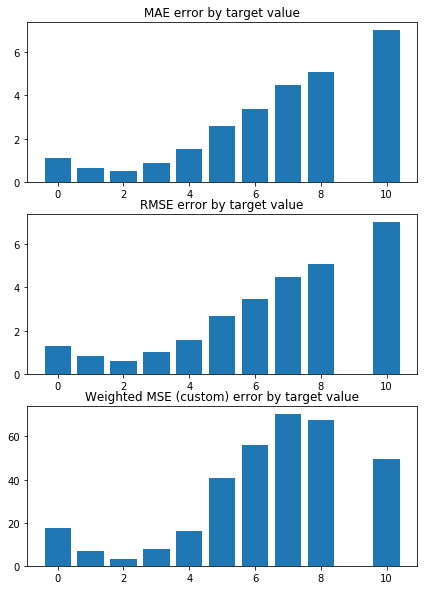

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9977430026762012 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1352960062487432 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


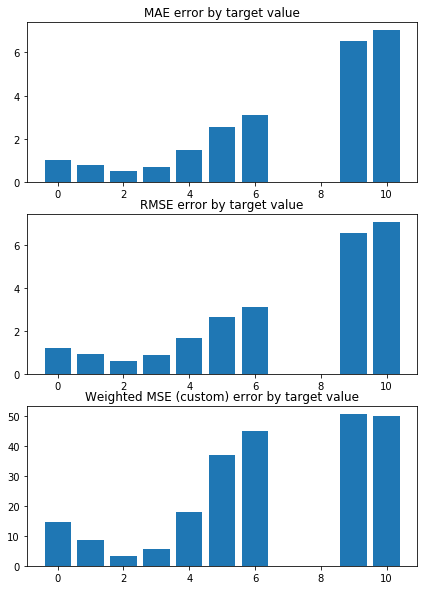

Weighted Mean squared error on Train: 1.12 
 MSE mean train: 2.7650665371933685 

Mean squared error on Test: 1.12 
 MSE mean test:  2.768351544324202 

Root of MSE on Test: 1.06 
 1.663836393496729 

Variance score on Test: 0.07 
 r2_test: 0.2523172405088584 

wMSE_train 1.12
wMSE_test 1.12
MSE_train 2.77
MSE_test 2.77
MAE_train 1.09
MAE_test 1.04
r2_test 0.25
    H3K4me1     Chriz  H3K27me1  H3K36me3  H3K36me1  H3K27me3  H3K27ac  \
0 -0.353755 -0.306708 -0.210808      -0.0      -0.0       0.0     -0.0   
1 -0.354375 -0.300893 -0.214026      -0.0      -0.0       0.0     -0.0   
2 -0.357213 -0.308323 -0.214941      -0.0      -0.0       0.0     -0.0   
3 -0.361839 -0.316662 -0.209853      -0.0      -0.0       0.0     -0.0   
4 -0.360059 -0.298617 -0.212771      -0.0      -0.0       0.0     -0.0   
5 -0.356867 -0.300828 -0.214321      -0.0      -0.0       0.0     -0.0   
6 -0.384182 -0.295716 -0.198391      -0.0      -0.0       0.0     -0.0   
7 -0.356358 -0.315794 -0.210503      -0.0   

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


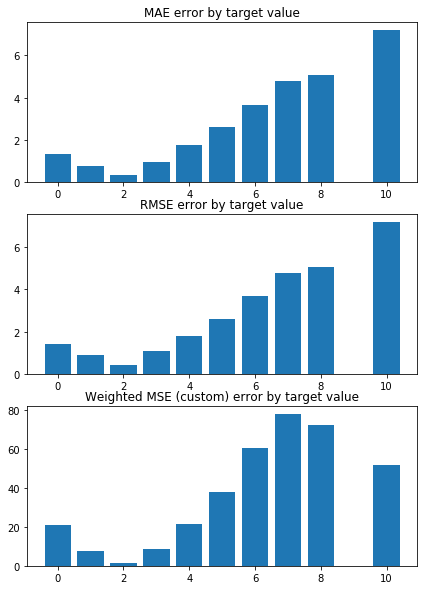

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2143765793019878 


 TRAIN PREDICTION Error
weighted_mse_train: 1.174409157479403 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


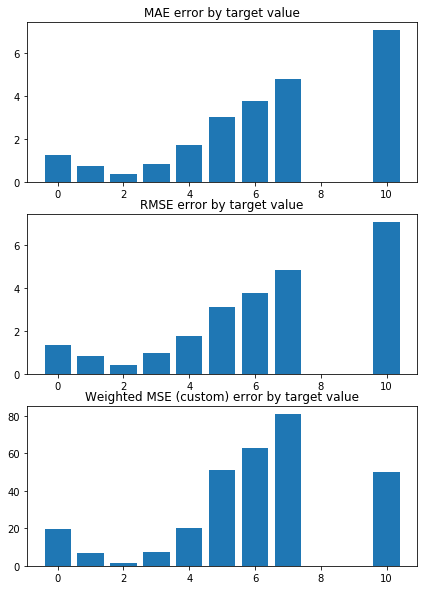

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0882974816120126 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1829679427146294 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


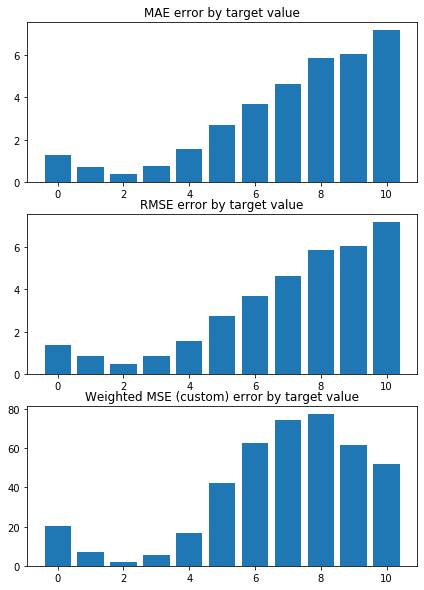

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0801488561224522 


 TRAIN PREDICTION Error
weighted_mse_train: 1.181510396536179 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


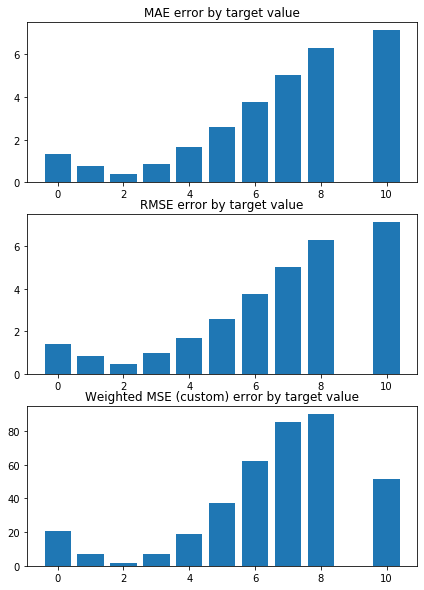

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2183034604953442 


 TRAIN PREDICTION Error
weighted_mse_train: 1.166331883406385 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


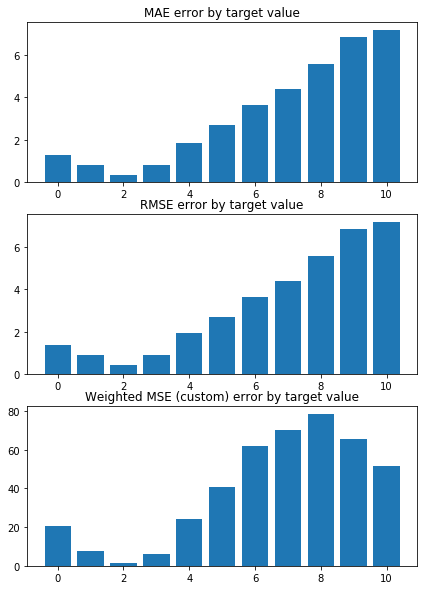

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.297620963114882 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1647306395904118 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


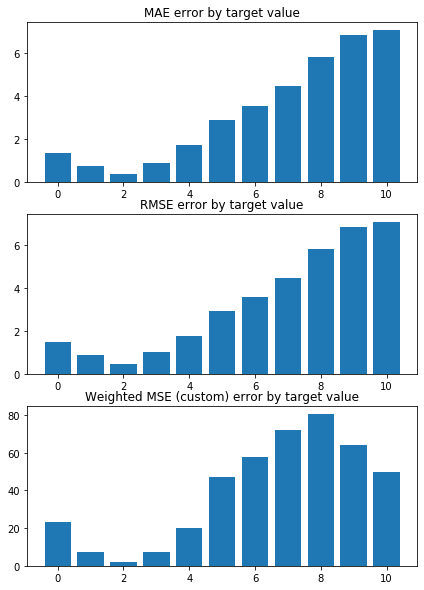

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1701593697284822 


 TRAIN PREDICTION Error
weighted_mse_train: 1.182070860762625 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


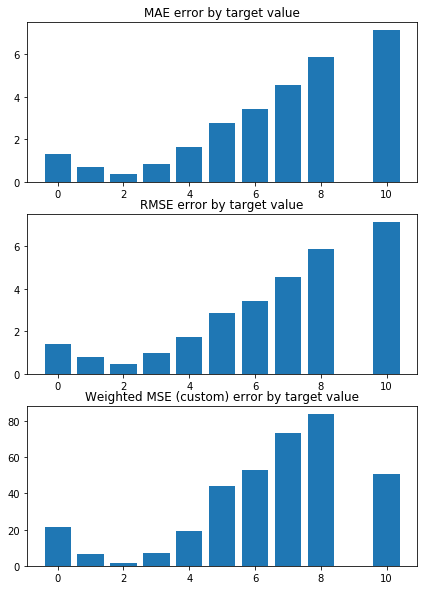

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.2405576136793668 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1721024464746457 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


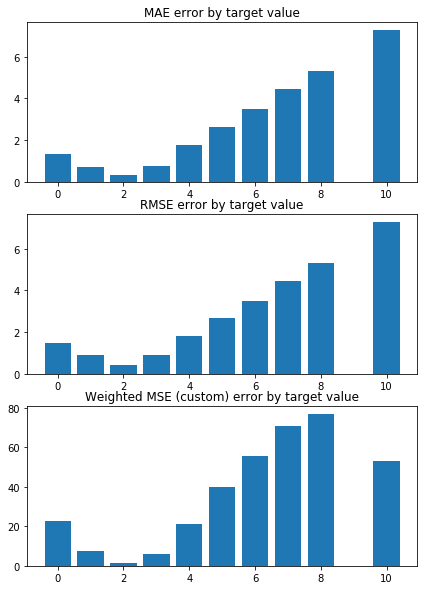

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1616735373910592 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1717910342257314 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


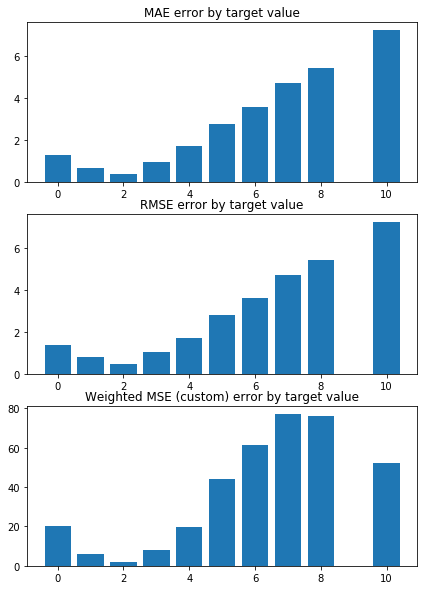

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0579899642596575 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1892525725291918 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


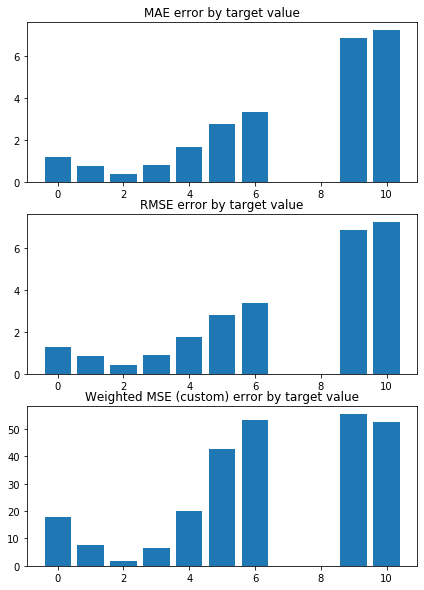

Weighted Mean squared error on Train: 1.18 
 MSE mean train: 2.930673671358488 

Mean squared error on Test: 1.18 
 MSE mean test:  2.9339959095920007 

Root of MSE on Test: 1.08 
 1.7128910968278166 

Variance score on Test: 0.08 
 r2_test: 0.2077517249320106 

wMSE_train 1.18
wMSE_test 1.18
MSE_train 2.93
MSE_test 2.93
MAE_train 1.14
MAE_test 1.09
r2_test 0.21
    H3K4me1     Chriz  H3K27me1   H3K4me2  H3K36me3  H3K36me1  H3K27me3  \
0 -0.222309 -0.151827 -0.139628 -0.087380      -0.0      -0.0       0.0   
1 -0.231721 -0.157448 -0.144349 -0.064919      -0.0      -0.0       0.0   
2 -0.228701 -0.163339 -0.139701 -0.079751      -0.0      -0.0       0.0   
3 -0.231992 -0.164628 -0.136245 -0.086322      -0.0      -0.0       0.0   
4 -0.236756 -0.156263 -0.138189 -0.073544      -0.0      -0.0       0.0   
5 -0.218481 -0.143248 -0.137872 -0.101682      -0.0      -0.0       0.0   
6 -0.253818 -0.142580 -0.120766 -0.091766      -0.0      -0.0       0.0   
7 -0.219911 -0.159730 -0.132238 -0.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


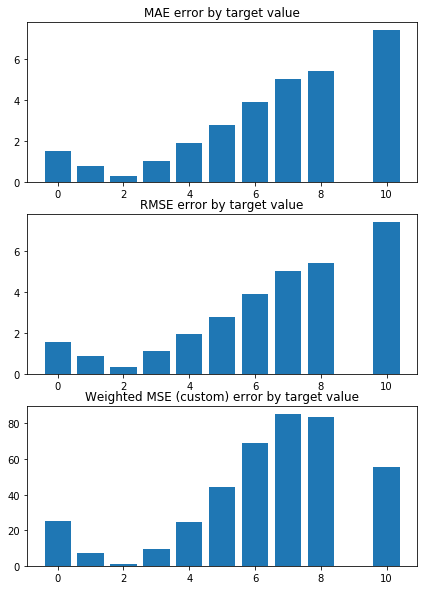

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3791012579755806 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3126996591822673 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


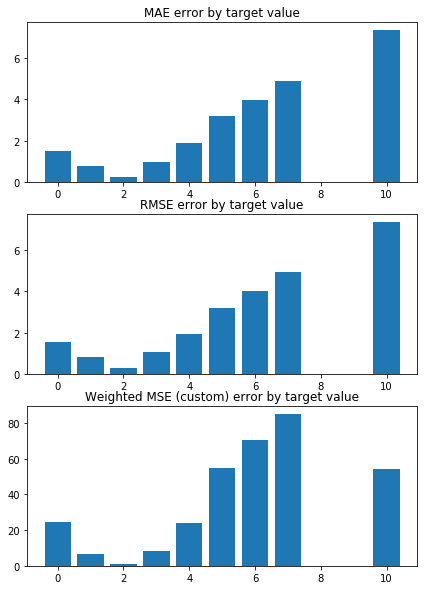

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.209567921574104 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3219303245572787 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


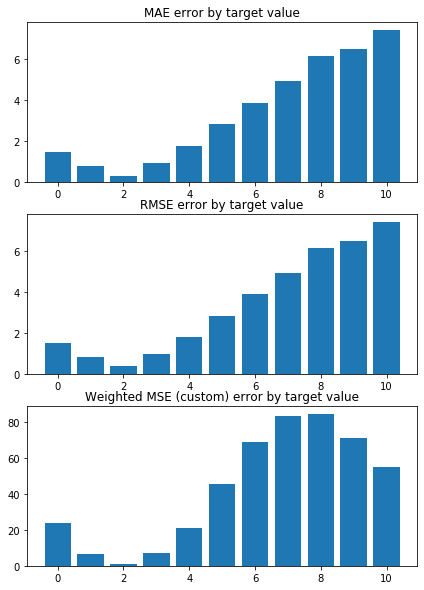

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1858216288358896 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3170507202235735 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


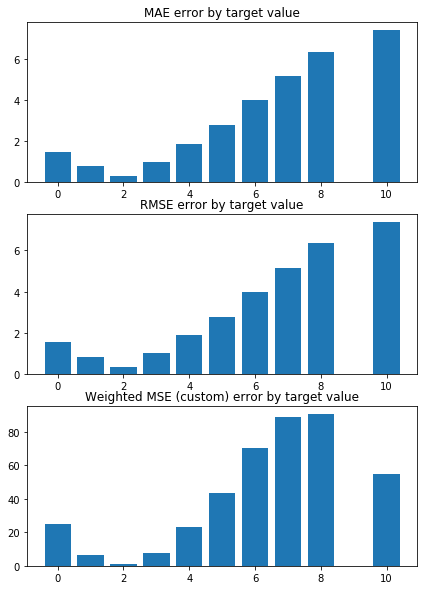

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.359623858417923 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3016330354836187 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


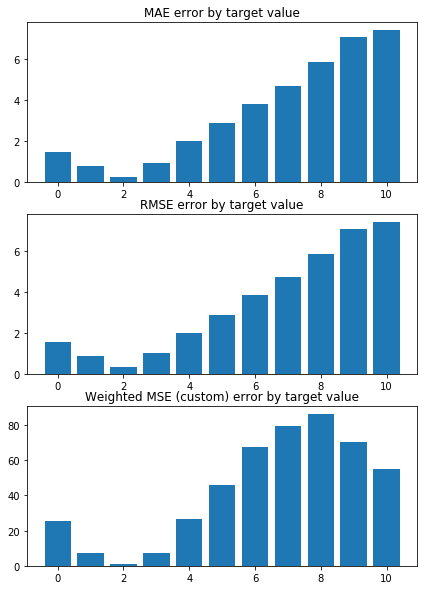

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.422981428998192 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3007608627556115 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


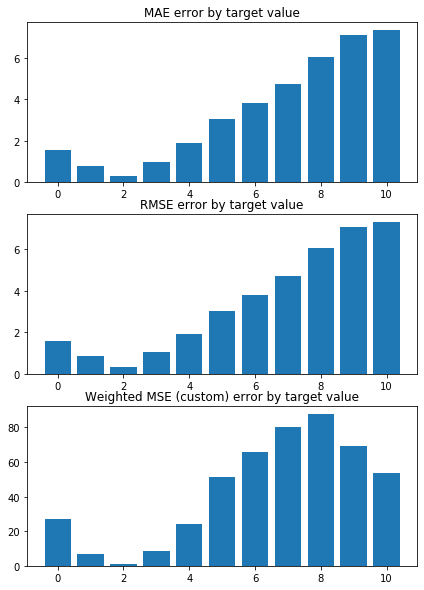

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3089447722564271 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3160237151572995 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


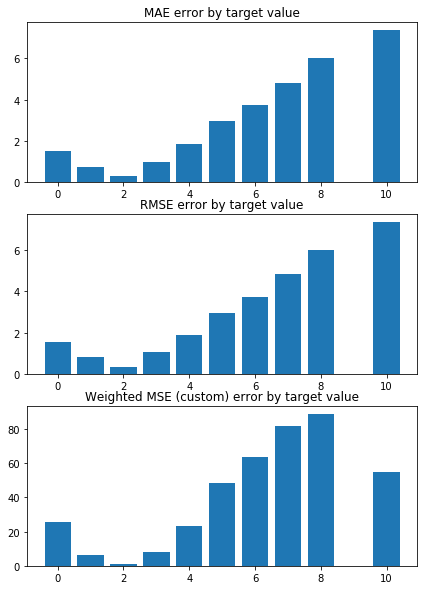

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.3839477096833532 


 TRAIN PREDICTION Error
weighted_mse_train: 1.307787119353173 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


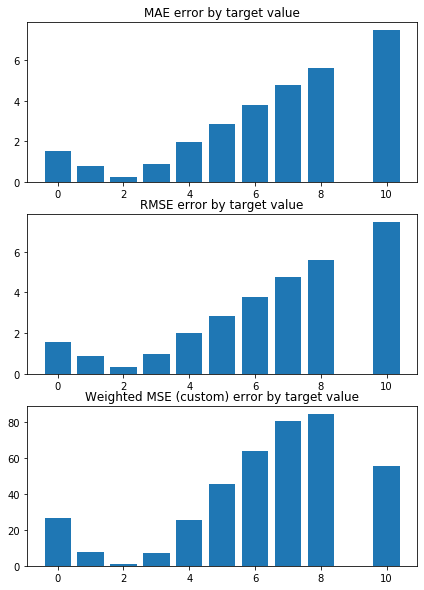

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2965698996645885 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3067514516385945 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


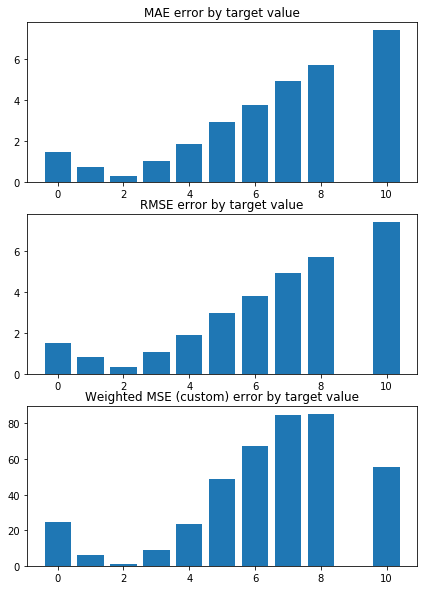

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.202359760670549 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3271814707877476 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


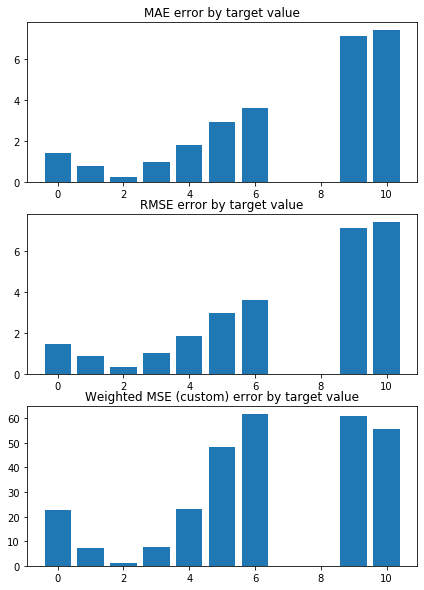

Weighted Mean squared error on Train: 1.31 
 MSE mean train: 3.197662185822201 

Mean squared error on Test: 1.31 
 MSE mean test:  3.200848077097713 

Root of MSE on Test: 1.15 
 1.7890914110513507 

Variance score on Test: 0.08 
 r2_test: 0.13572192308857062 

wMSE_train 1.31
wMSE_test 1.31
MSE_train 3.2
MSE_test 3.2
MAE_train 1.22
MAE_test 1.17
r2_test 0.14
    H3K4me2   H3K4me1  H3K27me1  Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27ac  \
0 -0.207553 -0.069697 -0.057408   -0.0      -0.0      -0.0       0.0     -0.0   
1 -0.191986 -0.073039 -0.062339   -0.0      -0.0      -0.0       0.0     -0.0   
2 -0.216321 -0.066889 -0.056058   -0.0      -0.0      -0.0       0.0     -0.0   
3 -0.225621 -0.072015 -0.052344   -0.0      -0.0      -0.0       0.0     -0.0   
4 -0.201631 -0.081513 -0.053414   -0.0      -0.0      -0.0       0.0     -0.0   
5 -0.214403 -0.069111 -0.052159   -0.0      -0.0      -0.0       0.0     -0.0   
6 -0.200097 -0.108731 -0.034327   -0.0      -0.0      -0.0       0.0  

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


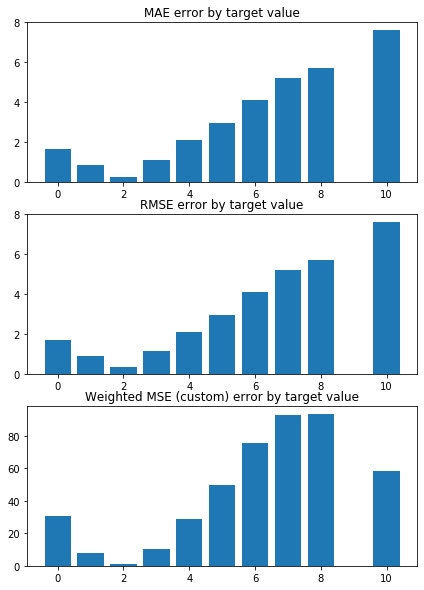

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.593751596323009 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4952882404326977 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


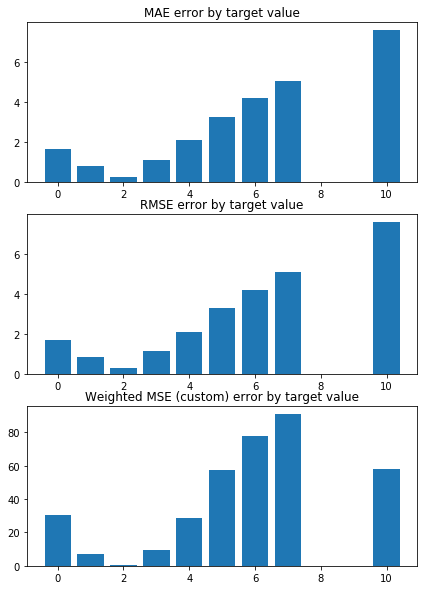

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3865790754633684 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5011138052021087 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


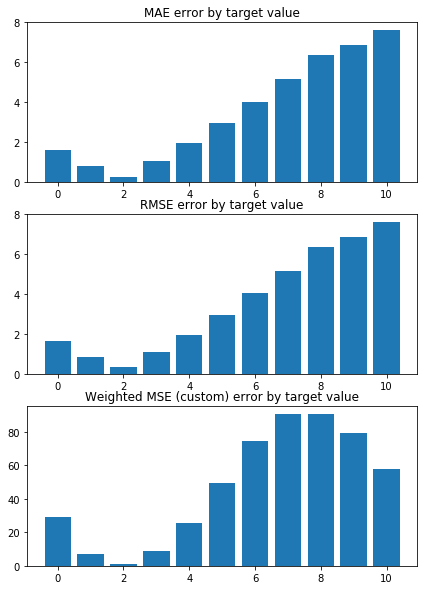

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3290565033693151 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4929526002517945 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


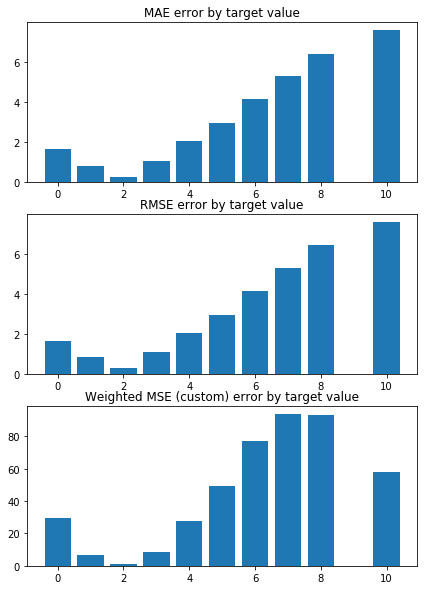

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5465319432066933 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4799952271322498 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


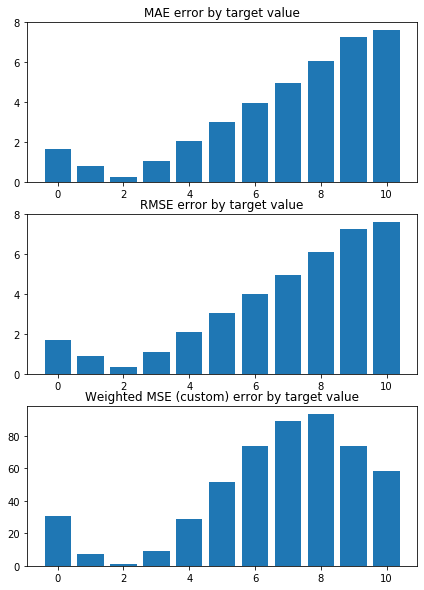

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.585343200886966 


 TRAIN PREDICTION Error
weighted_mse_train: 1.479624208094755 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


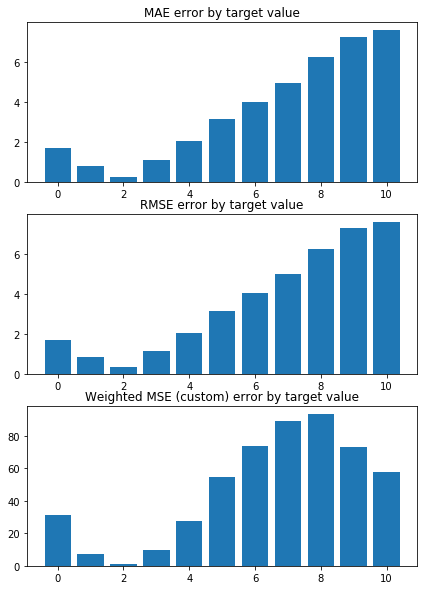

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.480266813547707 


 TRAIN PREDICTION Error
weighted_mse_train: 1.492639567419728 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


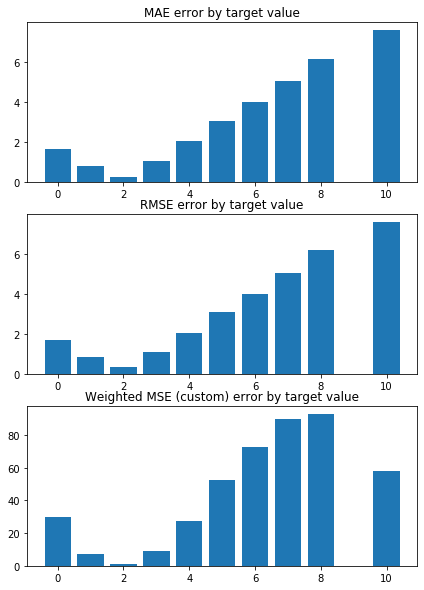

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.5688840399118014 


 TRAIN PREDICTION Error
weighted_mse_train: 1.482996799624337 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


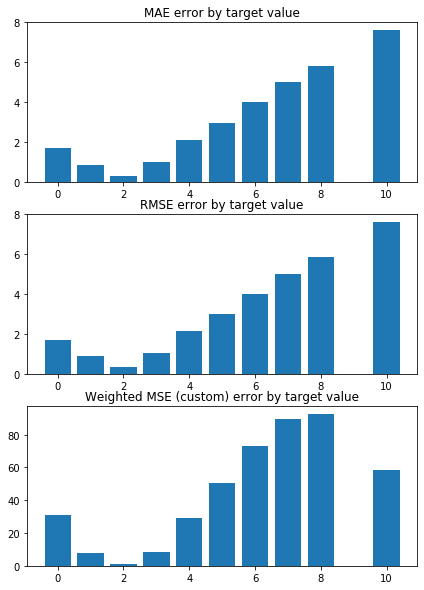

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.462244528610048 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4845604210753371 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


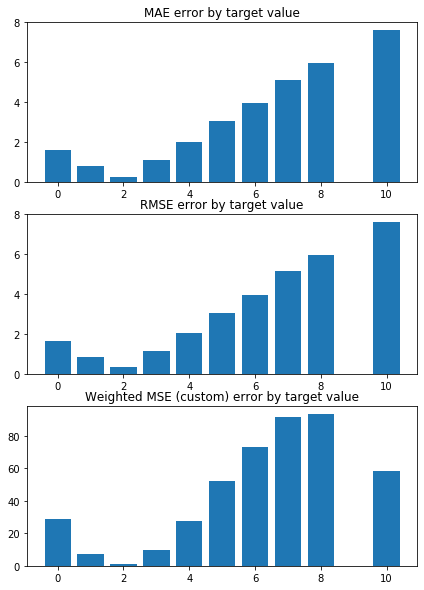

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3869383140917415 


 TRAIN PREDICTION Error
weighted_mse_train: 1.5028302843722463 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


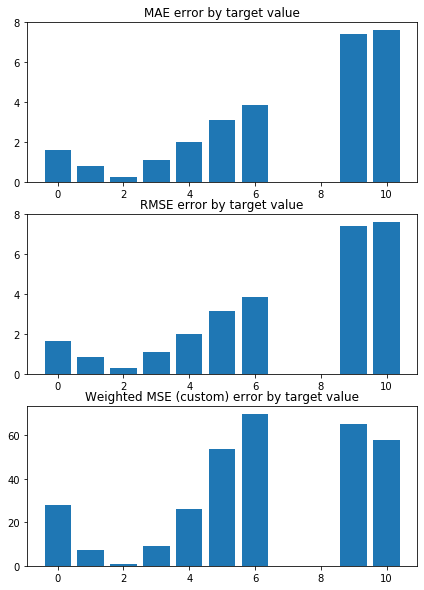

Weighted Mean squared error on Train: 1.49 
 MSE mean train: 3.5081232949657206 

Mean squared error on Test: 1.49 
 MSE mean test:  3.510309330903735 

Root of MSE on Test: 1.22 
 1.8735819520116368 

Variance score on Test: 0.09 
 r2_test: 0.05215176443256053 

wMSE_train 1.49
wMSE_test 1.49
MSE_train 3.51
MSE_test 3.51
MAE_train 1.3
MAE_test 1.26
r2_test 0.05
    H3K4me2  Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  \
0 -0.112120   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
1 -0.100655   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
2 -0.115818   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
3 -0.128712   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
4 -0.112273   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
5 -0.114394   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0   
6 -0.105431   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


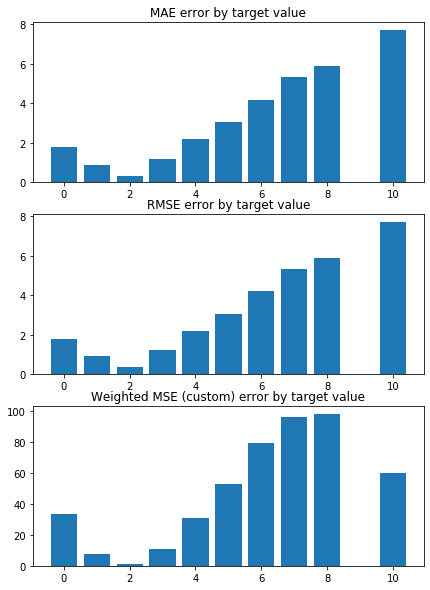

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.7231686180118282 


 TRAIN PREDICTION Error
weighted_mse_train: 1.603578125120089 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


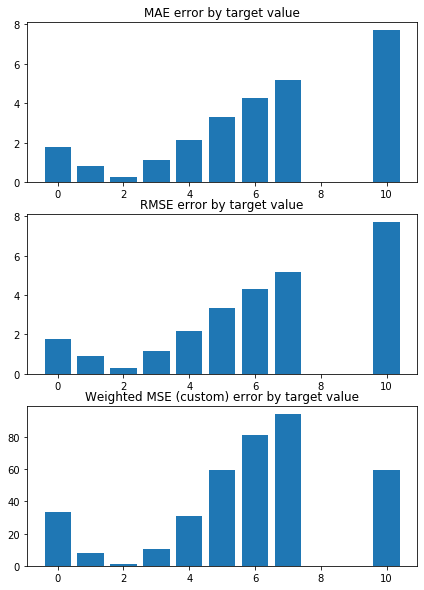

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5102232818954902 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6267009453663652 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


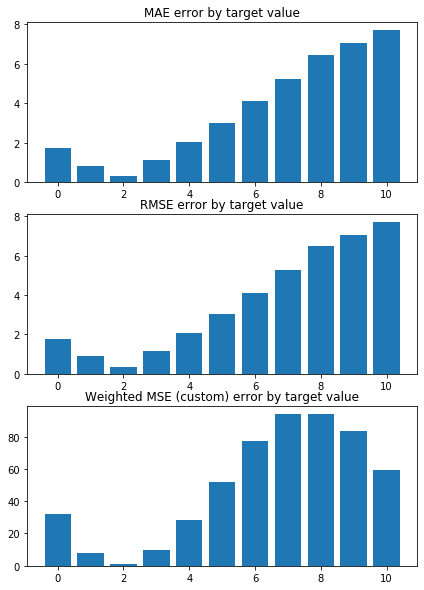

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4472258533824836 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6327687127534842 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


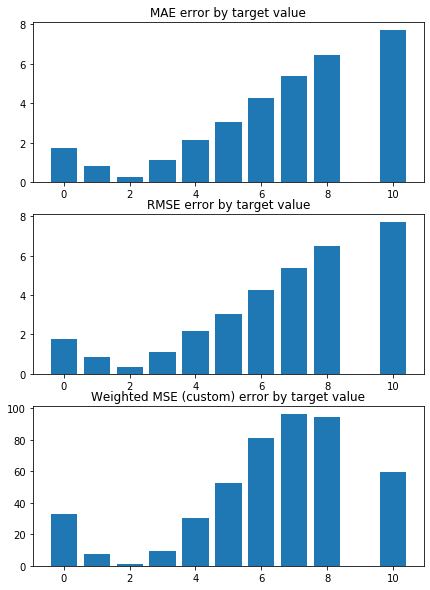

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6722112246990009 


 TRAIN PREDICTION Error
weighted_mse_train: 1.600895815024395 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


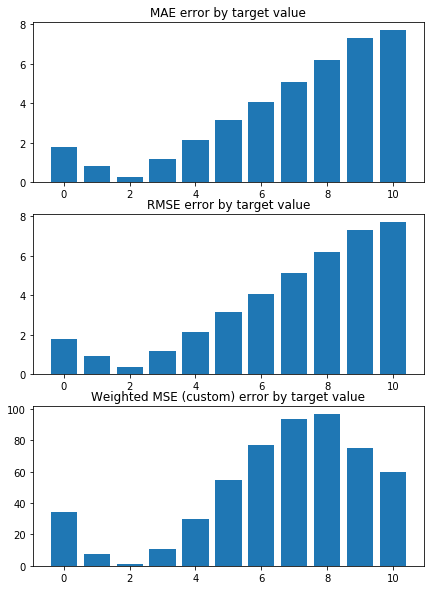

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.699109321425948 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6042463671176324 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


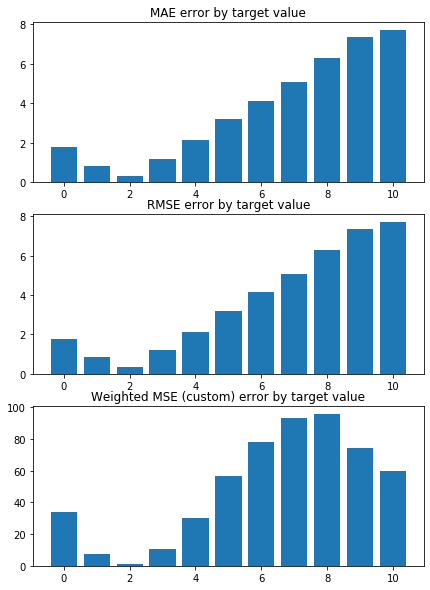

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6115493681587238 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6229792610483615 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


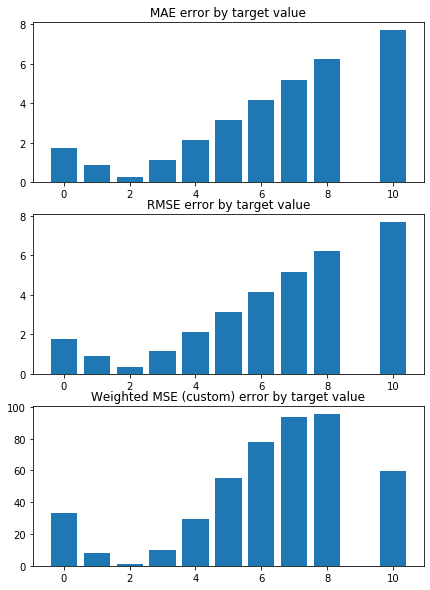

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.7038577806859556 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6145880862212005 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


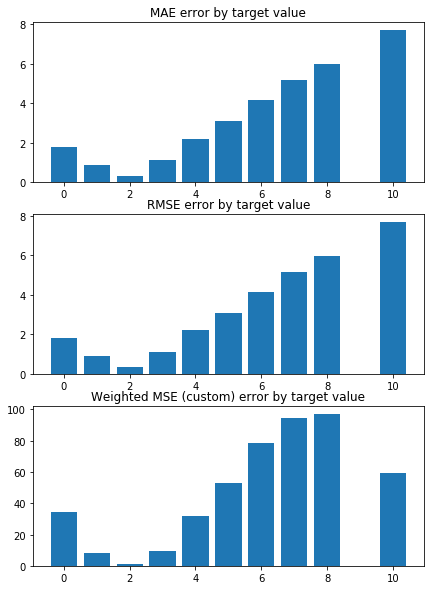

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.579451336632733 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6105903959818606 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


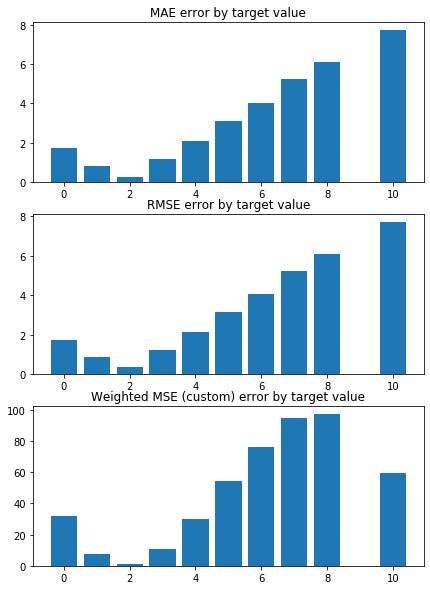

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5164826084211207 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6296968812107187 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


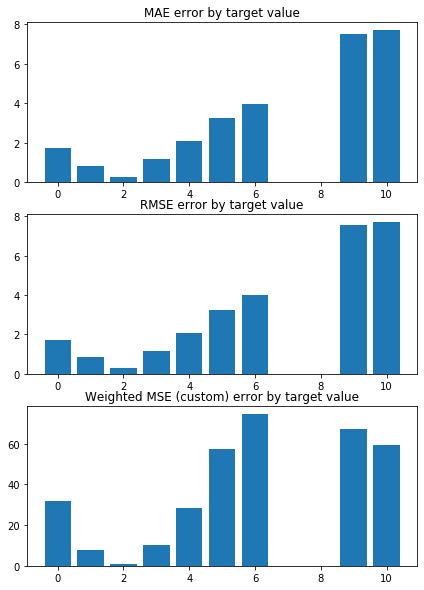

Weighted Mean squared error on Train: 1.61 
 MSE mean train: 3.7072627679387224 

Mean squared error on Test: 1.62 
 MSE mean test:  3.7083534412806514 

Root of MSE on Test: 1.27 
 1.9257085556440392 

Variance score on Test: 0.09 
 r2_test: -0.0014964637020806082 

wMSE_train 1.61
wMSE_test 1.62
MSE_train 3.71
MSE_test 3.71
MAE_train 1.36
MAE_test 1.31
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0  

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


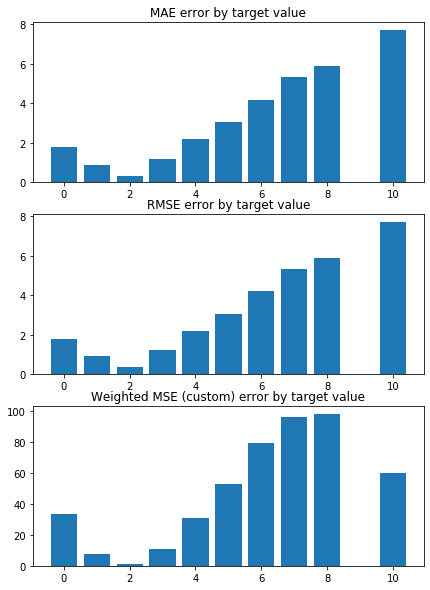

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.7231686180118282 


 TRAIN PREDICTION Error
weighted_mse_train: 1.603578125120089 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


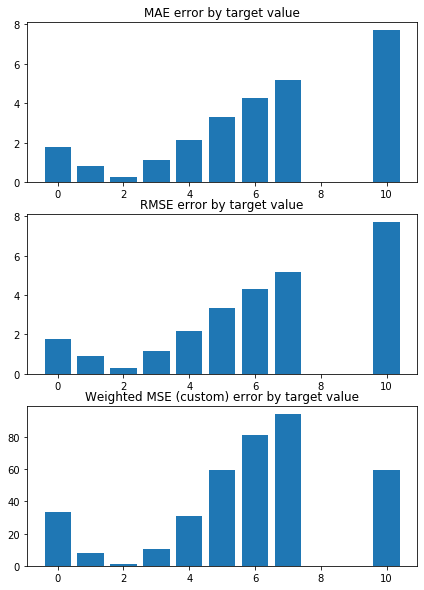

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5102232818954902 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6267009453663652 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


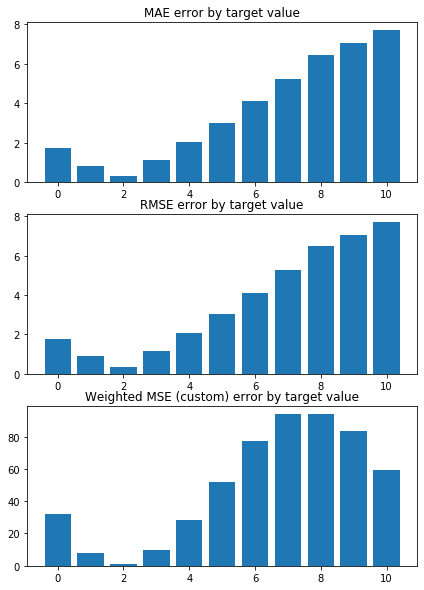

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4472258533824836 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6327687127534842 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


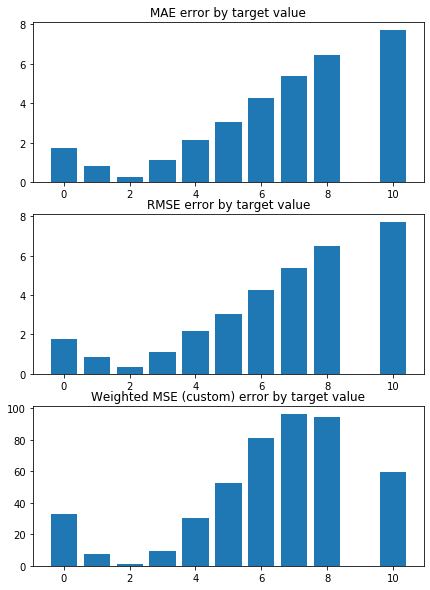

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6722112246990009 


 TRAIN PREDICTION Error
weighted_mse_train: 1.600895815024395 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


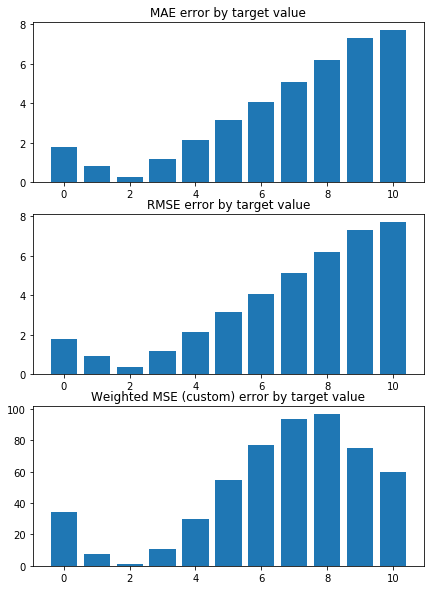

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.699109321425948 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6042463671176324 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


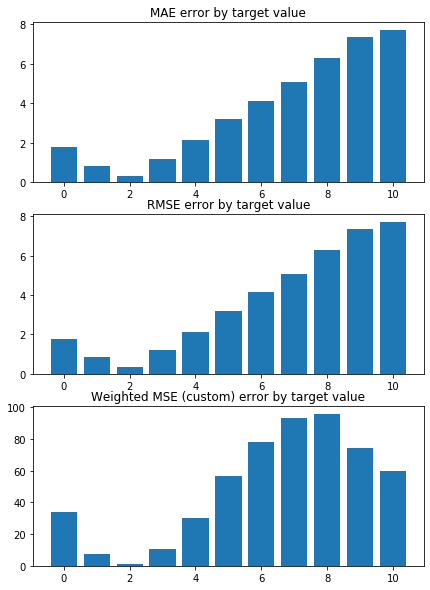

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6115493681587238 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6229792610483615 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


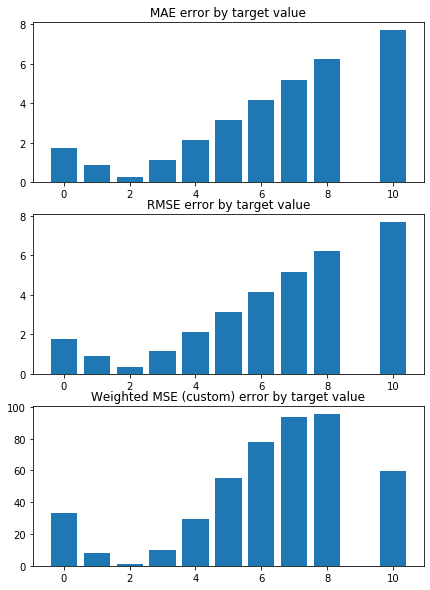

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.7038577806859556 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6145880862212005 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


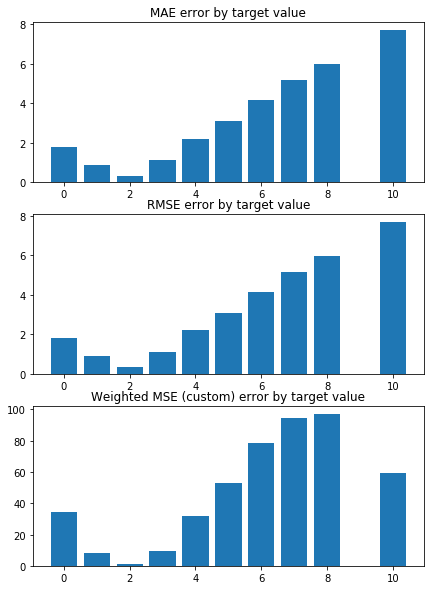

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.579451336632733 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6105903959818606 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


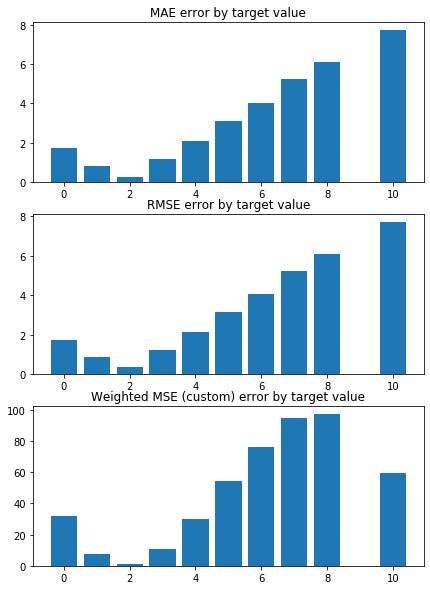

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5164826084211207 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6296968812107187 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


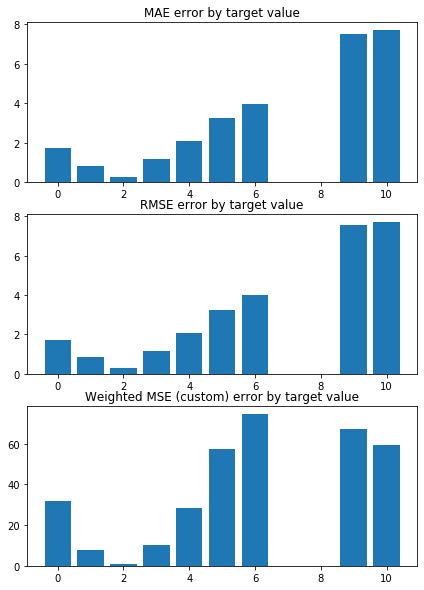

Weighted Mean squared error on Train: 1.61 
 MSE mean train: 3.7072627679387224 

Mean squared error on Test: 1.62 
 MSE mean test:  3.7083534412806514 

Root of MSE on Test: 1.27 
 1.9257085556440392 

Variance score on Test: 0.09 
 r2_test: -0.0014964637020806082 

wMSE_train 1.61
wMSE_test 1.62
MSE_train 3.71
MSE_test 3.71
MAE_train 1.36
MAE_test 1.31
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0  

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


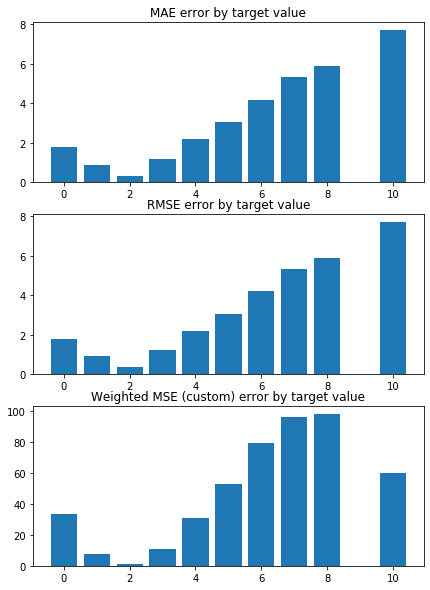

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.7231686180118282 


 TRAIN PREDICTION Error
weighted_mse_train: 1.603578125120089 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


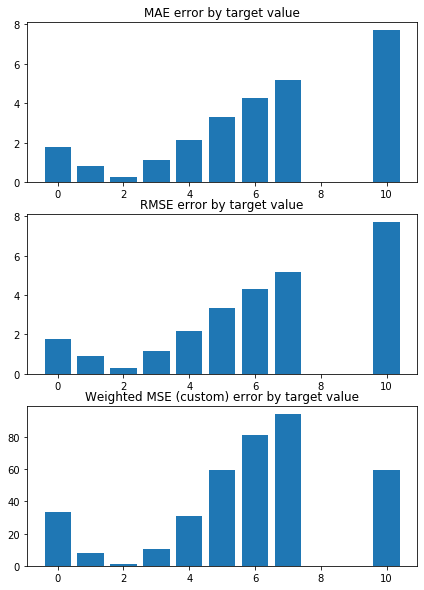

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5102232818954902 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6267009453663652 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


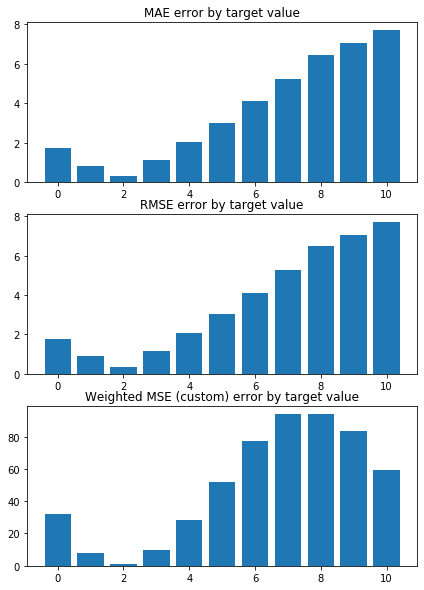

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4472258533824836 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6327687127534842 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


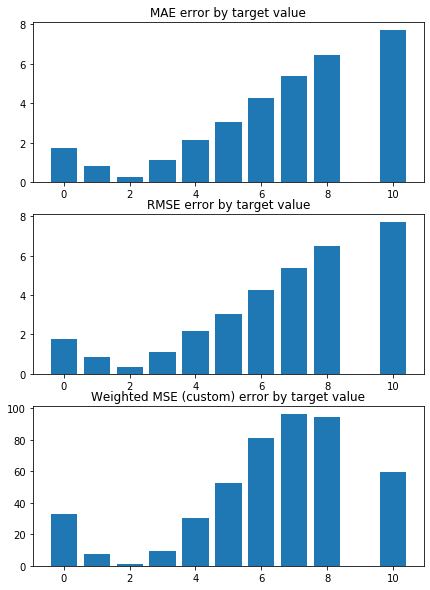

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6722112246990009 


 TRAIN PREDICTION Error
weighted_mse_train: 1.600895815024395 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


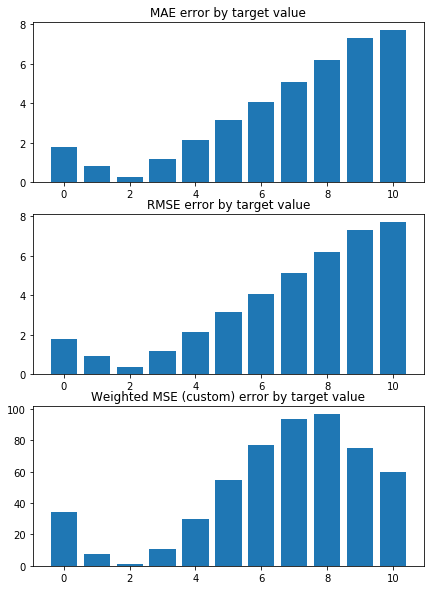

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.699109321425948 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6042463671176324 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


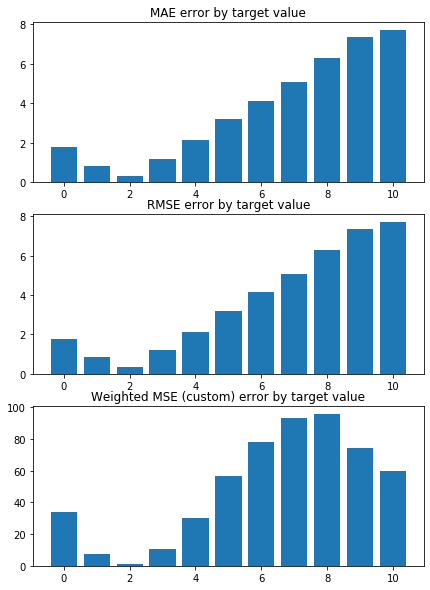

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6115493681587238 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6229792610483615 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


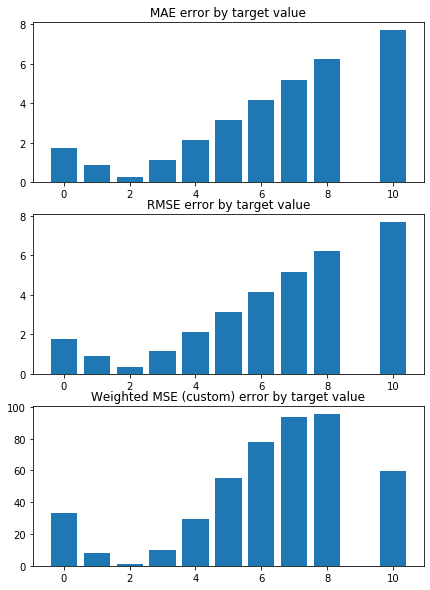

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.7038577806859556 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6145880862212005 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


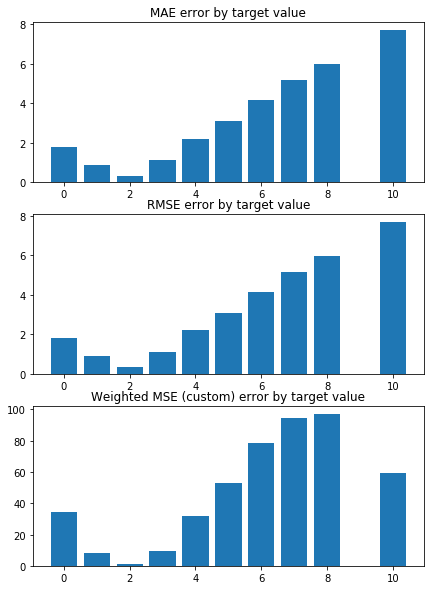

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.579451336632733 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6105903959818606 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


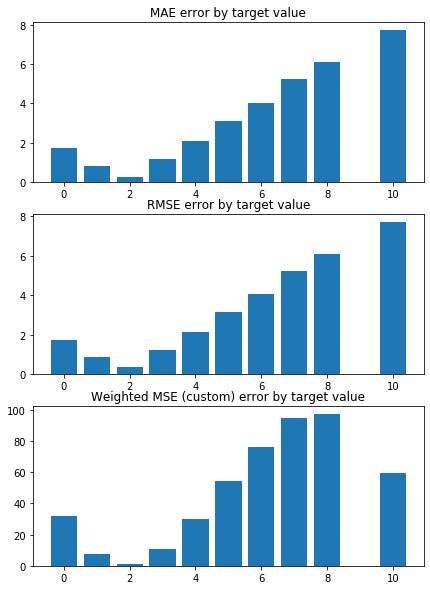

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5164826084211207 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6296968812107187 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


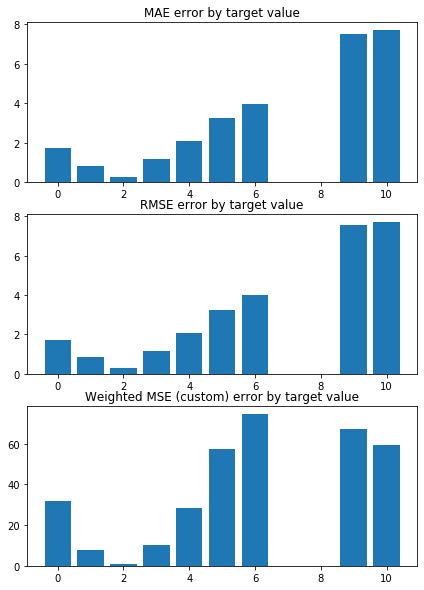

Weighted Mean squared error on Train: 1.61 
 MSE mean train: 3.7072627679387224 

Mean squared error on Test: 1.62 
 MSE mean test:  3.7083534412806514 

Root of MSE on Test: 1.27 
 1.9257085556440392 

Variance score on Test: 0.09 
 r2_test: -0.0014964637020806082 

wMSE_train 1.61
wMSE_test 1.62
MSE_train 3.71
MSE_test 3.71
MAE_train 1.36
MAE_test 1.31
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0  

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


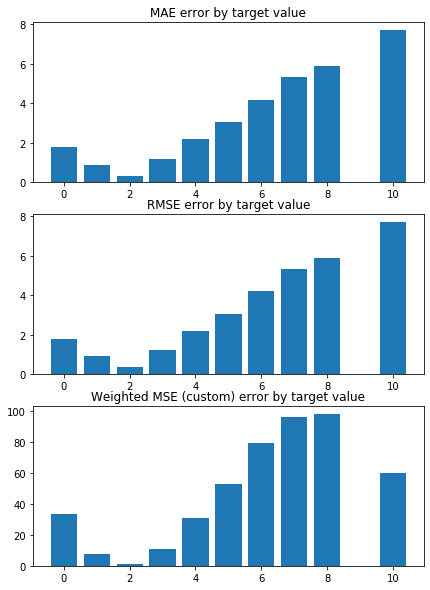

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.7231686180118282 


 TRAIN PREDICTION Error
weighted_mse_train: 1.603578125120089 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


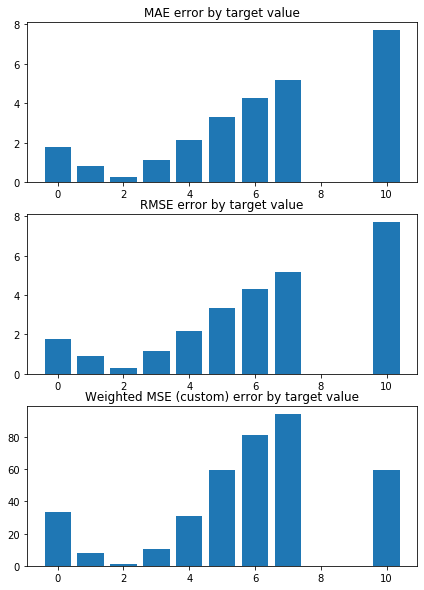

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5102232818954902 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6267009453663652 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


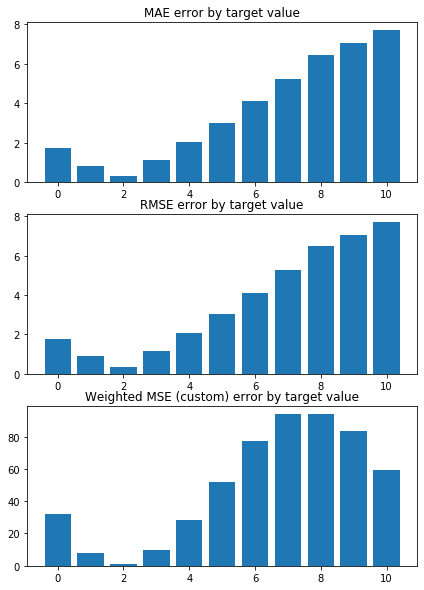

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4472258533824836 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6327687127534842 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


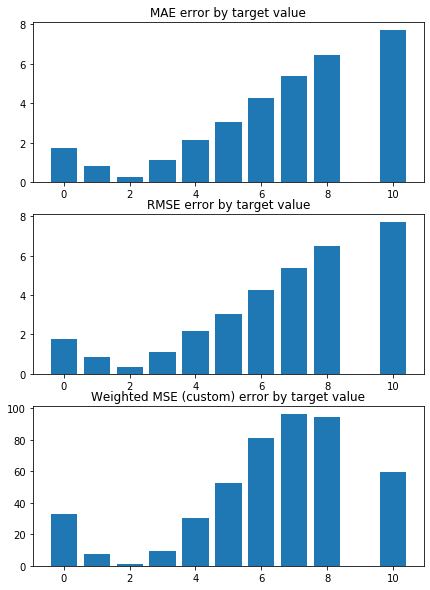

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6722112246990009 


 TRAIN PREDICTION Error
weighted_mse_train: 1.600895815024395 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


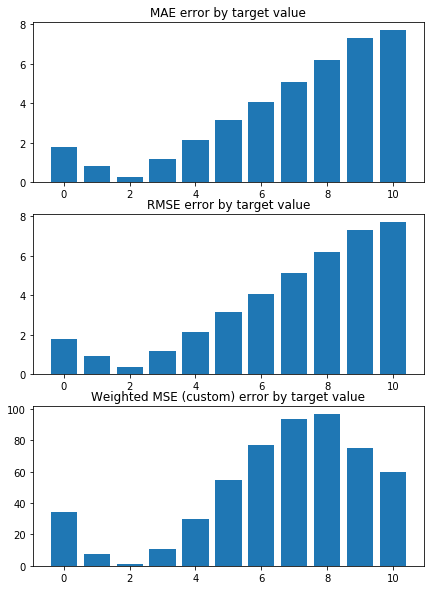

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.699109321425948 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6042463671176324 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


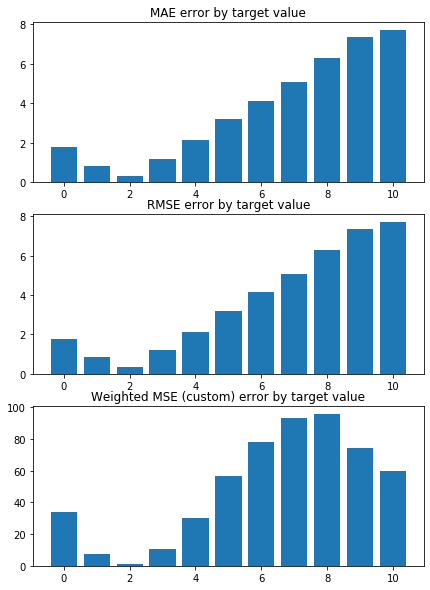

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6115493681587238 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6229792610483615 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


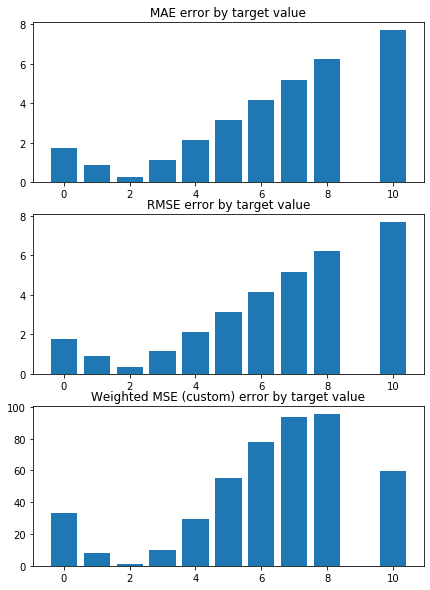

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.7038577806859556 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6145880862212005 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


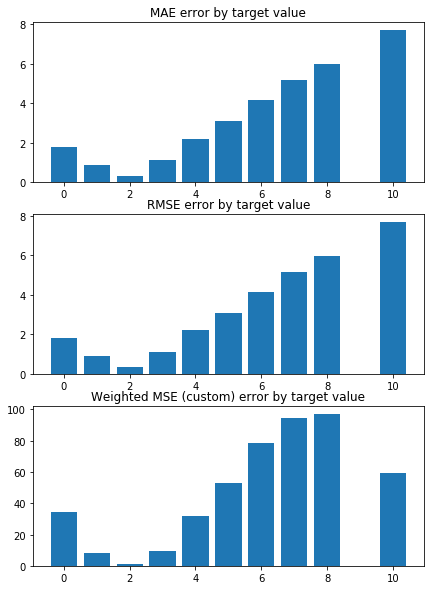

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.579451336632733 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6105903959818606 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


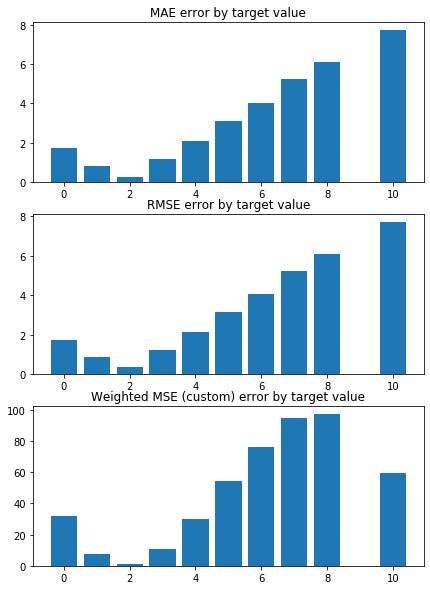

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5164826084211207 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6296968812107187 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


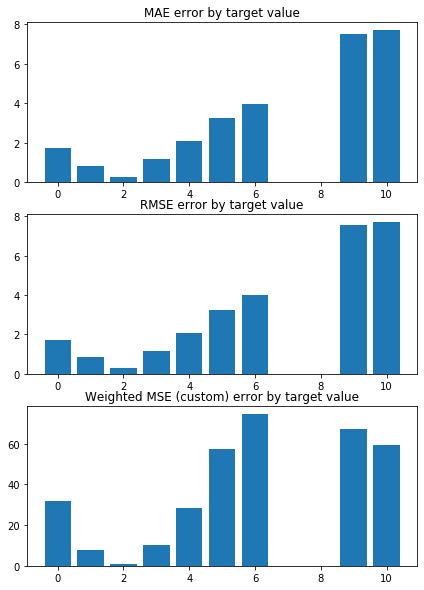

Weighted Mean squared error on Train: 1.61 
 MSE mean train: 3.7072627679387224 

Mean squared error on Test: 1.62 
 MSE mean test:  3.7083534412806514 

Root of MSE on Test: 1.27 
 1.9257085556440392 

Variance score on Test: 0.09 
 r2_test: -0.0014964637020806082 

wMSE_train 1.61
wMSE_test 1.62
MSE_train 3.71
MSE_test 3.71
MAE_train 1.36
MAE_test 1.31
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0  

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


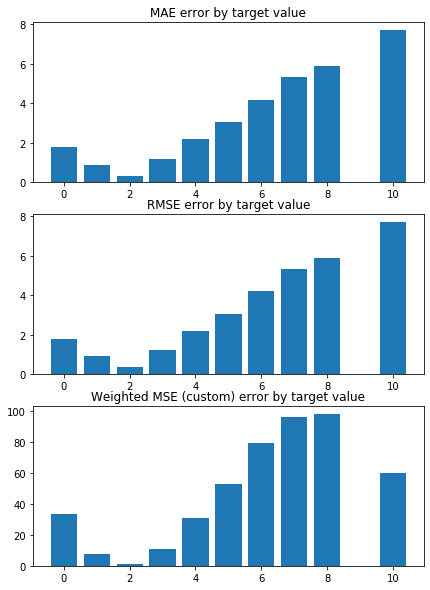

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.7231686180118282 


 TRAIN PREDICTION Error
weighted_mse_train: 1.603578125120089 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


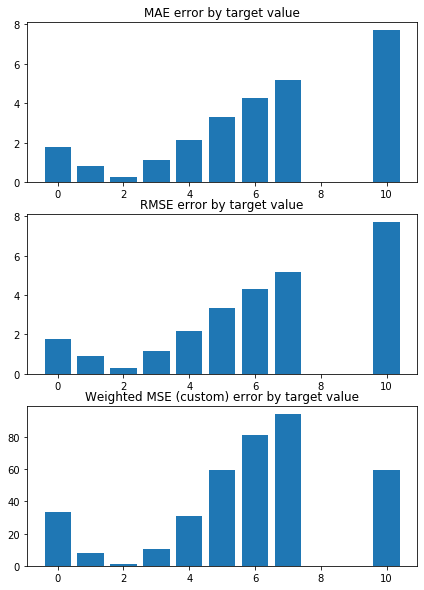

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5102232818954902 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6267009453663652 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


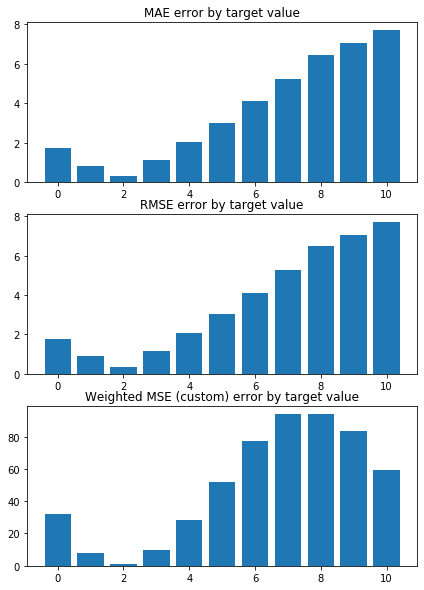

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4472258533824836 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6327687127534842 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


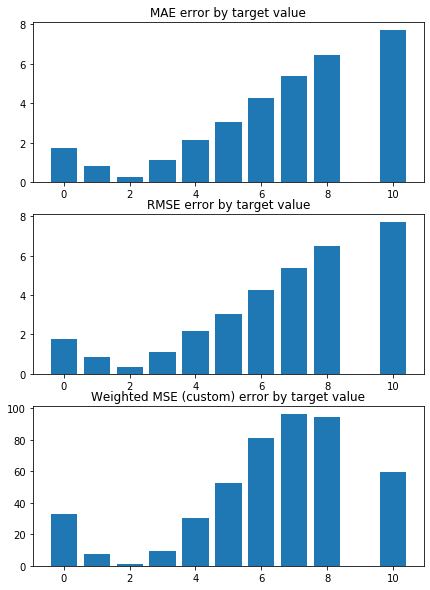

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6722112246990009 


 TRAIN PREDICTION Error
weighted_mse_train: 1.600895815024395 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


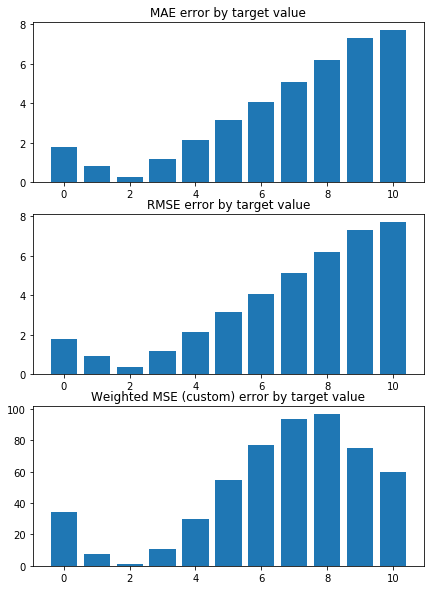

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.699109321425948 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6042463671176324 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


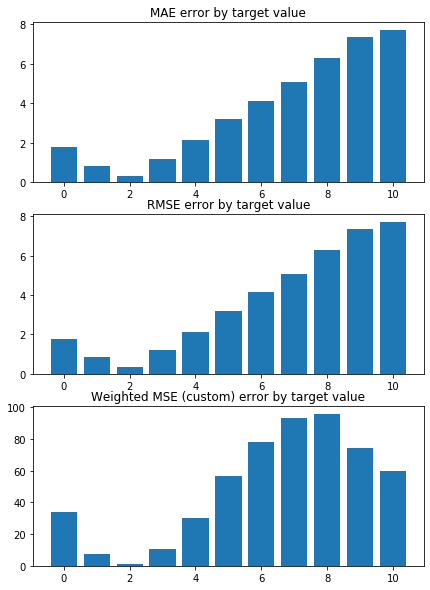

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.6115493681587238 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6229792610483615 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


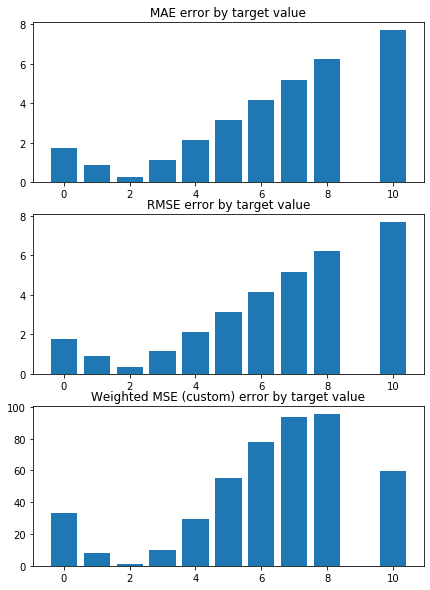

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.7038577806859556 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6145880862212005 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


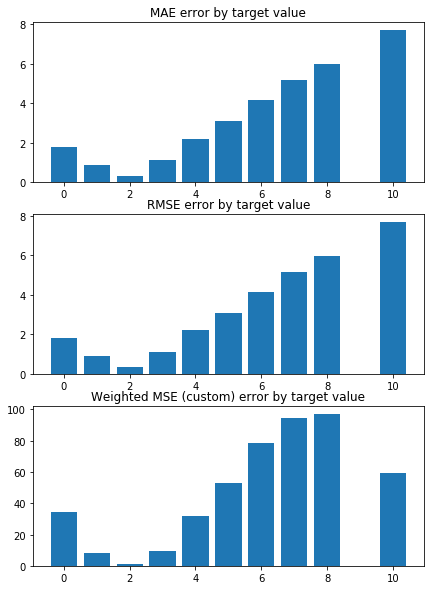

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.579451336632733 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6105903959818606 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


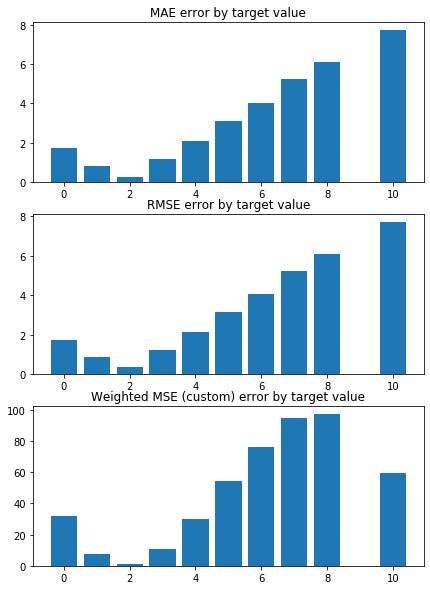

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.5164826084211207 


 TRAIN PREDICTION Error
weighted_mse_train: 1.6296968812107187 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


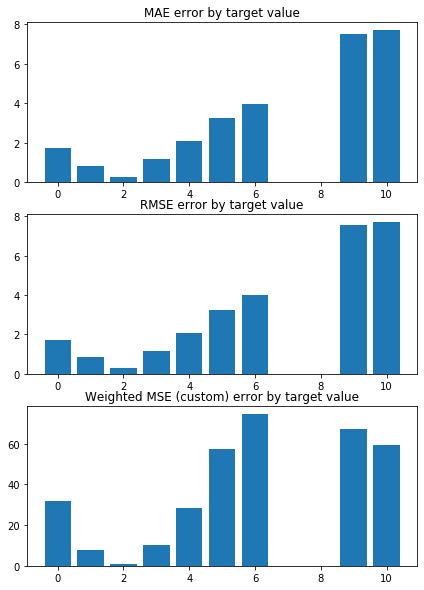

Weighted Mean squared error on Train: 1.61 
 MSE mean train: 3.7072627679387224 

Mean squared error on Test: 1.62 
 MSE mean test:  3.7083534412806514 

Root of MSE on Test: 1.27 
 1.9257085556440392 

Variance score on Test: 0.09 
 r2_test: -0.0014964637020806082 

wMSE_train 1.61
wMSE_test 1.62
MSE_train 3.71
MSE_test 3.71
MAE_train 1.36
MAE_test 1.31
r2_test -0.0
   Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27me1  H3K27ac  H3K9me3  H3K9me2  \
0   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
1   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
2   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
3   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
4   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
5   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0   
6   -0.0      -0.0      -0.0       0.0      -0.0     -0.0     -0.0     -0.0  

In [102]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

alpha_grid = np.arange(0, 2, 0.2)
# Create linear regression object

model_name = 'LR+L1_grid'
n_splits = 10
random_state = 16 
shuffle = True

wmse_test = []
wmse_train = []

for alpha in alpha_grid:
    model = linear_model.Lasso(alpha=alpha)

    

    lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                    weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                    rmse_test, rmse_train, rmse_test_const, \
                    mae_test,    mae_train,  mae_test_const, \
                    _ = train_test_KFold(X, y, 
                                                  model, model_name, results_pd,
                                                  n_splits=n_splits, random_state=random_state, shuffle=shuffle)
#     results_pd
    wmse_test.append(np.mean(weighted_mse_test_all))
    wmse_train.append(np.mean(weighted_mse_train_all))


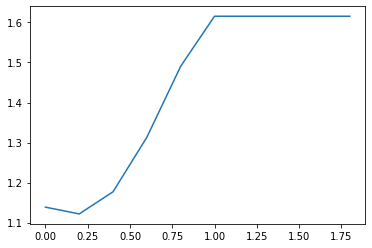

In [103]:
plt.plot(alpha_grid, wmse_test)

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.139980737329212 


 TRAIN PREDICTION Error


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6964.6554792621055, tolerance: 1.9670830459197017
  positive)


weighted_mse_train: 1.1257163976254179 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6918784159536415
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


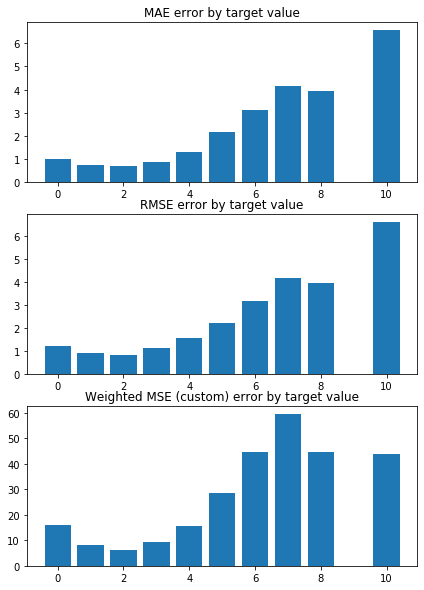

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.129096833111879 


 TRAIN PREDICTION Error
weighted_mse_train: 1.130507700795075 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7049.752537593615, tolerance: 1.978396552873951
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountere

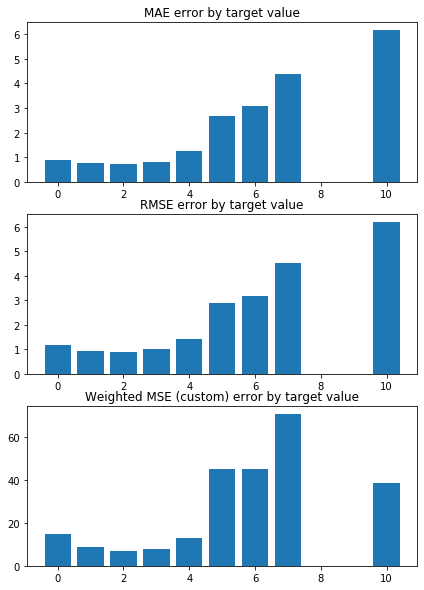

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1469742957368252 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1365426645646817 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6975.026668600487, tolerance: 1.984944464436975
  positive)


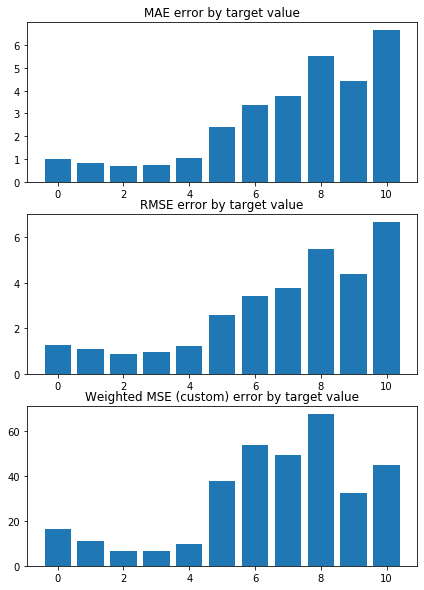

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.090212980339998 


 TRAIN PREDICTION Error


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7031.9977660037475, tolerance: 2.000600970849673
  positive)


weighted_mse_train: 1.1412522694643548 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


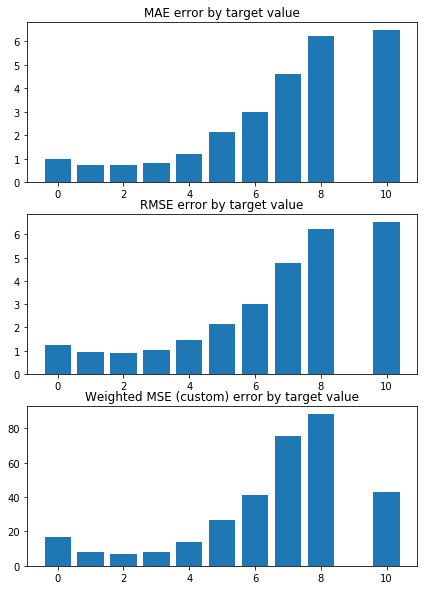

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1901367240971035 


 TRAIN PREDICTION Error


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6983.246928694507, tolerance: 1.9817038385546206
  positive)


weighted_mse_train: 1.1229246573416378 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


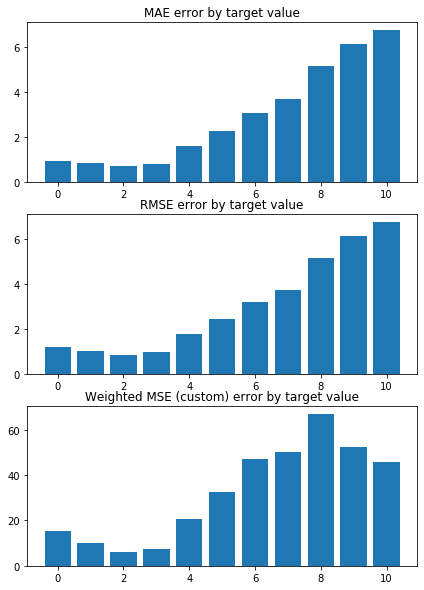

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2938024890243425 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1150653931199945 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6975.542554521183, tolerance: 1.9736104950961726
  positive)


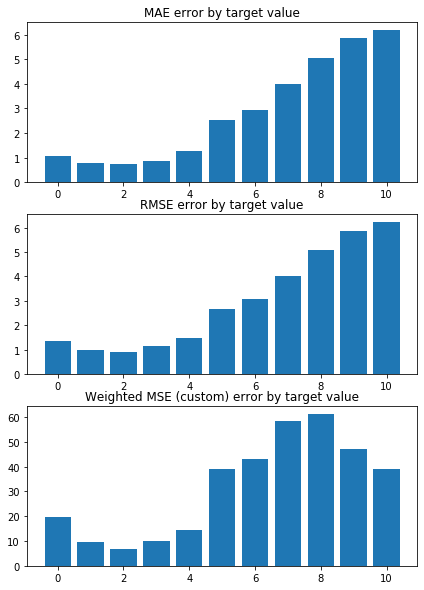

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.098853112786844 


 TRAIN PREDICTION Error


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7106.363251765085, tolerance: 2.004541321762838
  positive)


weighted_mse_train: 1.140552814566776 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


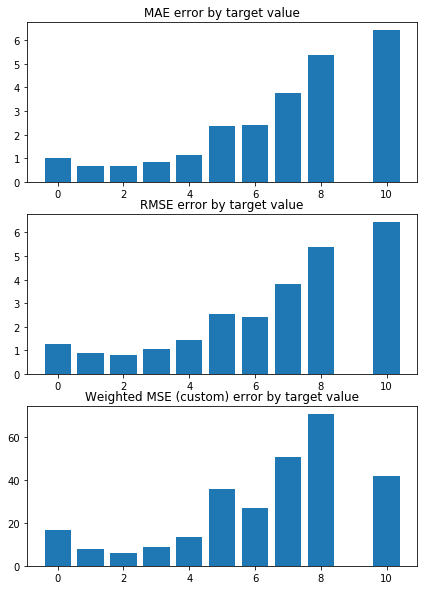

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.206870291041551 


 TRAIN PREDICTION Error


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7041.1444746062325, tolerance: 1.99764737471522
  positive)


weighted_mse_train: 1.1324953726649971 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


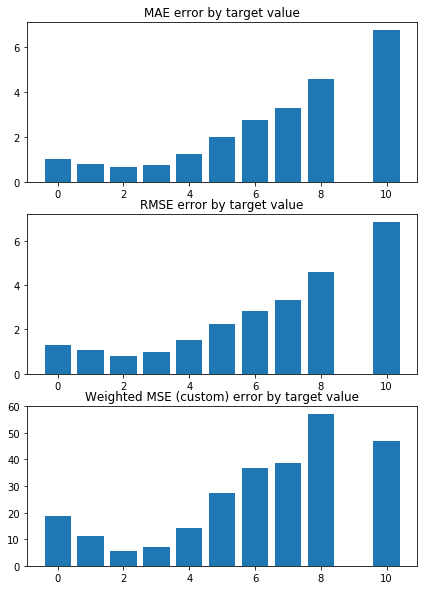

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0871347981834585 


 TRAIN PREDICTION Error
weighted_mse_train: 1.124954662502868 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6955.859443127744, tolerance: 1.96735906019421
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered

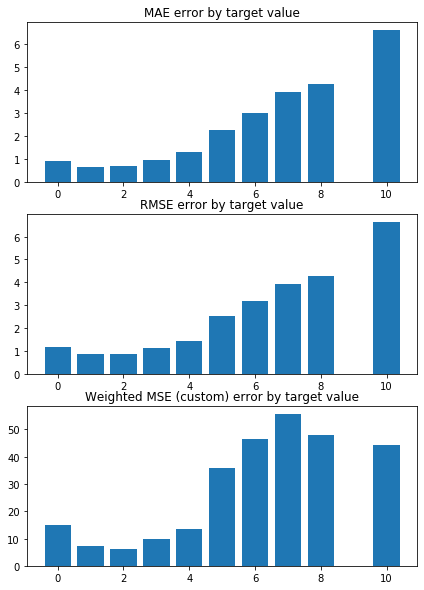

train_index= [   0    1    2 ... 5947 5948 5949]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7058.916255496497, tolerance: 1.9965049979084977
  positive)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encounter

 TEST PREDICTION Error
weighted_mse_test: 1.0035966389449584 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1497996064729963 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


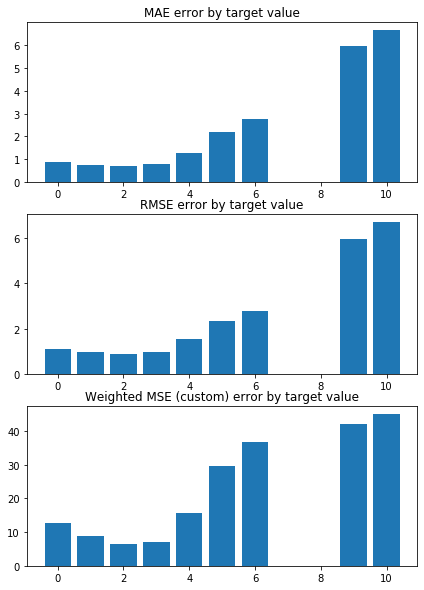

Weighted Mean squared error on Train: 1.13 
 MSE mean train: 2.6197014139933215 

Mean squared error on Test: 1.14 
 MSE mean test:  2.6340089733098773 

Root of MSE on Test: 1.07 
 1.6229630227795941 

Variance score on Test: 0.08 
 r2_test: 0.28824059929516277 

wMSE_train 1.13
wMSE_test 1.14
MSE_train 2.62
MSE_test 2.63
MAE_train 1.08
MAE_test 1.02
r2_test 0.29
      Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.319028 -0.294063 -0.277849 -0.271401 -0.270839 -0.258442 -0.247798   
1 -0.334489 -0.299304 -0.256882 -0.265283 -0.280700 -0.282460 -0.272424   
2 -0.340081 -0.337740 -0.268718 -0.241906 -0.308471 -0.334819 -0.241820   
3 -0.345520 -0.316966 -0.264153 -0.245392 -0.304656 -0.293735 -0.235759   
4 -0.308994 -0.331351 -0.291953 -0.225332 -0.314548 -0.336994 -0.240104   
5 -0.284300 -0.305691 -0.282470 -0.251748 -0.292721 -0.293370 -0.234909   
6 -0.306876 -0.299488 -0.267949 -0.253933 -0.262839 -0.279531 -0.295387   
7 -0.298799 -0.314179 -0.286027 -

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


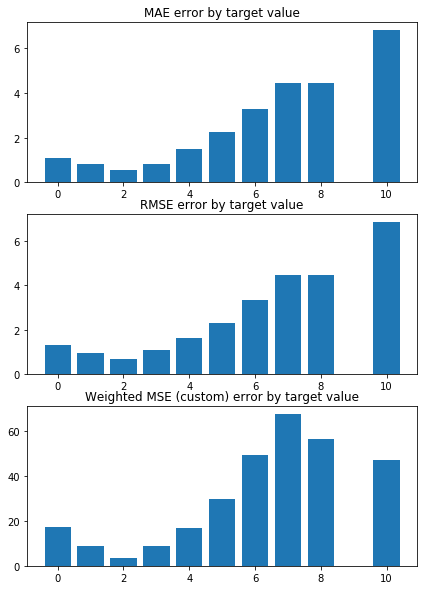

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1292075226760423 


 TRAIN PREDICTION Error
weighted_mse_train: 1.116031890882008 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


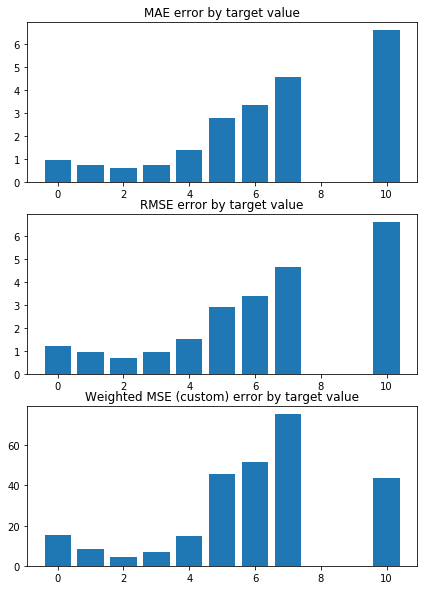

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.073196919462424 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1229638154616755 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


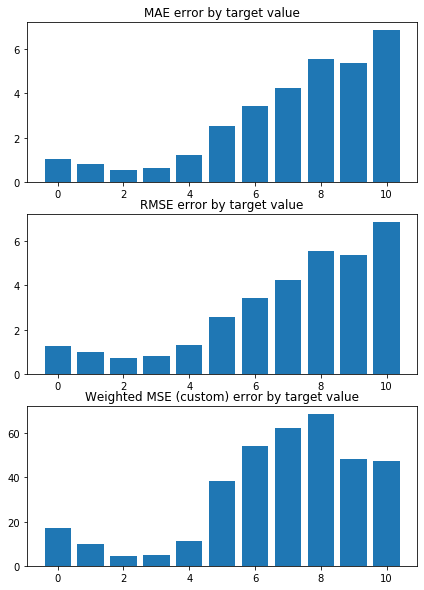

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0596840887780792 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1272800960284615 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


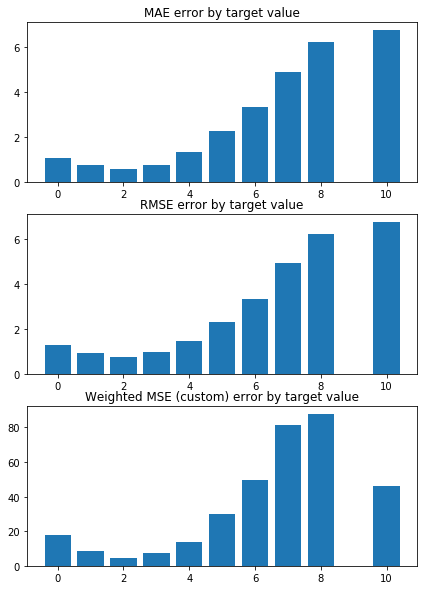

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1434744372737617 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1097442538182996 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


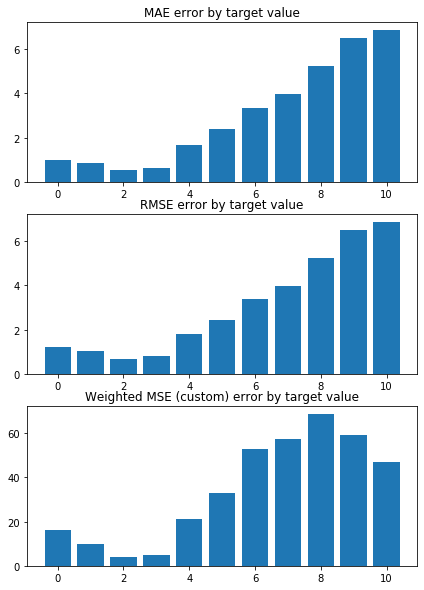

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.247531226550437 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1041840641779102 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


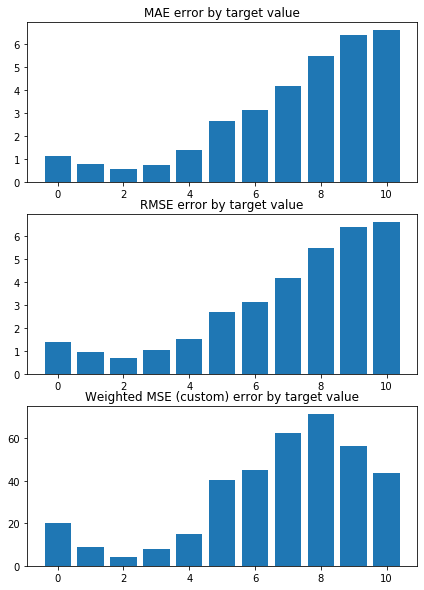

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1080469342324581 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1237408831067617 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


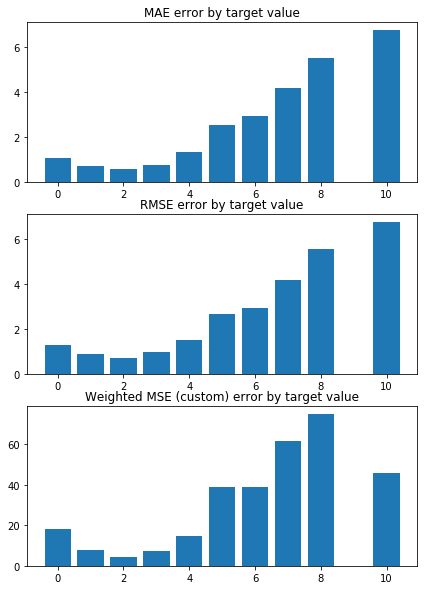

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1856565949604112 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1164231254875006 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


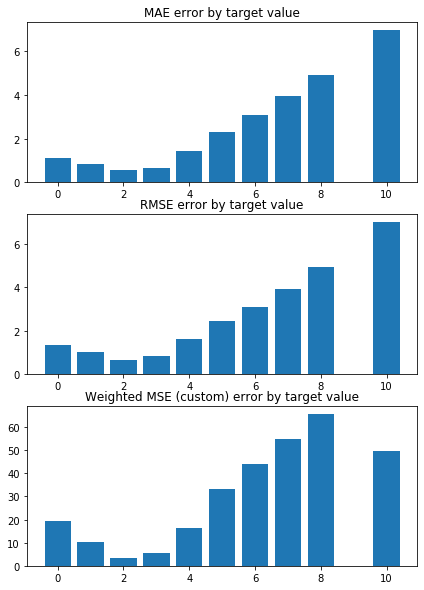

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0938530171027658 


 TRAIN PREDICTION Error
weighted_mse_train: 1.112846069850094 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


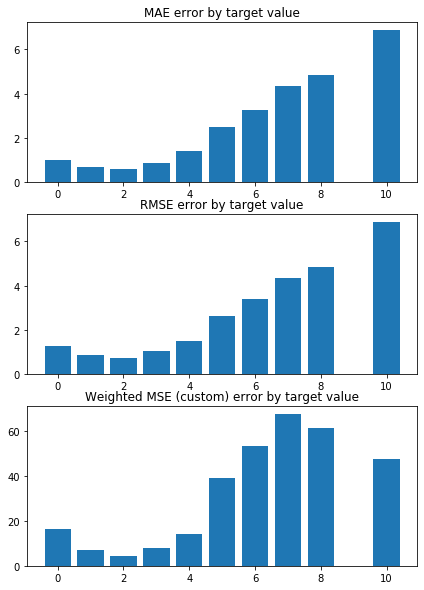

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9925009765799431 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1343038540022272 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


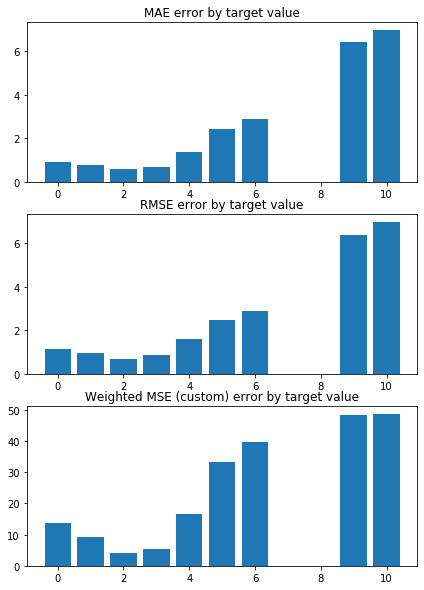

Weighted Mean squared error on Train: 1.12 
 MSE mean train: 2.705228431492707 

Mean squared error on Test: 1.12 
 MSE mean test:  2.7091509356520183 

Root of MSE on Test: 1.06 
 1.6459498581828118 

Variance score on Test: 0.07 
 r2_test: 0.2681420257463423 

wMSE_train 1.12
wMSE_test 1.12
MSE_train 2.71
MSE_test 2.71
MAE_train 1.08
MAE_test 1.02
r2_test 0.27
    H3K4me1     Chriz  H3K27me1     CP190  H3K36me3  H3K36me1  H3K27me3  \
0 -0.389471 -0.331746 -0.261808 -0.084490 -0.000000 -0.000000      -0.0   
1 -0.391228 -0.326833 -0.265055 -0.088704 -0.000000 -0.000000      -0.0   
2 -0.395781 -0.321371 -0.243672 -0.101452 -0.029535 -0.007977      -0.0   
3 -0.392571 -0.343175 -0.257534 -0.085145 -0.003019 -0.007419      -0.0   
4 -0.396995 -0.311377 -0.242053 -0.098813 -0.028608 -0.008520      -0.0   
5 -0.396585 -0.318655 -0.259100 -0.093081 -0.010259 -0.000000      -0.0   
6 -0.421706 -0.316600 -0.244974 -0.097281 -0.007753 -0.000000      -0.0   
7 -0.396684 -0.333482 -0.253658 -0.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


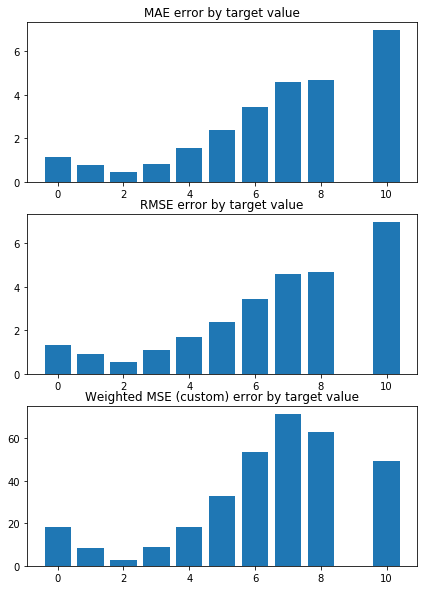

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.138466846838625 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1190063400406027 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


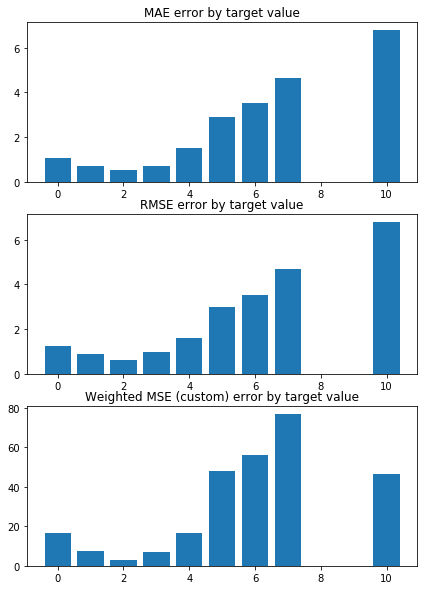

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0576132990225136 


 TRAIN PREDICTION Error
weighted_mse_train: 1.125935116334583 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


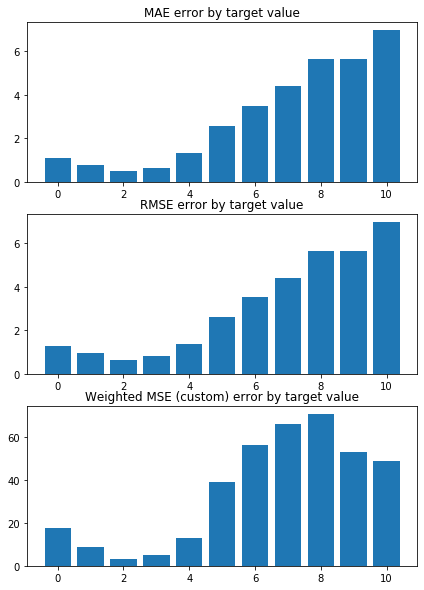

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0530511937953846 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1295747094390396 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


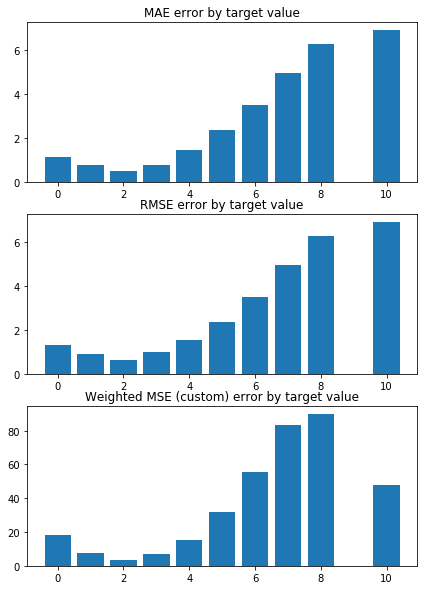

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.15461240814487 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1119658054201655 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


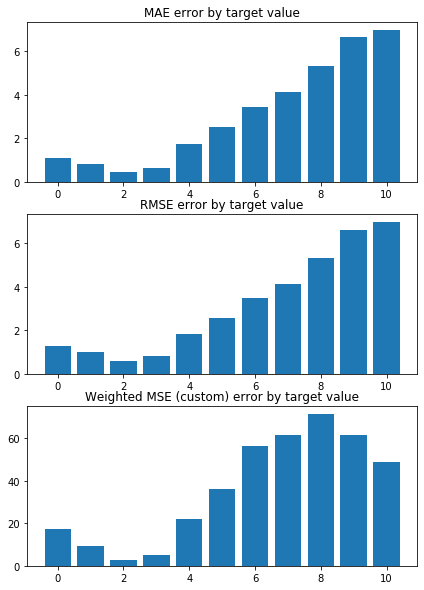

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.248523648938308 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1076033662672697 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


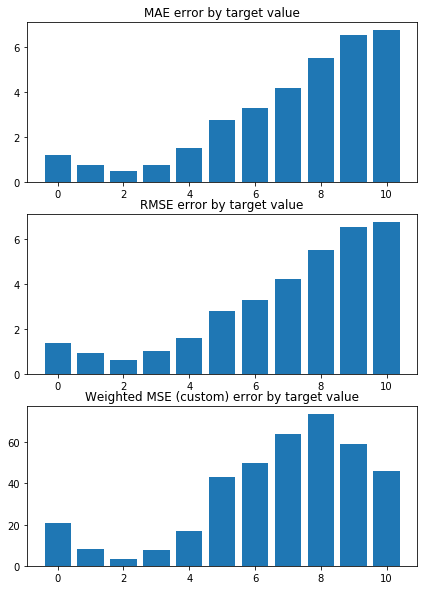

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1101301378493147 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1258726210136634 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


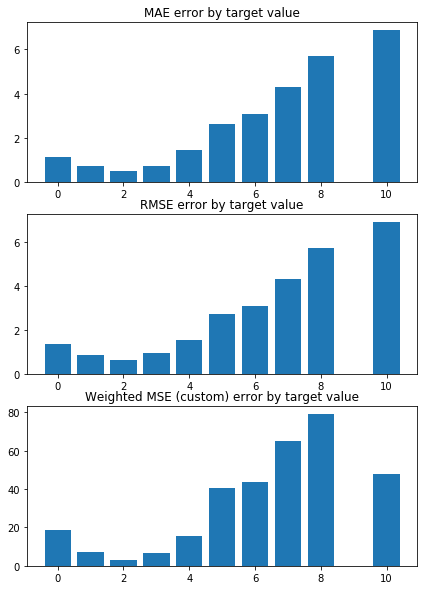

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1833544093501587 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1172404335431874 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


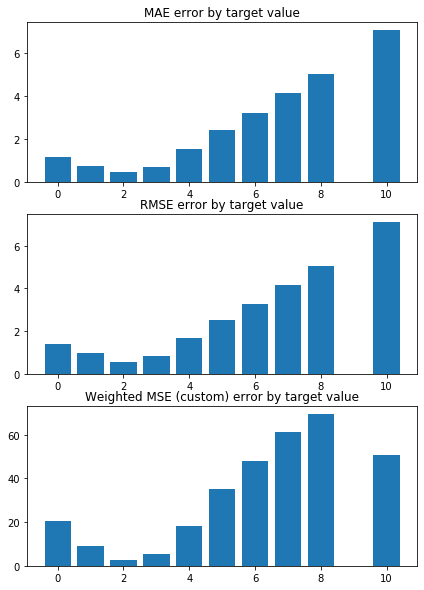

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0978353453869034 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1158538182432958 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


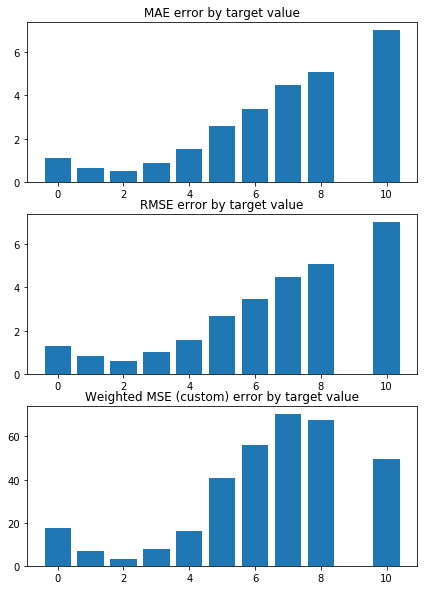

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9977430026762012 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1352960062487432 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


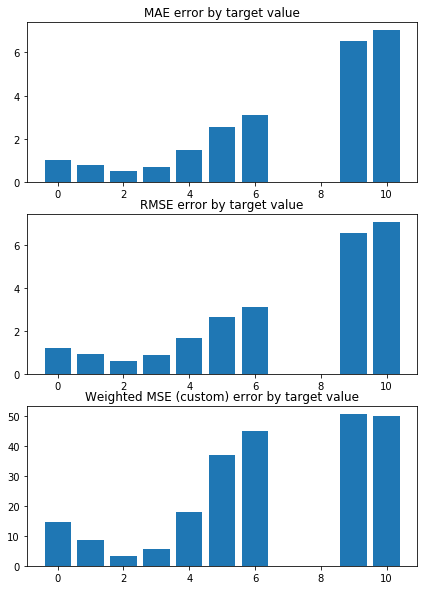

Weighted Mean squared error on Train: 1.12 
 MSE mean train: 2.7650665371933685 

Mean squared error on Test: 1.12 
 MSE mean test:  2.768351544324202 

Root of MSE on Test: 1.06 
 1.663836393496729 

Variance score on Test: 0.07 
 r2_test: 0.2523172405088584 

wMSE_train 1.12
wMSE_test 1.12
MSE_train 2.77
MSE_test 2.77
MAE_train 1.09
MAE_test 1.04
r2_test 0.25
    H3K4me1     Chriz  H3K27me1  H3K36me3  H3K36me1  H3K27me3  H3K27ac  \
0 -0.353755 -0.306708 -0.210808      -0.0      -0.0       0.0     -0.0   
1 -0.354375 -0.300893 -0.214026      -0.0      -0.0       0.0     -0.0   
2 -0.357213 -0.308323 -0.214941      -0.0      -0.0       0.0     -0.0   
3 -0.361839 -0.316662 -0.209853      -0.0      -0.0       0.0     -0.0   
4 -0.360059 -0.298617 -0.212771      -0.0      -0.0       0.0     -0.0   
5 -0.356867 -0.300828 -0.214321      -0.0      -0.0       0.0     -0.0   
6 -0.384182 -0.295716 -0.198391      -0.0      -0.0       0.0     -0.0   
7 -0.356358 -0.315794 -0.210503      -0.0   

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


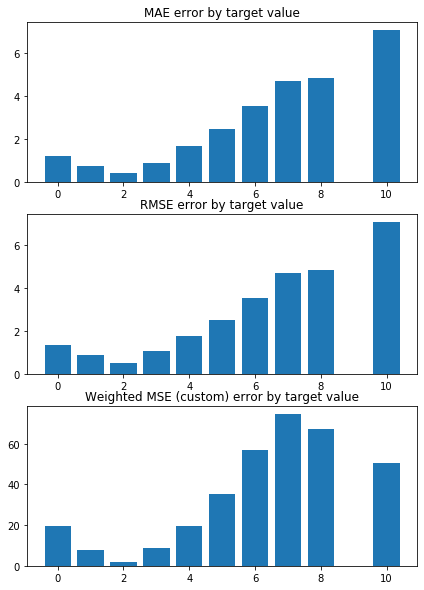

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1643991325685095 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1353054100771474 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


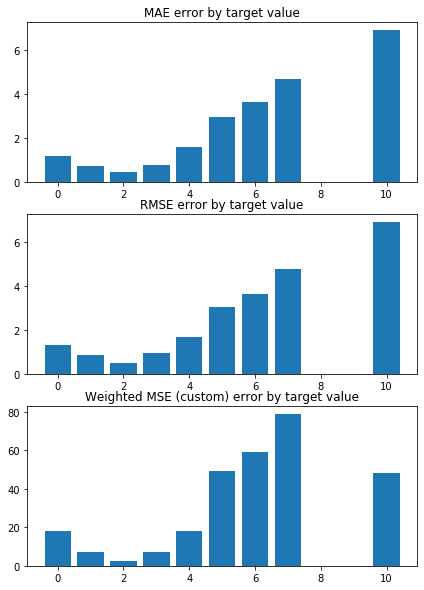

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0616459247861116 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1436412685512967 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


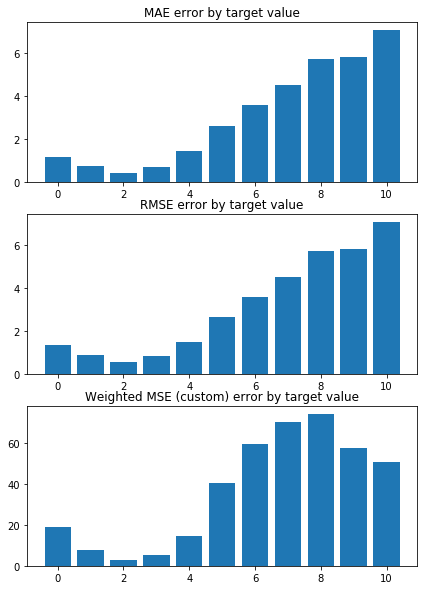

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.055278709714052 


 TRAIN PREDICTION Error
weighted_mse_train: 1.14366157525623 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


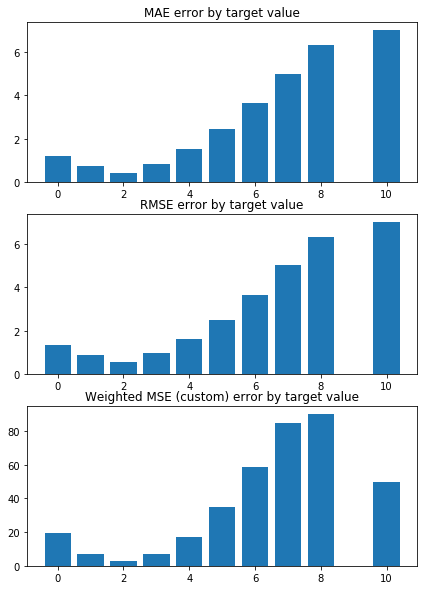

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.176517555783123 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1282377938784132 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


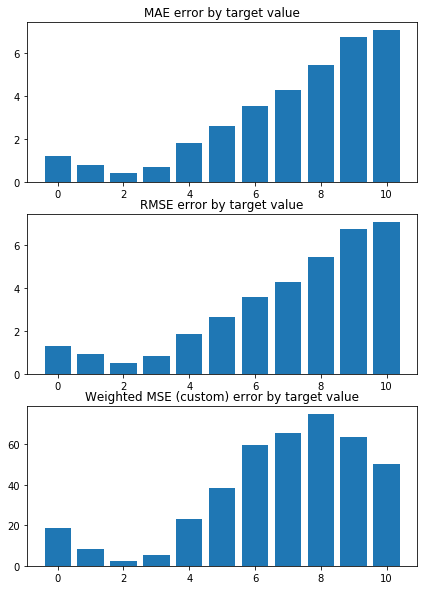

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.261349162920702 


 TRAIN PREDICTION Error
weighted_mse_train: 1.124684522630383 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


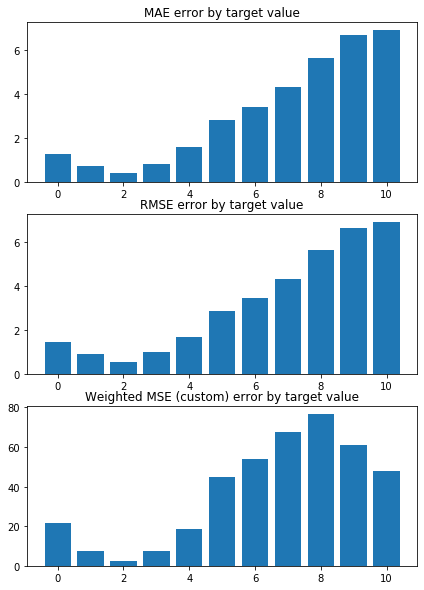

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1280157591476687 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1429660004793478 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


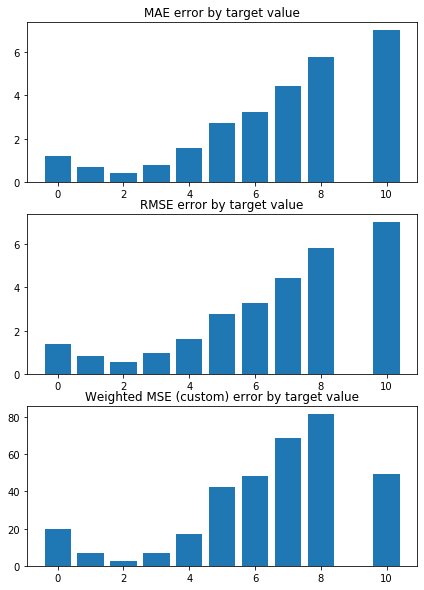

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1999530474208446 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1337793879755702 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


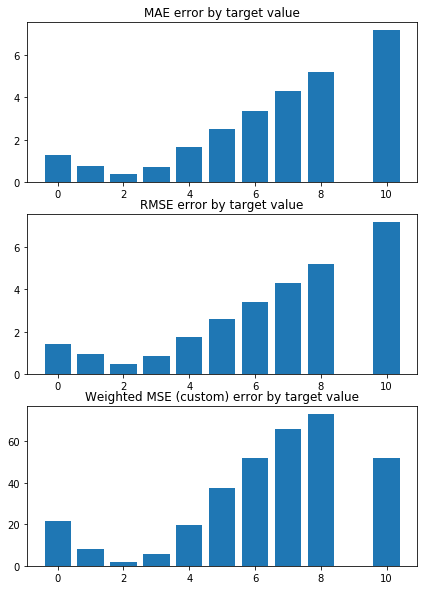

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.119400943575201 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1326570171531278 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


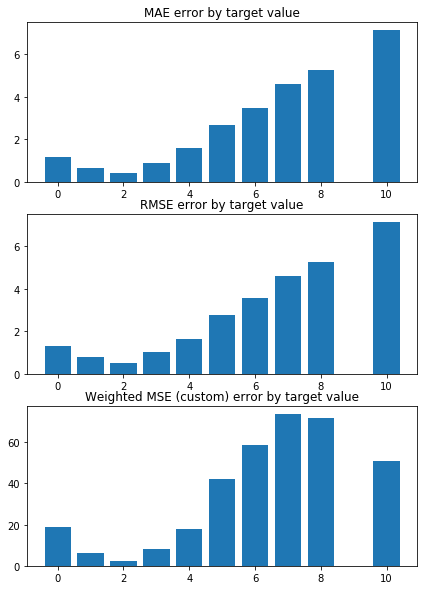

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0175160835613088 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1518075615420769 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


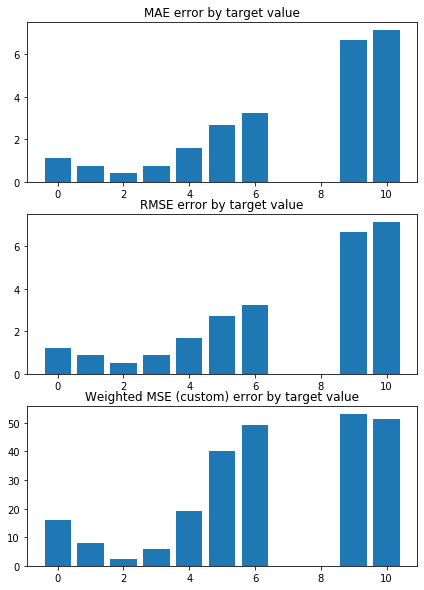

Weighted Mean squared error on Train: 1.14 
 MSE mean train: 2.833604218815184 

Mean squared error on Test: 1.14 
 MSE mean test:  2.836584372520492 

Root of MSE on Test: 1.07 
 1.6842162487401944 

Variance score on Test: 0.07 
 r2_test: 0.23399027349446744 

wMSE_train 1.14
wMSE_test 1.14
MSE_train 2.83
MSE_test 2.84
MAE_train 1.11
MAE_test 1.06
r2_test 0.23
    H3K4me1     Chriz  H3K27me1  H3K36me3  H3K36me1  H3K27me3  H3K27ac  \
0 -0.310082 -0.250506 -0.179301      -0.0      -0.0       0.0     -0.0   
1 -0.309625 -0.245588 -0.181822      -0.0      -0.0       0.0     -0.0   
2 -0.313591 -0.257847 -0.179568      -0.0      -0.0       0.0     -0.0   
3 -0.318683 -0.261870 -0.176887      -0.0      -0.0       0.0     -0.0   
4 -0.317171 -0.247261 -0.177924      -0.0      -0.0       0.0     -0.0   
5 -0.307451 -0.242046 -0.179235      -0.0      -0.0       0.0     -0.0   
6 -0.341248 -0.242584 -0.162403      -0.0      -0.0       0.0     -0.0   
7 -0.308112 -0.259050 -0.173573      -0.0  

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


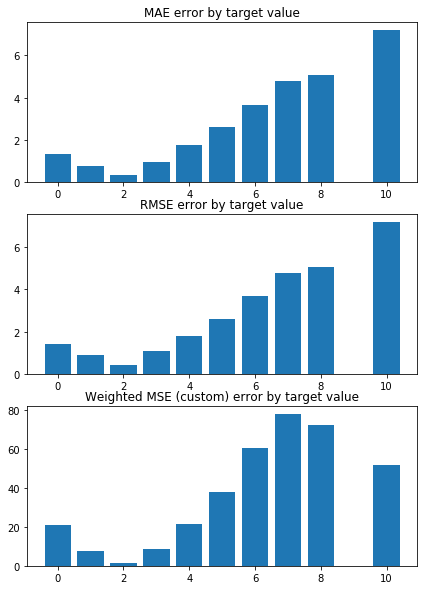

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2143765793019878 


 TRAIN PREDICTION Error
weighted_mse_train: 1.174409157479403 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


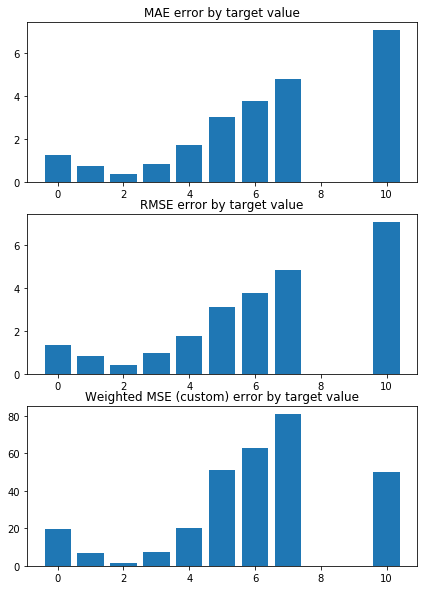

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0882974816120126 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1829679427146294 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


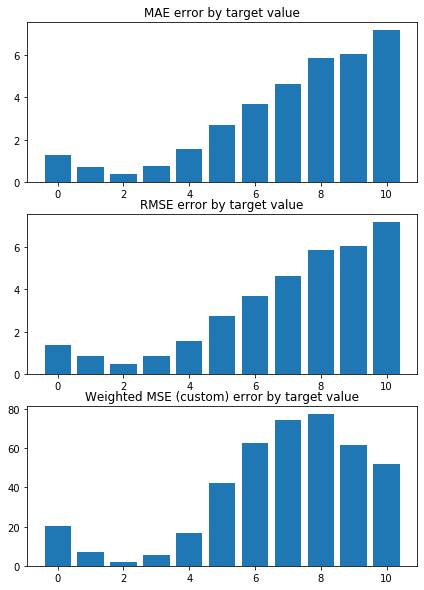

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0801488561224522 


 TRAIN PREDICTION Error
weighted_mse_train: 1.181510396536179 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


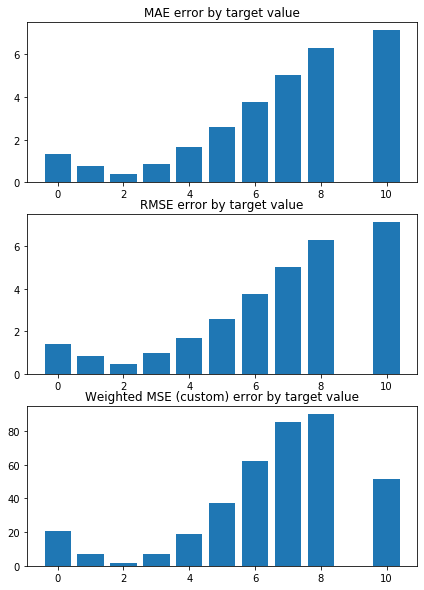

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2183034604953442 


 TRAIN PREDICTION Error
weighted_mse_train: 1.166331883406385 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


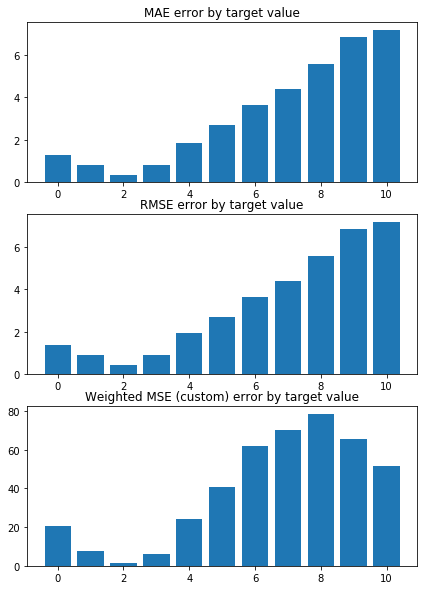

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.297620963114882 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1647306395904118 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


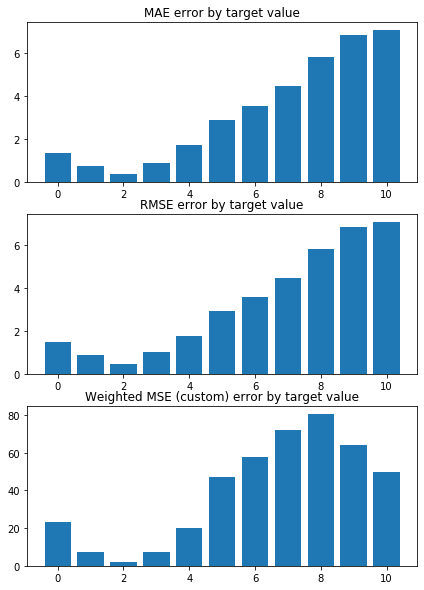

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1701593697284822 


 TRAIN PREDICTION Error
weighted_mse_train: 1.182070860762625 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


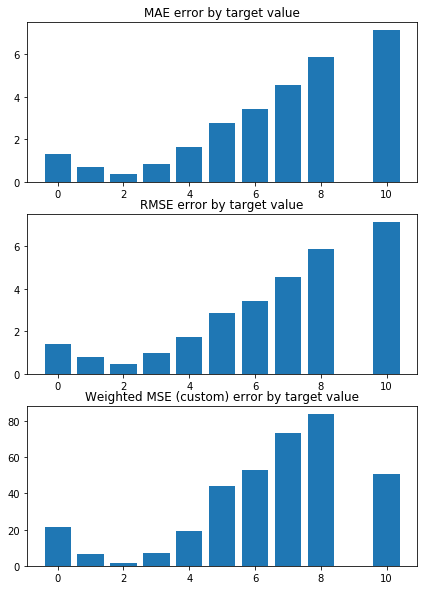

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.2405576136793668 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1721024464746457 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


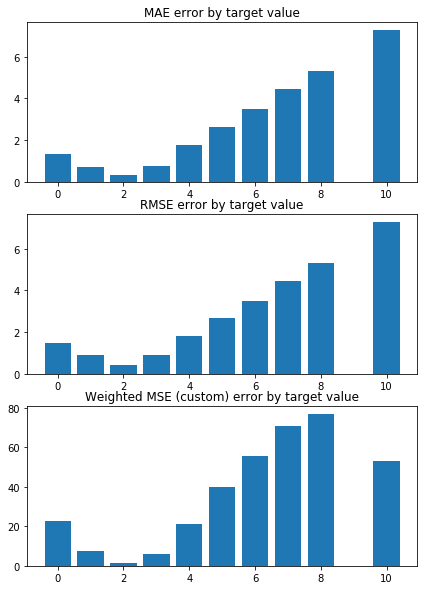

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1616735373910592 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1717910342257314 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


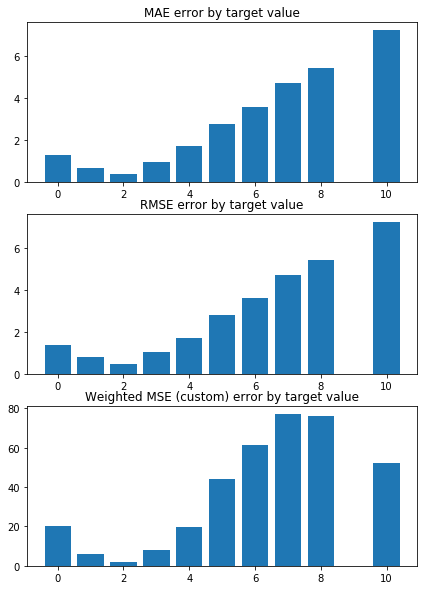

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0579899642596575 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1892525725291918 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


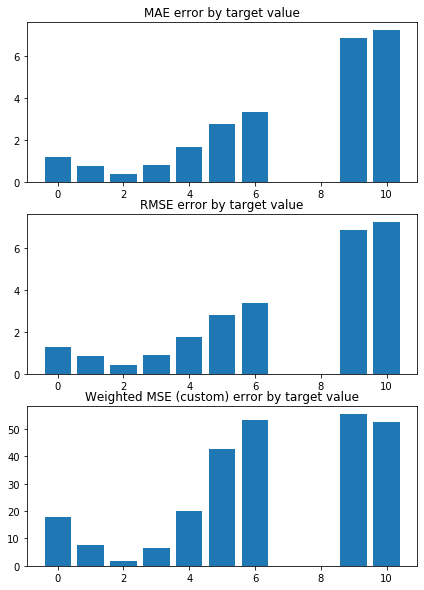

Weighted Mean squared error on Train: 1.18 
 MSE mean train: 2.930673671358488 

Mean squared error on Test: 1.18 
 MSE mean test:  2.9339959095920007 

Root of MSE on Test: 1.08 
 1.7128910968278166 

Variance score on Test: 0.08 
 r2_test: 0.2077517249320106 

wMSE_train 1.18
wMSE_test 1.18
MSE_train 2.93
MSE_test 2.93
MAE_train 1.14
MAE_test 1.09
r2_test 0.21
    H3K4me1     Chriz  H3K27me1   H3K4me2  H3K36me3  H3K36me1  H3K27me3  \
0 -0.222309 -0.151827 -0.139628 -0.087380      -0.0      -0.0       0.0   
1 -0.231721 -0.157448 -0.144349 -0.064919      -0.0      -0.0       0.0   
2 -0.228701 -0.163339 -0.139701 -0.079751      -0.0      -0.0       0.0   
3 -0.231992 -0.164628 -0.136245 -0.086322      -0.0      -0.0       0.0   
4 -0.236756 -0.156263 -0.138189 -0.073544      -0.0      -0.0       0.0   
5 -0.218481 -0.143248 -0.137872 -0.101682      -0.0      -0.0       0.0   
6 -0.253818 -0.142580 -0.120766 -0.091766      -0.0      -0.0       0.0   
7 -0.219911 -0.159730 -0.132238 -0.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


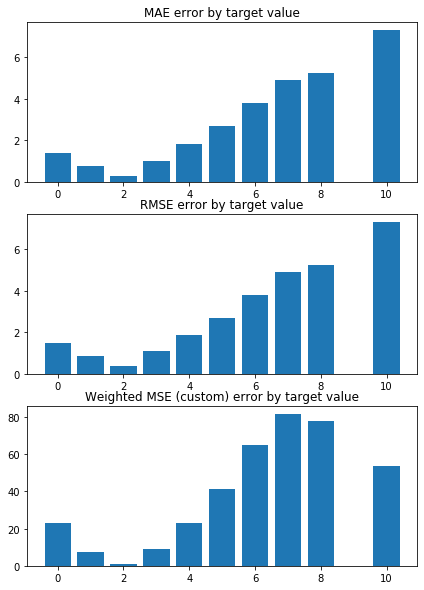

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2891578538753654 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2365765071164676 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


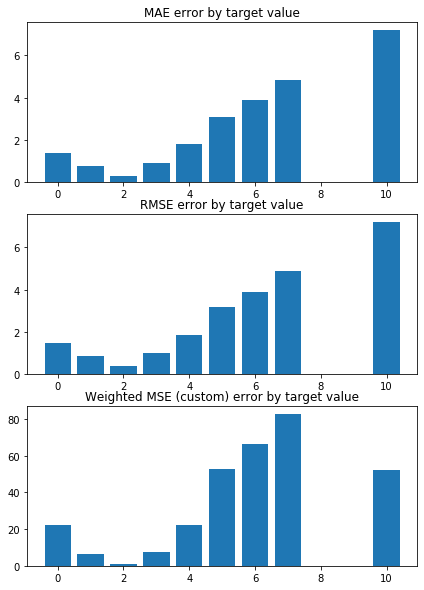

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1393812437602595 


 TRAIN PREDICTION Error
weighted_mse_train: 1.244893216792458 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


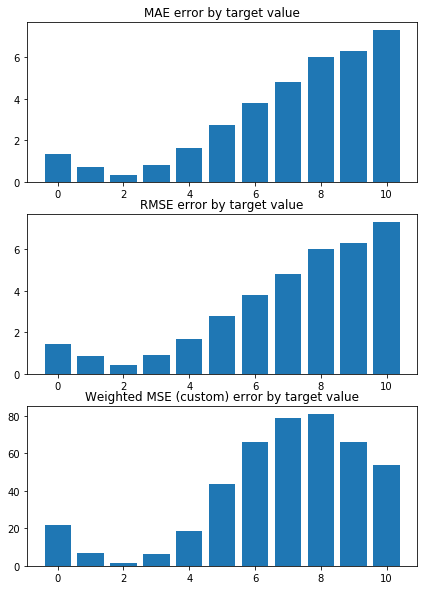

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1258814082239872 


 TRAIN PREDICTION Error
weighted_mse_train: 1.241549449560373 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


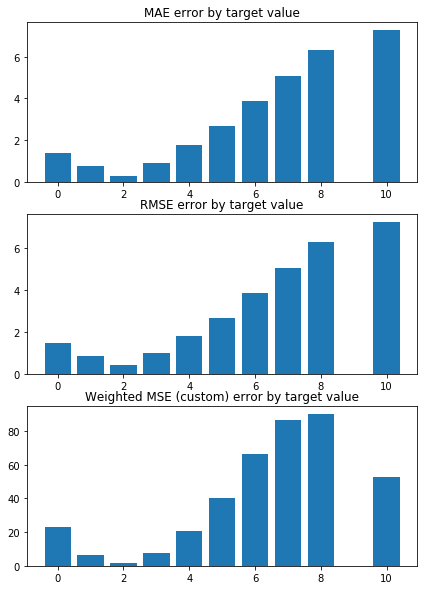

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2817264970139044 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2269512548323918 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


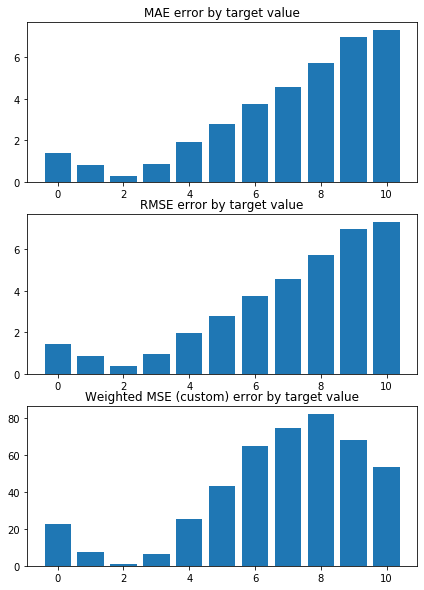

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.355555069805663 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2269812971929381 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


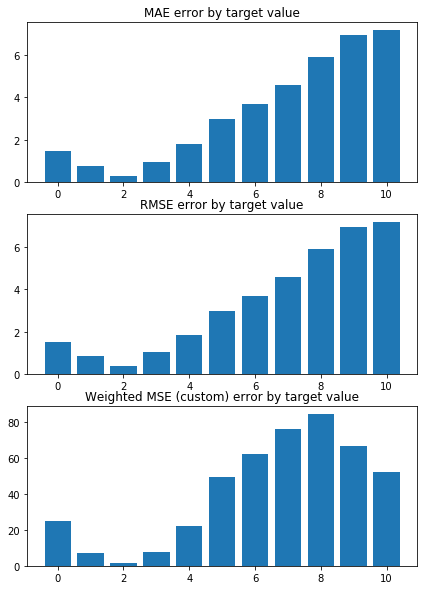

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2352861952151406 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2434347998574742 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


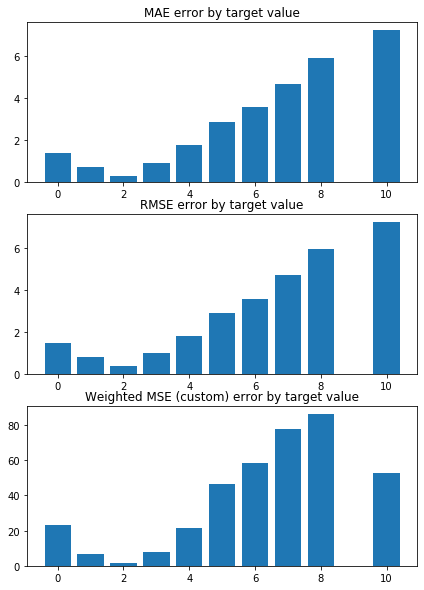

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.3042922576325353 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2326398899721986 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


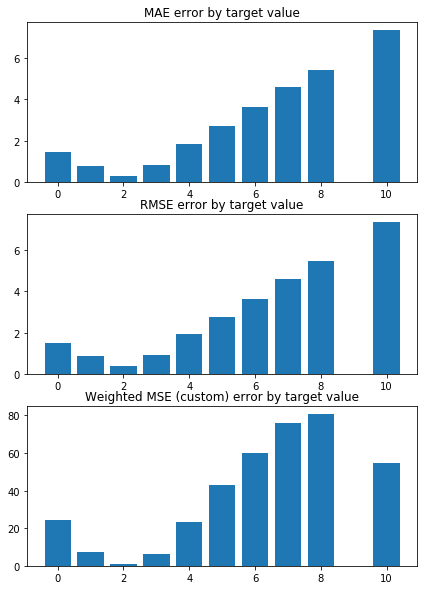

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2246497896916841 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2332642174428952 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


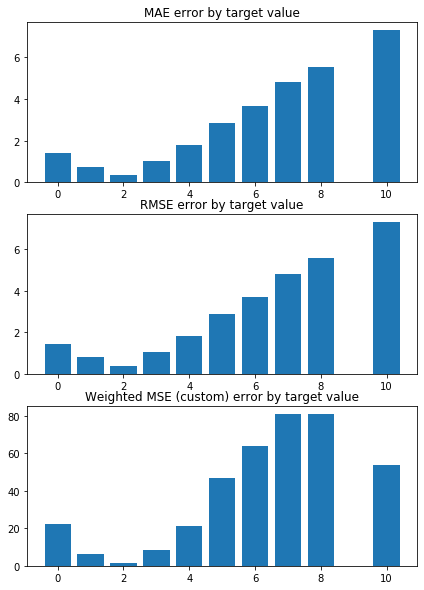

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1210153582938938 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2494974561814216 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


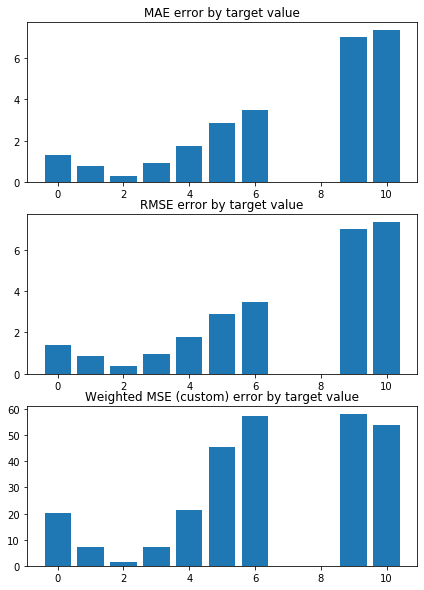

Weighted Mean squared error on Train: 1.24 
 MSE mean train: 3.056167568426407 

Mean squared error on Test: 1.24 
 MSE mean test:  3.0596345055962884 

Root of MSE on Test: 1.11 
 1.7491810957120157 

Variance score on Test: 0.08 
 r2_test: 0.1738605639266697 

wMSE_train 1.24
wMSE_test 1.24
MSE_train 3.06
MSE_test 3.06
MAE_train 1.18
MAE_test 1.13
r2_test 0.17
    H3K4me2   H3K4me1  H3K27me1     Chriz  H3K36me3  H3K36me1  H3K27me3  \
0 -0.176926 -0.133352 -0.099820 -0.052097      -0.0      -0.0       0.0   
1 -0.155393 -0.140765 -0.104554 -0.056943      -0.0      -0.0       0.0   
2 -0.170429 -0.138213 -0.098874 -0.063498      -0.0      -0.0       0.0   
3 -0.177526 -0.142736 -0.095246 -0.064987      -0.0      -0.0       0.0   
4 -0.163688 -0.147927 -0.096948 -0.057177      -0.0      -0.0       0.0   
5 -0.191824 -0.129224 -0.096596 -0.044283      -0.0      -0.0       0.0   
6 -0.181504 -0.166069 -0.079224 -0.042387      -0.0      -0.0       0.0   
7 -0.190187 -0.131447 -0.090984 -0.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


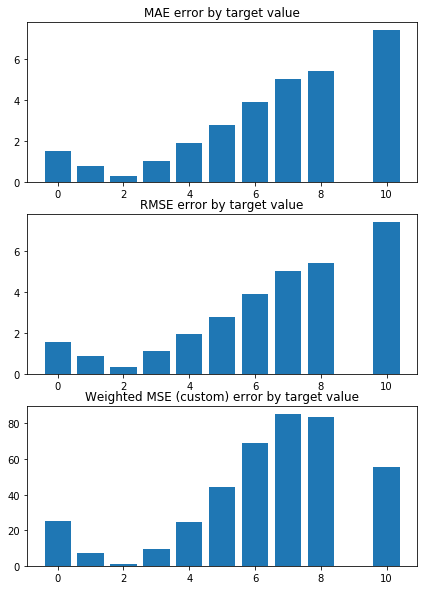

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3791012579755806 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3126996591822673 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


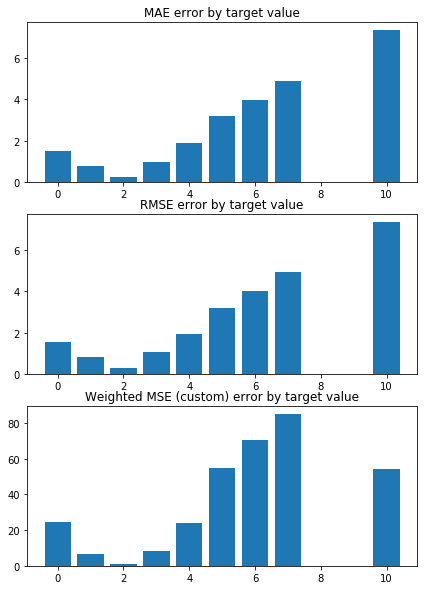

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.209567921574104 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3219303245572787 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


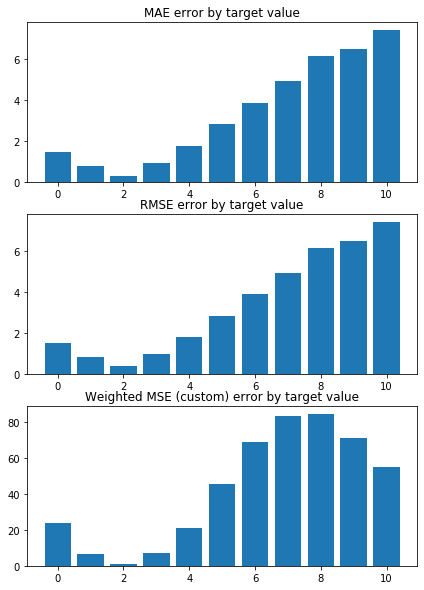

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1858216288358896 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3170507202235735 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


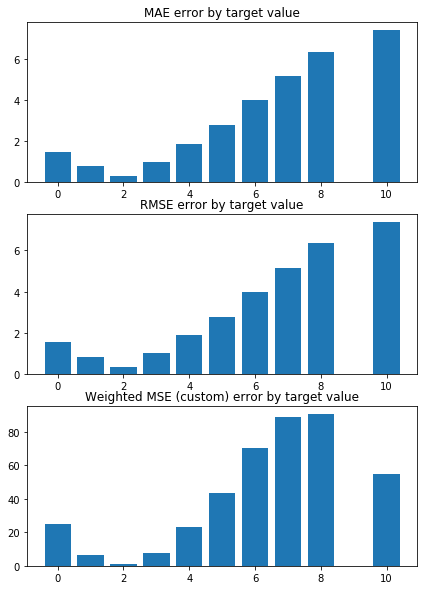

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.359623858417923 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3016330354836187 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


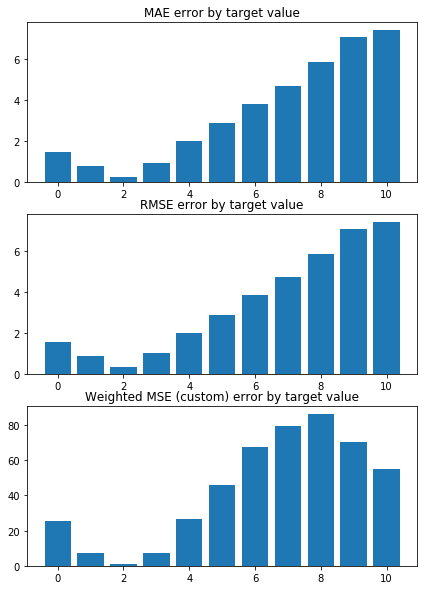

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.422981428998192 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3007608627556115 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


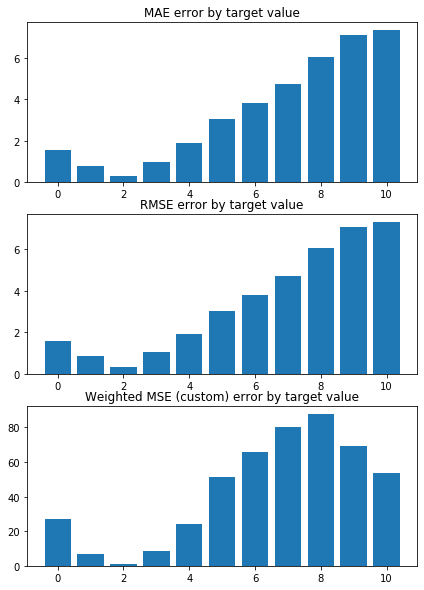

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3089447722564271 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3160237151572995 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


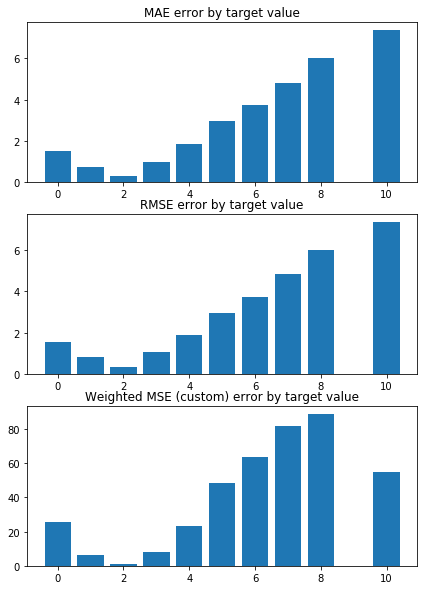

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.3839477096833532 


 TRAIN PREDICTION Error
weighted_mse_train: 1.307787119353173 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


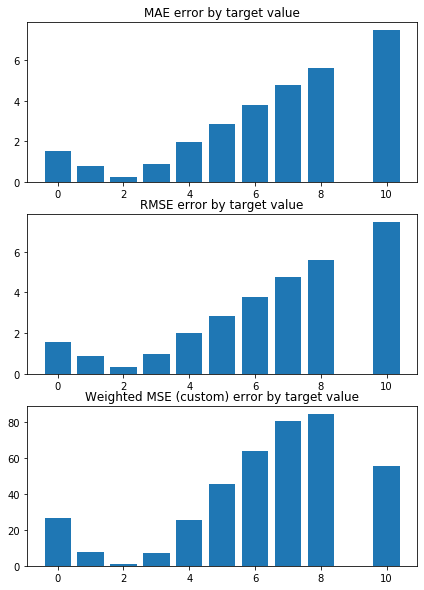

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2965698996645885 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3067514516385945 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


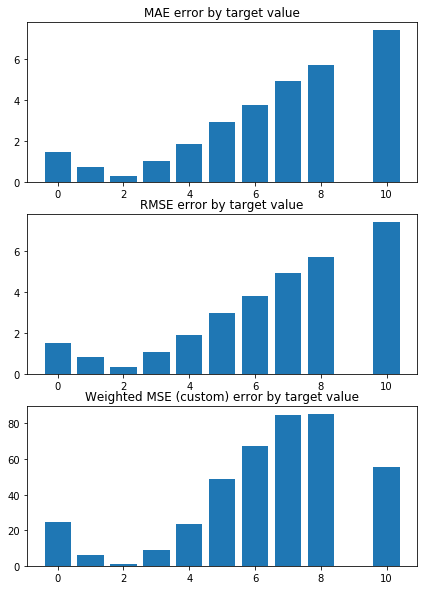

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.202359760670549 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3271814707877476 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


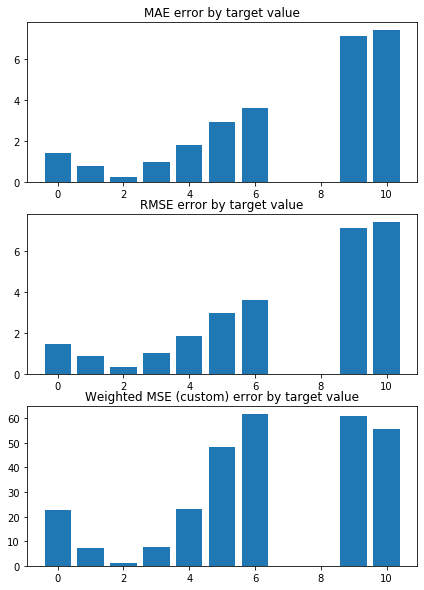

Weighted Mean squared error on Train: 1.31 
 MSE mean train: 3.197662185822201 

Mean squared error on Test: 1.31 
 MSE mean test:  3.200848077097713 

Root of MSE on Test: 1.15 
 1.7890914110513507 

Variance score on Test: 0.08 
 r2_test: 0.13572192308857062 

wMSE_train 1.31
wMSE_test 1.31
MSE_train 3.2
MSE_test 3.2
MAE_train 1.22
MAE_test 1.17
r2_test 0.14
    H3K4me2   H3K4me1  H3K27me1  Chriz  H3K36me3  H3K36me1  H3K27me3  H3K27ac  \
0 -0.207553 -0.069697 -0.057408   -0.0      -0.0      -0.0       0.0     -0.0   
1 -0.191986 -0.073039 -0.062339   -0.0      -0.0      -0.0       0.0     -0.0   
2 -0.216321 -0.066889 -0.056058   -0.0      -0.0      -0.0       0.0     -0.0   
3 -0.225621 -0.072015 -0.052344   -0.0      -0.0      -0.0       0.0     -0.0   
4 -0.201631 -0.081513 -0.053414   -0.0      -0.0      -0.0       0.0     -0.0   
5 -0.214403 -0.069111 -0.052159   -0.0      -0.0      -0.0       0.0     -0.0   
6 -0.200097 -0.108731 -0.034327   -0.0      -0.0      -0.0       0.0  

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


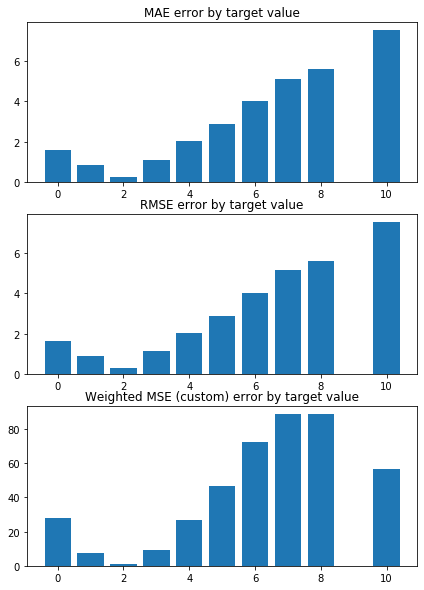

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4778727523372226 


 TRAIN PREDICTION Error
weighted_mse_train: 1.397396242332461 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


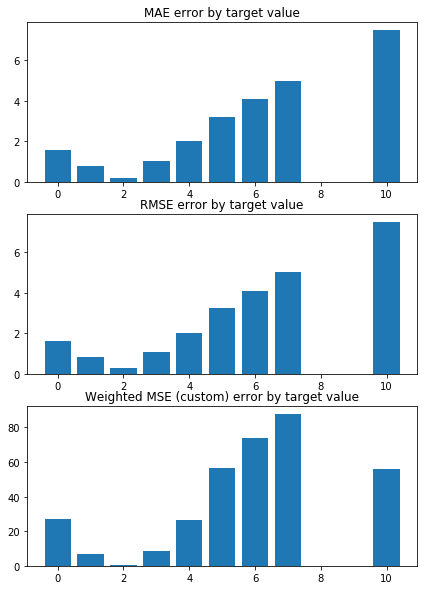

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2920231967686275 


 TRAIN PREDICTION Error
weighted_mse_train: 1.4060770269148934 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


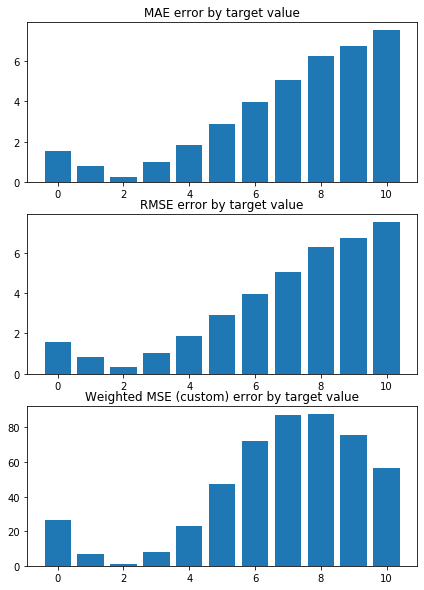

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2520433348621578 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3996802594624835 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


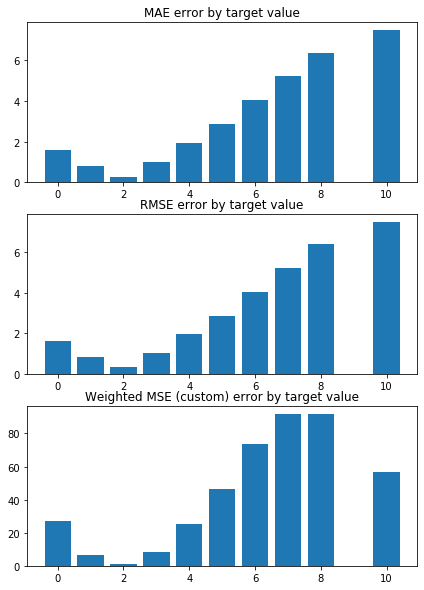

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4474021918823563 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3847925029342831 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


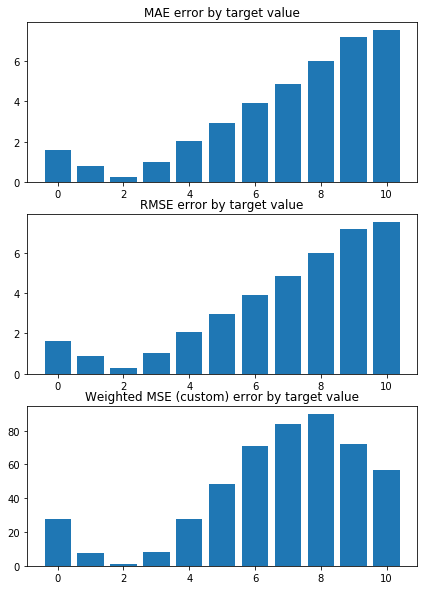

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.4992034987645333 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3851313685001871 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


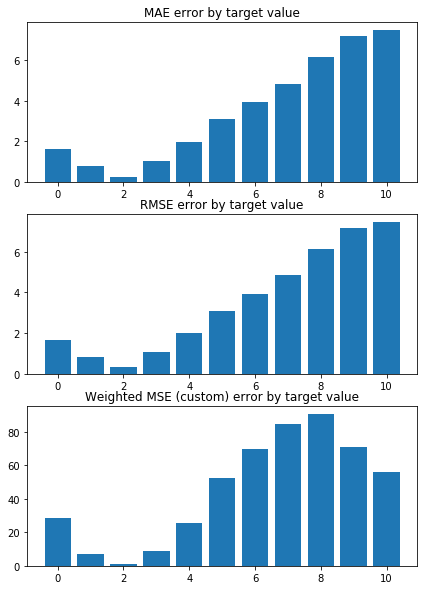

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3891884772520489 


 TRAIN PREDICTION Error
weighted_mse_train: 1.397898433924392 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


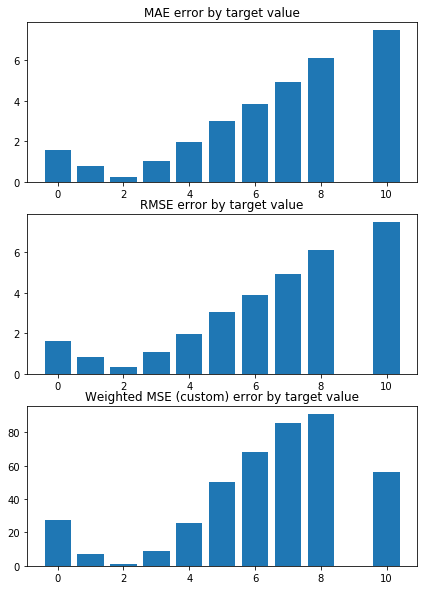

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.4728382191747327 


 TRAIN PREDICTION Error
weighted_mse_train: 1.390816270635422 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


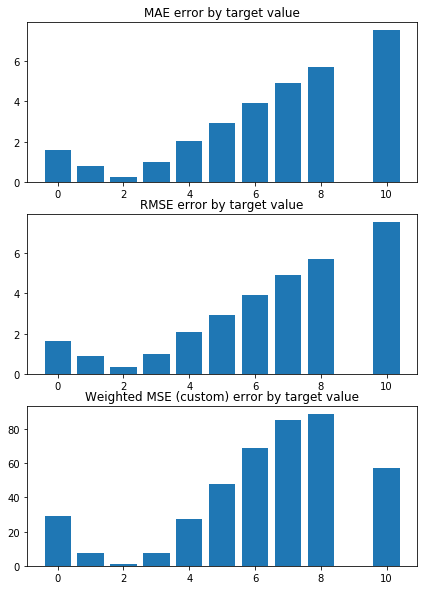

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3750294096228242 


 TRAIN PREDICTION Error
weighted_mse_train: 1.3900667969555853 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

alpha_grid = np.arange(0, 1, 0.1)
# Create linear regression object

model_name = 'LR+L1_grid0.1-1'
n_splits = 10
random_state = 16 
shuffle = True


wmse_test = []
wmse_train = []

for alpha in alpha_grid:
    model = linear_model.Lasso(alpha=alpha)

    lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                        weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                        rmse_test, rmse_train, rmse_test_const, \
                        mae_test,    mae_train,  mae_test_const, \
                        _ = train_test_KFold(X, y, model, model_name, results_pd,
                                             n_splits=n_splits, random_state=random_state, shuffle=shuffle)


    wmse_test.append(np.mean(weighted_mse_test_all))
    wmse_train.append(np.mean(weighted_mse_train_all))


In [ ]:
wmse_test

In [ ]:
plt.plot(alpha_grid, wmse_test)

In [ ]:
# Best alpha = 0.2

# L1 - best  score

In [ ]:
# L1 - best 
model = linear_model.Lasso(alpha=0.2)


model_name = 'LR+L1_alf=0.2_spt=10'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)

# wmse_test.append(np.mean(weighted_mse_test_all))
# wmse_train.append(np.mean(weighted_mse_train_all))
results_pd

In [ ]:
coefs_argsort, coefs

In [ ]:
su_drsc.columns[2:][coefs_argsort[0]]

In [ ]:
coefs_argsort[:]

In [ ]:

wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)

In [ ]:
su_drsc.columns[2:][coefs_argsort[0]], coefs

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS + L 1

Получили наиболее влияющие признаки

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Linear Regression with L2 regularization -  Ridge

In [ ]:
X, y = data_scaled_clean, target_clean.gamma
X_train, X_test, y_train, y_test = train_test_split(X[:], y[:], test_size=0.3, random_state=10)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# Create linear regression object
lin_reg_l2 = linear_model.Ridge()

# Train the model using the training sets
lin_reg_l2.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg_l2.predict(X_test)

Коэффициенты

In [ ]:
plt.scatter( np.arange(len(lin_reg_l2.coef_)) , lin_reg_l2.coef_)
plt.show()

In [ ]:
plt.hist(lin_reg_l2.coef_, bins=50)
plt.show()

In [ ]:
# Make predictions using the testing set
y_pred_train = lin_reg_l2.predict(X_train)
# The mean squared error
print("Mean squared error on Train: %.2f"
      % mean_squared_error(y_train, y_pred_train))

# The mean squared error
print("Mean squared error on Test: %.2f"
      % mean_squared_error(y_test, y_pred))


# The mean squared error
print("Root of Mean squared error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred)))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
axes[0].hist((y_train - y_pred_train), bins=50)
axes[1].hist(np.random.randn(4000), bins=50)

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K-fold cross Validation - RL + L2


## Fined parametrs for L2

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2937494123674373 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1149807646240517 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


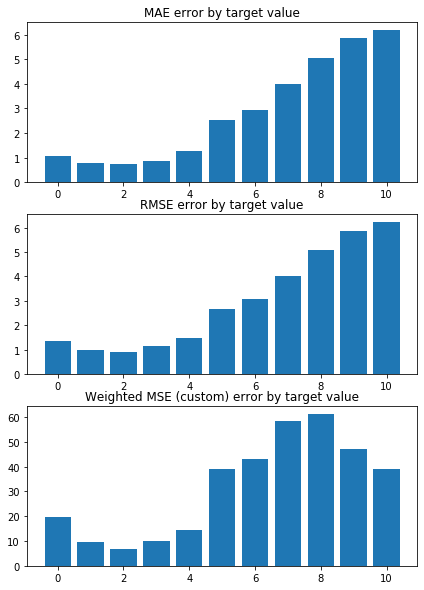

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0988091443077115 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1404596290031432 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


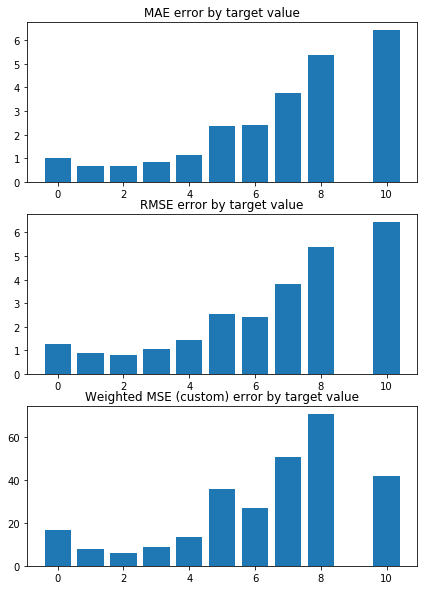

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.2067299462006866 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1324087755316212 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


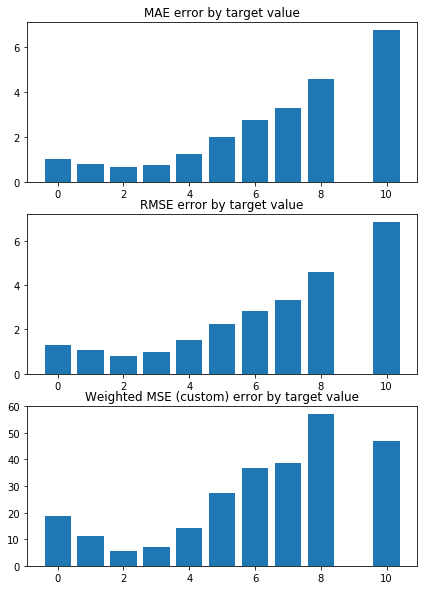

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.087074842016956 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1248763051082487 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


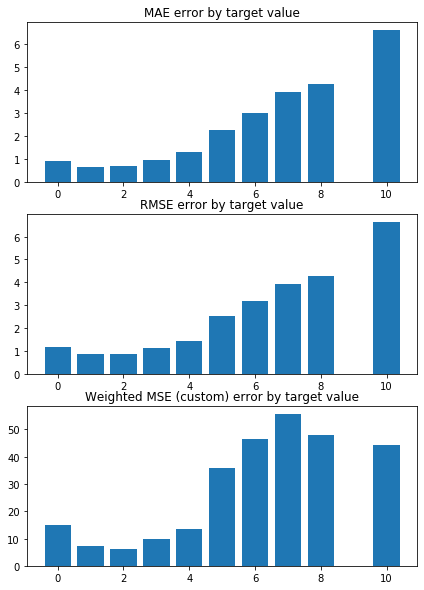

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0035291214264597 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1497033908826397 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


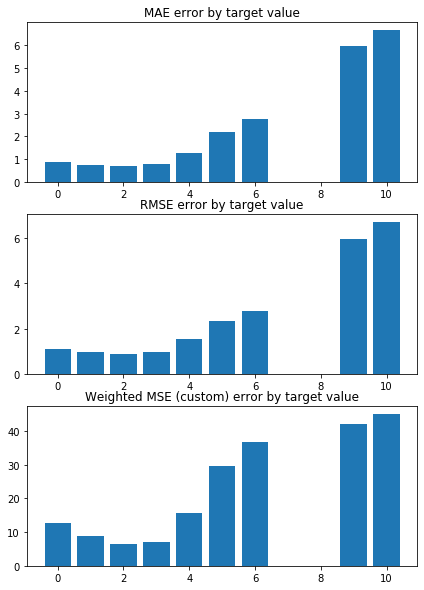

Weighted Mean squared error on Train: 1.13 
 MSE mean train: 2.6197019399893313 

Mean squared error on Test: 1.14 
 MSE mean test:  2.6339703729699693 

Root of MSE on Test: 1.07 
 1.6229511308015314 

Variance score on Test: 0.08 
 r2_test: 0.2882514726832932 

wMSE_train 1.13
wMSE_test 1.14
MSE_train 2.62
MSE_test 2.63
MAE_train 1.08
MAE_test 1.02
r2_test 0.29
      Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.317752 -0.293387 -0.277859 -0.271312 -0.270527 -0.257880 -0.247153   
1 -0.333081 -0.298593 -0.256945 -0.265269 -0.280362 -0.281775 -0.271587   
2 -0.338739 -0.336944 -0.268760 -0.242039 -0.307991 -0.333942 -0.241379   
3 -0.344121 -0.316233 -0.264192 -0.245437 -0.304217 -0.293021 -0.235324   
4 -0.307712 -0.330554 -0.291955 -0.225578 -0.314023 -0.335949 -0.239542   
5 -0.283313 -0.304999 -0.282444 -0.251773 -0.292308 -0.292693 -0.234437   
6 -0.305750 -0.298848 -0.267963 -0.253893 -0.262552 -0.279006 -0.294681   
7 -0.297658 -0.313440 -0.286028 -0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


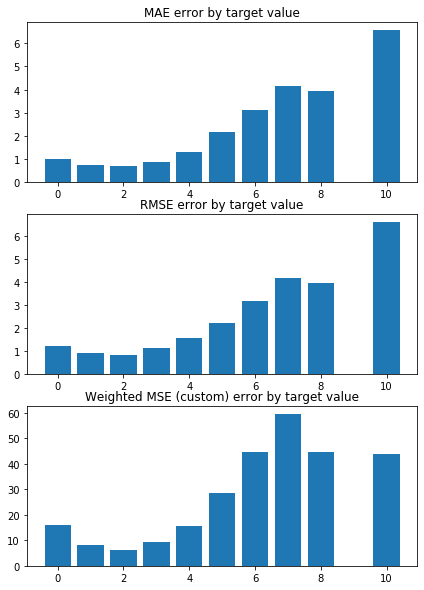

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1289091320509004 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1303776438940774 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


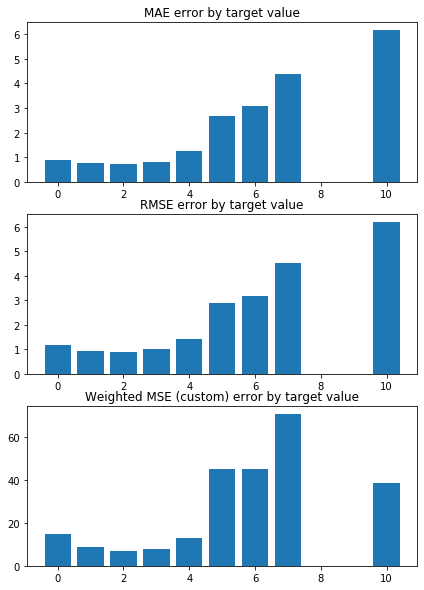

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1466807500672673 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1363958703066364 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


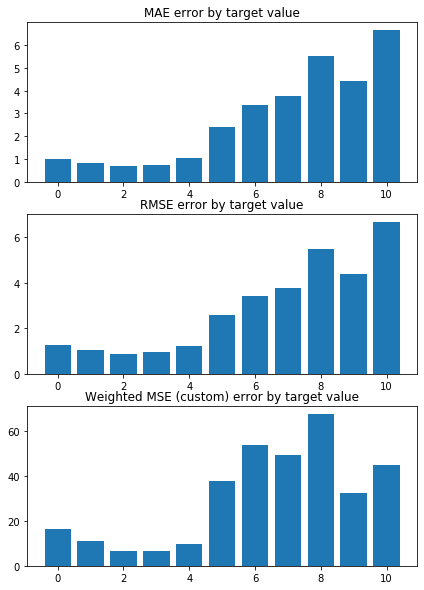

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0900619392132678 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1411166287486918 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


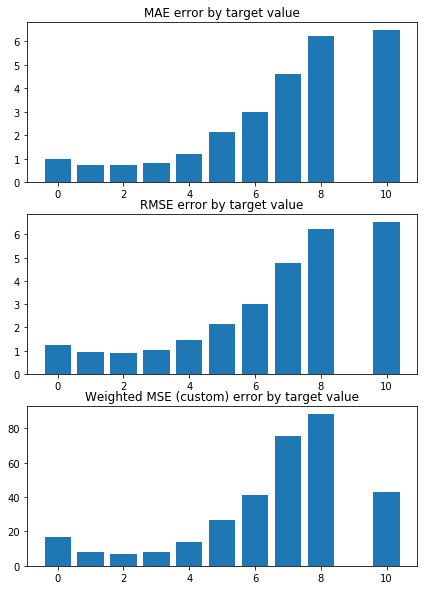

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1897578292773912 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1227883188873642 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


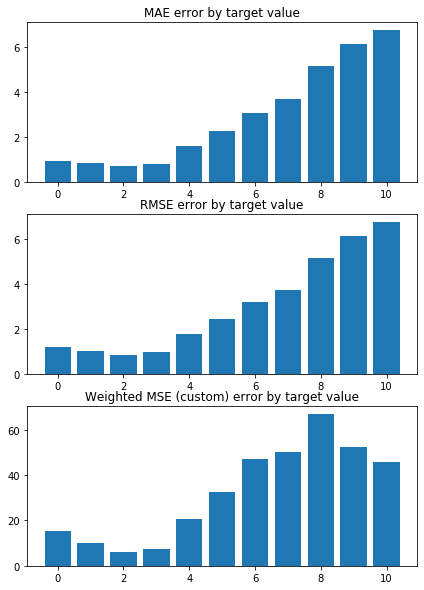

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2937226278631202 


 TRAIN PREDICTION Error
weighted_mse_train: 1.114938656799859 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


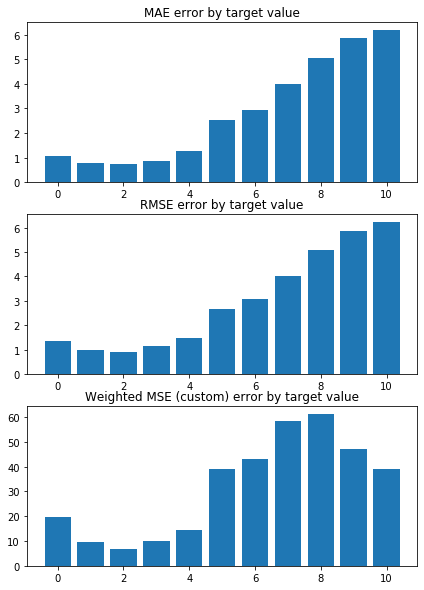

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0987870744605865 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1404132832419125 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


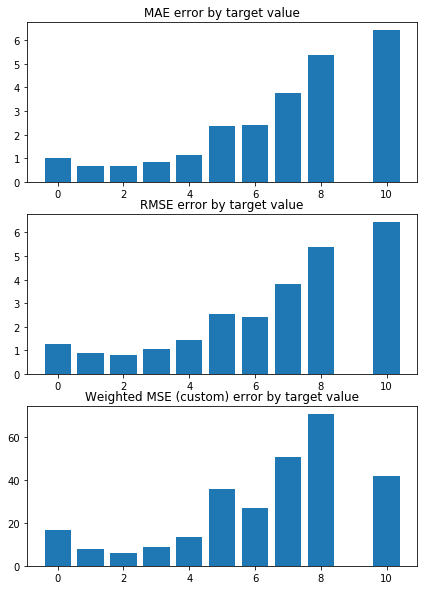

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.2066607660076412 


 TRAIN PREDICTION Error
weighted_mse_train: 1.132365759089213 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


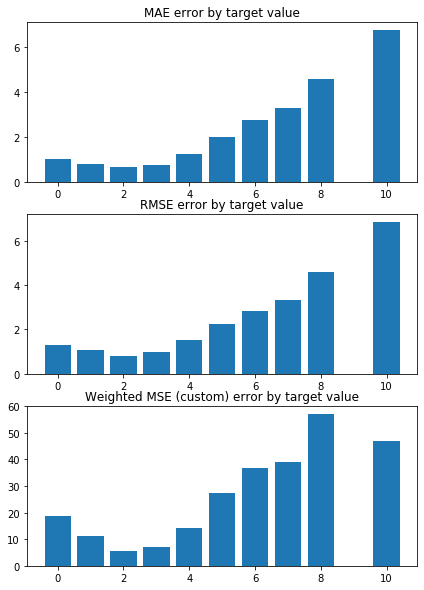

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.087045152867403 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1248373486383703 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


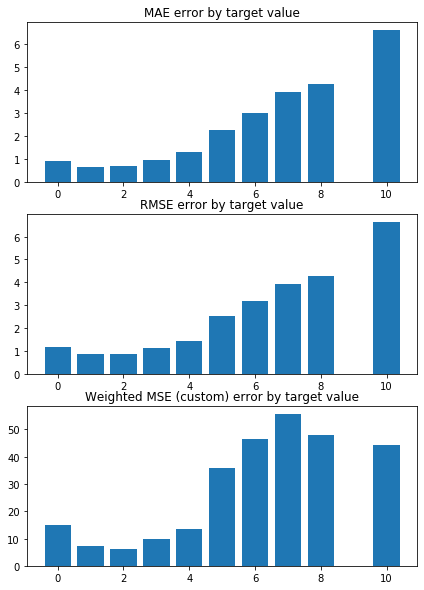

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0034954704901193 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1496556339744137 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


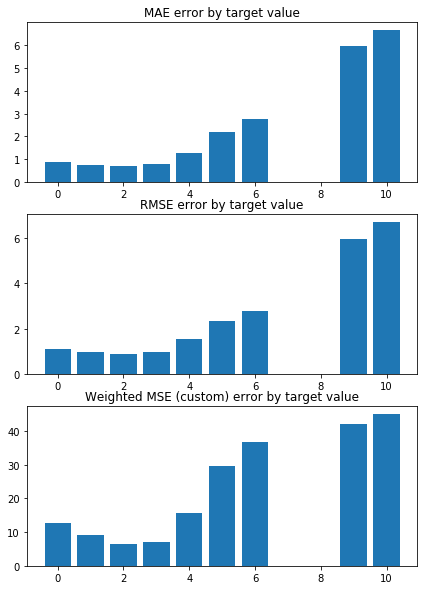

Weighted Mean squared error on Train: 1.13 
 MSE mean train: 2.619702588439278 

Mean squared error on Test: 1.14 
 MSE mean test:  2.63395166784834 

Root of MSE on Test: 1.07 
 1.6229453681034183 

Variance score on Test: 0.08 
 r2_test: 0.28825674803275125 

wMSE_train 1.13
wMSE_test 1.14
MSE_train 2.62
MSE_test 2.63
MAE_train 1.08
MAE_test 1.02
r2_test 0.29
      Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.317122 -0.293051 -0.277862 -0.271266 -0.270371 -0.257604 -0.246837   
1 -0.332386 -0.298240 -0.256975 -0.265260 -0.280193 -0.281437 -0.271176   
2 -0.338077 -0.336549 -0.268780 -0.242103 -0.307751 -0.333509 -0.241163   
3 -0.343430 -0.315869 -0.264210 -0.245458 -0.303998 -0.292668 -0.235111   
4 -0.307080 -0.330158 -0.291955 -0.225698 -0.313761 -0.335433 -0.239267   
5 -0.282826 -0.304655 -0.282430 -0.251784 -0.292103 -0.292358 -0.234205   
6 -0.305194 -0.298530 -0.267969 -0.253871 -0.262409 -0.278747 -0.294333   
7 -0.297095 -0.313073 -0.286028 -0.2

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


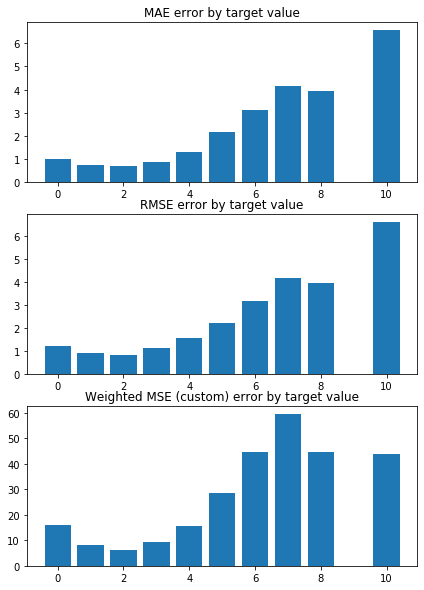

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1288475789110128 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1303347709889726 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


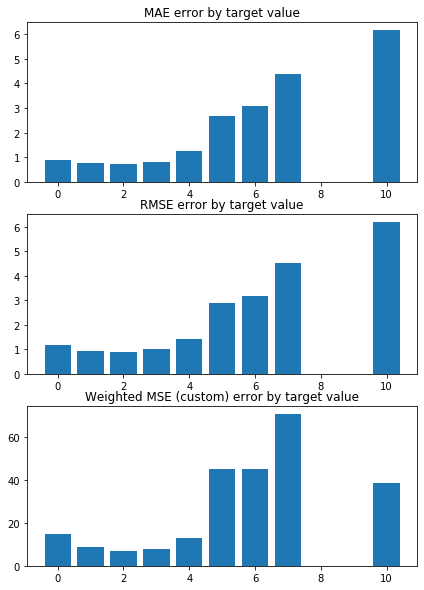

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1465831637726984 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1363473628859913 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


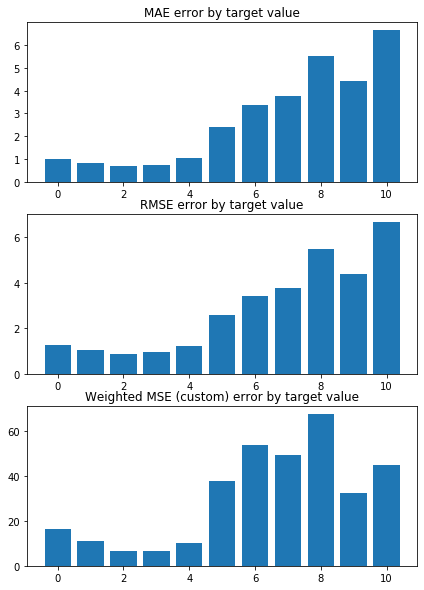

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0900117183107285 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1410717867684879 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


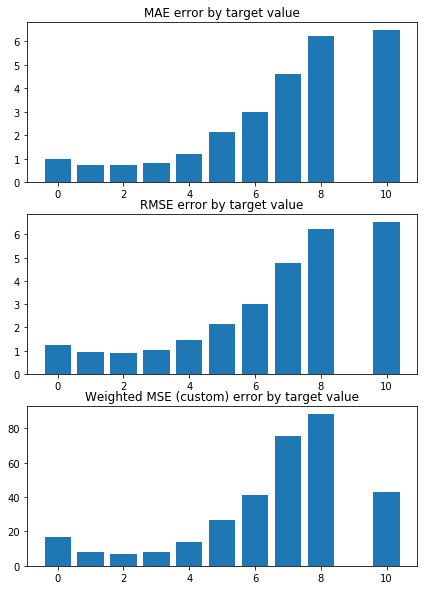

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1896335824442021 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1227432863720836 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


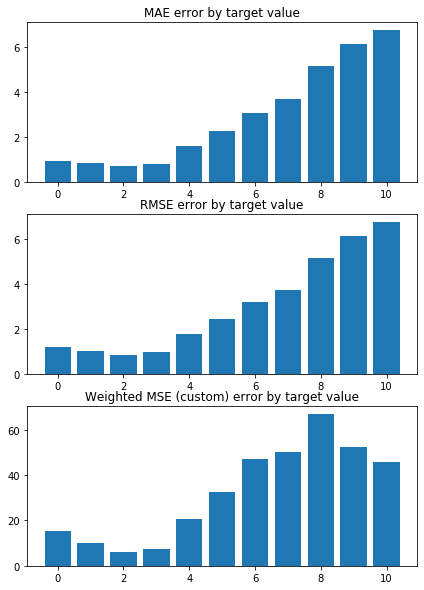

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2936956842811727 


 TRAIN PREDICTION Error
weighted_mse_train: 1.114896684189546 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


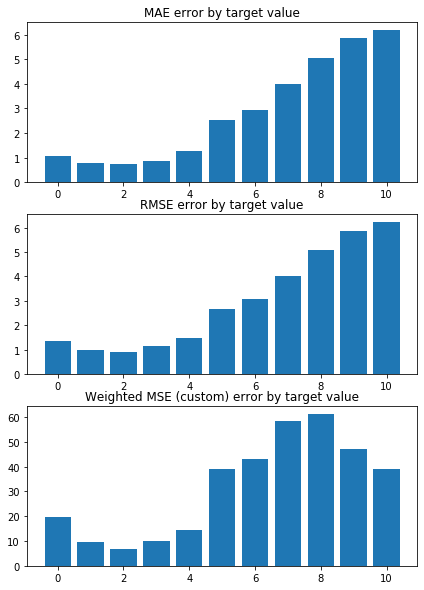

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0987649508663295 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1403670995011366 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


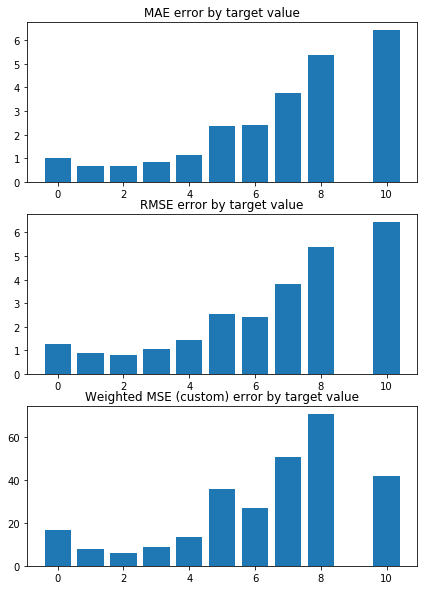

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.2065922285735455 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1323229253233373 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


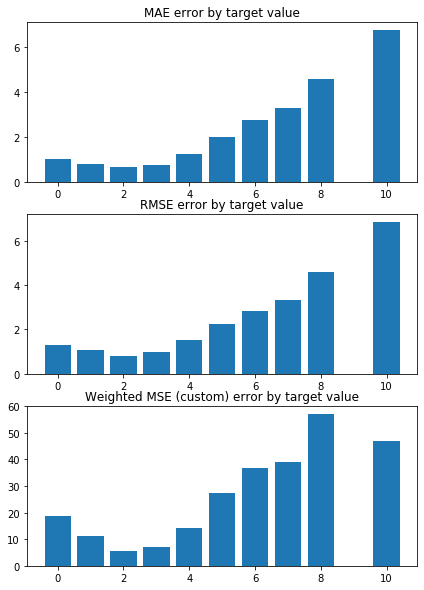

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0870156512522788 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1247985368193592 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


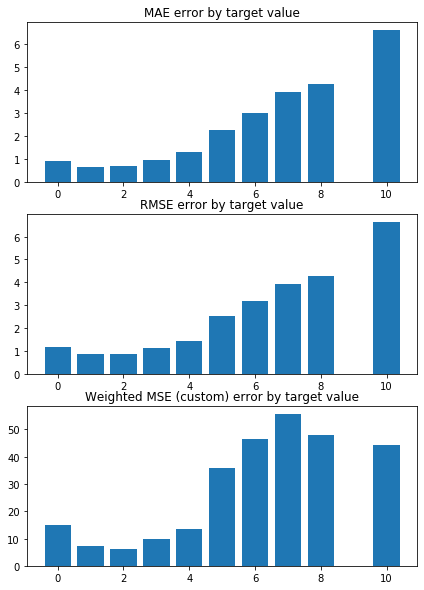

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0034618883435542 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1496081046896613 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


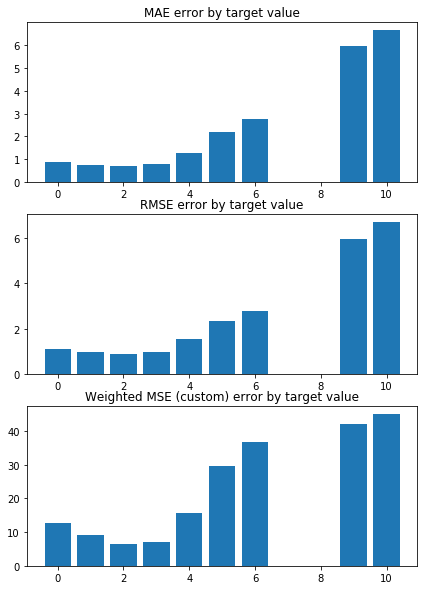

Weighted Mean squared error on Train: 1.13 
 MSE mean train: 2.6197034860899544 

Mean squared error on Test: 1.14 
 MSE mean test:  2.6339333488005945 

Root of MSE on Test: 1.07 
 1.622939724327615 

Variance score on Test: 0.08 
 r2_test: 0.288261918687796 

wMSE_train 1.13
wMSE_test 1.14
MSE_train 2.62
MSE_test 2.63
MAE_train 1.08
MAE_test 1.02
r2_test 0.29
      Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.316497 -0.292717 -0.277865 -0.271218 -0.270216 -0.257330 -0.246525   
1 -0.331698 -0.297889 -0.257004 -0.265250 -0.280024 -0.281102 -0.270770   
2 -0.337419 -0.336155 -0.268799 -0.242166 -0.307513 -0.333078 -0.240949   
3 -0.342745 -0.315507 -0.264227 -0.245478 -0.303780 -0.292318 -0.234901   
4 -0.306454 -0.329764 -0.291953 -0.225816 -0.313501 -0.334922 -0.238995   
5 -0.282343 -0.304312 -0.282416 -0.251794 -0.291898 -0.292025 -0.233976   
6 -0.304643 -0.298213 -0.267975 -0.253849 -0.262266 -0.278489 -0.293988   
7 -0.296537 -0.312708 -0.286026 -0.2

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


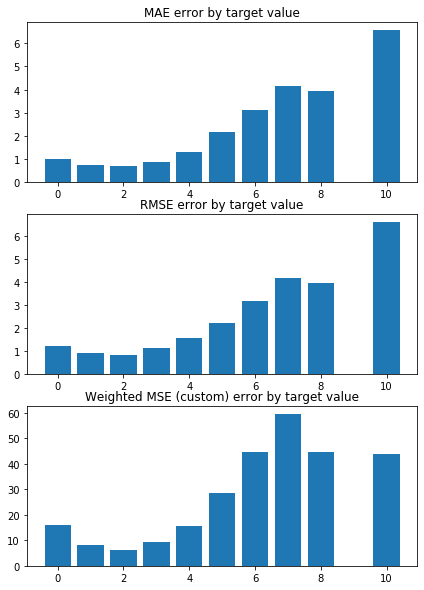

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1287865153390426 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1302921288723518 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


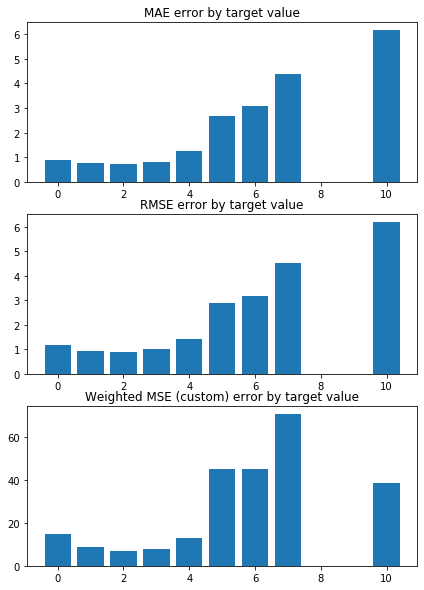

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1464857099896841 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1362990621108842 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


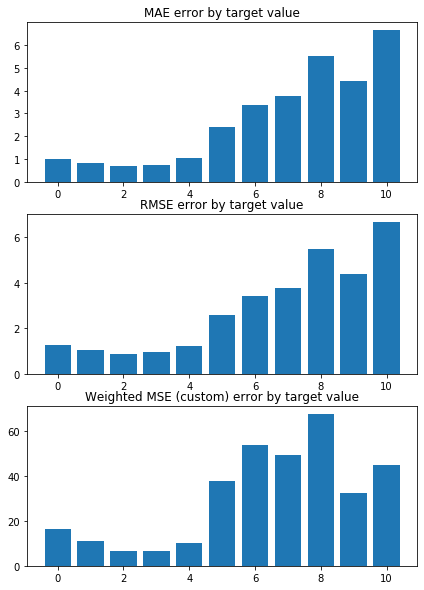

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0899615611354017 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1410271258105105 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


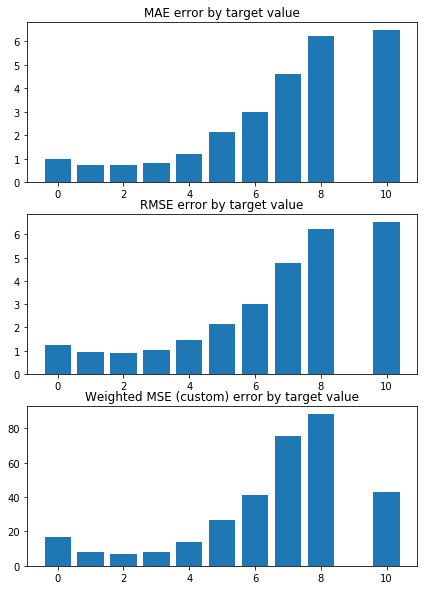

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.189510330197334 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1226984533686823 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


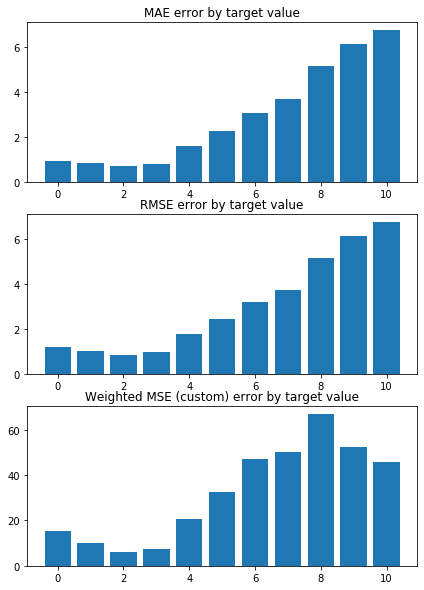

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.293668585308461 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1148548450720976 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


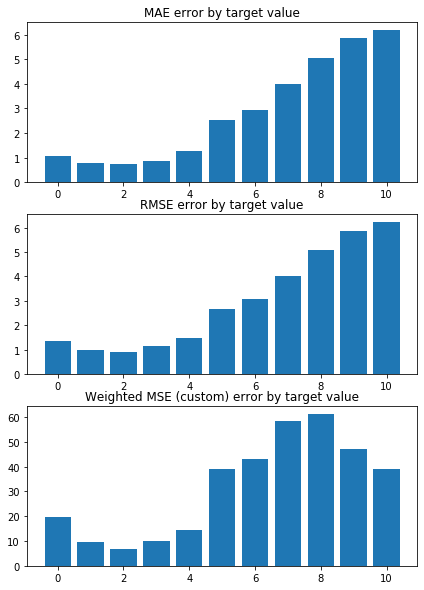

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.098742775946335 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1403210758636773 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


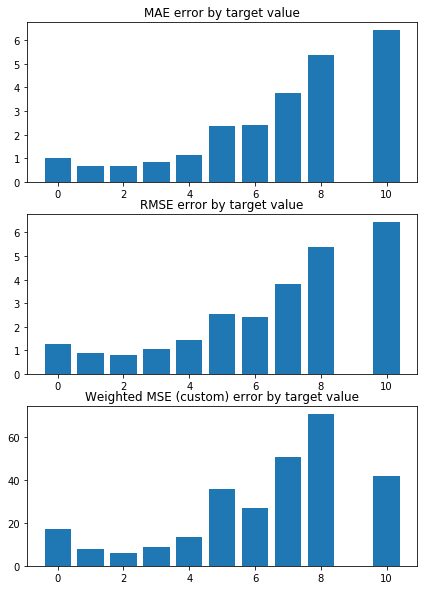

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.2065243203872884 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1322802703764283 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


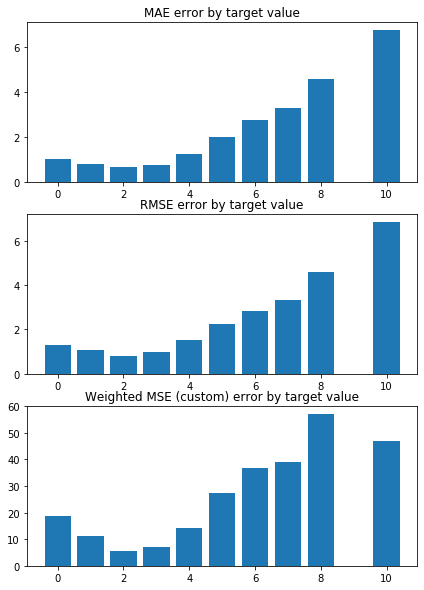

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.086986333513872 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1247598671480608 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


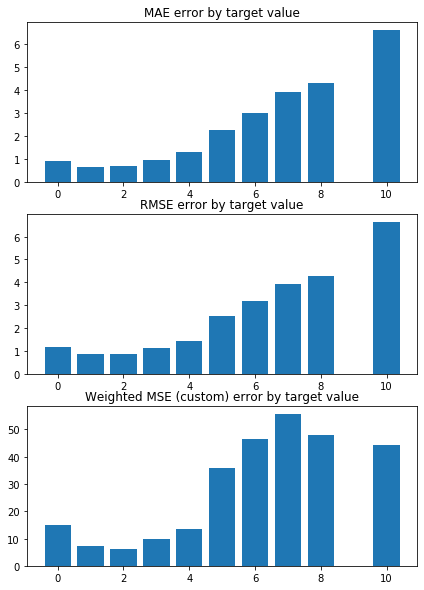

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.003428372823262 


 TRAIN PREDICTION Error
weighted_mse_train: 1.149560798516658 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


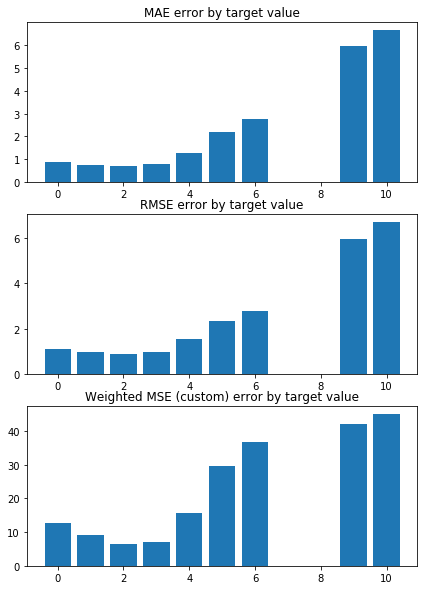

Weighted Mean squared error on Train: 1.13 
 MSE mean train: 2.6197046273612363 

Mean squared error on Test: 1.14 
 MSE mean test:  2.633915408167563 

Root of MSE on Test: 1.07 
 1.622934197115694 

Variance score on Test: 0.08 
 r2_test: 0.28826698671639794 

wMSE_train 1.13
wMSE_test 1.14
MSE_train 2.62
MSE_test 2.63
MAE_train 1.08
MAE_test 1.02
r2_test 0.29
      Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.315879 -0.292384 -0.277866 -0.271170 -0.270061 -0.257058 -0.246216   
1 -0.331015 -0.297540 -0.257032 -0.265239 -0.279855 -0.280771 -0.270369   
2 -0.336767 -0.335763 -0.268817 -0.242228 -0.307275 -0.332651 -0.240738   
3 -0.342065 -0.315145 -0.264244 -0.245496 -0.303562 -0.291970 -0.234693   
4 -0.305833 -0.329371 -0.291951 -0.225932 -0.313241 -0.334414 -0.238728   
5 -0.281864 -0.303970 -0.282401 -0.251803 -0.291693 -0.291695 -0.233750   
6 -0.304095 -0.297898 -0.267979 -0.253827 -0.262122 -0.278233 -0.293646   
7 -0.295985 -0.312344 -0.286024 -0.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


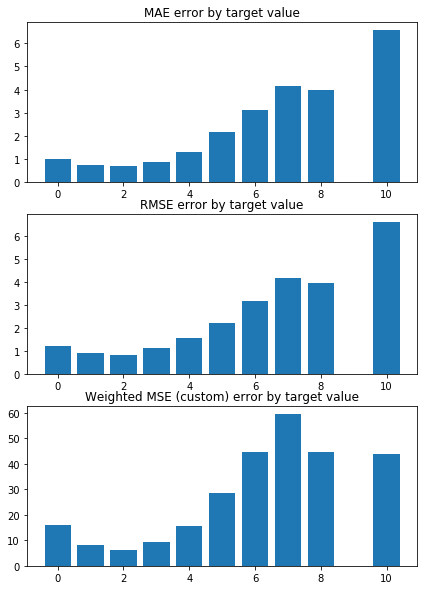

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.128725931411572 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1302497124920203 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


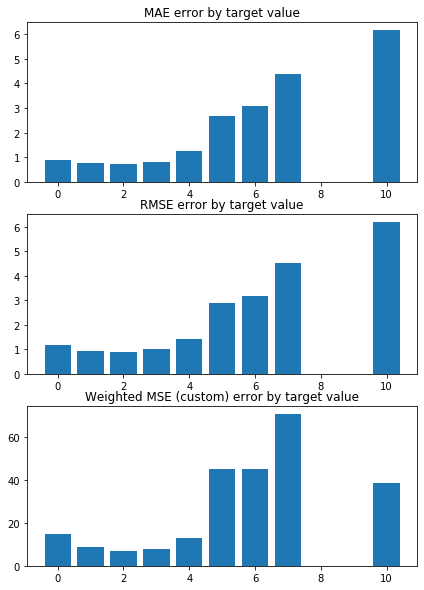

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.146388389515879 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1362509649220724 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


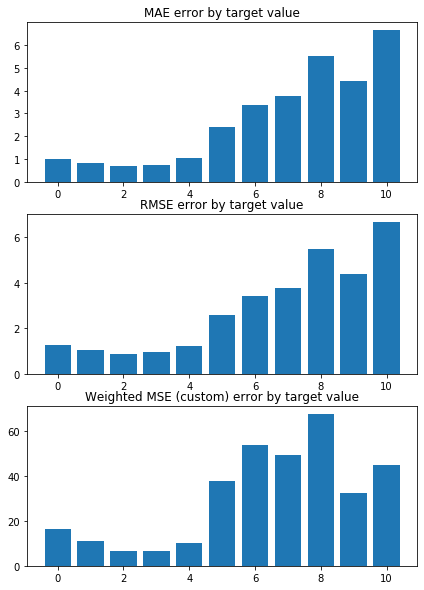

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0899114680812743 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1409826431517602 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


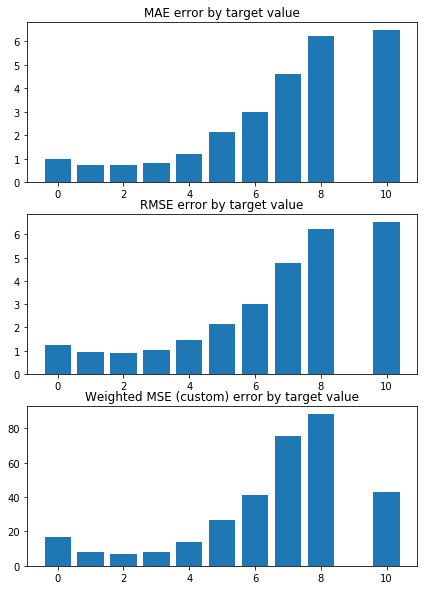

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1893880546187983 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1226538157382953 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


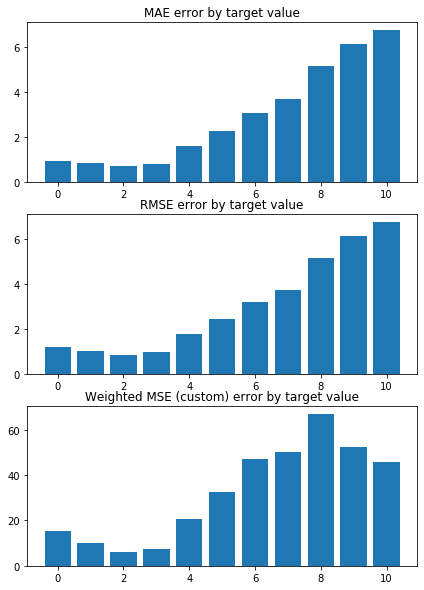

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2936413345593847 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1148131377874162 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


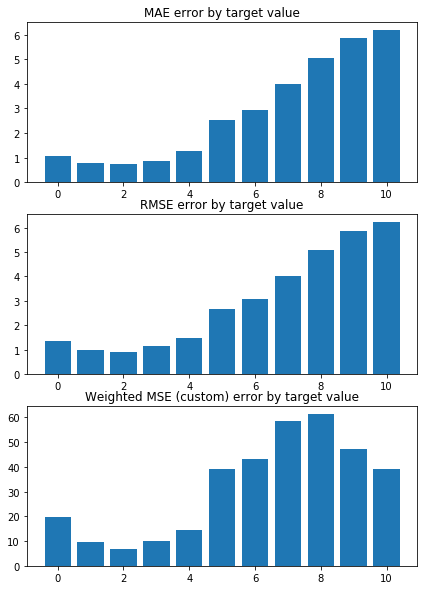

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.098720552065887 


 TRAIN PREDICTION Error
weighted_mse_train: 1.140275210471484 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


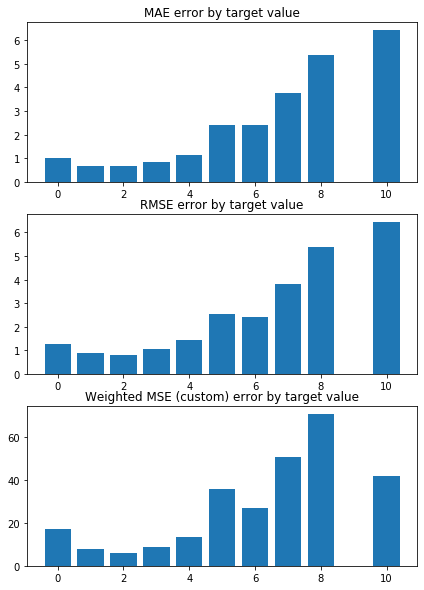

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.20645702834533 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1322377905402081 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


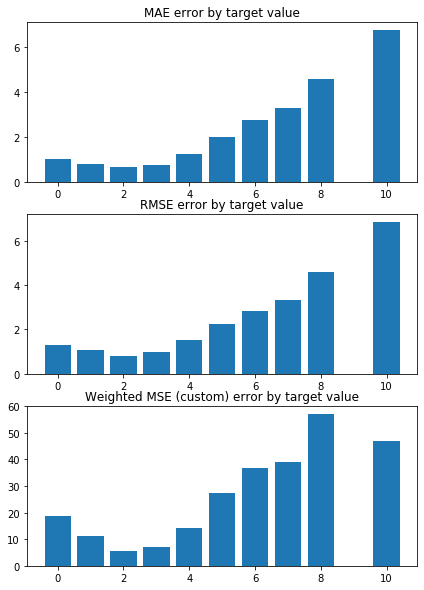

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.086957196114974 


 TRAIN PREDICTION Error
weighted_mse_train: 1.124721337214066 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


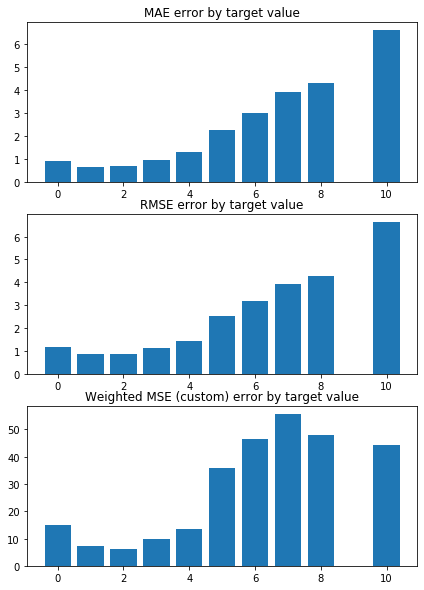

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0033949218826415 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1495137111061042 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


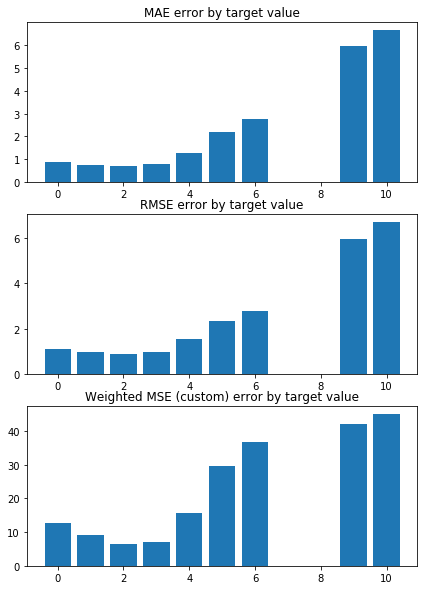

Weighted Mean squared error on Train: 1.13 
 MSE mean train: 2.6197060068596487 

Mean squared error on Test: 1.14 
 MSE mean test:  2.6338978385261607 

Root of MSE on Test: 1.07 
 1.6229287841819062 

Variance score on Test: 0.08 
 r2_test: 0.2882719541228333 

wMSE_train 1.13
wMSE_test 1.14
MSE_train 2.62
MSE_test 2.63
MAE_train 1.08
MAE_test 1.02
r2_test 0.29
      Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.315265 -0.292053 -0.277867 -0.271122 -0.269906 -0.256789 -0.245911   
1 -0.330338 -0.297192 -0.257059 -0.265227 -0.279687 -0.280442 -0.269973   
2 -0.336120 -0.335372 -0.268834 -0.242288 -0.307038 -0.332226 -0.240530   
3 -0.341391 -0.314786 -0.264260 -0.245514 -0.303345 -0.291626 -0.234488   
4 -0.305218 -0.328981 -0.291948 -0.226046 -0.312982 -0.333910 -0.238463   
5 -0.281389 -0.303630 -0.282385 -0.251811 -0.291489 -0.291367 -0.233527   
6 -0.303552 -0.297583 -0.267983 -0.253804 -0.261980 -0.277979 -0.293308   
7 -0.295437 -0.311982 -0.286021 -0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


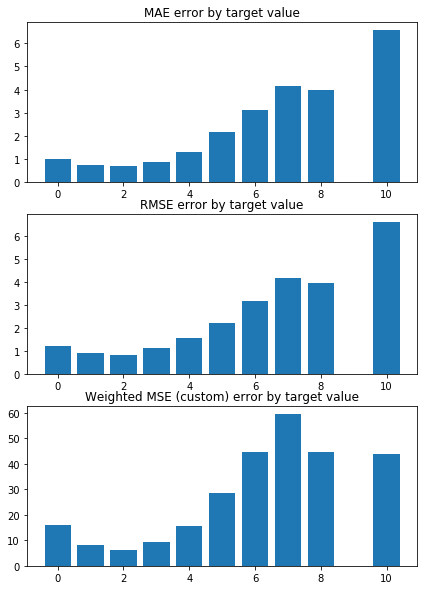

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1286658175200335 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1302075169795371 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


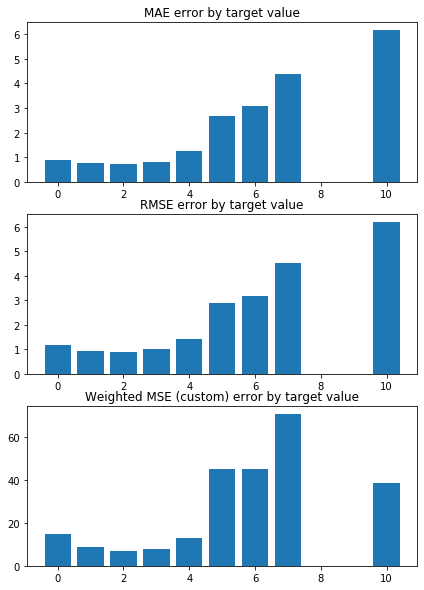

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.146291203128458 


 TRAIN PREDICTION Error
weighted_mse_train: 1.136203068356522 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


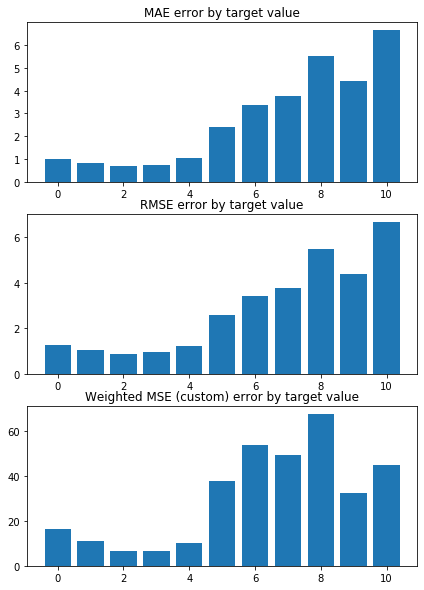

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0898614395410215 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1409383361578629 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


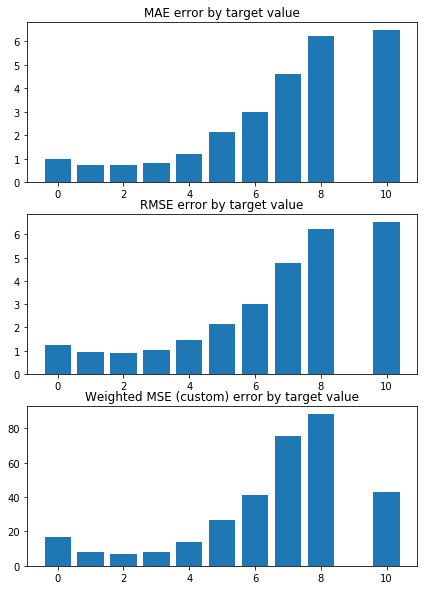

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1892667382742463 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1226093694954526 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


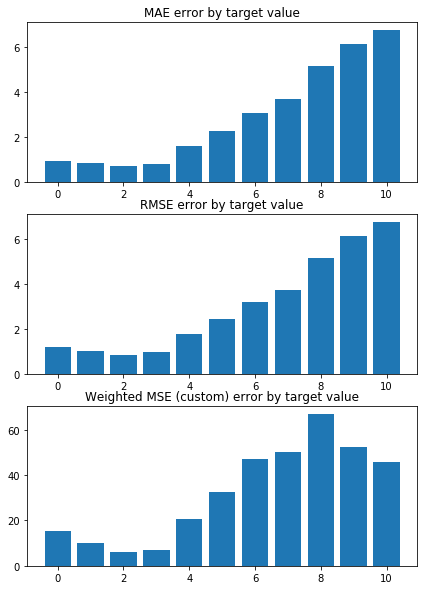

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.293613935577351 


 TRAIN PREDICTION Error
weighted_mse_train: 1.114771560733611 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


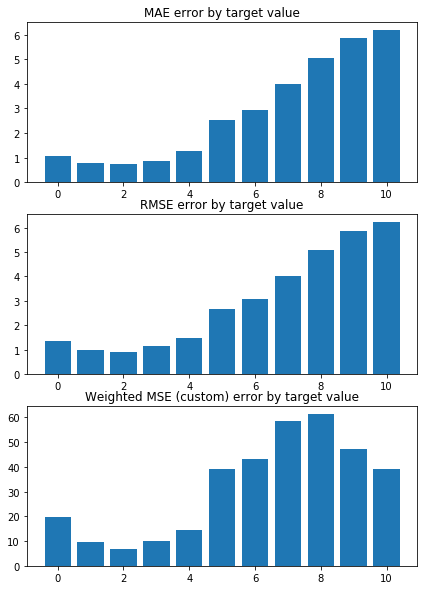

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0986982815354016 


 TRAIN PREDICTION Error
weighted_mse_train: 1.140229501523116 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


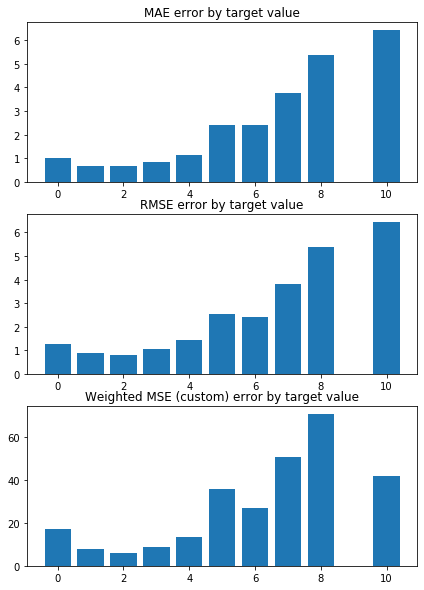

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.2063903397365812 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1321954822490503 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


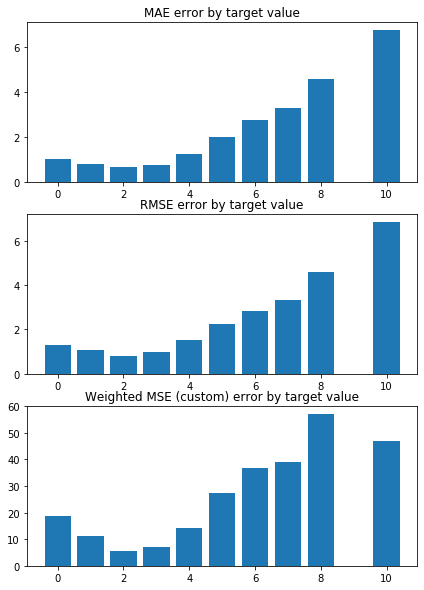

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0869282356340273 


 TRAIN PREDICTION Error
weighted_mse_train: 1.124682944695637 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


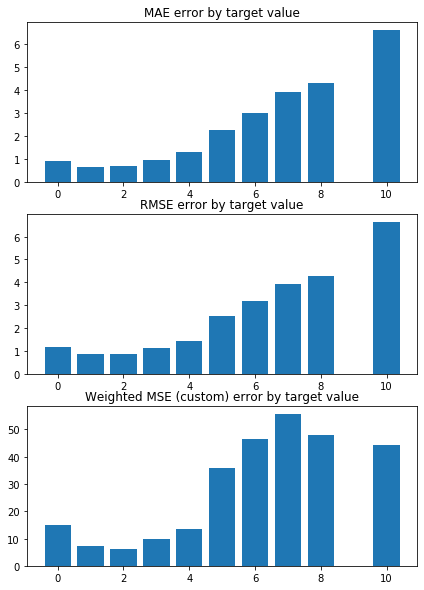

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0033615335860555 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1494668382641438 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


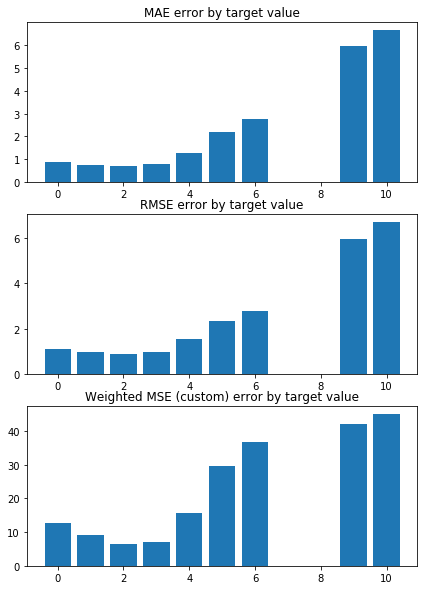

Weighted Mean squared error on Train: 1.13 
 MSE mean train: 2.6197076193708115 

Mean squared error on Test: 1.14 
 MSE mean test:  2.6338806326802517 

Root of MSE on Test: 1.07 
 1.622923483310366 

Variance score on Test: 0.08 
 r2_test: 0.288276822850149 

wMSE_train 1.13
wMSE_test 1.14
MSE_train 2.62
MSE_test 2.63
MAE_train 1.08
MAE_test 1.02
r2_test 0.29
      Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.314656 -0.291723 -0.277867 -0.271072 -0.269751 -0.256522 -0.245610   
1 -0.329667 -0.296845 -0.257085 -0.265213 -0.279519 -0.280116 -0.269581   
2 -0.335478 -0.334984 -0.268850 -0.242347 -0.306801 -0.331805 -0.240324   
3 -0.340722 -0.314428 -0.264274 -0.245530 -0.303128 -0.291283 -0.234285   
4 -0.304608 -0.328592 -0.291943 -0.226158 -0.312724 -0.333411 -0.238203   
5 -0.280917 -0.303291 -0.282368 -0.251818 -0.291285 -0.291042 -0.233306   
6 -0.303013 -0.297269 -0.267986 -0.253780 -0.261837 -0.277727 -0.292972   
7 -0.294894 -0.311622 -0.286017 -0.2

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


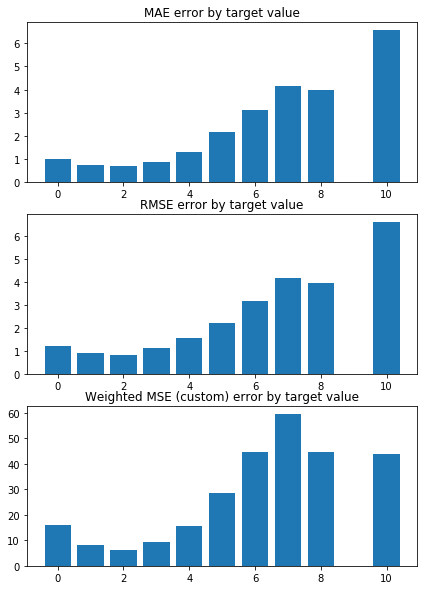

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1286061643583303 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1301655376423516 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


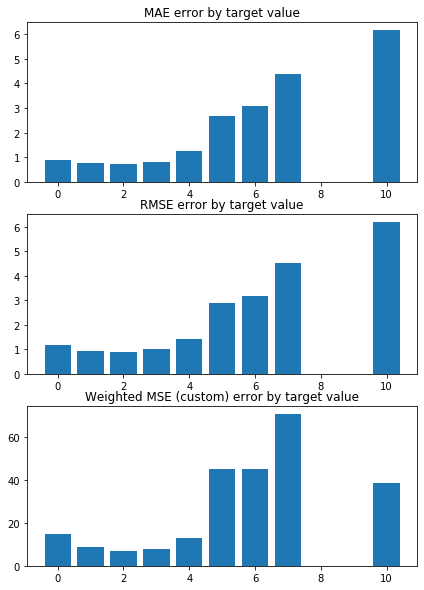

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1461941515841483 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1361553695435078 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


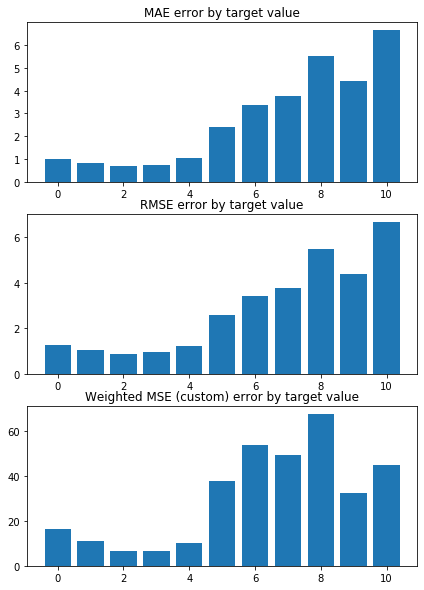

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0898114759053545 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1408942022793962 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


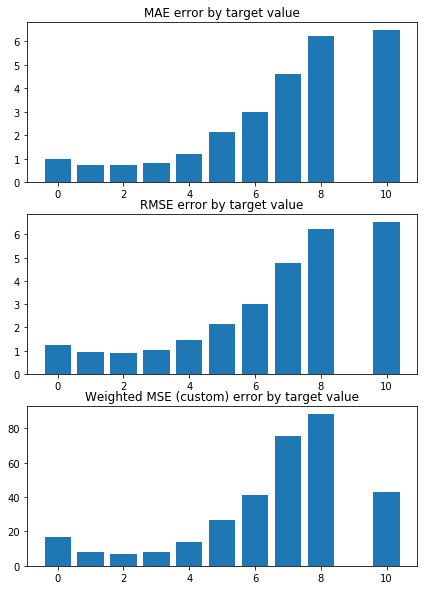

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.18914636419642 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1225651108014936 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


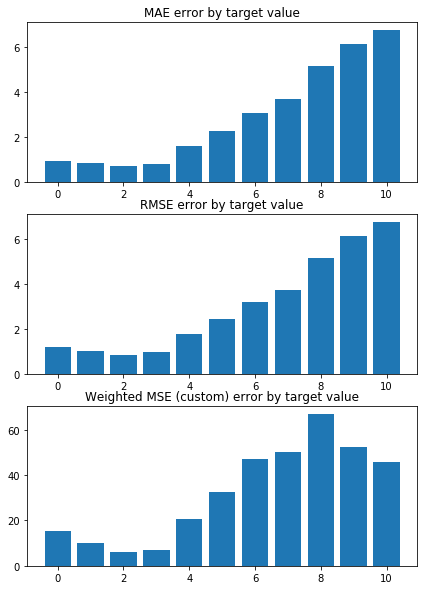

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.293586391836226 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1147301123644227 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


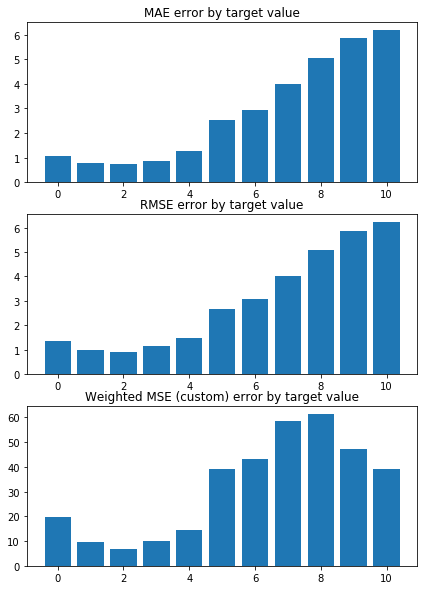

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0986759666116466 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1401839472713782 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


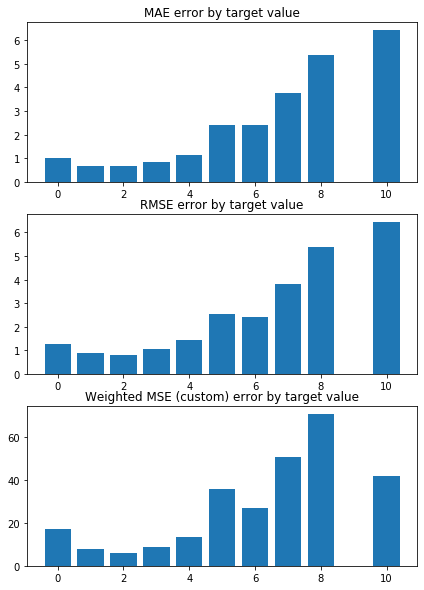

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.2063242422279385 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1321533420736678 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


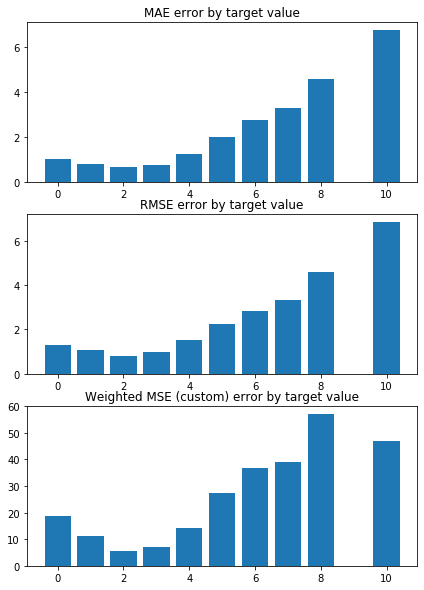

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0868994487605057 


 TRAIN PREDICTION Error
weighted_mse_train: 1.124644687355832 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


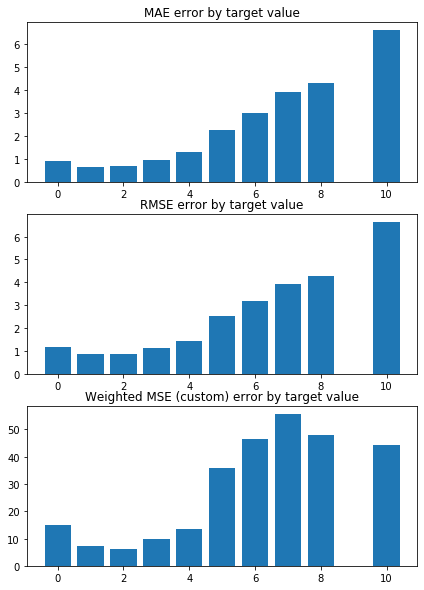

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.003328206103207 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1494201759457137 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


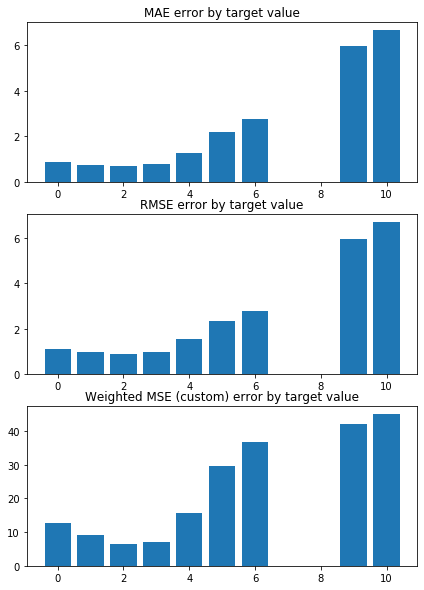

Weighted Mean squared error on Train: 1.13 
 MSE mean train: 2.6197094598522375 

Mean squared error on Test: 1.14 
 MSE mean test:  2.633863783651927 

Root of MSE on Test: 1.07 
 1.6229182923523684 

Variance score on Test: 0.08 
 r2_test: 0.28828159478251636 

wMSE_train 1.13
wMSE_test 1.14
MSE_train 2.62
MSE_test 2.63
MAE_train 1.08
MAE_test 1.02
r2_test 0.29
      Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.314053 -0.291394 -0.277866 -0.271021 -0.269596 -0.256258 -0.245313   
1 -0.329001 -0.296500 -0.257110 -0.265199 -0.279351 -0.279793 -0.269194   
2 -0.334842 -0.334596 -0.268866 -0.242405 -0.306565 -0.331386 -0.240121   
3 -0.340059 -0.314071 -0.264288 -0.245546 -0.302912 -0.290943 -0.234085   
4 -0.304004 -0.328205 -0.291938 -0.226269 -0.312467 -0.332915 -0.237946   
5 -0.280450 -0.302953 -0.282351 -0.251823 -0.291082 -0.290719 -0.233088   
6 -0.302479 -0.296957 -0.267989 -0.253755 -0.261694 -0.277476 -0.292640   
7 -0.294356 -0.311263 -0.286012 -0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


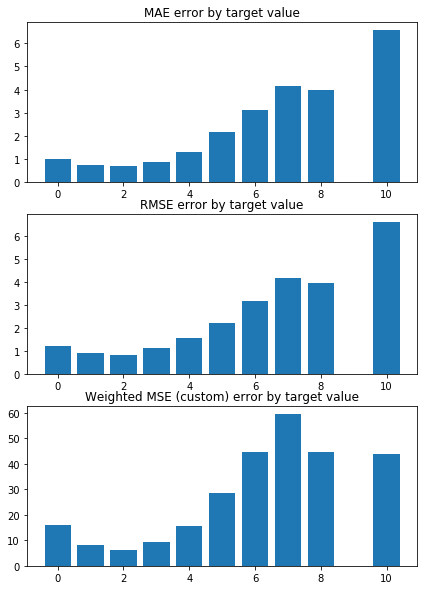

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1285469629110232 


 TRAIN PREDICTION Error
weighted_mse_train: 1.130123769956317 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


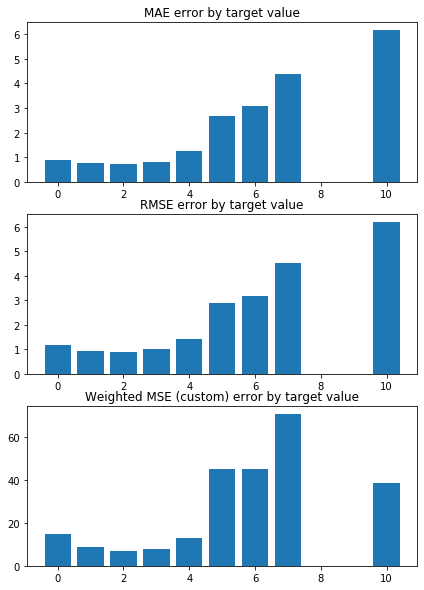

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1460972356192907 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1361078657009005 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


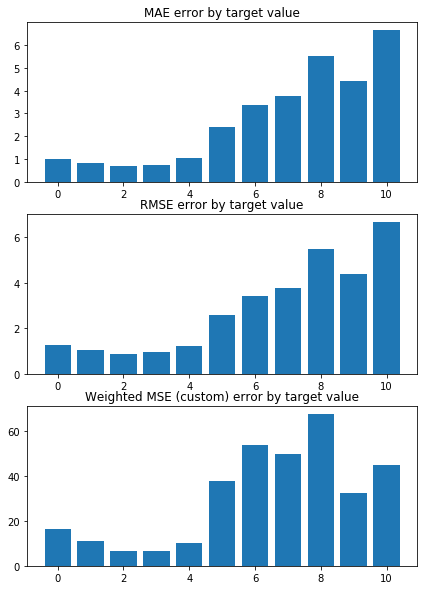

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.089761577562433 


 TRAIN PREDICTION Error
weighted_mse_train: 1.140850239048396 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


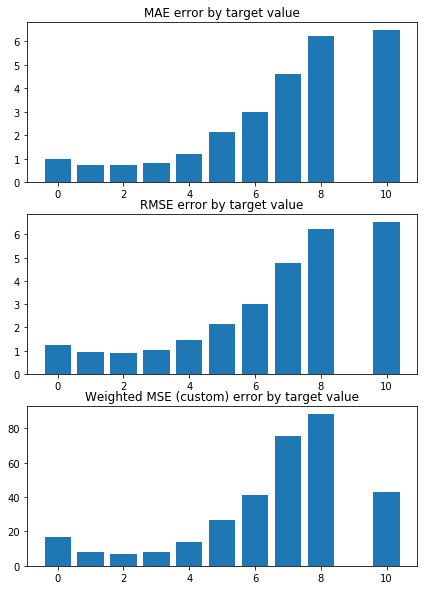

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1890269158692746 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1225210359583004 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


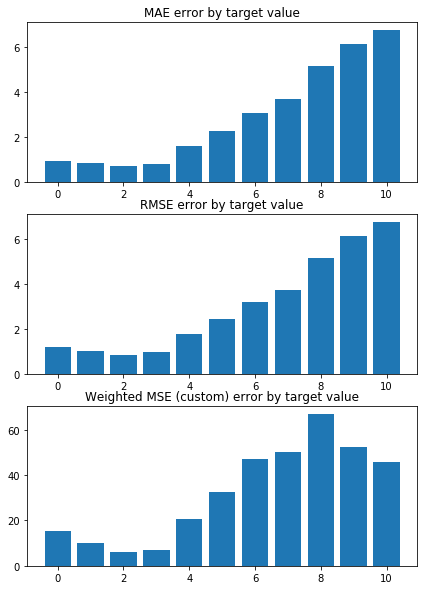

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.293558706741759 


 TRAIN PREDICTION Error
weighted_mse_train: 1.114688791186768 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


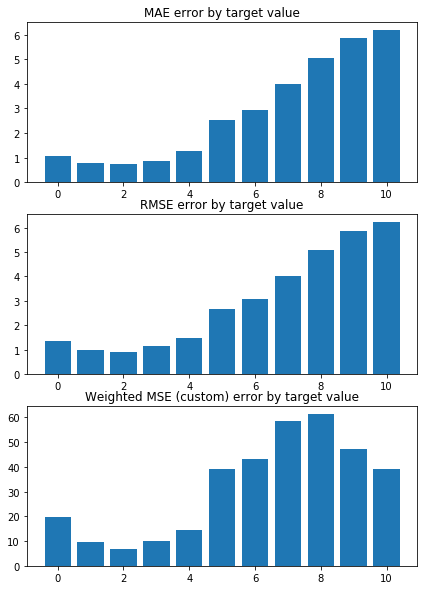

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0986536094989363 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1401385460210685 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


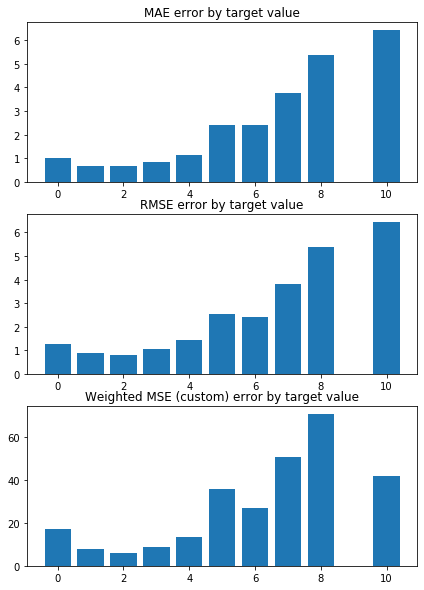

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.20625872385044 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1321113667151115 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


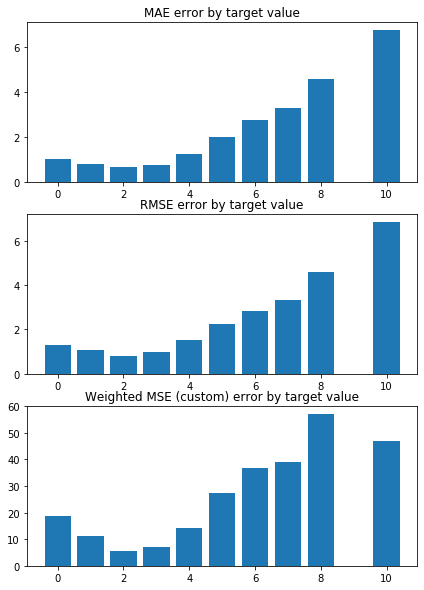

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.086870832290498 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1246065630388171 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


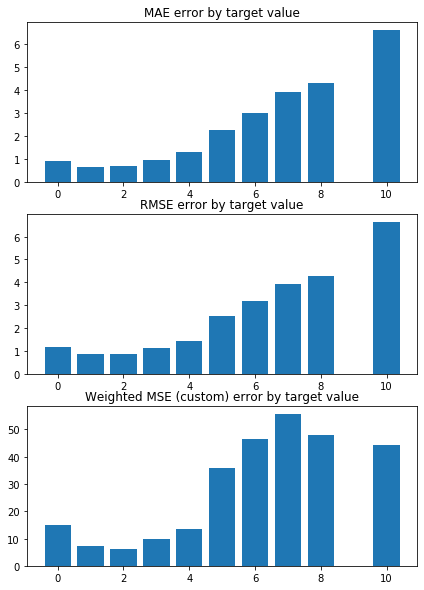

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0032949377038092 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1493737202482182 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


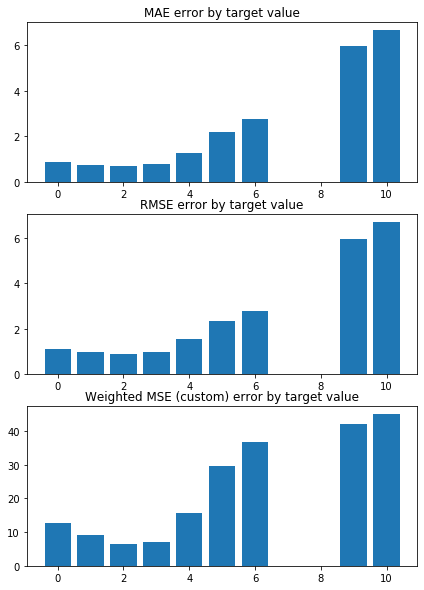

Weighted Mean squared error on Train: 1.13 
 MSE mean train: 2.619711523426454 

Mean squared error on Test: 1.14 
 MSE mean test:  2.633847284673174 

Root of MSE on Test: 1.07 
 1.6229132092238248 

Variance score on Test: 0.08 
 r2_test: 0.2882862717474787 

wMSE_train 1.13
wMSE_test 1.14
MSE_train 2.62
MSE_test 2.63
MAE_train 1.08
MAE_test 1.02
r2_test 0.29
      Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.313455 -0.291067 -0.277864 -0.270970 -0.269441 -0.255996 -0.245019   
1 -0.328341 -0.296157 -0.257133 -0.265184 -0.279183 -0.279472 -0.268811   
2 -0.334210 -0.334211 -0.268880 -0.242461 -0.306330 -0.330971 -0.239920   
3 -0.339400 -0.313715 -0.264301 -0.245560 -0.302697 -0.290606 -0.233888   
4 -0.303405 -0.327820 -0.291932 -0.226377 -0.312210 -0.332423 -0.237693   
5 -0.279986 -0.302617 -0.282333 -0.251828 -0.290879 -0.290398 -0.232873   
6 -0.301948 -0.296646 -0.267990 -0.253730 -0.261552 -0.277227 -0.292310   
7 -0.293823 -0.310906 -0.286006 -0.2

MSE_test_mean  MSE_test_std  MSE_train_mean  MSE_train_std comments  \
0       2.634009      0.159500        2.619701       0.017773        -   
1       2.633989      0.159500        2.619702       0.017773        -   
2       2.633970      0.159500        2.619702       0.017773        -   
3       2.633952      0.159499        2.619703       0.017773        -   
4       2.633933      0.159499        2.619703       0.017773        -   
5       2.633915      0.159499        2.619705       0.017773        -   
6       2.633898      0.159498        2.619706       0.017773        -   
7       2.633881      0.159498        2.619708       0.017773        -   
8       2.633864      0.159498        2.619709       0.017773        -   
9       2.633847      0.159497        2.619712       0.017773        -   

                                               model    model_name  n_splits  \
0  Ridge(alpha=0, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
1  Ridge(alpha=1, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
2  Ridge(alpha=2, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
3  Ridge(alpha=3, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
4  Ridge(alpha=4, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
5  Ridge(alpha=5, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
6  Ridge(alpha=6, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
7  Ridge(alpha=7, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
8  Ridge(alpha=8, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   
9  Ridge(alpha=9, copy_X=True, fit_intercept=True...  LR+L2_grid10      10.0   

                   params                                            r2_test  \
0  test_params = testtest  [0.3023327281566698, 0.34180286475628674, 0.25...   
1  test_params = testtest  [0.302323139855211, 0.34181152576610274, 0.254...   
2  test_params = testtest  [0.30231350792902834, 0.3418198994062065, 0.25...   
3  test_params = testtest  [0.3023038337979014, 0.3418279919203885, 0.254...   
4  test_params = testtest  [0.30229411882784785, 0.3418358093672641, 0.25...   
5  test_params = testtest  [0.30228436433345873, 0.34184335762711526, 0.2...   
6  test_params = testtest  [0.3022745715801204, 0.341850642408433, 0.2547...   
7  test_params = testtest  [0.30226474178612717, 0.34185766925417627, 0.2...   
8  test_params = testtest  [0.3022548761246938, 0.34186444354776035, 0.25...   
9  test_params = testtest  [0.30224497572586906, 0.3418709705187901, 0.25...   

   wMSE_test_mean  wMSE_test_std  wMSE_train_mean  wMSE_train_std  
0        1.138666       0.075075         1.131981        0.009782  
1        1.138611       0.075067         1.131937        0.009780  
2        1.138556       0.075058         1.131892        0.009778  
3        1.138502       0.075050         1.131848        0.009776  
4        1.138448       0.075042         1.131804        0.009774  
5        1.138394       0.075034         1.131760        0.009773  
6        1.138341       0.075026         1.131717        0.009771  
7        1.138287       0.075018         1.131673        0.009769  
8        1.138234       0.075010         1.131630        0.009767  
9        1.138181       0.075003         1.131587        0.009765

In [120]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

alpha_grid = np.arange(0, 10, 1)
# Create linear regression object



model_name = 'LR+L2_grid10'
n_splits = 10
random_state = 16 
shuffle = True

wmse_test = []
wmse_train = []

results_pd_gr = pd.DataFrame()

for alpha in alpha_grid:
    model = linear_model.Ridge(alpha=alpha)

    lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                    weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                    rmse_test, rmse_train, rmse_test_const, \
                    mae_test,    mae_train,  mae_test_const, \
                    results_pd_gr = train_test_KFold(X, y, 
                                                  model, model_name, results_pd_gr,
                                                  n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    wmse_test.append(np.mean(weighted_mse_test_all))
    wmse_train.append(np.mean(weighted_mse_train_all))

results_pd_gr

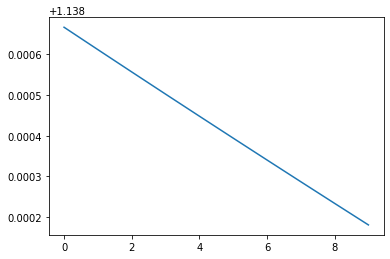

In [121]:
plt.plot(alpha_grid, wmse_test)

In [122]:
wmse_test

[1.1386658900596172,
 1.138611005909438,
 1.1385563925421596,
 1.1385020451113064,
 1.1384479589321317,
 1.1383941294748903,
 1.1383405523584362,
 1.1382872233441197,
 1.1382341383299752,
 1.1381812933451798]

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.136231420367119 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1089433437603722 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6918784159536415
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


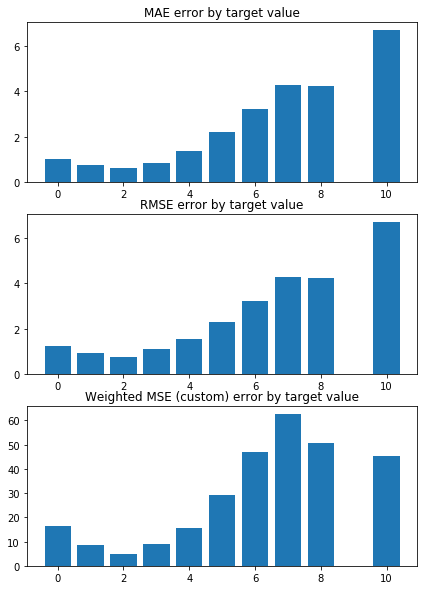

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1131745407887796 


 TRAIN PREDICTION Error
weighted_mse_train: 1.114260098225767 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


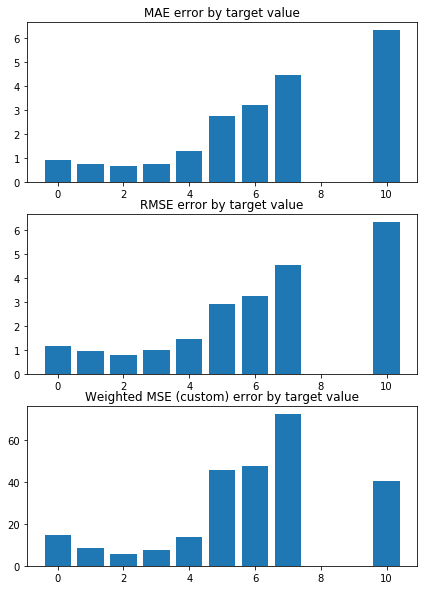

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.096964307135652 


 TRAIN PREDICTION Error
weighted_mse_train: 1.118755804721821 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


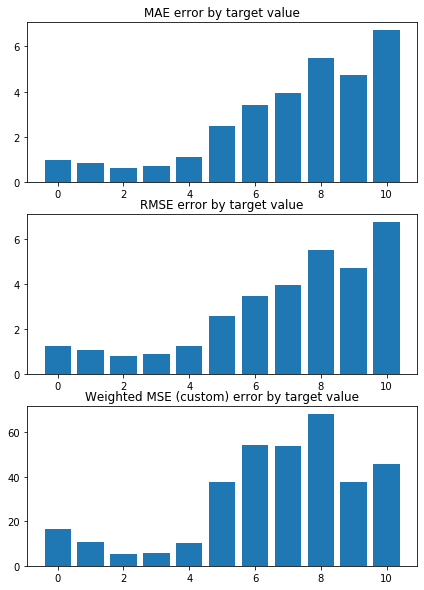

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.065362832862382 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1241131699166091 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


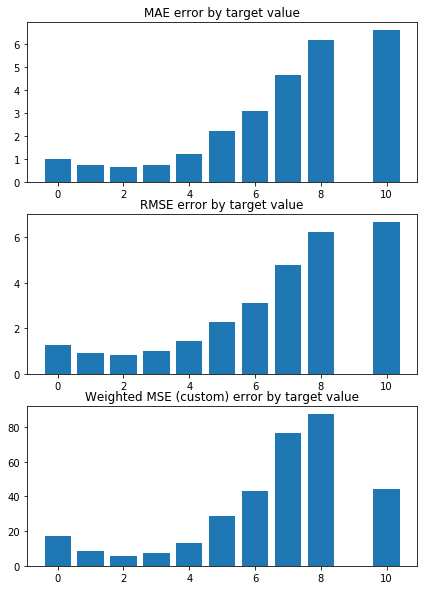

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.155867385303753 


 TRAIN PREDICTION Error
weighted_mse_train: 1.104858663898114 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


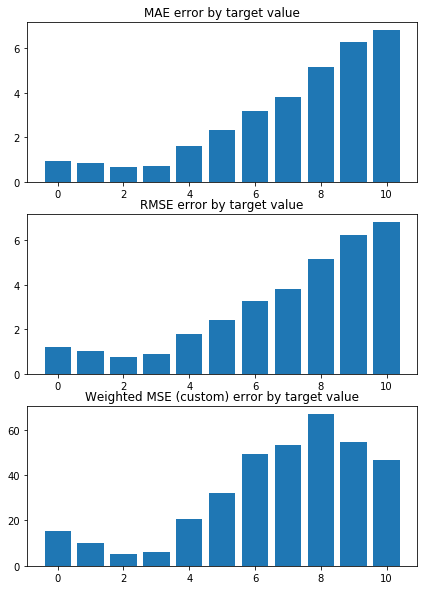

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2732907464842098 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0983255383963042 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


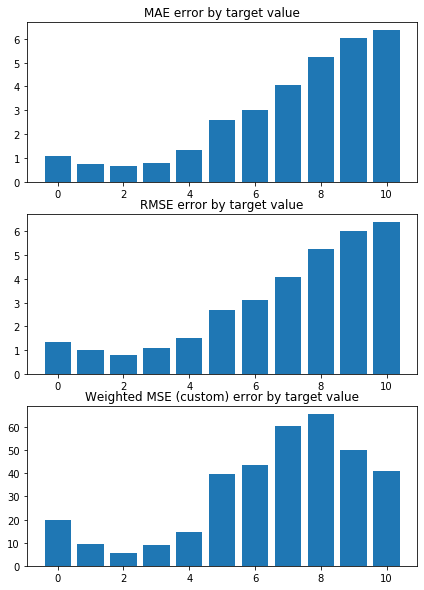

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0893117326034956 


 TRAIN PREDICTION Error
weighted_mse_train: 1.12237690361831 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


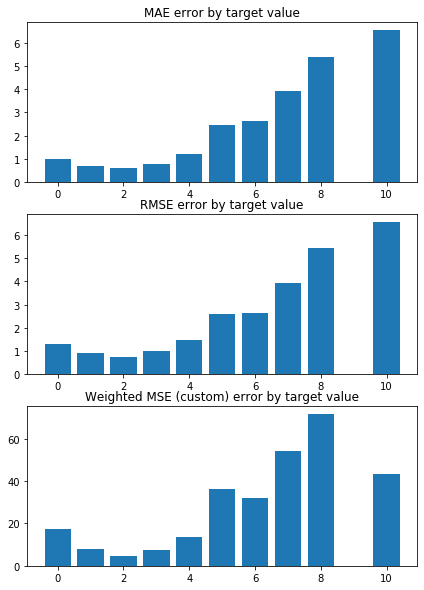

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1888999828644906 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1148805456920894 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


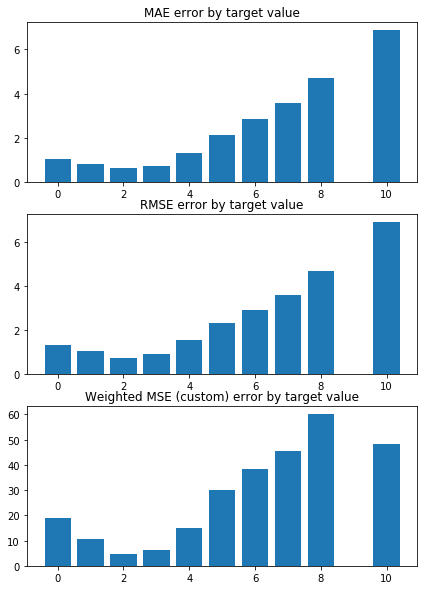

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.078789617207641 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1092590530940258 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


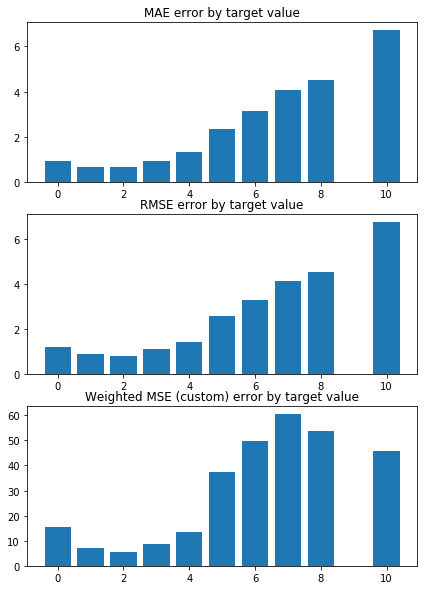

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9864448786715773 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1314881223814899 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


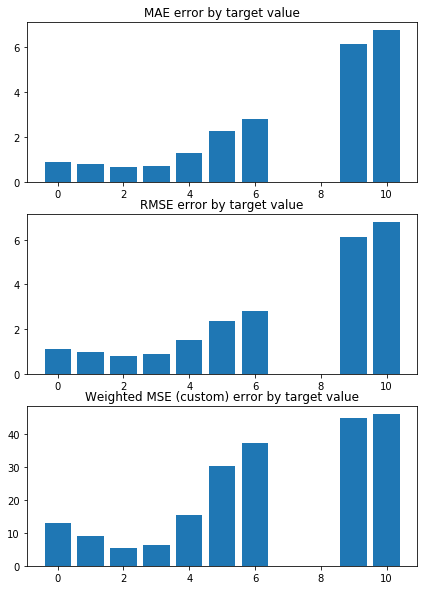

Weighted Mean squared error on Train: 1.11 
 MSE mean train: 2.6403218193762212 

Mean squared error on Test: 1.12 
 MSE mean test:  2.6487863412198513 

Root of MSE on Test: 1.06 
 1.6275092445881378 

Variance score on Test: 0.07 
 r2_test: 0.28436656929931836 

wMSE_train 1.11
wMSE_test 1.12
MSE_train 2.64
MSE_test 2.65
MAE_train 1.07
MAE_test 1.01
r2_test 0.28
      CP190  H3K27me1  H3K36me1   H3K4me1     Chriz  H3K36me3  H3K27me3  \
0 -0.224808 -0.208598 -0.182915 -0.181235 -0.176349 -0.174024 -0.146279   
1 -0.215405 -0.210605 -0.187279 -0.187124 -0.179493 -0.182702 -0.147357   
2 -0.225307 -0.207468 -0.197977 -0.187079 -0.183875 -0.201202 -0.166828   
3 -0.220114 -0.202903 -0.198140 -0.183739 -0.184362 -0.185011 -0.157571   
4 -0.235351 -0.200846 -0.199156 -0.183922 -0.171573 -0.194398 -0.165170   
5 -0.227376 -0.205351 -0.191265 -0.180345 -0.168984 -0.186442 -0.151188   
6 -0.222070 -0.204986 -0.180959 -0.201393 -0.173557 -0.184914 -0.151804   
7 -0.232883 -0.204074 -0.186670 -

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


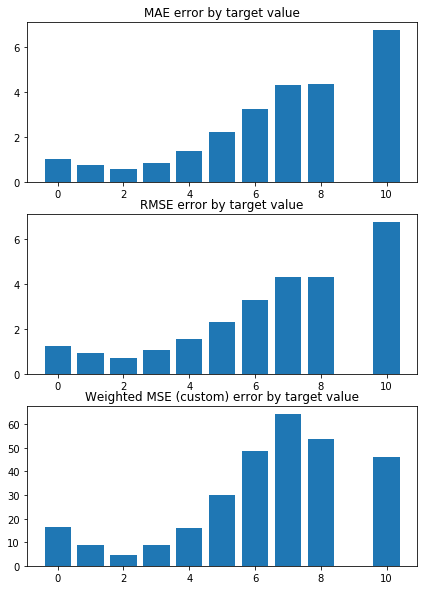

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1138935138264003 


 TRAIN PREDICTION Error
weighted_mse_train: 1.112253398847069 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


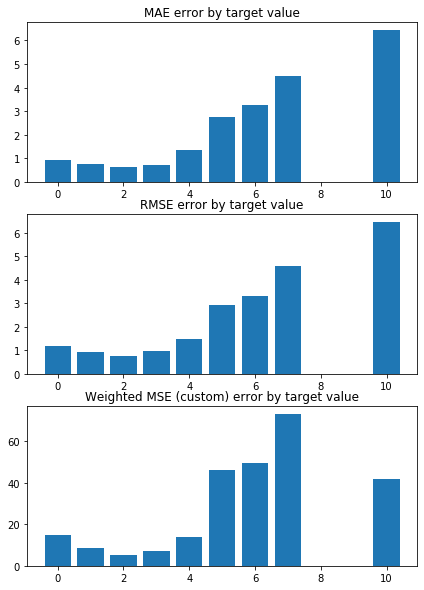

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0807226261664178 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1172665244615234 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


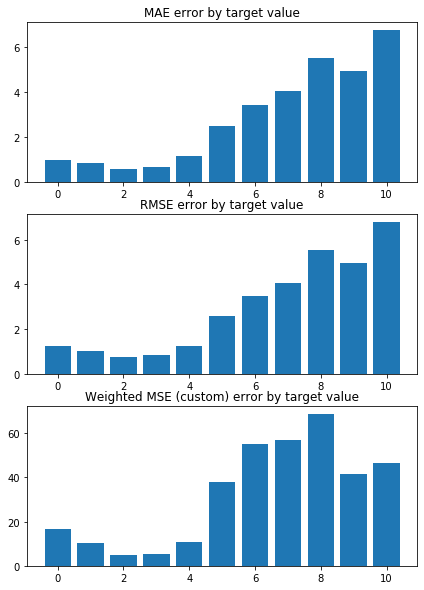

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0587498366132417 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1223275564804103 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


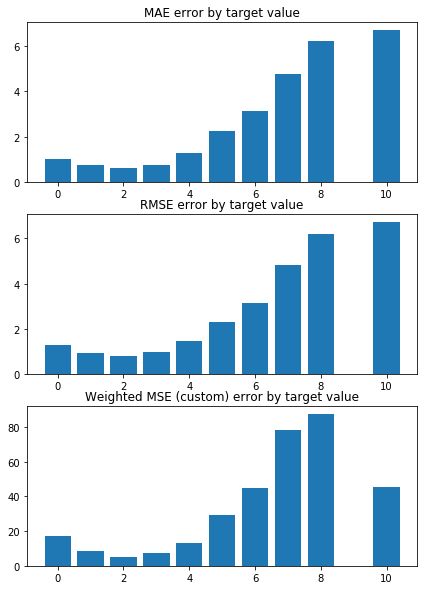

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1518411176136423 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1027205015936834 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


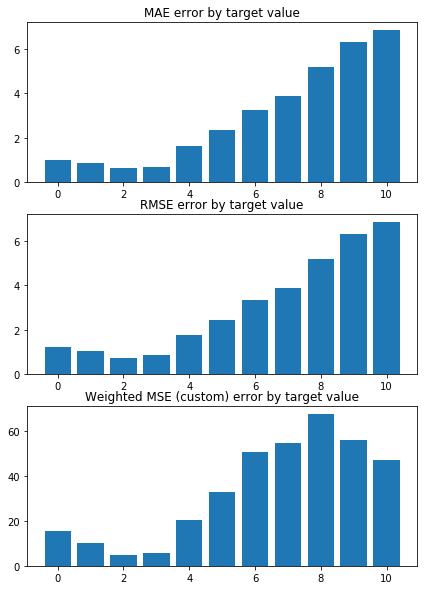

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.267855112472492 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0967096976895474 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


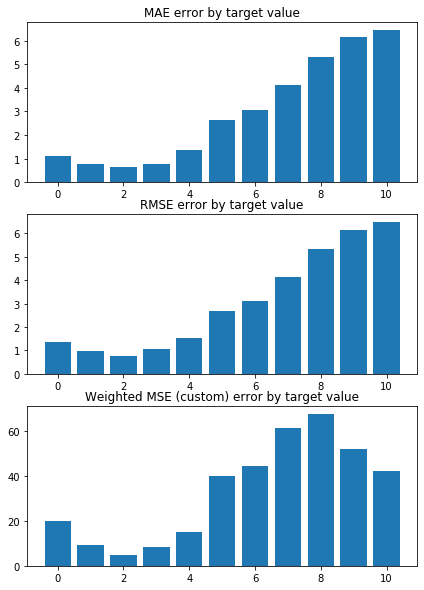

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0902558550741934 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1199875237727963 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


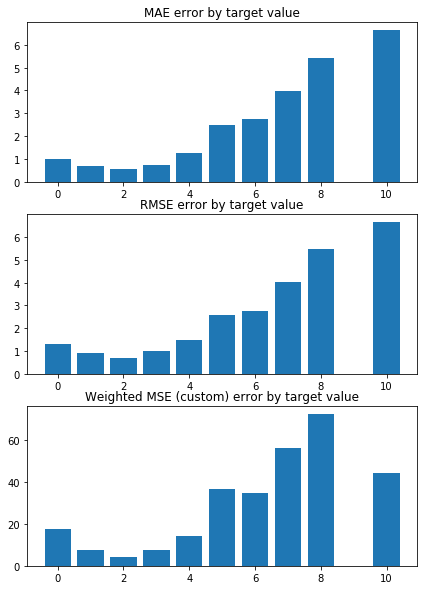

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.187057198647839 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1123527930255082 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


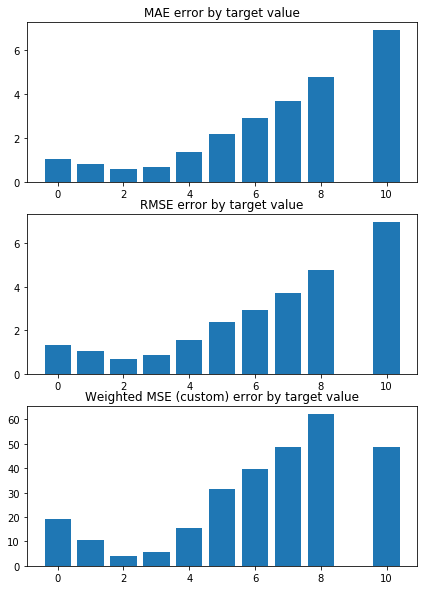

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0804557575049596 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1075996920679876 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


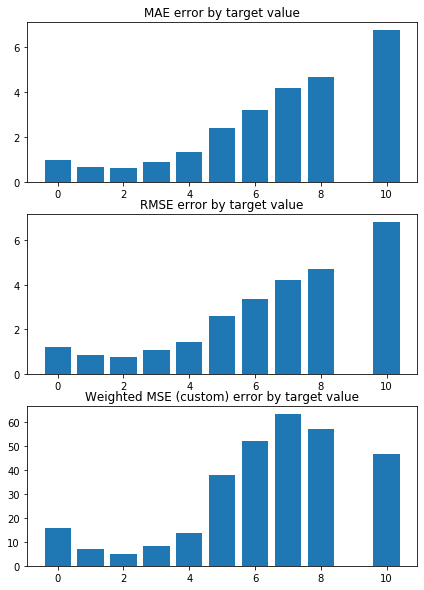

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9837443977683009 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1291705075758367 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


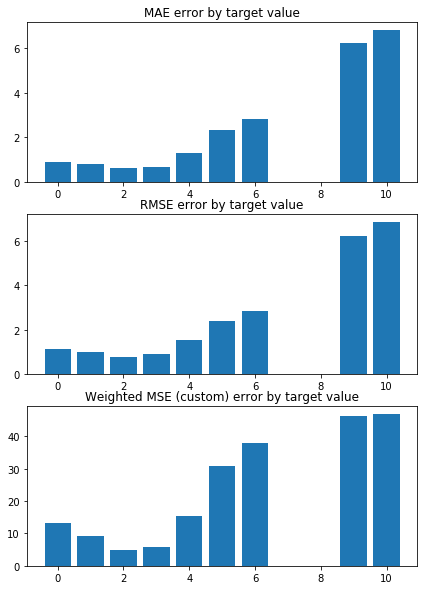

Weighted Mean squared error on Train: 1.11 
 MSE mean train: 2.663242639521141 

Mean squared error on Test: 1.12 
 MSE mean test:  2.670077043898872 

Root of MSE on Test: 1.06 
 1.634037038716954 

Variance score on Test: 0.07 
 r2_test: 0.2786711114335788 

wMSE_train 1.11
wMSE_test 1.12
MSE_train 2.66
MSE_test 2.67
MAE_train 1.08
MAE_test 1.01
r2_test 0.28
      CP190  H3K27me1   H3K4me1     Chriz  H3K36me1  H3K36me3  H3K27me3  \
0 -0.185396 -0.175123 -0.158494 -0.148429 -0.146368 -0.145226 -0.090858   
1 -0.179987 -0.177294 -0.161706 -0.150121 -0.149257 -0.150890 -0.091189   
2 -0.188499 -0.176517 -0.163291 -0.153306 -0.156917 -0.162628 -0.104770   
3 -0.183353 -0.172602 -0.161016 -0.153345 -0.157227 -0.152097 -0.098660   
4 -0.193927 -0.171592 -0.161339 -0.145164 -0.157540 -0.156877 -0.104544   
5 -0.187744 -0.173826 -0.158231 -0.144226 -0.152157 -0.153095 -0.093802   
6 -0.185464 -0.173780 -0.171645 -0.146456 -0.146113 -0.151921 -0.095073   
7 -0.193180 -0.172989 -0.162526 -0.14

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


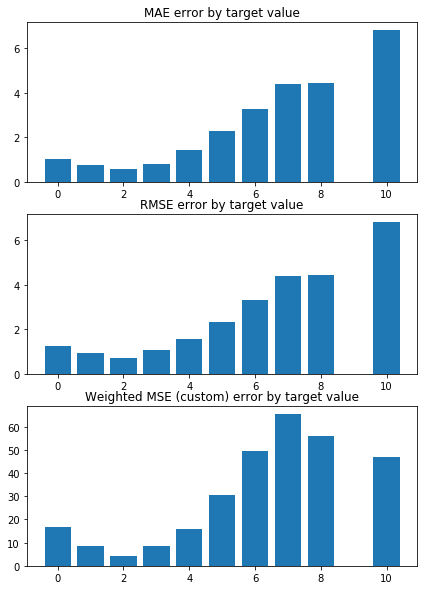

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.116399335105701 


 TRAIN PREDICTION Error
weighted_mse_train: 1.112637792649221 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


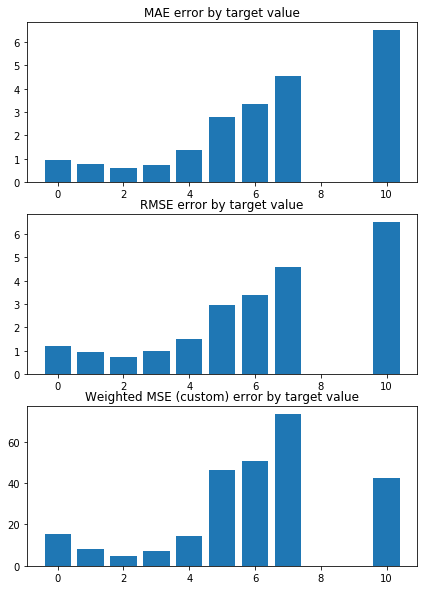

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.072530718783873 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1182624153611356 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


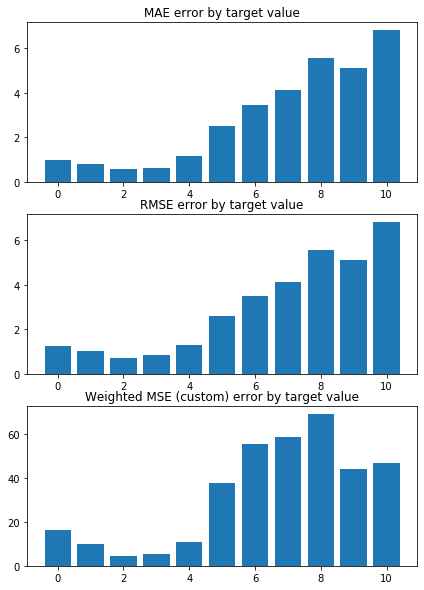

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0559200618569282 


 TRAIN PREDICTION Error
weighted_mse_train: 1.122990939209559 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


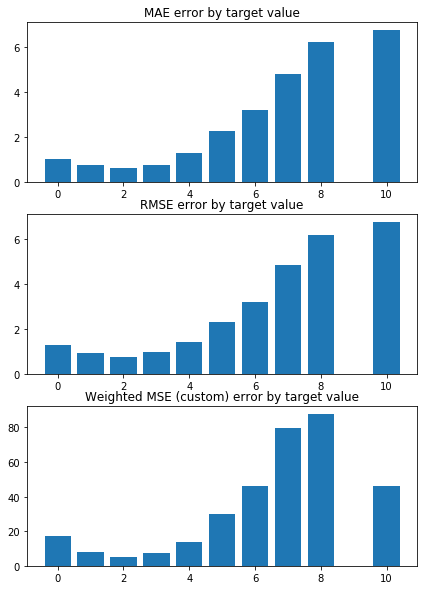

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.152220927424399 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1032870731317805 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


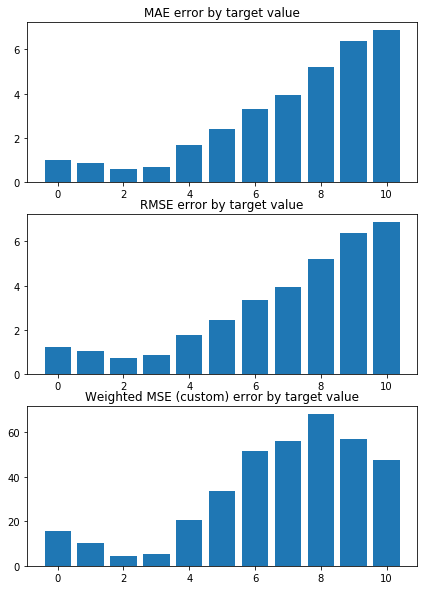

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.266147872840521 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0975016977153997 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


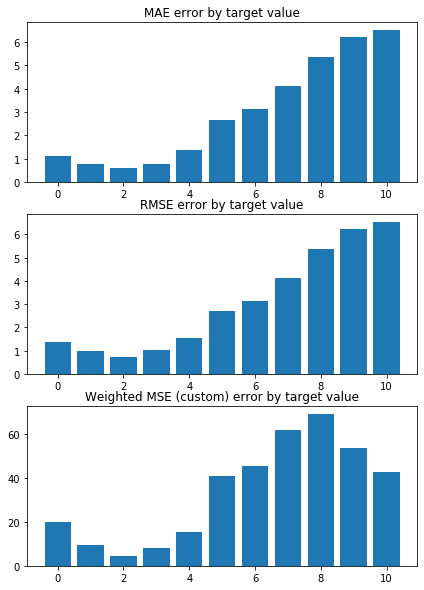

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.092202659703217 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1202117211648164 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


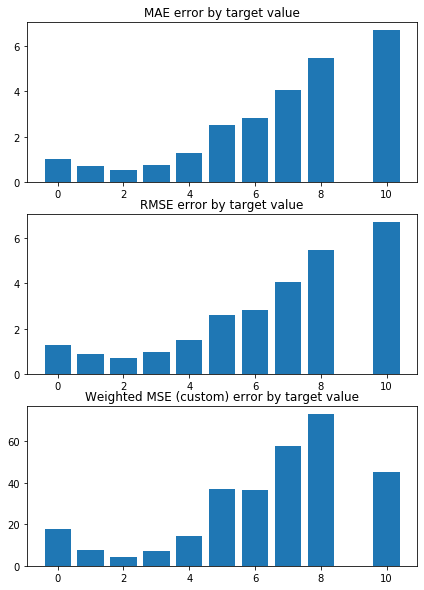

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1873003119759995 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1124793118978533 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


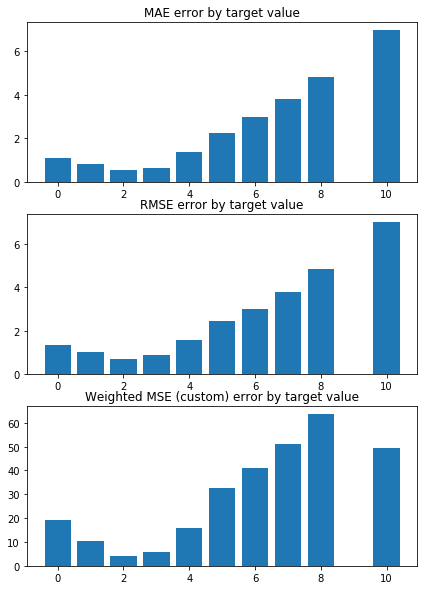

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0832534779123695 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1082759267281648 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


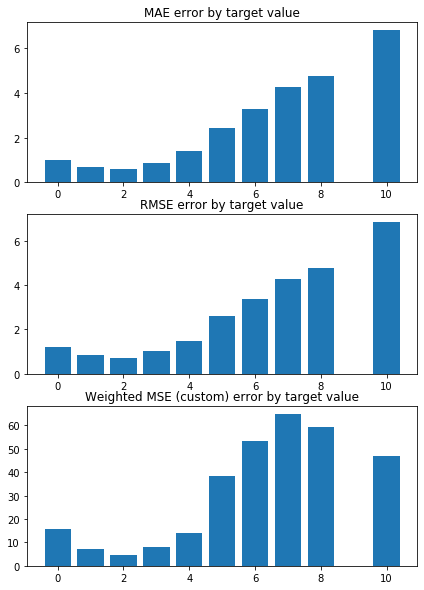

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9839460010766412 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1295083089409097 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


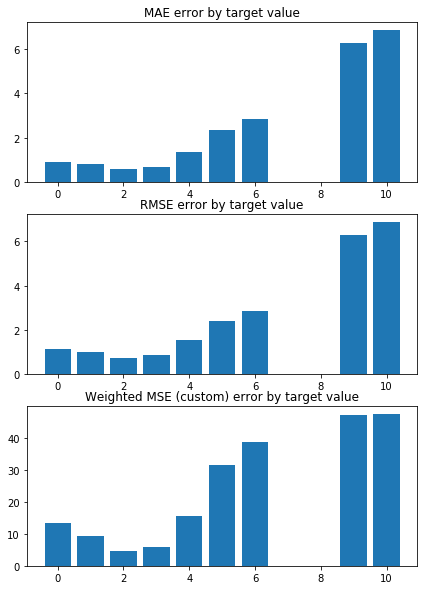

Weighted Mean squared error on Train: 1.11 
 MSE mean train: 2.6822968579254503 

Mean squared error on Test: 1.12 
 MSE mean test:  2.688228552305251 

Root of MSE on Test: 1.06 
 1.6395818223880292 

Variance score on Test: 0.07 
 r2_test: 0.2738080207091959 

wMSE_train 1.11
wMSE_test 1.12
MSE_train 2.68
MSE_test 2.69
MAE_train 1.08
MAE_test 1.02
r2_test 0.27
      CP190  H3K27me1   H3K4me1     Chriz  H3K36me3  H3K36me1   H3K4me3  \
0 -0.158956 -0.154637 -0.143868 -0.133501 -0.128806 -0.125203 -0.085174   
1 -0.155528 -0.156561 -0.145992 -0.134608 -0.132982 -0.127382 -0.085385   
2 -0.162966 -0.156505 -0.147848 -0.137209 -0.141724 -0.133507 -0.080608   
3 -0.158009 -0.153318 -0.146134 -0.137143 -0.133916 -0.133825 -0.082467   
4 -0.166144 -0.152529 -0.146413 -0.130967 -0.136849 -0.133917 -0.081571   
5 -0.161064 -0.153957 -0.143771 -0.130545 -0.134565 -0.129766 -0.083146   
6 -0.160277 -0.154010 -0.153878 -0.131924 -0.133429 -0.125692 -0.082584   
7 -0.166219 -0.153394 -0.146823 -0.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


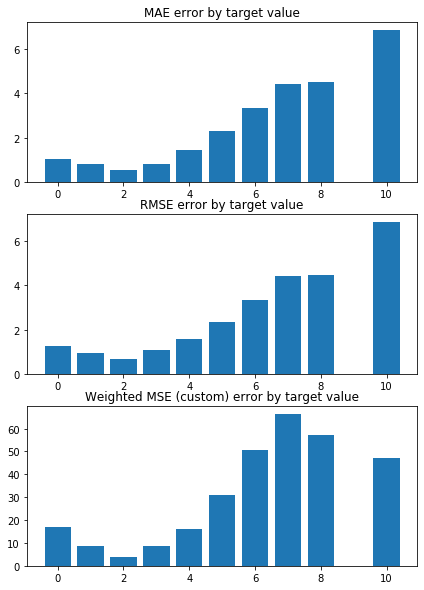

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.118938502349385 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1134655041322397 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


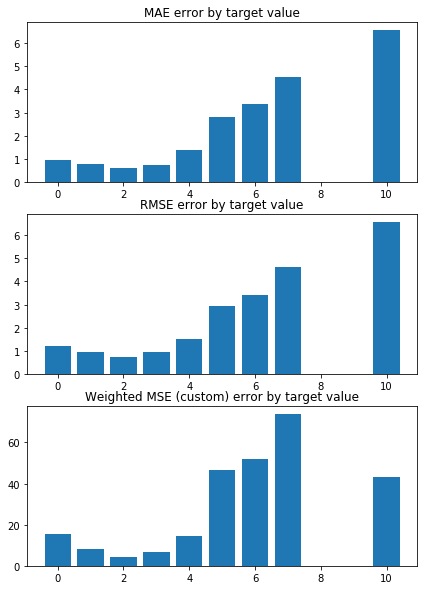

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0673537040833625 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1196280635490174 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


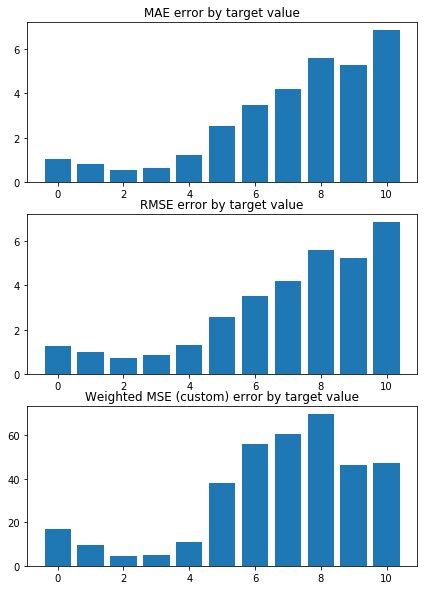

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0541990722818477 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1240430824479968 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


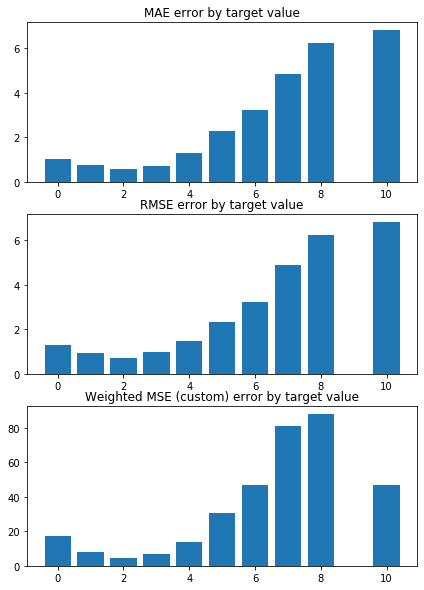

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1535872439732608 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1043237477655918 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


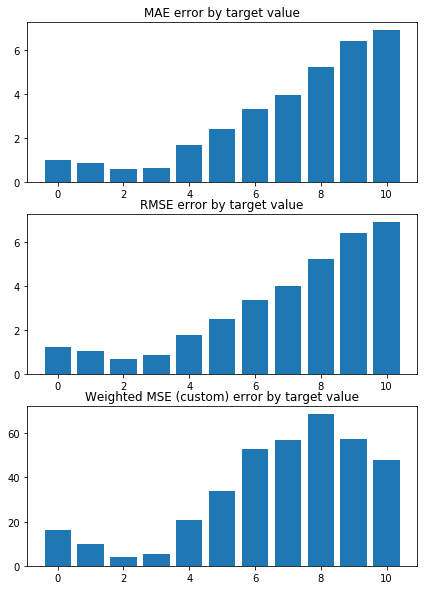

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2654984355679364 


 TRAIN PREDICTION Error
weighted_mse_train: 1.098670305381693 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


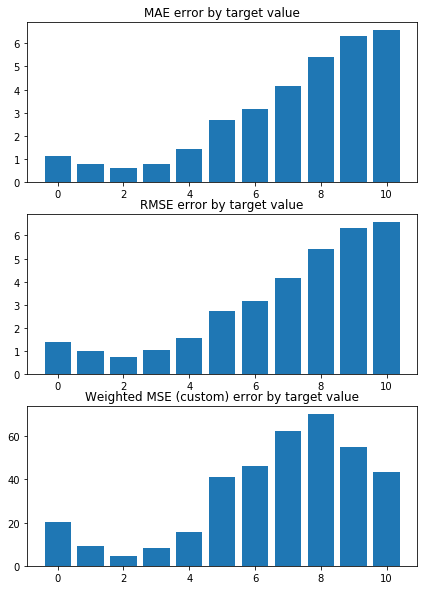

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0939166037201662 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1209535023942625 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


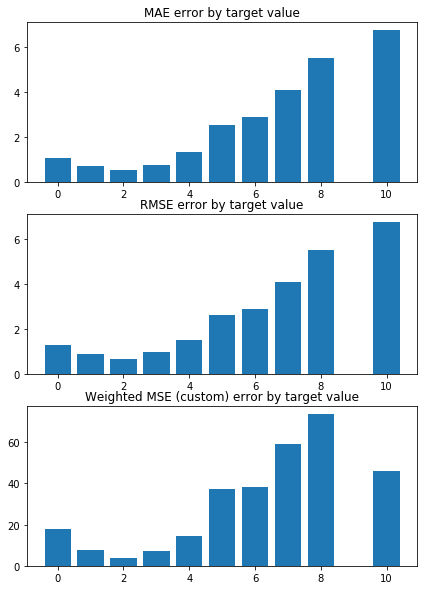

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1878954115313698 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1131456910833903 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


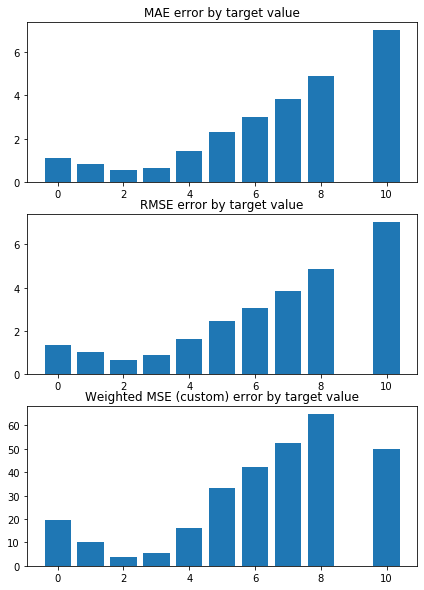

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0859437202763298 


 TRAIN PREDICTION Error
weighted_mse_train: 1.109335795495927 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


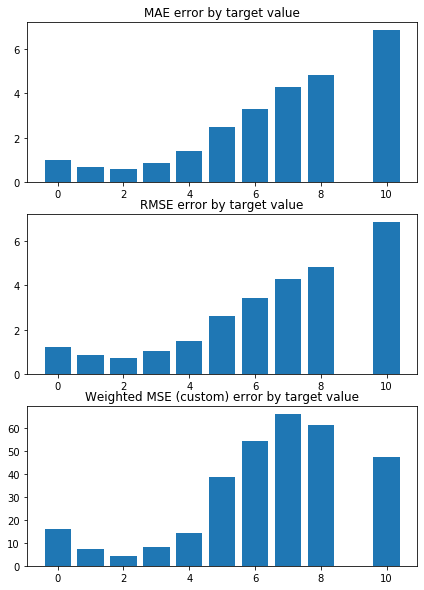

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9847737320479042 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1303485371206128 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


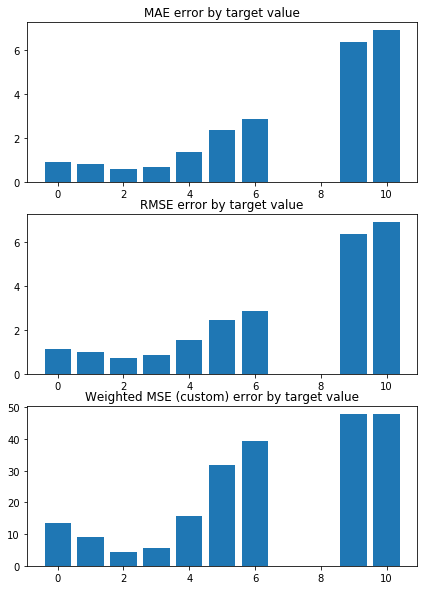

Weighted Mean squared error on Train: 1.11 
 MSE mean train: 2.6981418320967863 

Mean squared error on Test: 1.12 
 MSE mean test:  2.7034720533134666 

Root of MSE on Test: 1.06 
 1.6442238452575326 

Variance score on Test: 0.07 
 r2_test: 0.2697230329936535 

wMSE_train 1.11
wMSE_test 1.12
MSE_train 2.7
MSE_test 2.7
MAE_train 1.08
MAE_test 1.02
r2_test 0.27
   H3K27me1     CP190   H3K4me1     Chriz  H3K36me3  H3K36me1   H3K4me3  \
0 -0.140623 -0.139931 -0.133390 -0.123523 -0.117893 -0.111155 -0.083711   
1 -0.142290 -0.137636 -0.134931 -0.124311 -0.121151 -0.112917 -0.084020   
2 -0.142530 -0.144248 -0.136787 -0.126564 -0.128198 -0.118060 -0.080318   
3 -0.139906 -0.139515 -0.135430 -0.126486 -0.122011 -0.118373 -0.081736   
4 -0.139188 -0.146155 -0.135634 -0.121441 -0.123978 -0.118358 -0.080741   
5 -0.140208 -0.141819 -0.133359 -0.121242 -0.122404 -0.114972 -0.082146   
6 -0.140297 -0.141873 -0.141591 -0.122197 -0.121289 -0.112029 -0.081752   
7 -0.139821 -0.146650 -0.135729 -0.1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


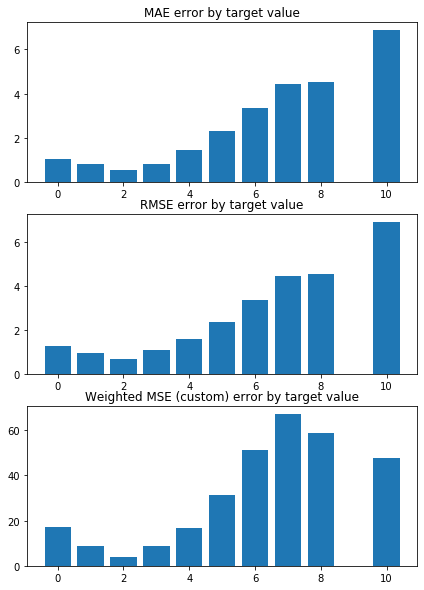

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1212767370588077 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1143464619293768 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


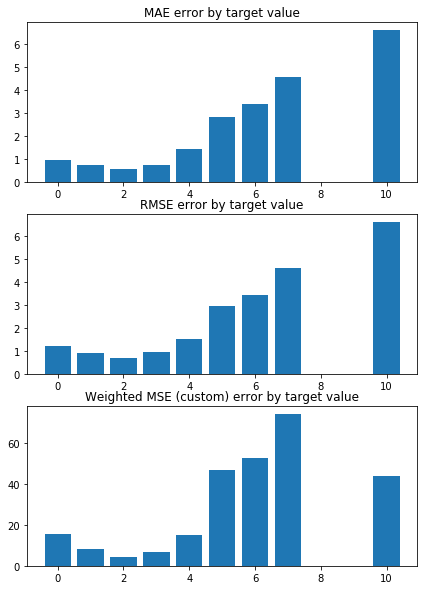

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0636553789846526 


 TRAIN PREDICTION Error
weighted_mse_train: 1.120963430283936 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


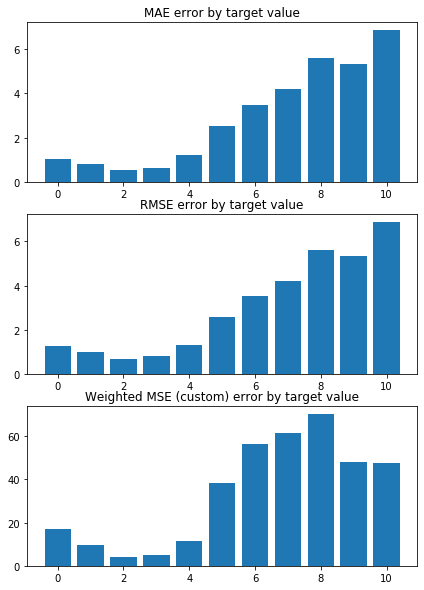

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0529070694809322 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1250856246517769 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


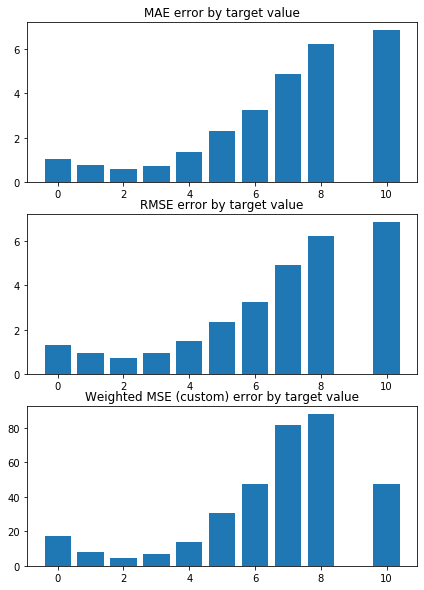

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1551564353509733 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1053814224578813 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


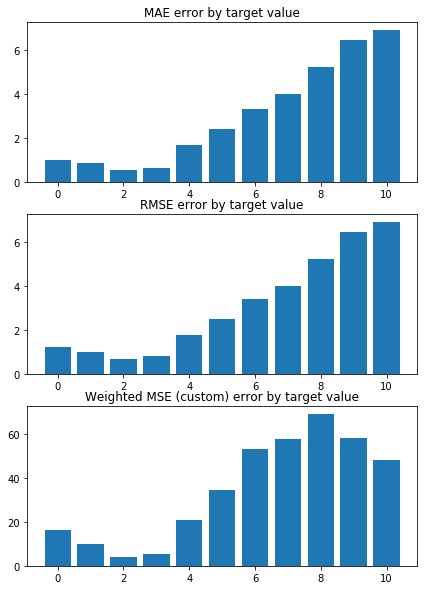

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2652172923253264 


 TRAIN PREDICTION Error
weighted_mse_train: 1.09982882710334 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


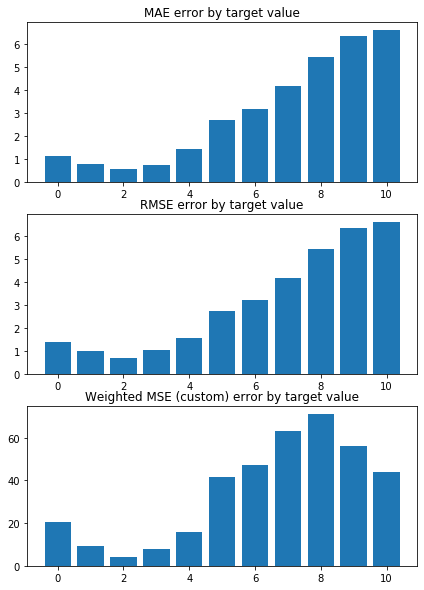

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0953228138481714 


 TRAIN PREDICTION Error
weighted_mse_train: 1.121782207034843 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


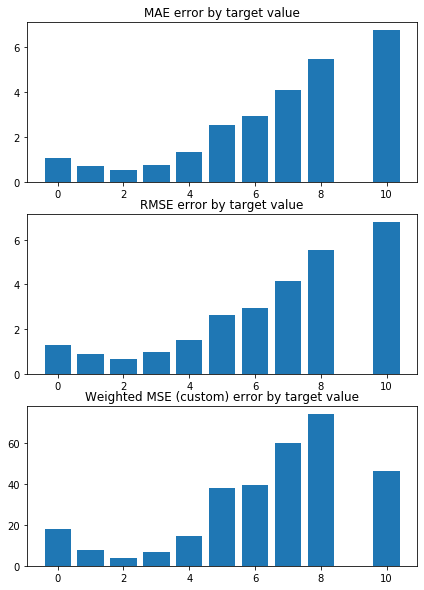

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1885304430522738 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1139073088615727 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


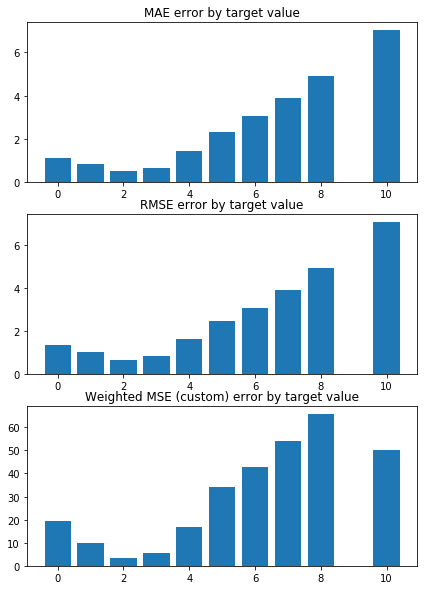

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0883788231603597 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1103983059070346 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


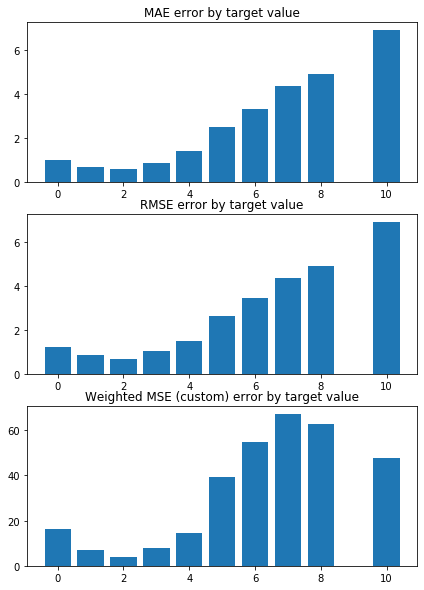

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9857352557775989 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1312545436889645 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


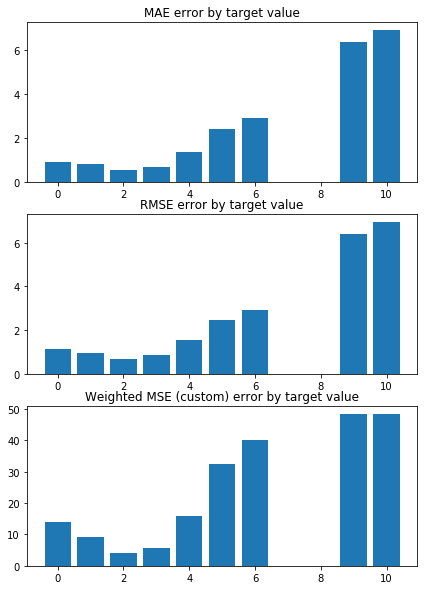

Weighted Mean squared error on Train: 1.12 
 MSE mean train: 2.711698424223342 

Mean squared error on Test: 1.12 
 MSE mean test:  2.7165882512798376 

Root of MSE on Test: 1.06 
 1.6482075874354656 

Variance score on Test: 0.07 
 r2_test: 0.26620808830396525 

wMSE_train 1.12
wMSE_test 1.12
MSE_train 2.71
MSE_test 2.72
MAE_train 1.08
MAE_test 1.02
r2_test 0.27
   H3K27me1     CP190   H3K4me1     Chriz  H3K36me3  H3K36me1   H3K4me3  \
0 -0.130307 -0.125497 -0.125366 -0.116108 -0.109957 -0.101046 -0.082202   
1 -0.131754 -0.123908 -0.126545 -0.116692 -0.112586 -0.102532 -0.082544   
2 -0.132133 -0.129868 -0.128331 -0.118716 -0.118543 -0.106977 -0.079563   
3 -0.129938 -0.125363 -0.127227 -0.118657 -0.113435 -0.107286 -0.080708   
4 -0.129252 -0.130995 -0.127357 -0.114341 -0.114823 -0.107207 -0.079674   
5 -0.130023 -0.127195 -0.125367 -0.114253 -0.113637 -0.104352 -0.080962   
6 -0.130128 -0.127757 -0.132376 -0.114958 -0.112550 -0.102137 -0.080634   
7 -0.129758 -0.131708 -0.127305 -0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


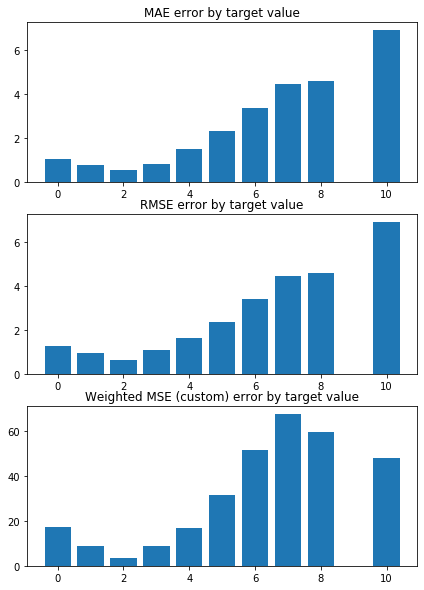

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1234529186450788 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1152271217997696 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


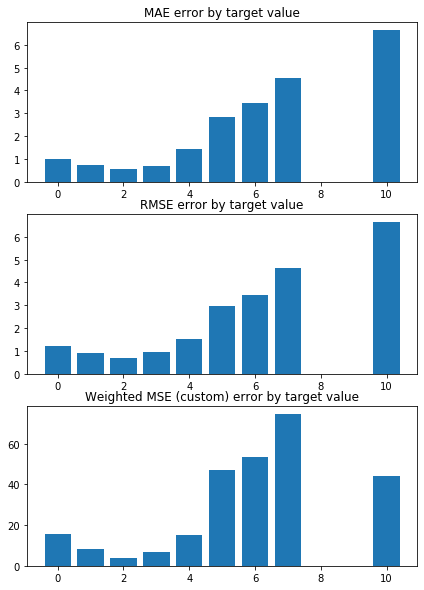

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0608477069146283 


 TRAIN PREDICTION Error
weighted_mse_train: 1.122228179099889 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


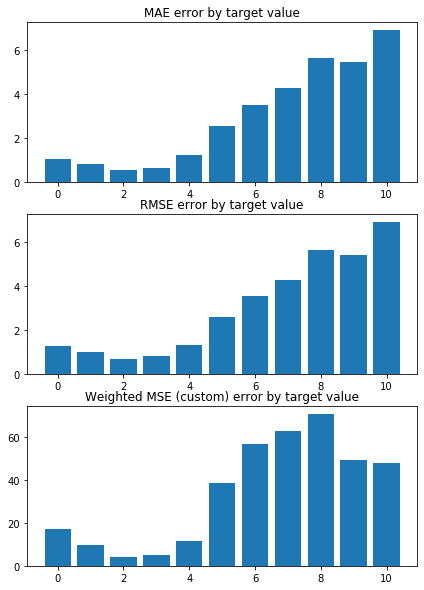

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0518515753607003 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1260751657653847 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


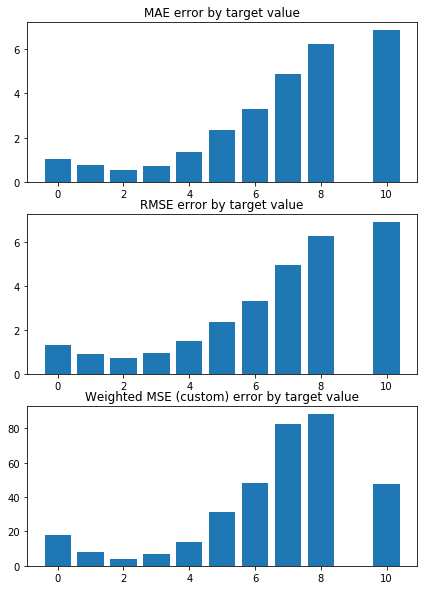

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1567448735053505 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1063982969574633 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


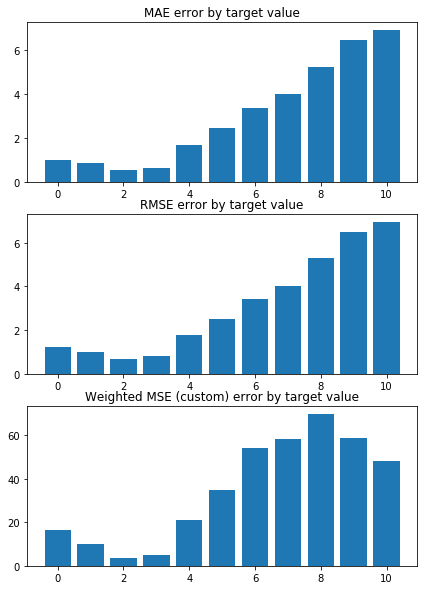

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2651124112299275 


 TRAIN PREDICTION Error
weighted_mse_train: 1.100936864929562 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


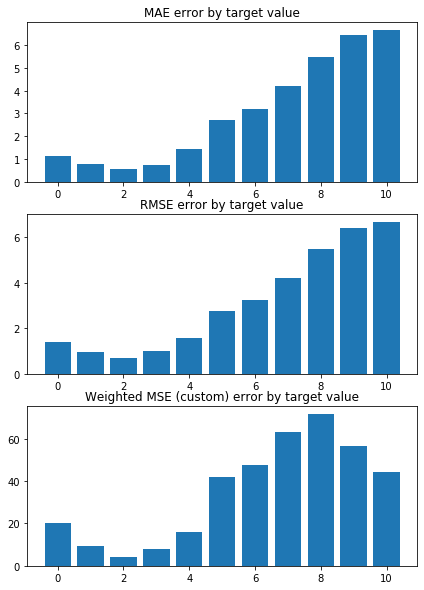

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0965235317746969 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1226287811821356 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


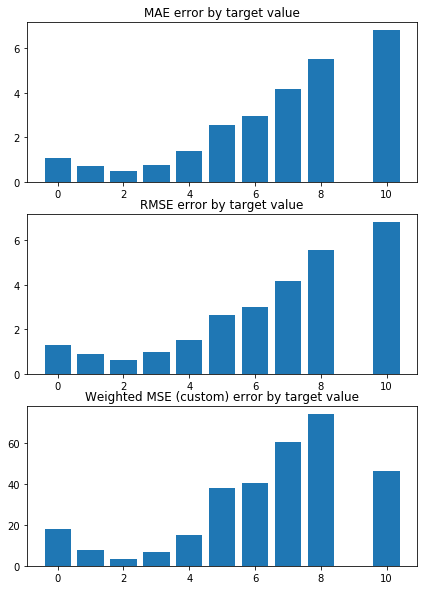

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1891796026699974 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1146893247587866 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


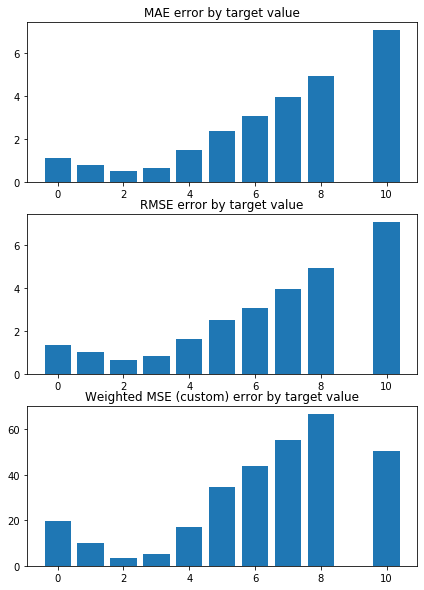

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0906096710611928 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1114197613920744 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


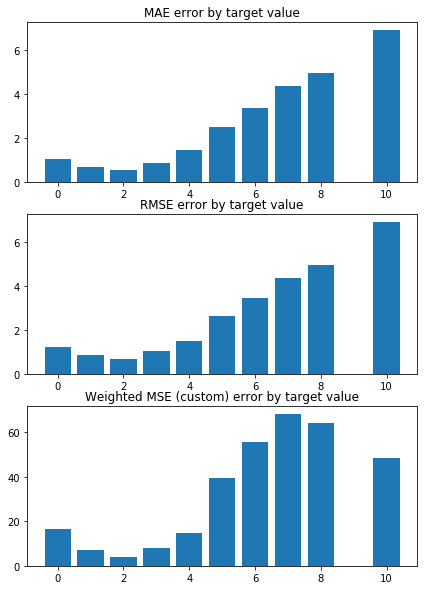

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9867395184021177 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1321601179757736 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


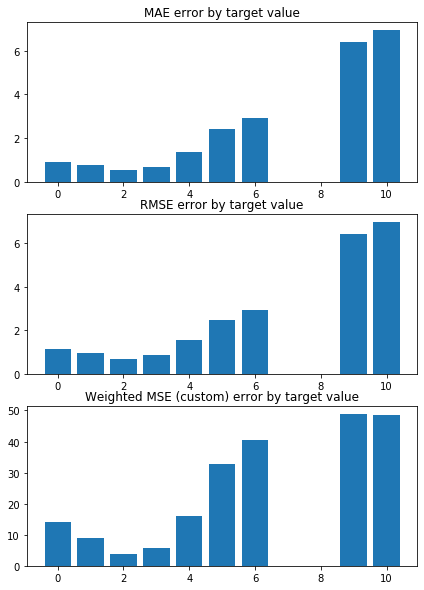

Weighted Mean squared error on Train: 1.12 
 MSE mean train: 2.7236451880526564 

Mean squared error on Test: 1.12 
 MSE mean test:  2.7281935106893966 

Root of MSE on Test: 1.06 
 1.6517244051867117 

Variance score on Test: 0.07 
 r2_test: 0.26309800591658894 

wMSE_train 1.12
wMSE_test 1.12
MSE_train 2.72
MSE_test 2.73
MAE_train 1.08
MAE_test 1.02
r2_test 0.26
   H3K27me1   H3K4me1     CP190     Chriz  H3K36me3  H3K36me1   H3K4me2  \
0 -0.122306 -0.118930 -0.114111 -0.110238 -0.103826 -0.093358 -0.081973   
1 -0.123570 -0.119861 -0.112988 -0.110679 -0.105994 -0.094649 -0.080737   
2 -0.124019 -0.121560 -0.118419 -0.112541 -0.111193 -0.098567 -0.083728   
3 -0.122158 -0.120646 -0.114135 -0.112511 -0.106857 -0.098874 -0.083465   
4 -0.121489 -0.120711 -0.119041 -0.108706 -0.107864 -0.098752 -0.081555   
5 -0.122094 -0.118947 -0.115646 -0.108676 -0.106912 -0.096289 -0.081956   
6 -0.122206 -0.125089 -0.116529 -0.109220 -0.105858 -0.094575 -0.084747   
7 -0.121917 -0.120588 -0.119864 -

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


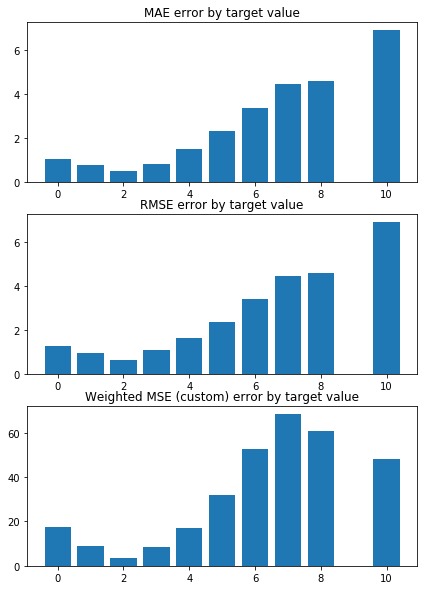

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1255423218346075 


 TRAIN PREDICTION Error
weighted_mse_train: 1.116127874605063 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


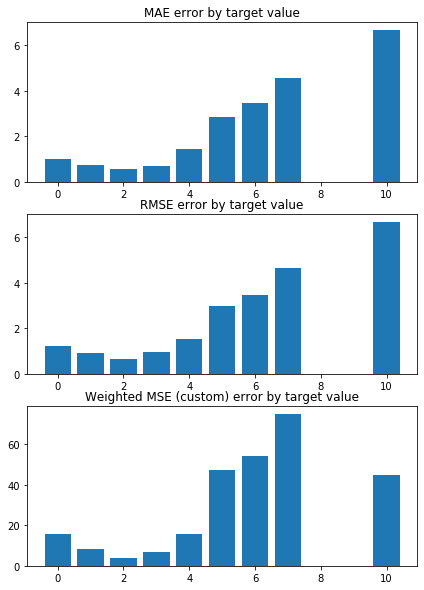

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0586650647331062 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1234571596484184 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


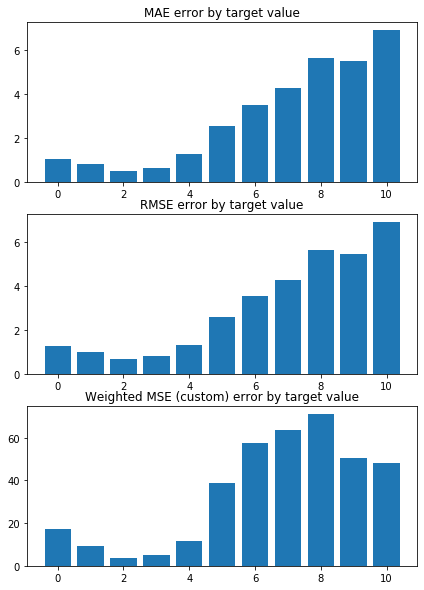

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.050978474124163 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1270440681068317 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


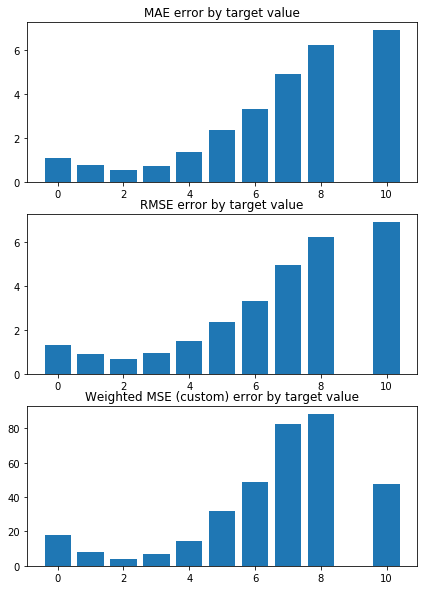

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1583267418554042 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1073988121655478 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


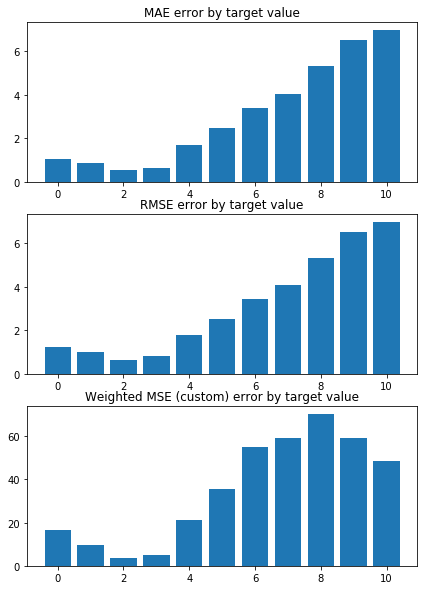

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2651340497461872 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1020265615690008 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


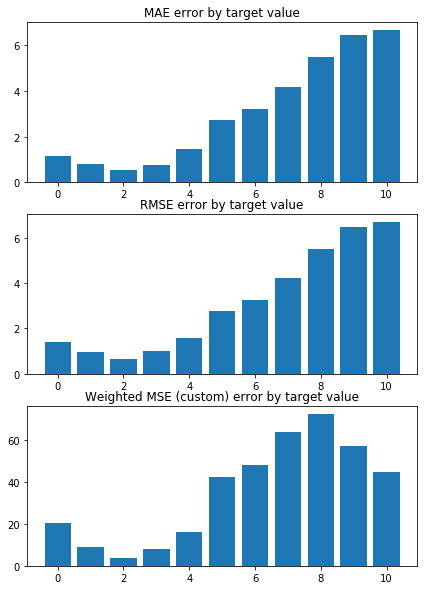

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0976229181056136 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1235065321134037 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


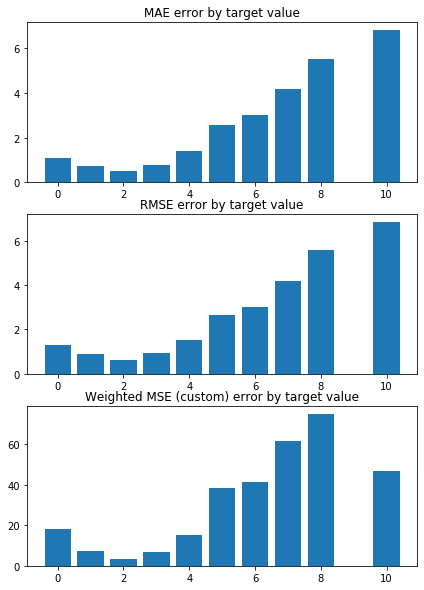

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1898728166602899 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1155030676085875 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


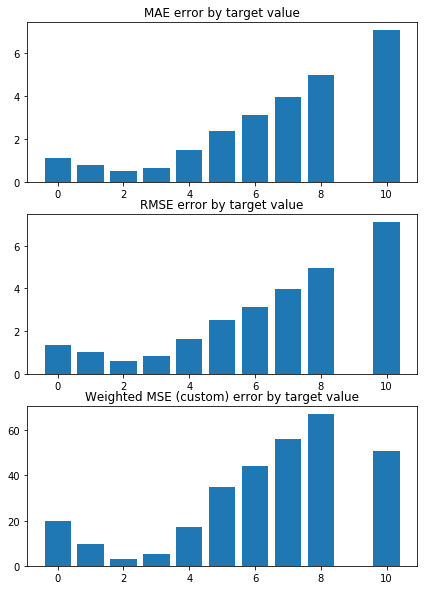

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0927098449051555 


 TRAIN PREDICTION Error
weighted_mse_train: 1.11242889751247 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


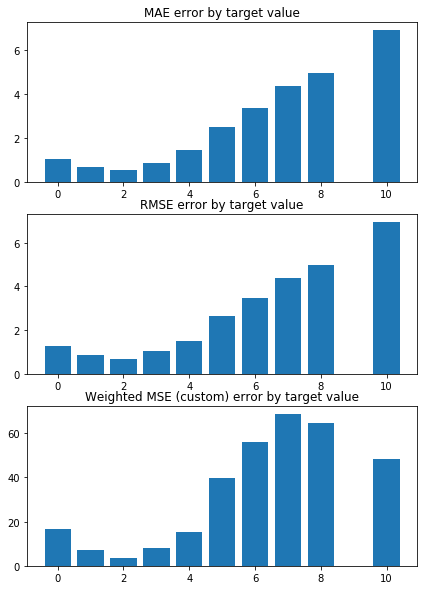

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9877907203920053 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1330823139922495 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


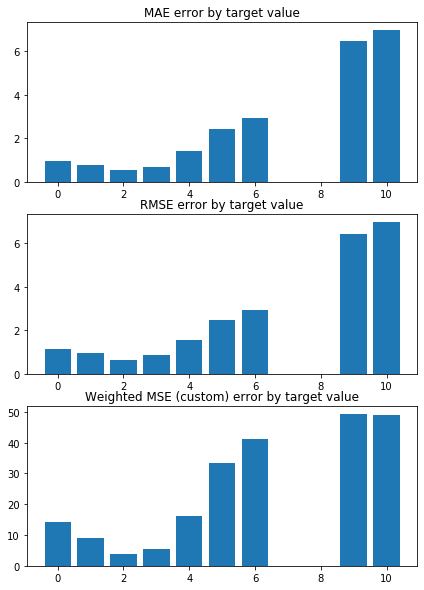

Weighted Mean squared error on Train: 1.12 
 MSE mean train: 2.734444417049185 

Mean squared error on Test: 1.12 
 MSE mean test:  2.738717513690092 

Root of MSE on Test: 1.06 
 1.6549071012265588 

Variance score on Test: 0.08 
 r2_test: 0.2602774543815397 

wMSE_train 1.12
wMSE_test 1.12
MSE_train 2.73
MSE_test 2.74
MAE_train 1.08
MAE_test 1.02
r2_test 0.26
   H3K27me1   H3K4me1     Chriz     CP190  H3K36me3  H3K36me1   H3K4me2  \
0 -0.115854 -0.113587 -0.105390 -0.104862 -0.098876 -0.087270 -0.081632   
1 -0.116966 -0.114338 -0.105725 -0.104059 -0.100693 -0.088414 -0.080538   
2 -0.117451 -0.115949 -0.107465 -0.109053 -0.105335 -0.091918 -0.083226   
3 -0.115855 -0.115187 -0.107468 -0.104975 -0.101577 -0.092224 -0.083033   
4 -0.115198 -0.115193 -0.104042 -0.109335 -0.102321 -0.092071 -0.081283   
5 -0.115682 -0.113613 -0.104045 -0.106258 -0.101518 -0.089911 -0.081607   
6 -0.115798 -0.119102 -0.104477 -0.107347 -0.100499 -0.088561 -0.084103   
7 -0.115572 -0.115037 -0.106694 -0.1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


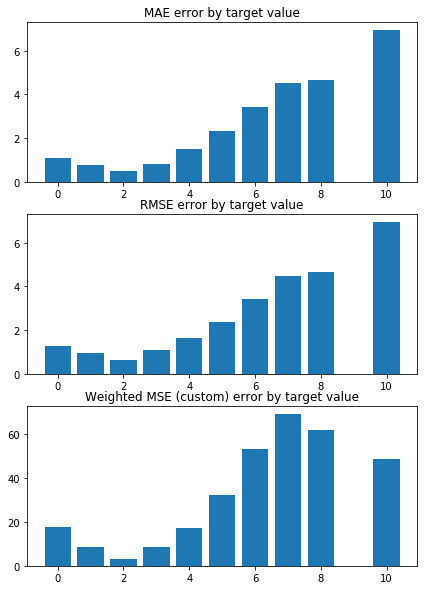

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1276085102120212 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1170787127528792 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


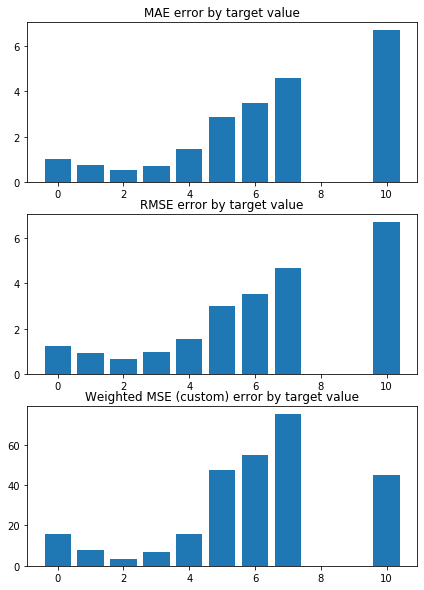

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0569690423088216 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1246922988778163 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


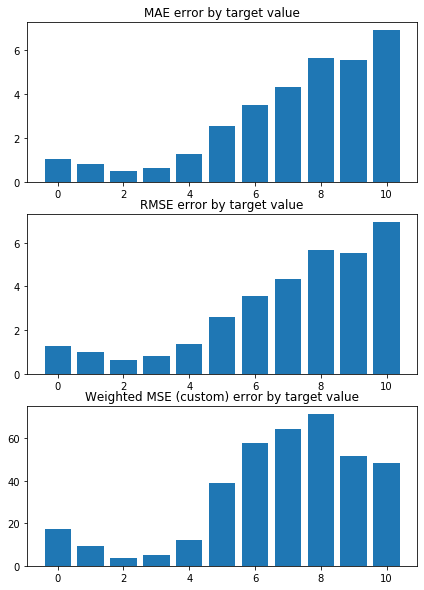

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.050274482309749 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1280326103249316 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


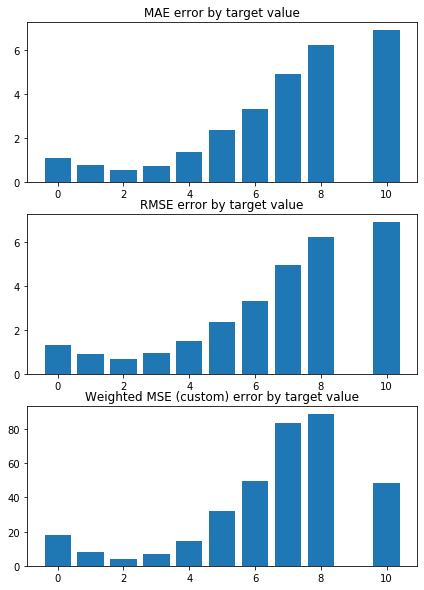

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1599165294989773 


 TRAIN PREDICTION Error
weighted_mse_train: 1.108419391874034 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


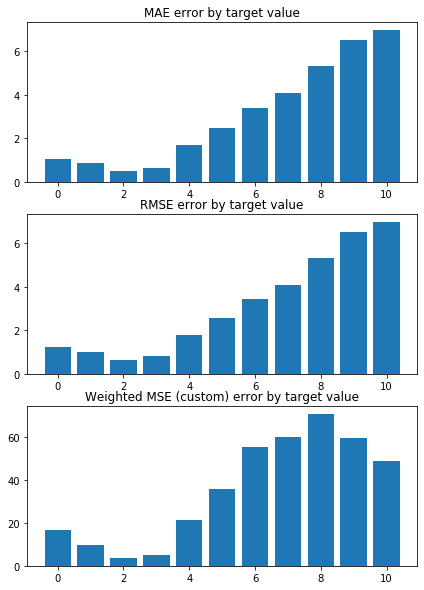

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2652742052479107 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1031369798922332 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


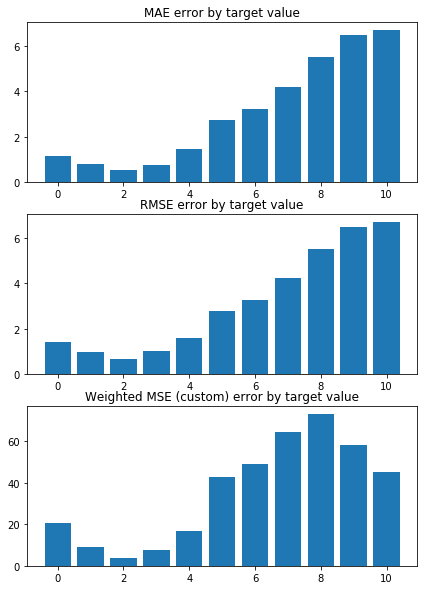

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0986988937517859 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1244418327615755 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


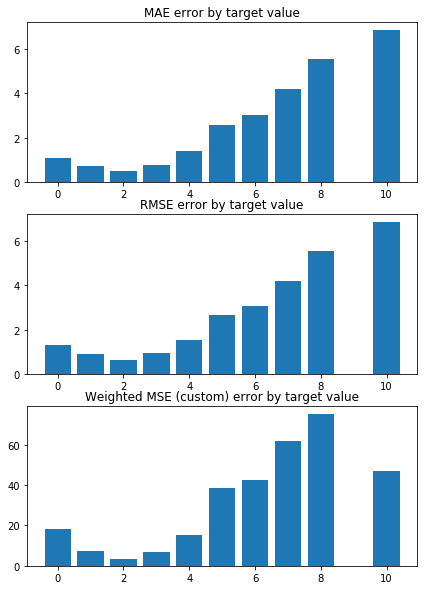

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.190642570775501 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1163745031515844 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


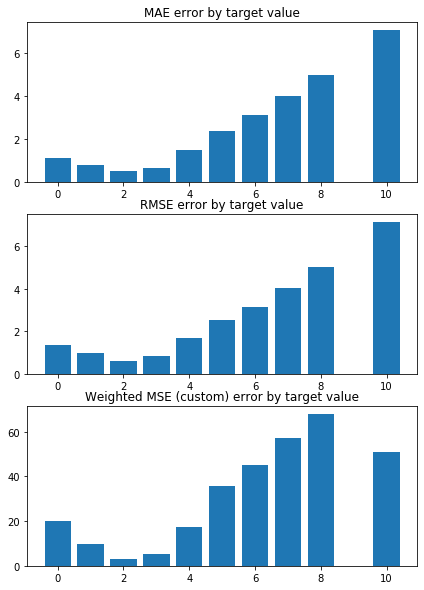

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.094740230304073 


 TRAIN PREDICTION Error
weighted_mse_train: 1.113462372085723 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


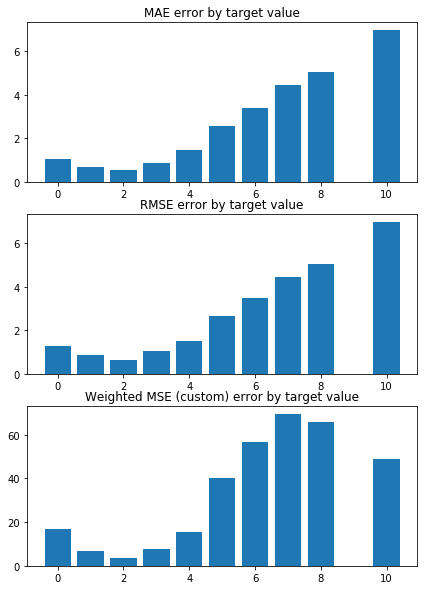

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9889107519231236 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1340506813912392 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


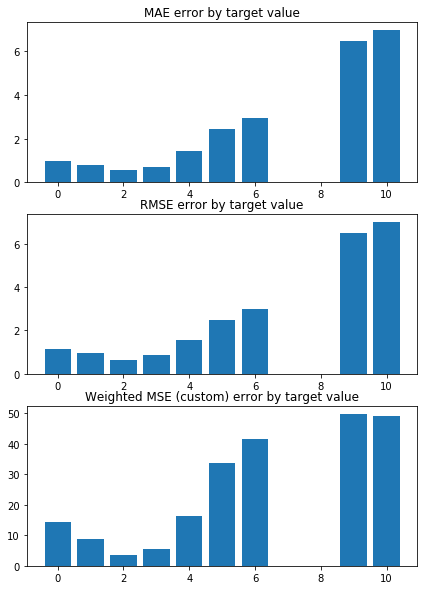

Weighted Mean squared error on Train: 1.12 
 MSE mean train: 2.744409431260861 

Mean squared error on Test: 1.12 
 MSE mean test:  2.7484545021442317 

Root of MSE on Test: 1.06 
 1.6578463445519407 

Variance score on Test: 0.08 
 r2_test: 0.2576674198298554 

wMSE_train 1.12
wMSE_test 1.12
MSE_train 2.74
MSE_test 2.75
MAE_train 1.09
MAE_test 1.03
r2_test 0.26
   H3K27me1   H3K4me1     Chriz     CP190  H3K36me3  H3K36me1   H3K4me2  \
0 -0.110491 -0.109033 -0.101264 -0.097173 -0.094749 -0.082297 -0.081034   
1 -0.111475 -0.109647 -0.101516 -0.096598 -0.096288 -0.083326 -0.080045   
2 -0.111978 -0.111177 -0.103163 -0.101223 -0.100502 -0.086495 -0.082501   
3 -0.110597 -0.110537 -0.103198 -0.097337 -0.097194 -0.086801 -0.082369   
4 -0.109949 -0.110495 -0.100064 -0.101271 -0.097746 -0.086624 -0.080735   
5 -0.110344 -0.109065 -0.100086 -0.098449 -0.097045 -0.084705 -0.081009   
6 -0.110462 -0.114042 -0.100435 -0.099673 -0.096062 -0.083629 -0.083271   
7 -0.110285 -0.110325 -0.102601 -0.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


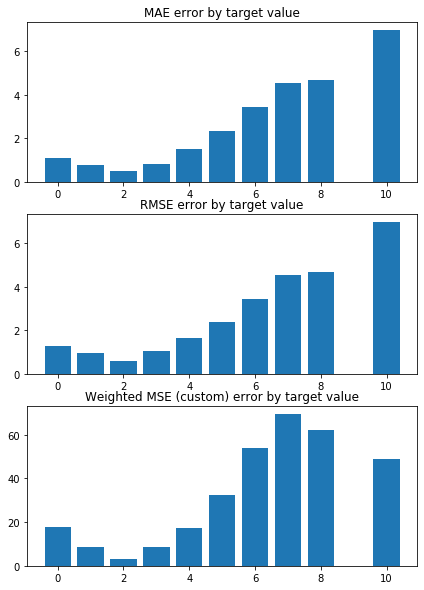

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1296969096725848 


 TRAIN PREDICTION Error
weighted_mse_train: 1.118103902595175 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


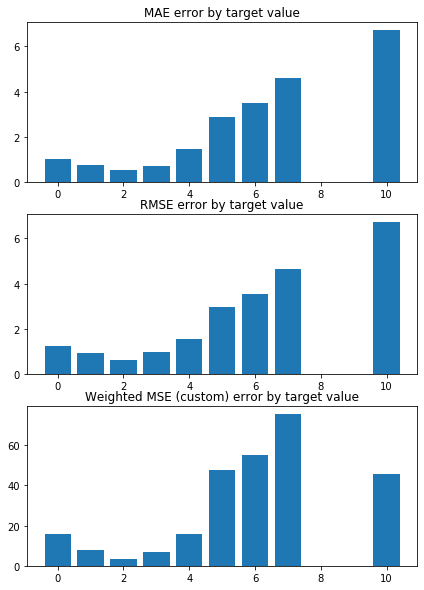

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.055677395924833 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1259671086232093 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


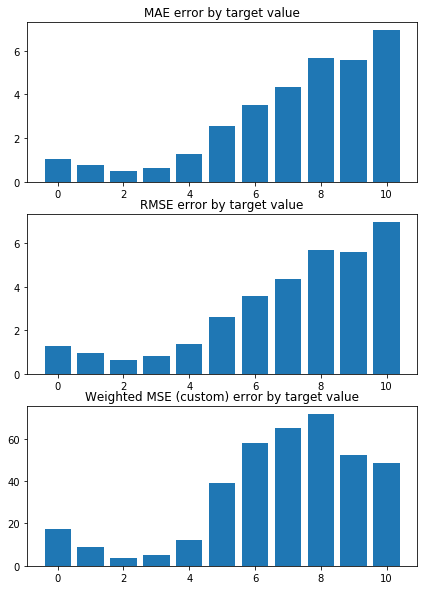

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0497371211466537 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1290732085213575 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


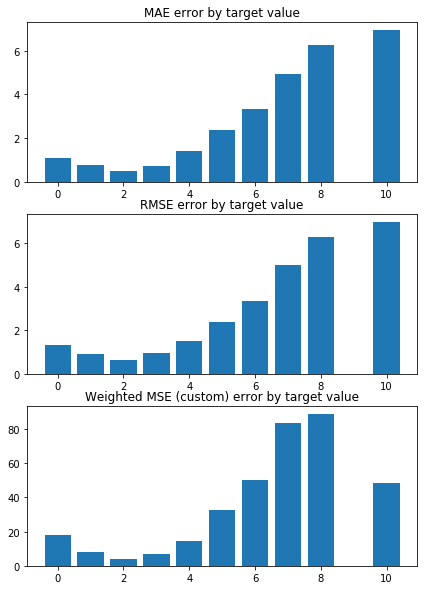

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1615351007695152 


 TRAIN PREDICTION Error
weighted_mse_train: 1.109490419299303 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


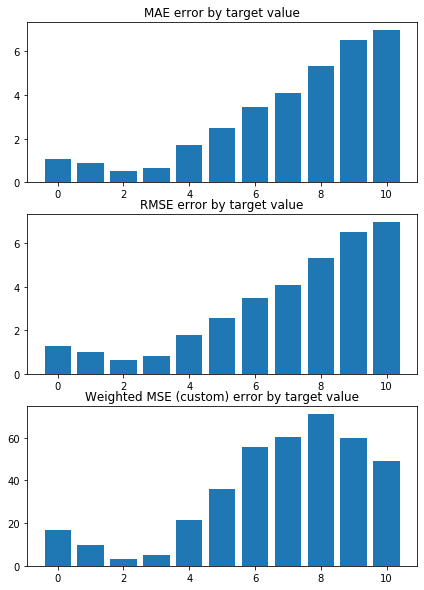

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2655354835926589 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1042991714009107 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


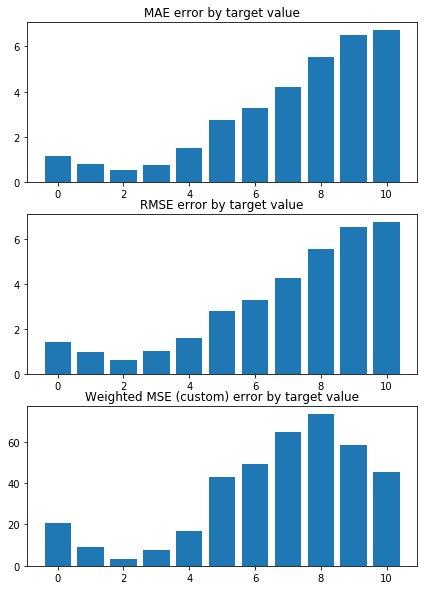

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0998044438179502 


 TRAIN PREDICTION Error
weighted_mse_train: 1.125456949432341 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


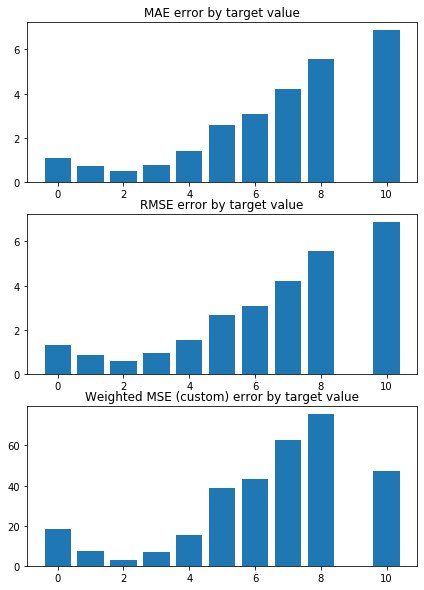

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1915127932501415 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1173260840477648 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


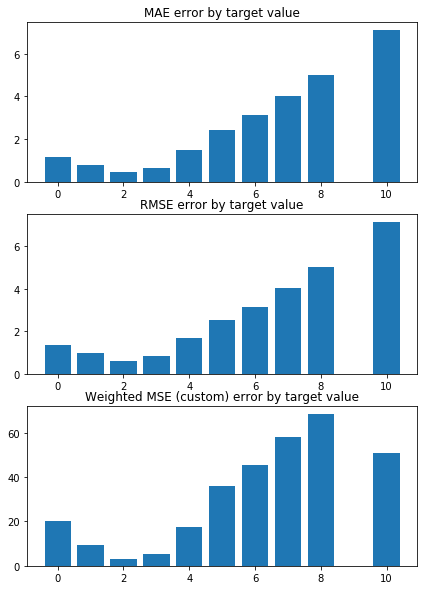

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0967450326484407 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1145497000990394 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


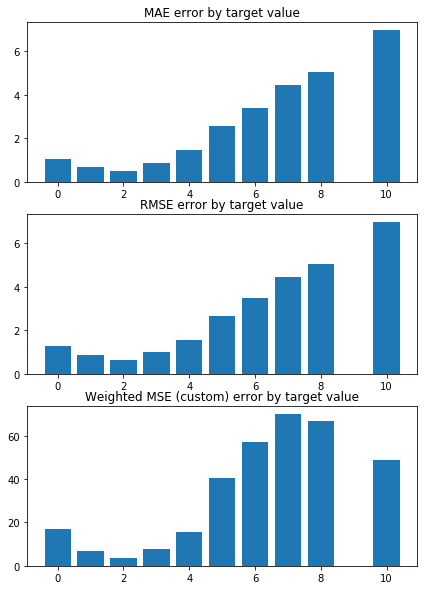

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9901192464480673 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1350899513937487 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


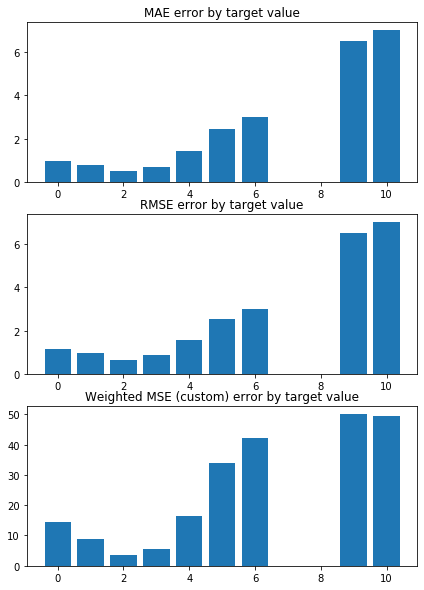

Weighted Mean squared error on Train: 1.12 
 MSE mean train: 2.7537551336996406 

Mean squared error on Test: 1.12 
 MSE mean test:  2.7576073161495094 

Root of MSE on Test: 1.06 
 1.660604503230528 

Variance score on Test: 0.08 
 r2_test: 0.2552134353556298 

wMSE_train 1.12
wMSE_test 1.12
MSE_train 2.75
MSE_test 2.76
MAE_train 1.09
MAE_test 1.03
r2_test 0.26
   H3K27me1   H3K4me1     Chriz  H3K36me3     CP190   H3K4me2  H3K36me1  \
0 -0.105927 -0.105073 -0.097673 -0.091217 -0.090665 -0.080276 -0.078133   
1 -0.106802 -0.105578 -0.097859 -0.092534 -0.090254 -0.079365 -0.079069   
2 -0.107314 -0.107034 -0.099430 -0.096409 -0.094564 -0.081639 -0.081961   
3 -0.106109 -0.106497 -0.099495 -0.093461 -0.090856 -0.081559 -0.082268   
4 -0.105470 -0.106411 -0.096596 -0.093868 -0.094448 -0.080014 -0.082073   
5 -0.105794 -0.105107 -0.096627 -0.093238 -0.091837 -0.080253 -0.080350   
6 -0.105913 -0.109671 -0.096915 -0.092290 -0.093147 -0.082324 -0.079485   
7 -0.105776 -0.106239 -0.099023 -0.

MSE_test_mean  MSE_test_std  MSE_train_mean  MSE_train_std comments  \
0       2.648786      0.159987        2.640322       0.017722        -   
1       2.670077      0.161791        2.663243       0.017661        -   
2       2.688229      0.163748        2.682297       0.017655        -   
3       2.703472      0.165612        2.698142       0.017685        -   
4       2.716588      0.167338        2.711698       0.017737        -   
5       2.728194      0.168929        2.723645       0.017800        -   
6       2.738718      0.170397        2.734444       0.017870        -   
7       2.748455      0.171756        2.744409       0.017943        -   
8       2.757607      0.173019        2.753755       0.018018        -   

                                               model       model_name  \
0  Ridge(alpha=1000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
1  Ridge(alpha=2000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
2  Ridge(alpha=3000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
3  Ridge(alpha=4000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
4  Ridge(alpha=5000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
5  Ridge(alpha=6000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
6  Ridge(alpha=7000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
7  Ridge(alpha=8000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
8  Ridge(alpha=9000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   

   n_splits                  params  \
0      10.0  test_params = testtest   
1      10.0  test_params = testtest   
2      10.0  test_params = testtest   
3      10.0  test_params = testtest   
4      10.0  test_params = testtest   
5      10.0  test_params = testtest   
6      10.0  test_params = testtest   
7      10.0  test_params = testtest   
8      10.0  test_params = testtest   

                                             r2_test  wMSE_test_mean  \
0  [0.2918282571003348, 0.3328880119631208, 0.262...        1.118434   
1  [0.28341377745575747, 0.32388081130388513, 0.2...        1.115625   
2  [0.27684219529817444, 0.3168635855108799, 0.26...        1.115706   
3  [0.27152308343195486, 0.31120260226407725, 0.2...        1.116384   
4  [0.2670492001806922, 0.30644189514067866, 0.25...        1.117174   
5  [0.2631604771268381, 0.30229357865814044, 0.25...        1.117990   
6  [0.2596891632473096, 0.29857476749334744, 0.25...        1.118838   
7  [0.2565242129325147, 0.29516623536939723, 0.25...        1.119744   
8  [0.2535900950803126, 0.29198810243309603, 0.24...        1.120728   

   wMSE_test_std  wMSE_train_mean  wMSE_train_std  
0       0.073355         1.114726        0.009348  
1       0.073482         1.112716        0.009245  
2       0.073814         1.113226        0.009185  
3       0.074170         1.114181        0.009146  
4       0.074511         1.115169        0.009121  
5       0.074826         1.116134        0.009104  
6       0.075117         1.117101        0.009093  
7       0.075384         1.118103        0.009086  
8       0.075632         1.119167        0.009083

In [123]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

alpha_grid = np.arange(1000, 10000, 1000)
# Create linear regression object



model_name = 'LR+L2_grid10000'
n_splits = 10
random_state = 16 
shuffle = True

wmse_test = []
wmse_train = []

results_pd_gr = pd.DataFrame()

for alpha in alpha_grid:
    model = linear_model.Ridge(alpha=alpha)

    lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                    weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                    rmse_test, rmse_train, rmse_test_const, \
                    mae_test,    mae_train,  mae_test_const, \
                    results_pd_gr = train_test_KFold(X, y, 
                                                  model, model_name, results_pd_gr,
                                                  n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    wmse_test.append(np.mean(weighted_mse_test_all))
    wmse_train.append(np.mean(weighted_mse_train_all))

results_pd_gr

In [124]:
results_pd_gr

MSE_test_mean  MSE_test_std  MSE_train_mean  MSE_train_std comments  \
0       2.648786      0.159987        2.640322       0.017722        -   
1       2.670077      0.161791        2.663243       0.017661        -   
2       2.688229      0.163748        2.682297       0.017655        -   
3       2.703472      0.165612        2.698142       0.017685        -   
4       2.716588      0.167338        2.711698       0.017737        -   
5       2.728194      0.168929        2.723645       0.017800        -   
6       2.738718      0.170397        2.734444       0.017870        -   
7       2.748455      0.171756        2.744409       0.017943        -   
8       2.757607      0.173019        2.753755       0.018018        -   

                                               model       model_name  \
0  Ridge(alpha=1000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
1  Ridge(alpha=2000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
2  Ridge(alpha=3000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
3  Ridge(alpha=4000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
4  Ridge(alpha=5000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
5  Ridge(alpha=6000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
6  Ridge(alpha=7000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
7  Ridge(alpha=8000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   
8  Ridge(alpha=9000, copy_X=True, fit_intercept=T...  LR+L2_grid10000   

   n_splits                  params  \
0      10.0  test_params = testtest   
1      10.0  test_params = testtest   
2      10.0  test_params = testtest   
3      10.0  test_params = testtest   
4      10.0  test_params = testtest   
5      10.0  test_params = testtest   
6      10.0  test_params = testtest   
7      10.0  test_params = testtest   
8      10.0  test_params = testtest   

                                             r2_test  wMSE_test_mean  \
0  [0.2918282571003348, 0.3328880119631208, 0.262...        1.118434   
1  [0.28341377745575747, 0.32388081130388513, 0.2...        1.115625   
2  [0.27684219529817444, 0.3168635855108799, 0.26...        1.115706   
3  [0.27152308343195486, 0.31120260226407725, 0.2...        1.116384   
4  [0.2670492001806922, 0.30644189514067866, 0.25...        1.117174   
5  [0.2631604771268381, 0.30229357865814044, 0.25...        1.117990   
6  [0.2596891632473096, 0.29857476749334744, 0.25...        1.118838   
7  [0.2565242129325147, 0.29516623536939723, 0.25...        1.119744   
8  [0.2535900950803126, 0.29198810243309603, 0.24...        1.120728   

   wMSE_test_std  wMSE_train_mean  wMSE_train_std  
0       0.073355         1.114726        0.009348  
1       0.073482         1.112716        0.009245  
2       0.073814         1.113226        0.009185  
3       0.074170         1.114181        0.009146  
4       0.074511         1.115169        0.009121  
5       0.074826         1.116134        0.009104  
6       0.075117         1.117101        0.009093  
7       0.075384         1.118103        0.009086  
8       0.075632         1.119167        0.009083

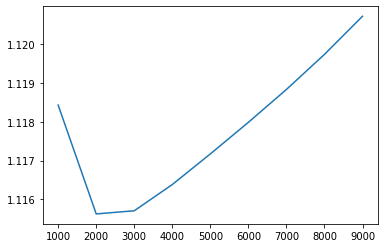

In [125]:
plt.plot(alpha_grid, wmse_test)

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1471357919215017 


 TRAIN PREDICTION Error
weighted_mse_train: 1.107100111092979 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6918784159536415
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


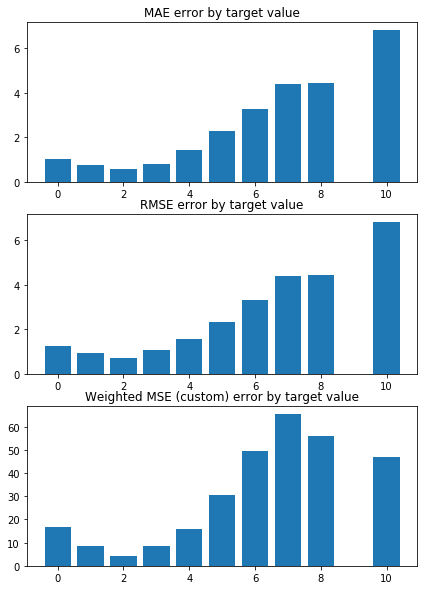

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.116399335105701 


 TRAIN PREDICTION Error
weighted_mse_train: 1.112637792649221 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


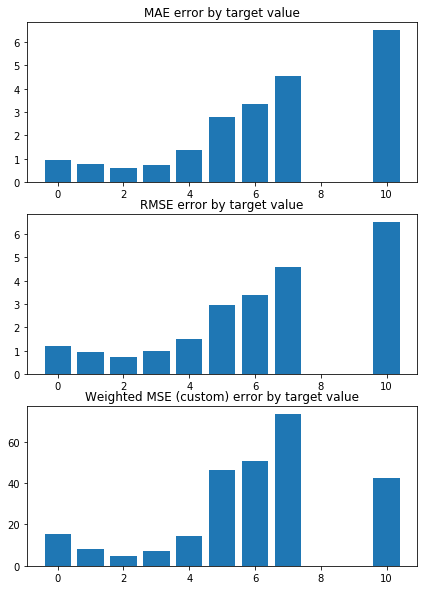

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.072530718783873 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1182624153611356 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


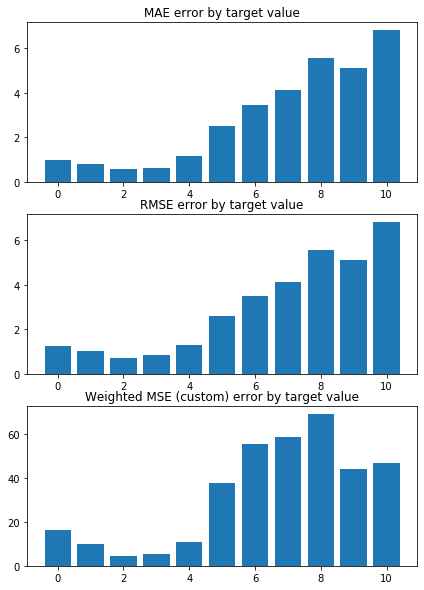

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0559200618569282 


 TRAIN PREDICTION Error
weighted_mse_train: 1.122990939209559 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


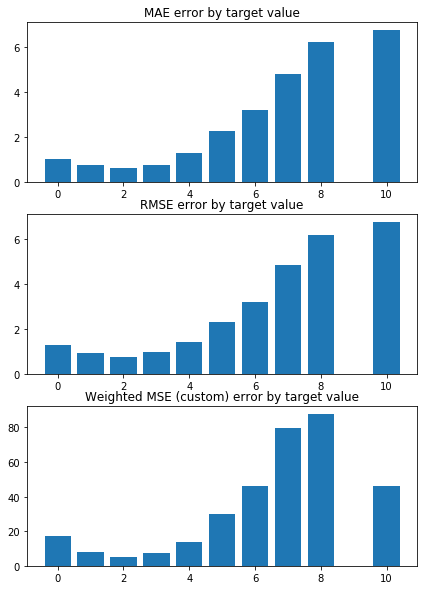

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.152220927424399 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1032870731317805 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


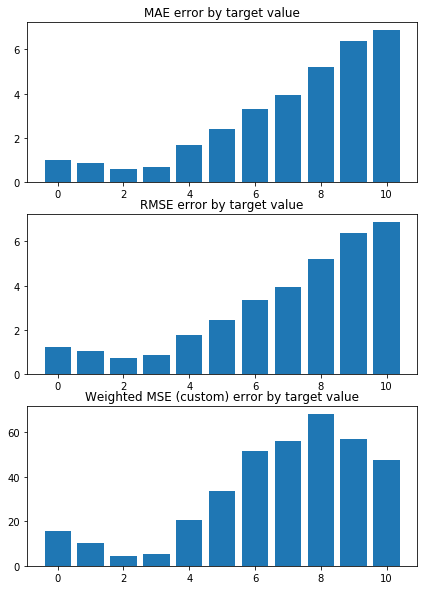

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.266147872840521 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0975016977153997 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


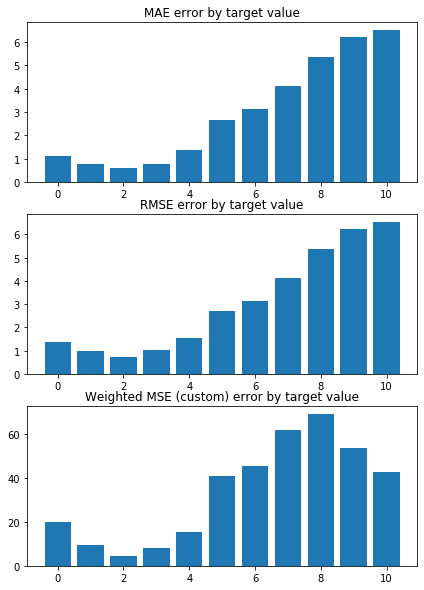

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.092202659703217 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1202117211648164 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


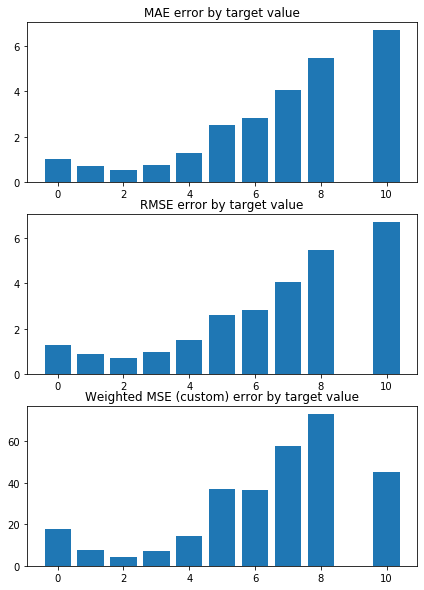

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1873003119759995 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1124793118978533 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


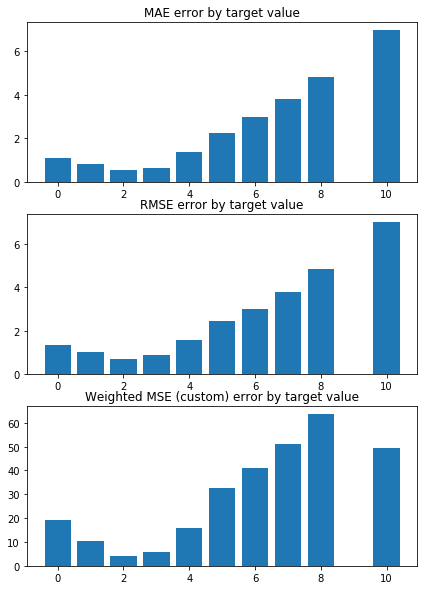

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0832534779123695 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1082759267281648 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


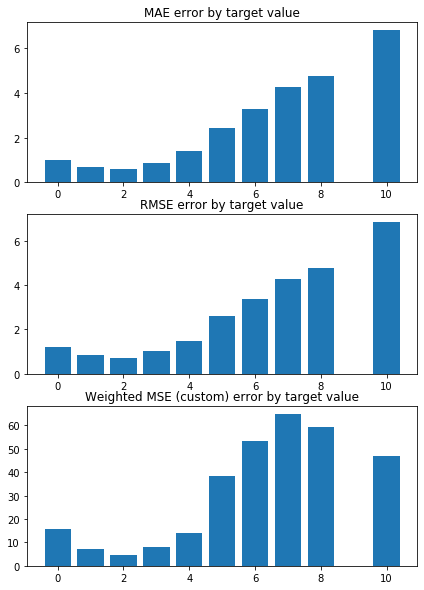

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9839460010766412 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1295083089409097 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


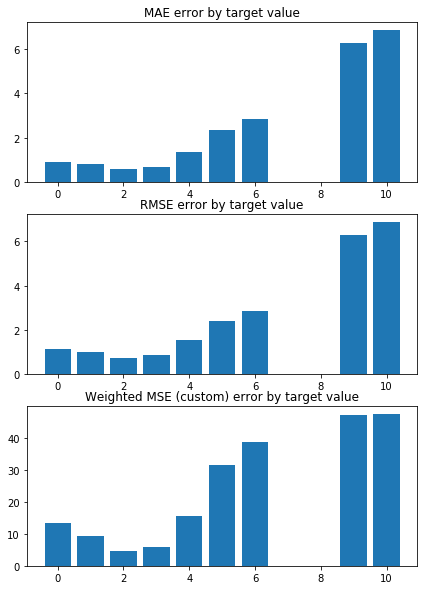

Weighted Mean squared error on Train: 1.11 
 MSE mean train: 2.6822968579254503 

Mean squared error on Test: 1.12 
 MSE mean test:  2.688228552305251 

Root of MSE on Test: 1.06 
 1.6395818223880292 

Variance score on Test: 0.07 
 r2_test: 0.2738080207091959 

wMSE_train 1.11
wMSE_test 1.12
MSE_train 2.68
MSE_test 2.69
MAE_train 1.08
MAE_test 1.02
r2_test 0.27
      CP190  H3K27me1   H3K4me1     Chriz  H3K36me3  H3K36me1   H3K4me3  \
0 -0.158956 -0.154637 -0.143868 -0.133501 -0.128806 -0.125203 -0.085174   
1 -0.155528 -0.156561 -0.145992 -0.134608 -0.132982 -0.127382 -0.085385   
2 -0.162966 -0.156505 -0.147848 -0.137209 -0.141724 -0.133507 -0.080608   
3 -0.158009 -0.153318 -0.146134 -0.137143 -0.133916 -0.133825 -0.082467   
4 -0.166144 -0.152529 -0.146413 -0.130967 -0.136849 -0.133917 -0.081571   
5 -0.161064 -0.153957 -0.143771 -0.130545 -0.134565 -0.129766 -0.083146   
6 -0.160277 -0.154010 -0.153878 -0.131924 -0.133429 -0.125692 -0.082584   
7 -0.166219 -0.153394 -0.146823 -0.

In [126]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# alpha_grid = np.arange(3000, 10000, 100)
# Create linear regression object


wmse_test = []
wmse_train = []

# for alpha in alpha_grid:
model = linear_model.Ridge(alpha=3000)


model_name = 'LR+L2_alf=3000'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)



wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [127]:
coefs_argsort, np.sort(coefs)

(array([[ 4, 12,  6,  0, 15, 14,  8,  2,  7,  3,  5, 13, 17,  1, 10,  9,
         11, 16],
        [12,  4,  6,  0, 15, 14,  8,  3,  7,  2,  5, 13, 17,  1,  9, 10,
         11, 16],
        [ 4, 12,  6, 15,  0, 14,  7,  8,  3, 13,  2,  5, 17, 10,  9,  1,
         11, 16],
        [ 4, 12,  6,  0, 15, 14,  8,  7,  3,  2, 13,  5, 17, 10,  1,  9,
         11, 16],
        [ 4, 12,  6, 15, 14,  0,  8,  7,  2,  3, 13,  5, 17, 10,  1,  9,
         11, 16],
        [ 4, 12,  6, 15,  0, 14,  8,  7,  3,  2, 13,  5, 17,  1,  9, 10,
         11, 16],
        [ 4, 12,  6, 15,  0, 14,  7,  8,  3,  2,  5, 13, 17,  9,  1, 10,
         11, 16],
        [ 4, 12,  6, 15,  0, 14,  8,  7,  2,  3, 13,  5, 17,  1, 10,  9,
         11, 16],
        [ 4, 12,  6,  0, 15, 14,  8,  7,  2,  3,  5, 13, 17,  9,  1, 10,
         11, 16],
        [ 4,  6, 12,  0, 15, 14,  8,  7,  3, 13,  2,  5, 17, 10,  9,  1,
         11, 16]]),
 array([[-0.15895591, -0.15463653, -0.14386759, -0.13350051, -0.12880629,
         -0.12

In [128]:
su_drsc.columns[2:][coefs_argsort[0]]

Index(['CP190', 'H3K27me1', 'H3K4me1', 'Chriz', 'H3K36me3', 'H3K36me1',
       'H3K4me3', 'Su(Hw)', 'H3K4me2', 'BEAF-32', 'GAF', 'H3K27me3',
       'RNA-polymerase-II', 'CTCF', 'H3K9me3', 'H3K9me2', 'H3K27ac',
       'H4K16ac'],
      dtype='object')

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS  + L2

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1416716252226309 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1067730771252773 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6918784159536415
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


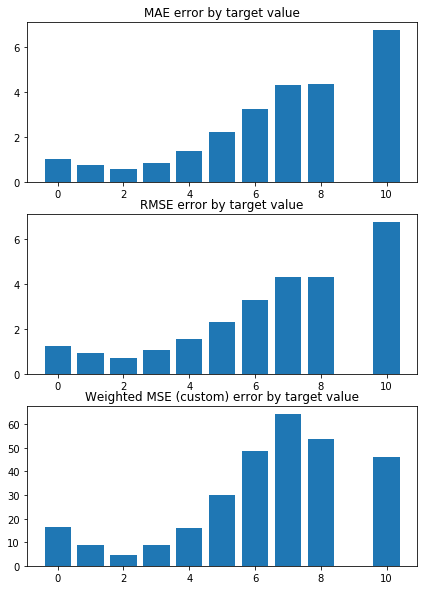

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1138935138264003 


 TRAIN PREDICTION Error
weighted_mse_train: 1.112253398847069 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


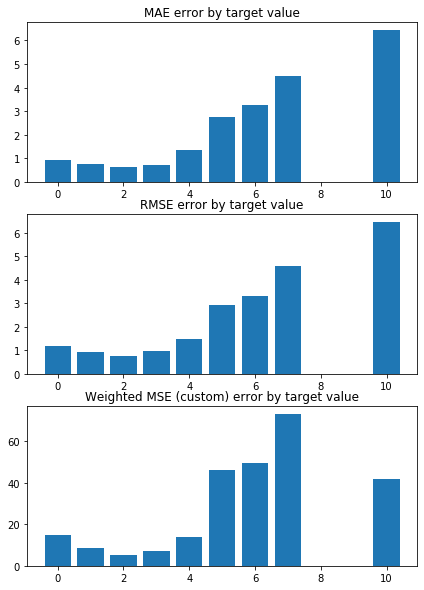

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0807226261664178 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1172665244615234 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


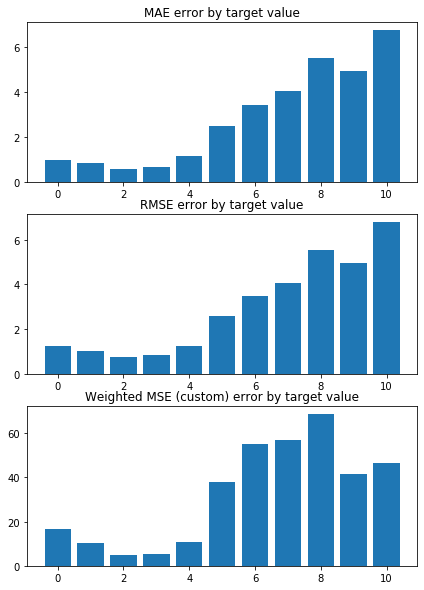

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0587498366132417 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1223275564804103 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


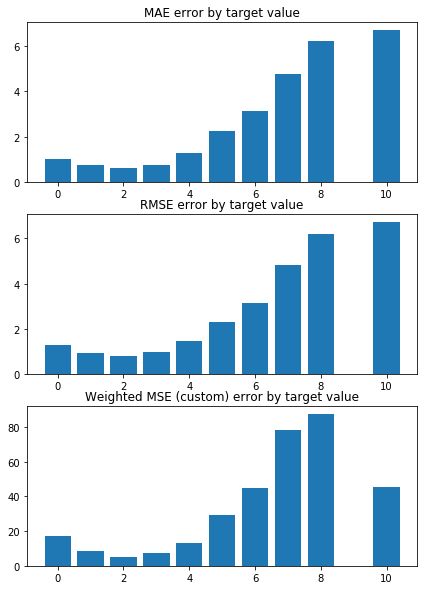

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1518411176136423 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1027205015936834 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


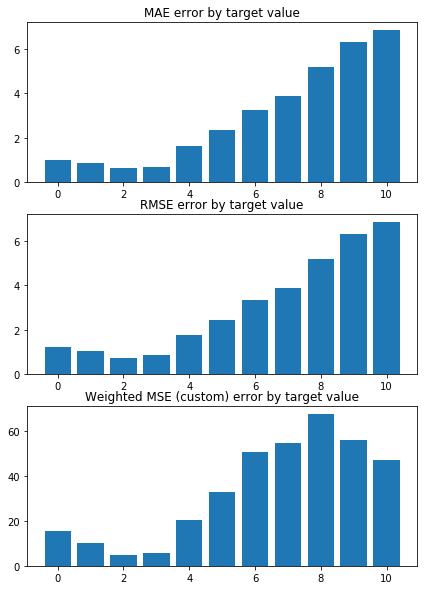

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.267855112472492 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0967096976895474 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


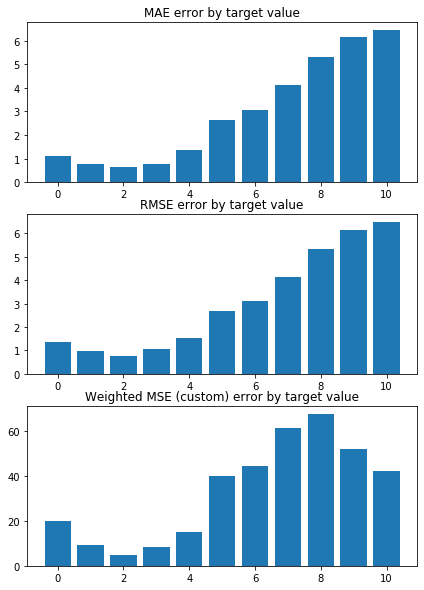

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0902558550741934 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1199875237727963 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


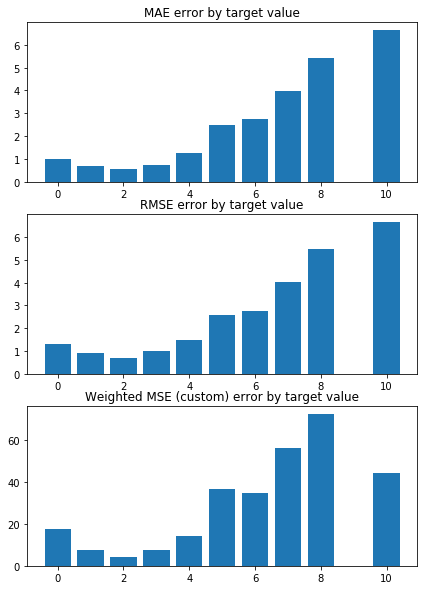

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.187057198647839 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1123527930255082 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


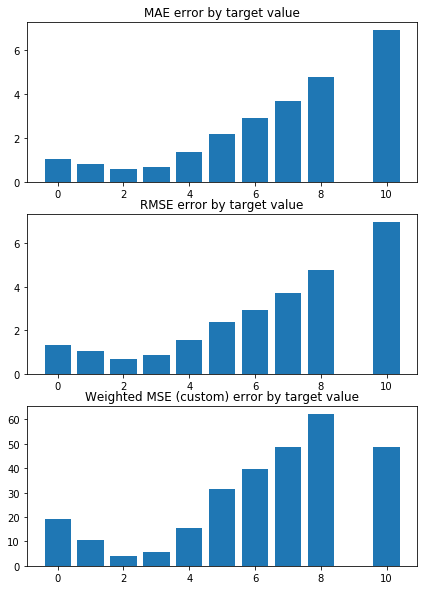

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0804557575049596 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1075996920679876 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


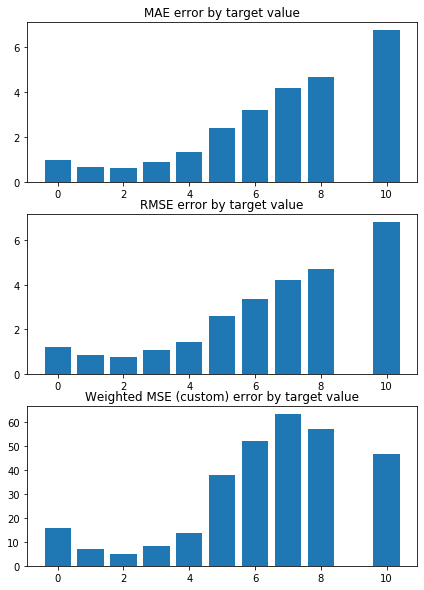

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9837443977683009 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1291705075758367 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


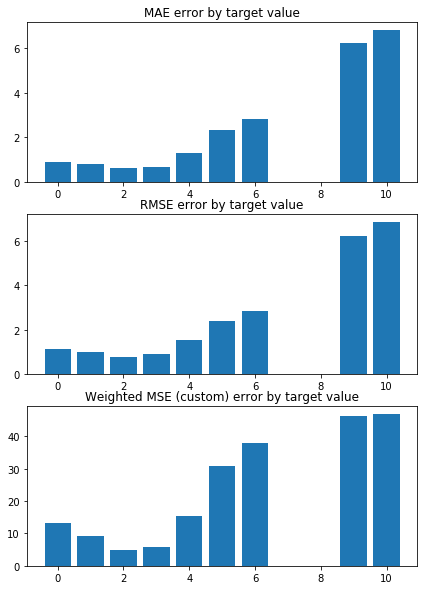

Weighted Mean squared error on Train: 1.11 
 MSE mean train: 2.663242639521141 

Mean squared error on Test: 1.12 
 MSE mean test:  2.670077043898872 

Root of MSE on Test: 1.06 
 1.634037038716954 

Variance score on Test: 0.07 
 r2_test: 0.2786711114335788 

wMSE_train 1.11
wMSE_test 1.12
MSE_train 2.66
MSE_test 2.67
MAE_train 1.08
MAE_test 1.01
r2_test 0.28
      CP190  H3K27me1   H3K4me1     Chriz  H3K36me1  H3K36me3  H3K27me3  \
0 -0.185396 -0.175123 -0.158494 -0.148429 -0.146368 -0.145226 -0.090858   
1 -0.179987 -0.177294 -0.161706 -0.150121 -0.149257 -0.150890 -0.091189   
2 -0.188499 -0.176517 -0.163291 -0.153306 -0.156917 -0.162628 -0.104770   
3 -0.183353 -0.172602 -0.161016 -0.153345 -0.157227 -0.152097 -0.098660   
4 -0.193927 -0.171592 -0.161339 -0.145164 -0.157540 -0.156877 -0.104544   
5 -0.187744 -0.173826 -0.158231 -0.144226 -0.152157 -0.153095 -0.093802   
6 -0.185464 -0.173780 -0.171645 -0.146456 -0.146113 -0.151921 -0.095073   
7 -0.193180 -0.172989 -0.162526 -0.14

In [129]:
%%time
n_splits=10
random_state=16

X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# alpha_grid = np.arange(3000, 10000, 100)
# Create linear regression object


wmse_test = []
wmse_train = []

# for alpha in alpha_grid:
model = linear_model.Ridge(alpha=2000)

model_name = 'LR+L2_alf=2000'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)

wmse_test.append(np.mean(weighted_mse_test_all))
wmse_train.append(np.mean(weighted_mse_train_all))


wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [130]:
results_pd

model_name wMSE_test_mean wMSE_test_std wMSE_train_mean  \
0            test_model            160             1              16   
1     LR+L1_no_outliers       0.923253     0.0347824        0.916697   
2                    LR        1.13867     0.0750751         1.13198   
3                 LR+L1        1.61552      0.092714          1.6149   
4  LR+L1_alf=0.2_spt=10        1.12173      0.070063          1.1202   
5        LR+L2_alf=3000        1.11571     0.0738139         1.11323   
6        LR+L2_alf=2000        1.11562     0.0734816         1.11272   

  wMSE_train_std comments                  params  MSE_test_mean  \
0              3  no coms  test_params = testtest            NaN   
1     0.00763124        -  test_params = testtest       1.392874   
2     0.00978238        -  test_params = testtest       2.634009   
3      0.0115859        -  test_params = testtest       3.708353   
4     0.00824059        -  test_params = testtest       2.768352   
5     0.00918478        -  test_params = testtest       2.688229   
6     0.00924482        -  test_params = testtest       2.670077   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0           NaN             NaN            NaN   
1      0.042988        1.382760       0.010296   
2      0.159500        2.619701       0.017773   
3      0.221185        3.707263       0.024586   
4      0.170443        2.765067       0.016531   
5      0.163748        2.682297       0.017655   
6      0.161791        2.663243       0.017661   

                                             r2_test n_splits  \
0                                                NaN      NaN   
1  [0.3173100836941761, 0.33173764707849474, 0.30...        5   
2  [0.30233272815667, 0.3418028647562872, 0.25460...       10   
3  [-0.0005277141720481104, -2.210887072906509e-0...       10   
4  [0.24862101980287654, 0.2826266315081707, 0.24...       10   
5  [0.27684219529817444, 0.3168635855108799, 0.26...       10   
6  [0.28341377745575747, 0.32388081130388513, 0.2...       10   

                                               model  
0                                                NaN  
1  LinearRegression(copy_X=True, fit_intercept=Tr...  
2  LinearRegression(copy_X=True, fit_intercept=Tr...  
3  Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...  
4  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...  
5  Ridge(alpha=3000, copy_X=True, fit_intercept=T...  
6  Ridge(alpha=2000, copy_X=True, fit_intercept=T...

In [131]:
wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)

wmse_mean_train, wmse_mean_test = 1.112716127263964 1.1156247040910119


In [132]:
su_drsc.columns[2:][coefs_argsort[0]]

Index(['CP190', 'H3K27me1', 'H3K4me1', 'Chriz', 'H3K36me1', 'H3K36me3',
       'H3K27me3', 'Su(Hw)', 'H3K4me3', 'H3K4me2', 'BEAF-32', 'GAF',
       'RNA-polymerase-II', 'CTCF', 'H3K9me3', 'H3K9me2', 'H3K27ac',
       'H4K16ac'],
      dtype='object')

In [133]:
su_drsc.columns[2:], coefs

(Index(['Chriz', 'CTCF', 'Su(Hw)', 'BEAF-32', 'CP190', 'GAF', 'H3K4me1',
        'H3K4me2', 'H3K4me3', 'H3K9me2', 'H3K9me3', 'H3K27ac', 'H3K27me1',
        'H3K27me3', 'H3K36me1', 'H3K36me3', 'H4K16ac', 'RNA-polymerase-II'],
       dtype='object'),
 array([[-1.48428851e-01,  4.25512605e-02,  9.06630439e-02,
         -6.86845523e-02, -1.85395611e-01, -5.67109580e-02,
         -1.58494142e-01, -7.37356464e-02, -8.65213307e-02,
          3.85899256e-02, -3.96373553e-02, -7.96070181e-03,
         -1.75123115e-01, -9.08579263e-02, -1.46367947e-01,
         -1.45225525e-01,  1.62069983e-03, -4.70525059e-02],
        [-1.50120903e-01,  3.95608714e-02,  7.47901139e-02,
         -7.54362814e-02, -1.79987142e-01, -6.15373147e-02,
         -1.61705915e-01, -7.03800958e-02, -8.64662890e-02,
          3.36414026e-02, -2.80891957e-02, -3.62117178e-03,
         -1.77293904e-01, -9.11885955e-02, -1.49257099e-01,
         -1.50889617e-01, -2.62738894e-05, -4.15532196e-02],
        [-1.53306341e-01,  2.

In [134]:
coefs_argsort

array([[ 4, 12,  6,  0, 14, 15, 13,  2,  8,  7,  3,  5, 17,  1, 10,  9,
        11, 16],
       [ 4, 12,  6, 15,  0, 14, 13,  8,  3,  2,  7,  5, 17,  1,  9, 10,
        11, 16],
       [ 4, 12,  6, 15, 14,  0, 13,  8,  7,  2,  3,  5, 17, 10,  9,  1,
        16, 11],
       [ 4, 12,  6, 14,  0, 15, 13,  2,  8,  7,  3,  5, 10, 17,  1,  9,
        11, 16],
       [ 4, 12,  6, 14, 15,  0, 13,  2,  8,  7,  3,  5, 10, 17,  1,  9,
        11, 16],
       [ 4, 12,  6, 15, 14,  0, 13,  2,  8,  7,  3,  5, 17,  1,  9, 10,
        11, 16],
       [ 4, 12,  6, 15,  0, 14, 13,  8,  7,  2,  3,  5, 17,  9,  1, 10,
        11, 16],
       [ 4, 12,  6, 15, 14,  0, 13,  8,  2,  7,  3, 17,  5, 10,  1,  9,
        11, 16],
       [ 4, 12,  6, 14, 15,  0, 13,  8,  2,  7,  3,  5, 17,  9, 10,  1,
        11, 16],
       [ 4,  6, 12, 14,  0, 15, 13,  8,  7,  3,  2,  5, 17, 10,  9,  1,
        11, 16]])

In [135]:
su_drsc.columns[2:][coefs_argsort[0]]

Index(['CP190', 'H3K27me1', 'H3K4me1', 'Chriz', 'H3K36me1', 'H3K36me3',
       'H3K27me3', 'Su(Hw)', 'H3K4me3', 'H3K4me2', 'BEAF-32', 'GAF',
       'RNA-polymerase-II', 'CTCF', 'H3K9me3', 'H3K9me2', 'H3K27ac',
       'H4K16ac'],
      dtype='object')

In [136]:
coefs

array([[-1.48428851e-01,  4.25512605e-02,  9.06630439e-02,
        -6.86845523e-02, -1.85395611e-01, -5.67109580e-02,
        -1.58494142e-01, -7.37356464e-02, -8.65213307e-02,
         3.85899256e-02, -3.96373553e-02, -7.96070181e-03,
        -1.75123115e-01, -9.08579263e-02, -1.46367947e-01,
        -1.45225525e-01,  1.62069983e-03, -4.70525059e-02],
       [-1.50120903e-01,  3.95608714e-02,  7.47901139e-02,
        -7.54362814e-02, -1.79987142e-01, -6.15373147e-02,
        -1.61705915e-01, -7.03800958e-02, -8.64662890e-02,
         3.36414026e-02, -2.80891957e-02, -3.62117178e-03,
        -1.77293904e-01, -9.11885955e-02, -1.49257099e-01,
        -1.50889617e-01, -2.62738894e-05, -4.15532196e-02],
       [-1.53306341e-01,  2.85030952e-02,  7.66748242e-02,
        -7.22384661e-02, -1.88498802e-01, -5.78501504e-02,
        -1.63291315e-01, -7.73062082e-02, -7.98721314e-02,
         4.07453378e-02, -4.42987520e-02, -6.94258328e-03,
        -1.76516872e-01, -1.04770012e-01, -1.56917006e

In [137]:
coefs_argsort, su_drsc.columns[2:][coefs_argsort[0]], np.sort(coefs)

(array([[ 4, 12,  6,  0, 14, 15, 13,  2,  8,  7,  3,  5, 17,  1, 10,  9,
         11, 16],
        [ 4, 12,  6, 15,  0, 14, 13,  8,  3,  2,  7,  5, 17,  1,  9, 10,
         11, 16],
        [ 4, 12,  6, 15, 14,  0, 13,  8,  7,  2,  3,  5, 17, 10,  9,  1,
         16, 11],
        [ 4, 12,  6, 14,  0, 15, 13,  2,  8,  7,  3,  5, 10, 17,  1,  9,
         11, 16],
        [ 4, 12,  6, 14, 15,  0, 13,  2,  8,  7,  3,  5, 10, 17,  1,  9,
         11, 16],
        [ 4, 12,  6, 15, 14,  0, 13,  2,  8,  7,  3,  5, 17,  1,  9, 10,
         11, 16],
        [ 4, 12,  6, 15,  0, 14, 13,  8,  7,  2,  3,  5, 17,  9,  1, 10,
         11, 16],
        [ 4, 12,  6, 15, 14,  0, 13,  8,  2,  7,  3, 17,  5, 10,  1,  9,
         11, 16],
        [ 4, 12,  6, 14, 15,  0, 13,  8,  2,  7,  3,  5, 17,  9, 10,  1,
         11, 16],
        [ 4,  6, 12, 14,  0, 15, 13,  8,  7,  3,  2,  5, 17, 10,  9,  1,
         11, 16]]),
 Index(['CP190', 'H3K27me1', 'H3K4me1', 'Chriz', 'H3K36me1', 'H3K36me3',
        'H3K27m

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# K-fold cross Validation - RL + L1  + L2/1 

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3386249960157457 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2578080081122092 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6918784159536415
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


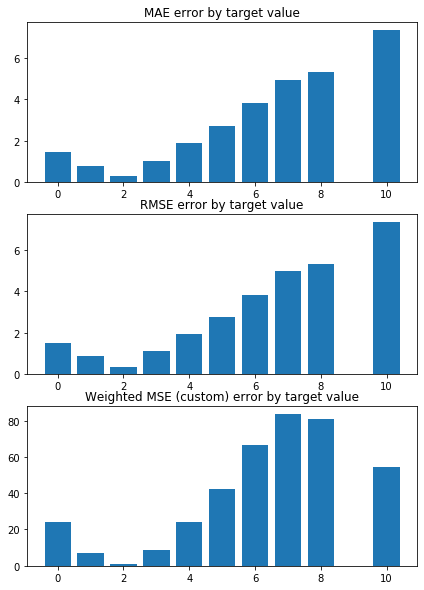

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3270409259201161 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2663998277559818 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


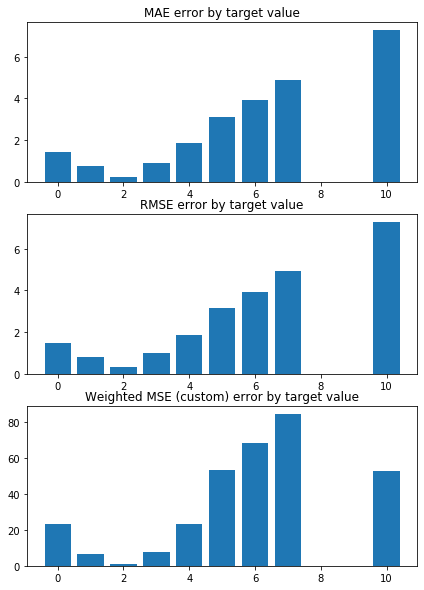

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1704669610480585 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2742918660671596 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


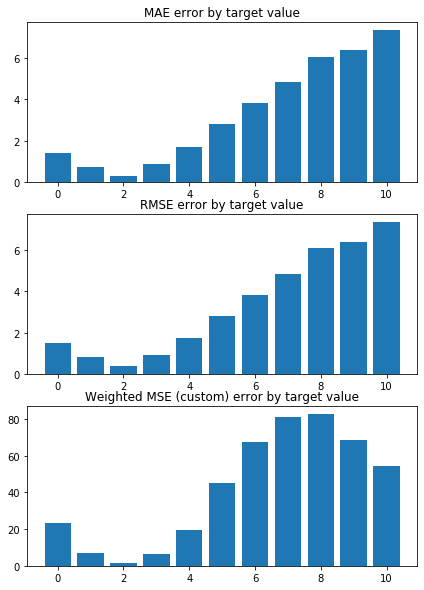

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.147268656397354 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2710743889506473 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


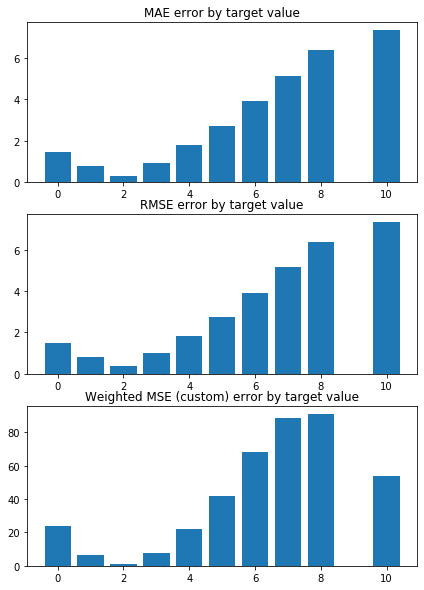

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.3136582132827668 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2555940552858837 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


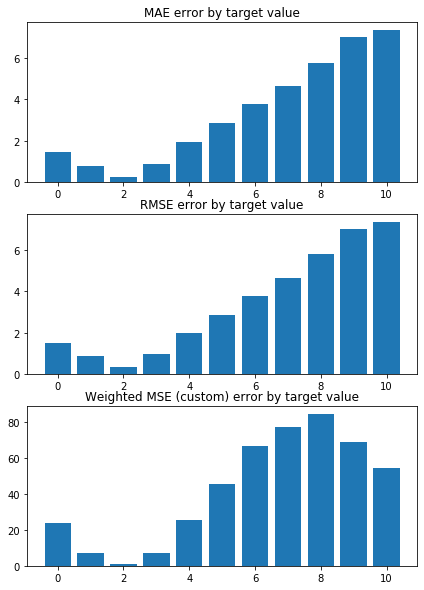

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.378640495017636 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2548952181883235 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


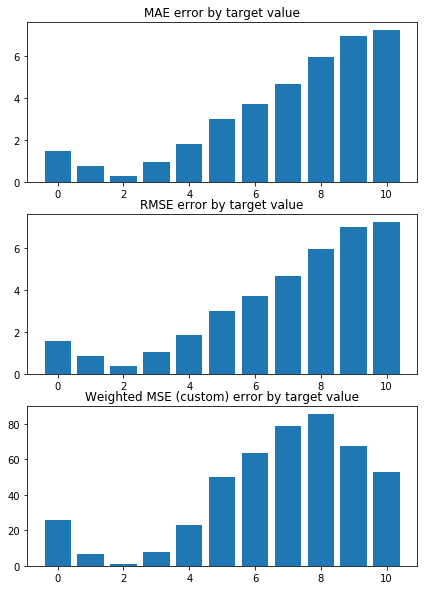

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2568682531203932 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2718799817392823 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


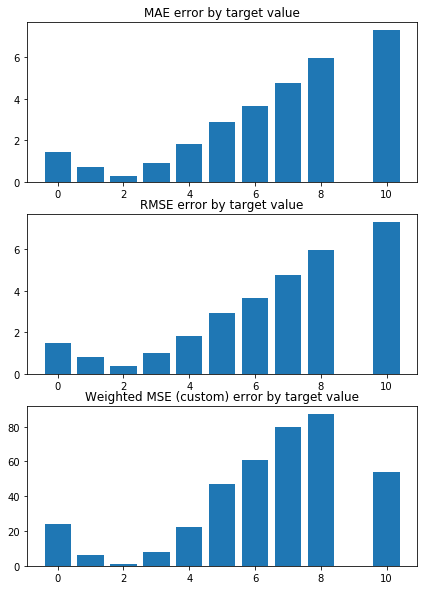

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.3353708072570905 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2609546433585637 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


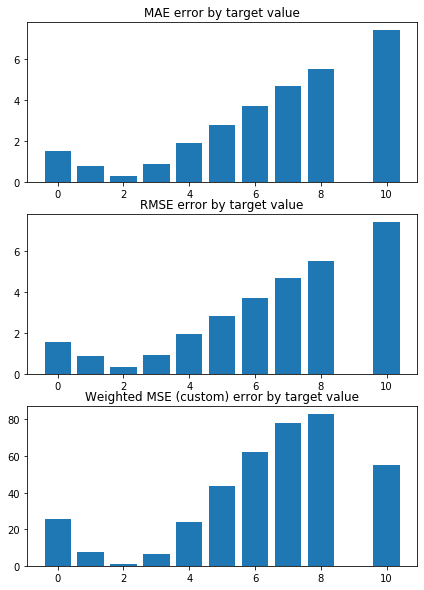

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2504851921681956 


 TRAIN PREDICTION Error
weighted_mse_train: 1.2619650198423125 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


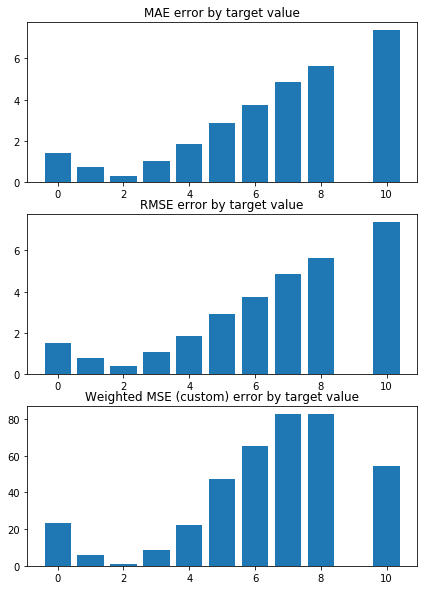

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1512781551523192 


 TRAIN PREDICTION Error
weighted_mse_train: 1.280116465063285 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


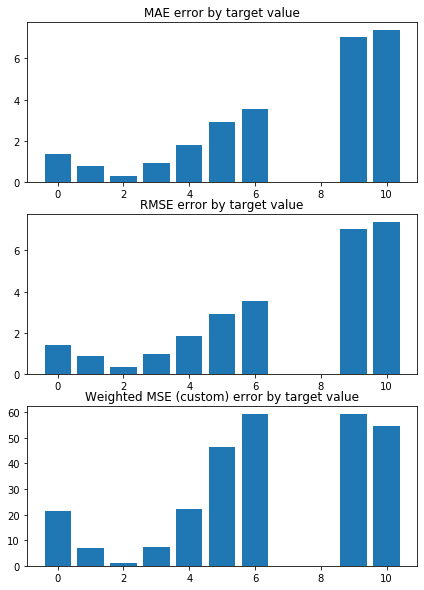

Weighted Mean squared error on Train: 1.27 
 MSE mean train: 3.116865732601276 

Mean squared error on Test: 1.27 
 MSE mean test:  3.11942090622109 

Root of MSE on Test: 1.13 
 1.7661882420119013 

Variance score on Test: 0.08 
 r2_test: 0.15774824541052404 

wMSE_train 1.27
wMSE_test 1.27
MSE_train 3.12
MSE_test 3.12
MAE_train 1.19
MAE_test 1.15
r2_test 0.16
    H3K4me1   H3K4me2  H3K27me1     Chriz  H3K36me3  H3K36me1  H3K27me3  \
0 -0.115832 -0.114666 -0.095049 -0.073508 -0.007912      -0.0       0.0   
1 -0.115064 -0.110595 -0.096501 -0.072170 -0.005972      -0.0       0.0   
2 -0.116454 -0.114342 -0.092076 -0.075291 -0.016734      -0.0       0.0   
3 -0.119464 -0.117656 -0.094108 -0.077729 -0.009642      -0.0       0.0   
4 -0.119201 -0.112606 -0.092631 -0.071789 -0.013346      -0.0       0.0   
5 -0.116203 -0.116292 -0.093489 -0.071273 -0.009173      -0.0       0.0   
6 -0.128237 -0.118956 -0.091234 -0.070188 -0.003832      -0.0       0.0   
7 -0.116296 -0.117718 -0.090988 -0.0

In [138]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.ElasticNet()

model_name = 'LR+L1+L2'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)

wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [139]:
results_pd

model_name wMSE_test_mean wMSE_test_std wMSE_train_mean  \
0            test_model            160             1              16   
1     LR+L1_no_outliers       0.923253     0.0347824        0.916697   
2                    LR        1.13867     0.0750751         1.13198   
3                 LR+L1        1.61552      0.092714          1.6149   
4  LR+L1_alf=0.2_spt=10        1.12173      0.070063          1.1202   
5        LR+L2_alf=3000        1.11571     0.0738139         1.11323   
6        LR+L2_alf=2000        1.11562     0.0734816         1.11272   
7              LR+L1+L2        1.26697     0.0809144          1.2655   

  wMSE_train_std comments                  params  MSE_test_mean  \
0              3  no coms  test_params = testtest            NaN   
1     0.00763124        -  test_params = testtest       1.392874   
2     0.00978238        -  test_params = testtest       2.634009   
3      0.0115859        -  test_params = testtest       3.708353   
4     0.00824059        -  test_params = testtest       2.768352   
5     0.00918478        -  test_params = testtest       2.688229   
6     0.00924482        -  test_params = testtest       2.670077   
7     0.00816356        -  test_params = testtest       3.119421   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0           NaN             NaN            NaN   
1      0.042988        1.382760       0.010296   
2      0.159500        2.619701       0.017773   
3      0.221185        3.707263       0.024586   
4      0.170443        2.765067       0.016531   
5      0.163748        2.682297       0.017655   
6      0.161791        2.663243       0.017661   
7      0.200324        3.116866       0.018646   

                                             r2_test n_splits  \
0                                                NaN      NaN   
1  [0.3173100836941761, 0.33173764707849474, 0.30...        5   
2  [0.30233272815667, 0.3418028647562872, 0.25460...       10   
3  [-0.0005277141720481104, -2.210887072906509e-0...       10   
4  [0.24862101980287654, 0.2826266315081707, 0.24...       10   
5  [0.27684219529817444, 0.3168635855108799, 0.26...       10   
6  [0.28341377745575747, 0.32388081130388513, 0.2...       10   
7  [0.1515102542917558, 0.17286615599028132, 0.15...       10   

                                               model  
0                                                NaN  
1  LinearRegression(copy_X=True, fit_intercept=Tr...  
2  LinearRegression(copy_X=True, fit_intercept=Tr...  
3  Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...  
4  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...  
5  Ridge(alpha=3000, copy_X=True, fit_intercept=T...  
6  Ridge(alpha=2000, copy_X=True, fit_intercept=T...  
7  ElasticNet(alpha=1.0, copy_X=True, fit_interce...

In [140]:
weighted_mse_train_all, weighted_mse_test_all

(array([1.25780801, 1.26639983, 1.27429187, 1.27107439, 1.25559406,
        1.25489522, 1.27187998, 1.26095464, 1.26196502, 1.28011647]),
 array([1.338625  , 1.32704093, 1.17046696, 1.14726866, 1.31365821,
        1.3786405 , 1.25686825, 1.33537081, 1.25048519, 1.15127816]))

In [141]:
print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


wmse_mean_train, wmse_mean_test = 1.265497947436365 1.2669702655379675


KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1562652486625113 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1054826826554152 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6918784159536415
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


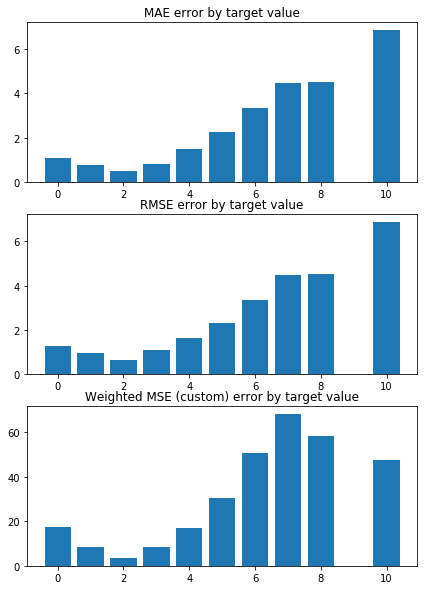

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1260907524001 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1107017970238584 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


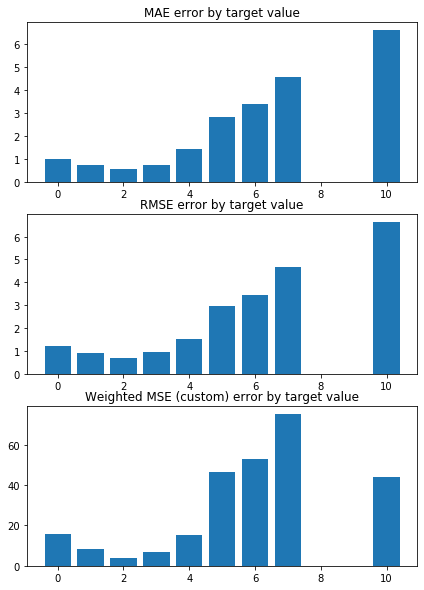

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0684807221098953 


 TRAIN PREDICTION Error
weighted_mse_train: 1.118075534448897 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


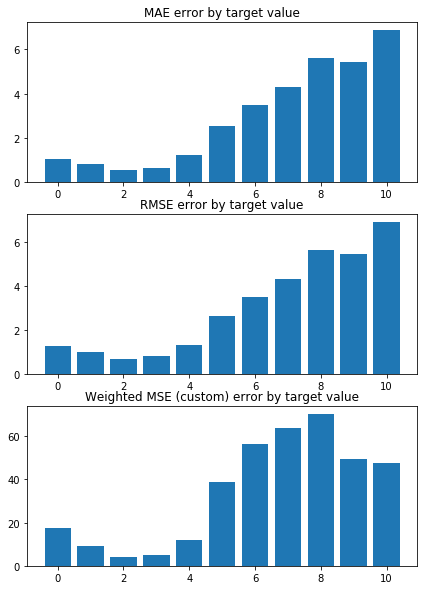

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.052879837747952 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1217183644522786 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


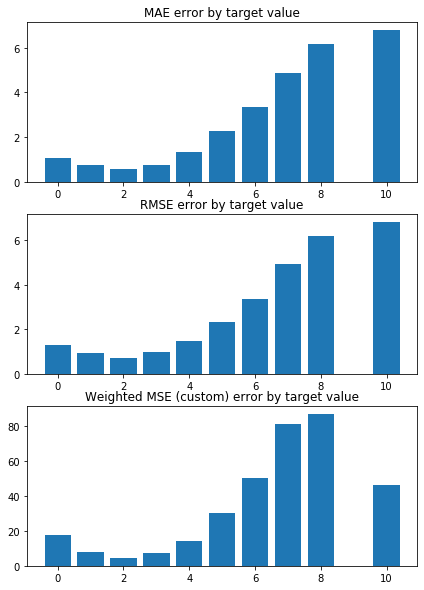

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1425789981935928 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1035128242341559 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


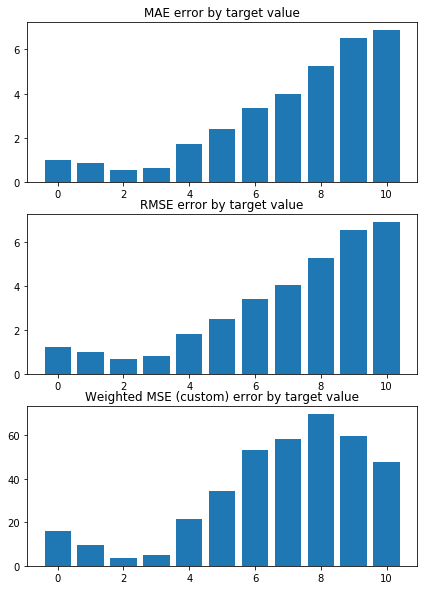

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2482354863042764 


 TRAIN PREDICTION Error
weighted_mse_train: 1.0988983934292174 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


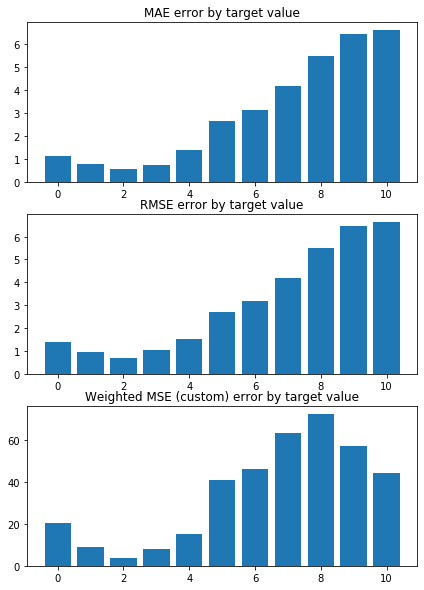

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1001954678326198 


 TRAIN PREDICTION Error
weighted_mse_train: 1.119109879064727 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


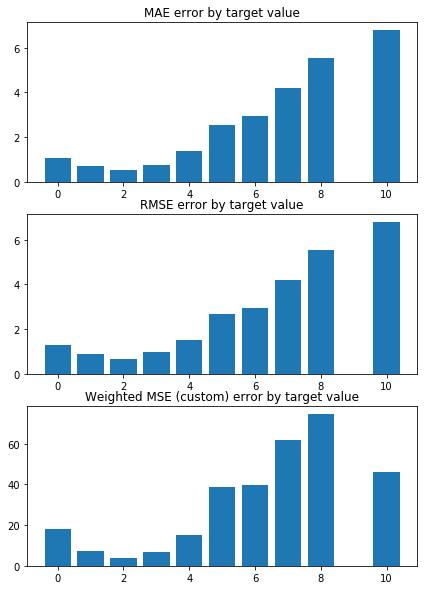

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.1823577657380349 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1108836112980216 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


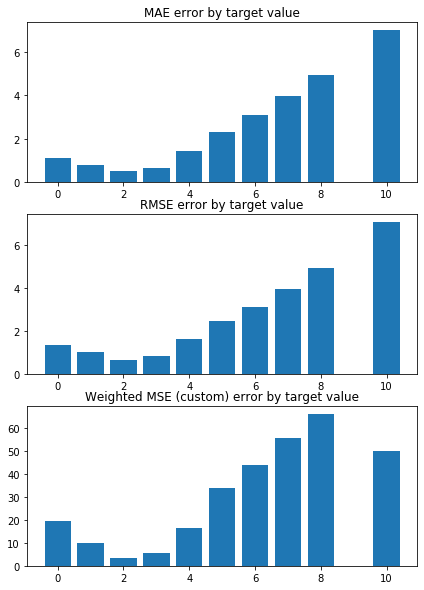

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.088788729043073 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1079033736013655 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


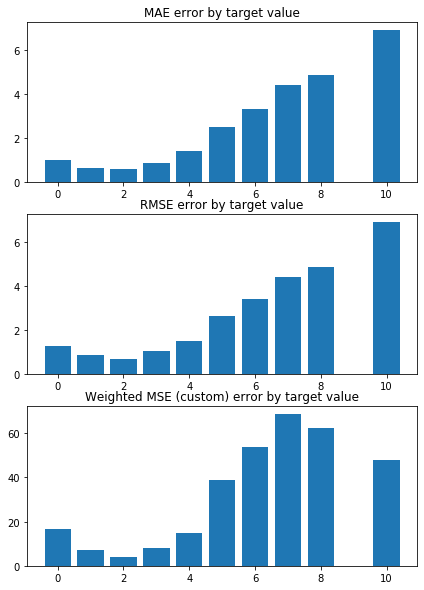

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 0.9829614586014569 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1290230332324902 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


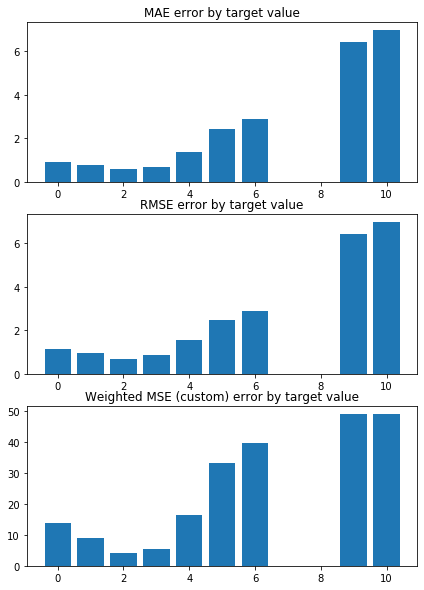

Weighted Mean squared error on Train: 1.11 
 MSE mean train: 2.7107755610704687 

Mean squared error on Test: 1.11 
 MSE mean test:  2.715703765677388 

Root of MSE on Test: 1.06 
 1.6479392481755473 

Variance score on Test: 0.07 
 r2_test: 0.26641748350630184 

wMSE_train 1.11
wMSE_test 1.11
MSE_train 2.71
MSE_test 2.72
MAE_train 1.08
MAE_test 1.02
r2_test 0.27
    H3K4me1     Chriz  H3K27me1     CP190  H3K36me3  H3K36me1   H3K4me2  \
0 -0.294733 -0.228811 -0.204119 -0.096861 -0.071596 -0.055519 -0.054553   
1 -0.297033 -0.226839 -0.204555 -0.095145 -0.077356 -0.058414 -0.039210   
2 -0.294558 -0.235615 -0.188535 -0.107003 -0.101040 -0.070636 -0.054689   
3 -0.289628 -0.240780 -0.192333 -0.095508 -0.086952 -0.072590 -0.057145   
4 -0.294515 -0.222729 -0.187707 -0.109276 -0.097154 -0.072797 -0.050471   
5 -0.294086 -0.214808 -0.195720 -0.100208 -0.086182 -0.066344 -0.055605   
6 -0.316654 -0.220772 -0.193962 -0.102444 -0.080087 -0.049196 -0.060309   
7 -0.296925 -0.223229 -0.195812 -0

In [142]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object

alpha =  0.2 # 3000 + 0.2
l1_ratio = 0.5 # 0.000066 # 0.2 / (3000 + 0.2)

model = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, normalize=False, precompute=False, max_iter=1000, 
                                copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')


model_name = 'LR+L2_alf=.2_rat=.5'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)


wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)


In [143]:
results_pd

model_name wMSE_test_mean wMSE_test_std wMSE_train_mean  \
0            test_model            160             1              16   
1     LR+L1_no_outliers       0.923253     0.0347824        0.916697   
2                    LR        1.13867     0.0750751         1.13198   
3                 LR+L1        1.61552      0.092714          1.6149   
4  LR+L1_alf=0.2_spt=10        1.12173      0.070063          1.1202   
5        LR+L2_alf=3000        1.11571     0.0738139         1.11323   
6        LR+L2_alf=2000        1.11562     0.0734816         1.11272   
7              LR+L1+L2        1.26697     0.0809144          1.2655   
8   LR+L2_alf=.2_rat=.5        1.11488     0.0701701         1.11253   

  wMSE_train_std comments                  params  MSE_test_mean  \
0              3  no coms  test_params = testtest            NaN   
1     0.00763124        -  test_params = testtest       1.392874   
2     0.00978238        -  test_params = testtest       2.634009   
3      0.0115859        -  test_params = testtest       3.708353   
4     0.00824059        -  test_params = testtest       2.768352   
5     0.00918478        -  test_params = testtest       2.688229   
6     0.00924482        -  test_params = testtest       2.670077   
7     0.00816356        -  test_params = testtest       3.119421   
8     0.00880197        -  test_params = testtest       2.715704   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0           NaN             NaN            NaN   
1      0.042988        1.382760       0.010296   
2      0.159500        2.619701       0.017773   
3      0.221185        3.707263       0.024586   
4      0.170443        2.765067       0.016531   
5      0.163748        2.682297       0.017655   
6      0.161791        2.663243       0.017661   
7      0.200324        3.116866       0.018646   
8      0.162221        2.710776       0.016951   

                                             r2_test n_splits  \
0                                                NaN      NaN   
1  [0.3173100836941761, 0.33173764707849474, 0.30...        5   
2  [0.30233272815667, 0.3418028647562872, 0.25460...       10   
3  [-0.0005277141720481104, -2.210887072906509e-0...       10   
4  [0.24862101980287654, 0.2826266315081707, 0.24...       10   
5  [0.27684219529817444, 0.3168635855108799, 0.26...       10   
6  [0.28341377745575747, 0.32388081130388513, 0.2...       10   
7  [0.1515102542917558, 0.17286615599028132, 0.15...       10   
8  [0.2685022458518105, 0.30198282772135177, 0.25...       10   

                                               model  
0                                                NaN  
1  LinearRegression(copy_X=True, fit_intercept=Tr...  
2  LinearRegression(copy_X=True, fit_intercept=Tr...  
3  Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...  
4  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...  
5  Ridge(alpha=3000, copy_X=True, fit_intercept=T...  
6  Ridge(alpha=2000, copy_X=True, fit_intercept=T...  
7  ElasticNet(alpha=1.0, copy_X=True, fit_interce...  
8  ElasticNet(alpha=0.2, copy_X=True, fit_interce...

In [144]:
print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)

wmse_mean_train, wmse_mean_test = 1.1125309493440425 1.114883446663351


In [145]:
coefs_pd = pd.DataFrame(coefs, columns=su_drsc.columns[2:][coefs_argsort][0])
coefs_pd.round(2)

H3K4me1  Chriz  H3K27me1  CP190  H3K36me3  H3K36me1  H3K4me2  H3K4me3  \
0    -0.23    0.0      0.01  -0.02     -0.10     -0.00    -0.29    -0.05   
1    -0.23    0.0      0.00  -0.03     -0.10     -0.01    -0.30    -0.04   
2    -0.24    0.0      0.00  -0.02     -0.11     -0.00    -0.29    -0.05   
3    -0.24    0.0      0.01  -0.03     -0.10     -0.00    -0.29    -0.06   
4    -0.22    0.0      0.01  -0.02     -0.11     -0.00    -0.29    -0.05   
5    -0.21    0.0      0.00  -0.03     -0.10     -0.00    -0.29    -0.06   
6    -0.22    0.0      0.00  -0.02     -0.10     -0.01    -0.32    -0.06   
7    -0.22    0.0      0.01  -0.02     -0.11     -0.00    -0.30    -0.06   
8    -0.22    0.0      0.00  -0.01     -0.10     -0.00    -0.30    -0.05   
9    -0.23    0.0      0.00  -0.03     -0.11     -0.00    -0.32    -0.05   

   BEAF-32  Su(Hw)  GAF  H4K16ac  H3K9me2  H3K9me3  H3K27ac  H3K27me3  CTCF  \
0    -0.04     0.0 -0.0     -0.0    -0.20     -0.0    -0.06     -0.07  -0.0   
1    -0.04     0.0 -0.0     -0.0    -0.20     -0.0    -0.06     -0.08  -0.0   
2    -0.02     0.0 -0.0     -0.0    -0.19     -0.0    -0.07     -0.10  -0.0   
3    -0.03     0.0 -0.0     -0.0    -0.19     -0.0    -0.07     -0.09  -0.0   
4    -0.03     0.0 -0.0     -0.0    -0.19     -0.0    -0.07     -0.10  -0.0   
5    -0.04     0.0 -0.0     -0.0    -0.20     -0.0    -0.07     -0.09  -0.0   
6    -0.03     0.0 -0.0     -0.0    -0.19     -0.0    -0.05     -0.08  -0.0   
7    -0.05     0.0 -0.0     -0.0    -0.20     -0.0    -0.06     -0.09  -0.0   
8    -0.04     0.0 -0.0     -0.0    -0.20     -0.0    -0.06     -0.08  -0.0   
9    -0.04     0.0 -0.0     -0.0    -0.18     -0.0    -0.06     -0.08  -0.0   

   RNA-polymerase-II  
0               -0.0  
1               -0.0  
2               -0.0  
3               -0.0  
4               -0.0  
5               -0.0  
6               -0.0  
7               -0.0  
8               -0.0  
9               -0.0

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS 

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2


$$ \frac{1}{(2  n_{samples})} ||y - Xw||^2_2
+ alpha * l1_{ratio}  ||w||_1
+ 0.5 * alpha * (1 - l1_{ratio}) ||w||^2_2 $$



$$ \frac{1}{ n\_samples} ||y - Xw||^2_2
+ \alpha ||w||_1
+ \beta ||w||^2_2 $$

$$ \frac{1}{ n\_samples} ||y - Xw||^2_2 + \alpha ||w||_1 + \beta ||w||^2_2 $$

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1399807373292121 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1257163976254185 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6918784159536415
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


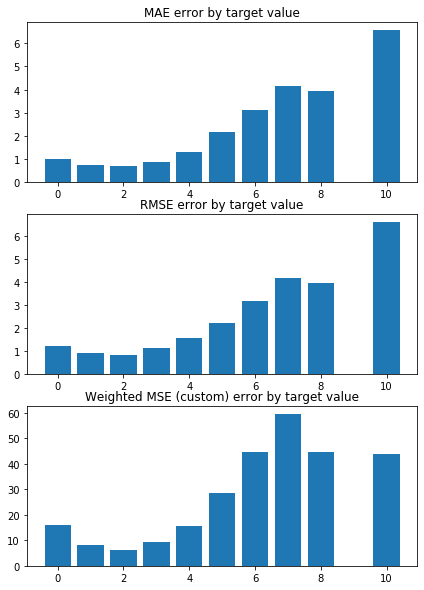

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1290968331118791 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1305077007950748 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7231686180118282
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


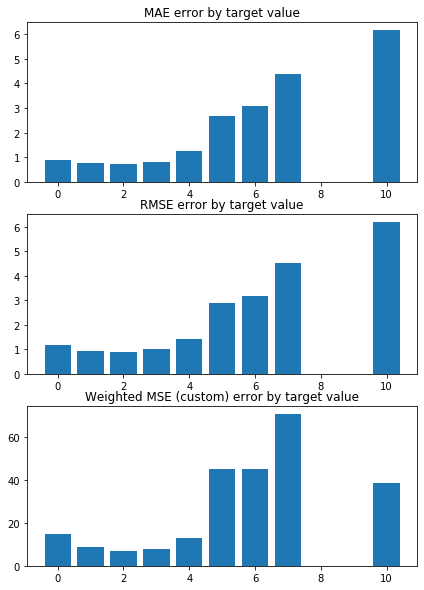

train_index= [   0    2    3 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1469742957368263 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1365426645646823 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5102232818954902
test sizes =  595 595 595


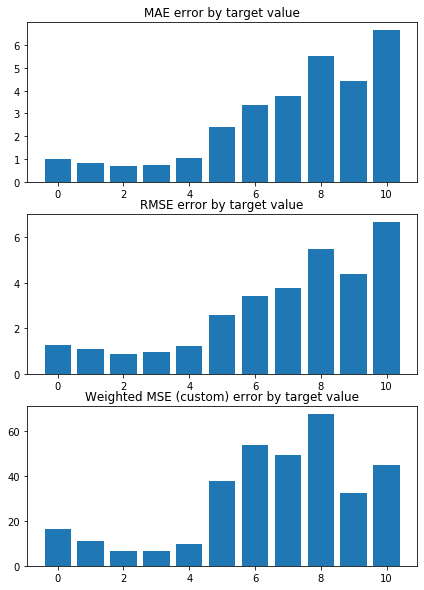

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0902129803399987 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1412522694643552 


 CONSTANT pred Error:
weighted_mse_test_const:  1.4472258533824836
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


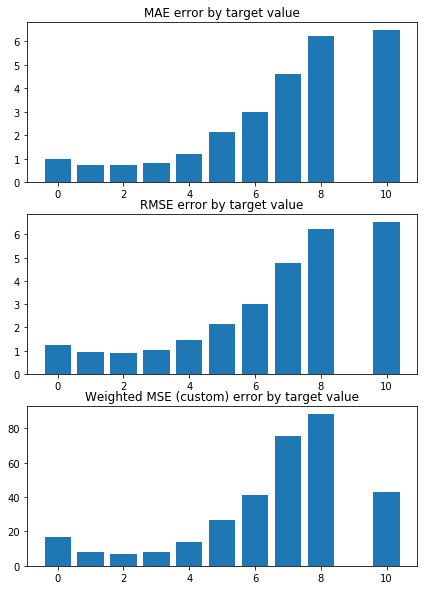

train_index= [   0    1    2 ... 5946 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.1901367240971035 


 TRAIN PREDICTION Error
weighted_mse_train: 1.122924657341638 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6722112246990009
test sizes =  595 595 595


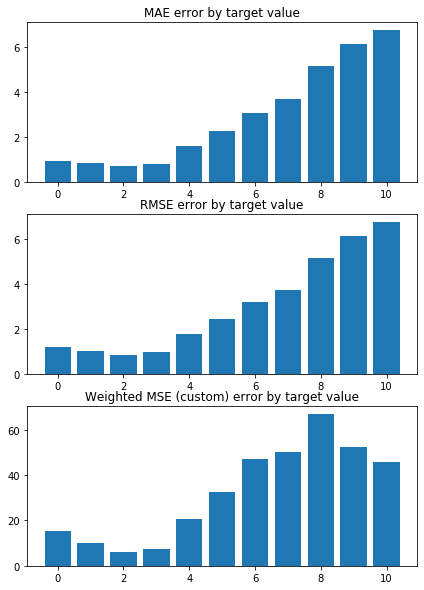

train_index= [   1    4    5 ... 5945 5947 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.2938024890243434 


 TRAIN PREDICTION Error
weighted_mse_train: 1.115065393119995 


 CONSTANT pred Error:
weighted_mse_test_const:  1.699109321425948
test sizes =  595 595 595


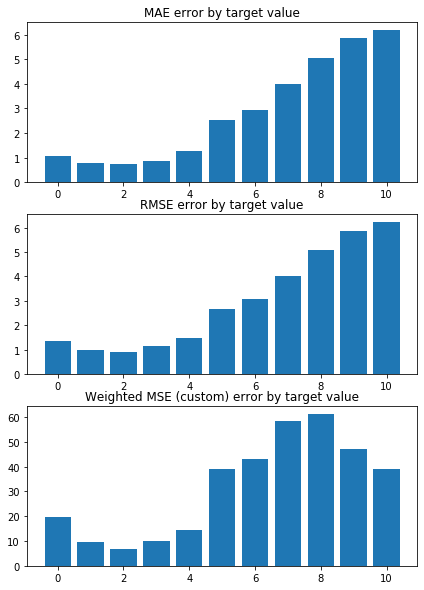

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0988531127868442 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1405528145667763 


 CONSTANT pred Error:
weighted_mse_test_const:  1.6115493681587238
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


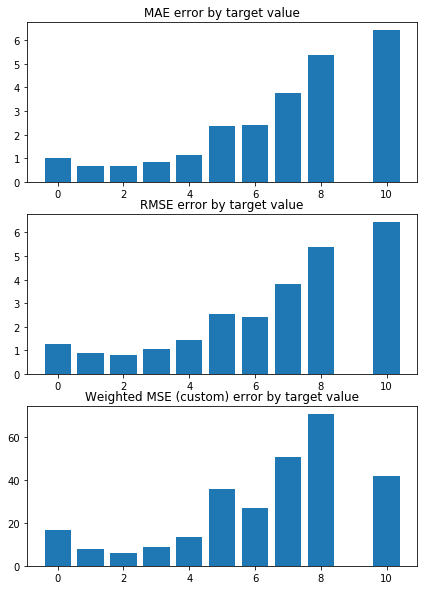

train_index= [   0    1    2 ... 5946 5947 5948]
 TEST PREDICTION Error
weighted_mse_test: 1.2068702910415512 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1324953726649976 


 CONSTANT pred Error:
weighted_mse_test_const:  1.7038577806859556
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


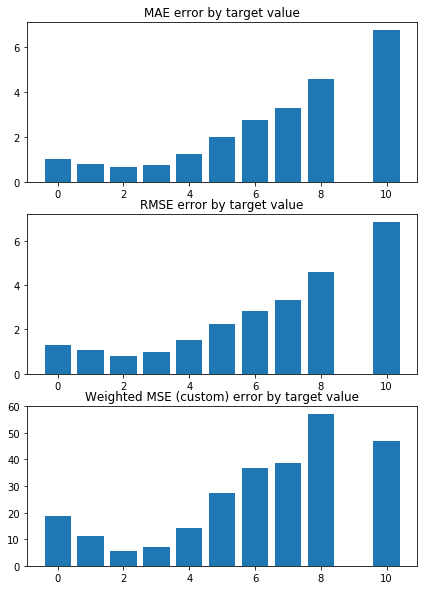

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.087134798183459 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1249546625028684 


 CONSTANT pred Error:
weighted_mse_test_const:  1.579451336632733
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


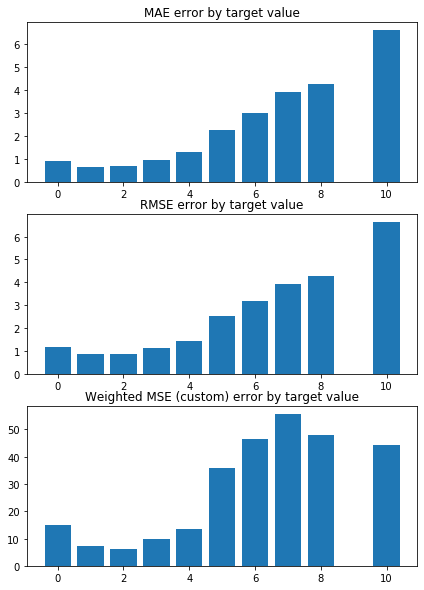

train_index= [   0    1    2 ... 5947 5948 5949]
 TEST PREDICTION Error
weighted_mse_test: 1.0035966389449589 


 TRAIN PREDICTION Error
weighted_mse_train: 1.1497996064729967 


 CONSTANT pred Error:
weighted_mse_test_const:  1.5164826084211207
test sizes =  595 595 595


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


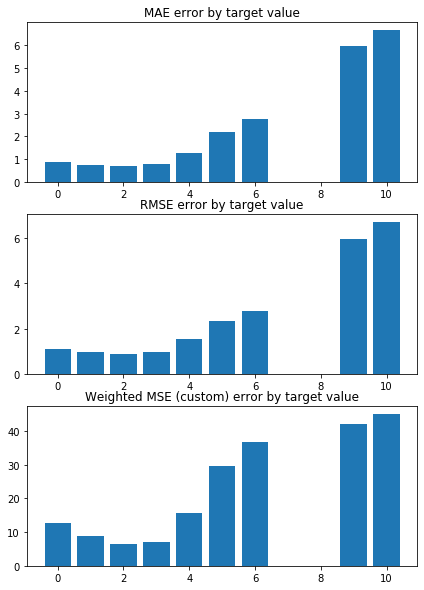

Weighted Mean squared error on Train: 1.13 
 MSE mean train: 2.6197014139933215 

Mean squared error on Test: 1.14 
 MSE mean test:  2.6340089733098777 

Root of MSE on Test: 1.07 
 1.6229630227795941 

Variance score on Test: 0.08 
 r2_test: 0.28824059929516277 

wMSE_train 1.13
wMSE_test 1.14
MSE_train 2.62
MSE_test 2.63
MAE_train 1.08
MAE_test 1.02
r2_test 0.29
      Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.319028 -0.294063 -0.277849 -0.271401 -0.270839 -0.258442 -0.247798   
1 -0.334489 -0.299304 -0.256882 -0.265283 -0.280700 -0.282460 -0.272424   
2 -0.340081 -0.337740 -0.268718 -0.241906 -0.308471 -0.334819 -0.241820   
3 -0.345520 -0.316966 -0.264153 -0.245392 -0.304656 -0.293735 -0.235759   
4 -0.308994 -0.331351 -0.291953 -0.225332 -0.314548 -0.336994 -0.240104   
5 -0.284300 -0.305691 -0.282470 -0.251748 -0.292721 -0.293370 -0.234909   
6 -0.306876 -0.299488 -0.267949 -0.253933 -0.262839 -0.279531 -0.295387   
7 -0.298799 -0.314179 -0.286027 -

In [146]:
X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)

# Create linear regression object
model = linear_model.LinearRegression()

model_name = 'LR'
n_splits = 10
random_state = 16 
shuffle = True

lin_reg, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const, \
                results_pd = train_test_KFold(X, y, 
                                              model, model_name, results_pd,
                                              n_splits=n_splits, random_state=random_state, shuffle=shuffle)

wmse_mean_train, wmse_mean_test = np.mean(weighted_mse_train_all), np.mean(weighted_mse_test_all)

print('wmse_mean_train, wmse_mean_test =', wmse_mean_train, wmse_mean_test)



In [147]:
results_pd

model_name wMSE_test_mean wMSE_test_std wMSE_train_mean  \
0            test_model            160             1              16   
1     LR+L1_no_outliers       0.923253     0.0347824        0.916697   
2                    LR        1.13867     0.0750751         1.13198   
3                 LR+L1        1.61552      0.092714          1.6149   
4  LR+L1_alf=0.2_spt=10        1.12173      0.070063          1.1202   
5        LR+L2_alf=3000        1.11571     0.0738139         1.11323   
6        LR+L2_alf=2000        1.11562     0.0734816         1.11272   
7              LR+L1+L2        1.26697     0.0809144          1.2655   
8   LR+L2_alf=.2_rat=.5        1.11488     0.0701701         1.11253   
9                    LR        1.13867     0.0750751         1.13198   

  wMSE_train_std comments                  params  MSE_test_mean  \
0              3  no coms  test_params = testtest            NaN   
1     0.00763124        -  test_params = testtest       1.392874   
2     0.00978238        -  test_params = testtest       2.634009   
3      0.0115859        -  test_params = testtest       3.708353   
4     0.00824059        -  test_params = testtest       2.768352   
5     0.00918478        -  test_params = testtest       2.688229   
6     0.00924482        -  test_params = testtest       2.670077   
7     0.00816356        -  test_params = testtest       3.119421   
8     0.00880197        -  test_params = testtest       2.715704   
9     0.00978238        -  test_params = testtest       2.634009   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
0           NaN             NaN            NaN   
1      0.042988        1.382760       0.010296   
2      0.159500        2.619701       0.017773   
3      0.221185        3.707263       0.024586   
4      0.170443        2.765067       0.016531   
5      0.163748        2.682297       0.017655   
6      0.161791        2.663243       0.017661   
7      0.200324        3.116866       0.018646   
8      0.162221        2.710776       0.016951   
9      0.159500        2.619701       0.017773   

                                             r2_test n_splits  \
0                                                NaN      NaN   
1  [0.3173100836941761, 0.33173764707849474, 0.30...        5   
2  [0.30233272815667, 0.3418028647562872, 0.25460...       10   
3  [-0.0005277141720481104, -2.210887072906509e-0...       10   
4  [0.24862101980287654, 0.2826266315081707, 0.24...       10   
5  [0.27684219529817444, 0.3168635855108799, 0.26...       10   
6  [0.28341377745575747, 0.32388081130388513, 0.2...       10   
7  [0.1515102542917558, 0.17286615599028132, 0.15...       10   
8  [0.2685022458518105, 0.30198282772135177, 0.25...       10   
9  [0.30233272815667, 0.3418028647562872, 0.25460...       10   

                                               model  
0                                                NaN  
1  LinearRegression(copy_X=True, fit_intercept=Tr...  
2  LinearRegression(copy_X=True, fit_intercept=Tr...  
3  Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...  
4  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...  
5  Ridge(alpha=3000, copy_X=True, fit_intercept=T...  
6  Ridge(alpha=2000, copy_X=True, fit_intercept=T...  
7  ElasticNet(alpha=1.0, copy_X=True, fit_interce...  
8  ElasticNet(alpha=0.2, copy_X=True, fit_interce...  
9  LinearRegression(copy_X=True, fit_intercept=Tr...

In [148]:
coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]]

Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  Su(Hw)  \
0    0.0 -0.071596 -0.017345  0.009285 -0.001732 -0.096861 -0.228811     0.0   
1    0.0 -0.077356 -0.026160  0.000000 -0.009140 -0.095145 -0.226839     0.0   
2    0.0 -0.101040 -0.021414  0.000000 -0.003370 -0.107003 -0.235615     0.0   
3    0.0 -0.086952 -0.028280  0.005894 -0.004709 -0.095508 -0.240780     0.0   
4    0.0 -0.097154 -0.021511  0.009965 -0.001272 -0.109276 -0.222729     0.0   
5    0.0 -0.086182 -0.029452  0.001217 -0.000000 -0.100208 -0.214808     0.0   
6    0.0 -0.080087 -0.016784  0.000000 -0.011593 -0.102444 -0.220772     0.0   
7    0.0 -0.085470 -0.016415  0.006530 -0.000000 -0.108505 -0.223229     0.0   
8    0.0 -0.077976 -0.013287  0.000000 -0.002502 -0.100604 -0.224595     0.0   
9    0.0 -0.076448 -0.025990  0.000000 -0.000000 -0.105576 -0.226898     0.0   

    H3K4me2  RNA-polymerase-II   H3K4me3  CTCF   H3K27ac  H4K16ac  GAF  \
0 -0.294733               -0.0 -0.054553  -0.0 -0.055519     -0.0 -0.0   
1 -0.297033               -0.0 -0.039210  -0.0 -0.058414     -0.0 -0.0   
2 -0.294558               -0.0 -0.054689  -0.0 -0.070636     -0.0 -0.0   
3 -0.289628               -0.0 -0.057145  -0.0 -0.072590     -0.0 -0.0   
4 -0.294515               -0.0 -0.050471  -0.0 -0.072797     -0.0 -0.0   
5 -0.294086               -0.0 -0.055605  -0.0 -0.066344     -0.0 -0.0   
6 -0.316654               -0.0 -0.060309  -0.0 -0.049196     -0.0 -0.0   
7 -0.296925               -0.0 -0.058791  -0.0 -0.058731     -0.0 -0.0   
8 -0.304646               -0.0 -0.051490  -0.0 -0.058532     -0.0 -0.0   
9 -0.321320               -0.0 -0.048812  -0.0 -0.058605     -0.0 -0.0   

   H3K9me3   H3K9me2   BEAF-32  
0     -0.0 -0.204119 -0.042005  
1     -0.0 -0.204555 -0.042687  
2     -0.0 -0.188535 -0.023792  
3     -0.0 -0.192333 -0.026005  
4     -0.0 -0.187707 -0.031116  
5     -0.0 -0.195720 -0.040429  
6     -0.0 -0.193962 -0.034125  
7     -0.0 -0.195812 -0.052133  
8     -0.0 -0.201241 -0.041070  
9     -0.0 -0.184007 -0.041914

In [149]:
coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]].iloc[0]

Chriz                0.000000
H3K27me3            -0.071596
CP190               -0.017345
H3K27me1             0.009285
H3K36me1            -0.001732
H3K36me3            -0.096861
H3K4me1             -0.228811
Su(Hw)               0.000000
H3K4me2             -0.294733
RNA-polymerase-II   -0.000000
H3K4me3             -0.054553
CTCF                -0.000000
H3K27ac             -0.055519
H4K16ac             -0.000000
GAF                 -0.000000
H3K9me3             -0.000000
H3K9me2             -0.204119
BEAF-32             -0.042005
Name: 0, dtype: float64

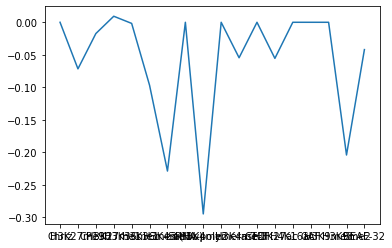

In [150]:
plt.plot(coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]].iloc[0])

# !! одинаковая приоритизация 

In [151]:
np.sort(coefs[0])

array([-0.31902775, -0.29406336, -0.27784944, -0.27140146, -0.27083913,
       -0.25844164, -0.24779776, -0.10438984, -0.10185159, -0.03038498,
       -0.03024388,  0.0131556 ,  0.02150234,  0.05317061,  0.05799184,
        0.06278061,  0.11740431,  0.11881391])

In [152]:
pd.DataFrame(coefs_argsort, columns=su_drsc.columns[2:][coefs_argsort[0]])

Chriz  H3K27me3  CP190  H3K27me1  H3K36me1  H3K36me3  H3K4me1  Su(Hw)  \
0      0        13      4        12        14        15        6       2   
1      0        13     15        14         6        12        4       7   
2      0        13     15        14         4        12        6      17   
3      0        13     14        15         4        12        6      17   
4     15        13     14         0         4         6       12       7   
5     13        15     14         0         4        12        6      17   
6      0        13      6        15         4        14       12      17   
7     13         0     15         4        14         6       12       8   
8      0        13      4        14         6        15       12      17   
9      6        13      0        15        14         4       12       7   

   H3K4me2  RNA-polymerase-II  H3K4me3  CTCF  H3K27ac  H4K16ac  GAF  H3K9me3  \
0        7                 17        8     1       11       16    5       10   
1        8                 17        2    11        1       16    5        3   
2        7                  2       16     8       11       10    1        5   
3        2                  7        8    16       11        1   10        5   
4        2                 17        8     1       16       10    5       11   
5        2                  8        7    11        1       16    9       10   
6       11                  2        8    16        7        1    5        9   
7        7                 17        2     1       11       16   10        3   
8        7                  2        8    11        1       16   10        9   
9        8                 17        2    11       16        1   10        5   

   H3K9me2  BEAF-32  
0        9        3  
1       10        9  
2        9        3  
3        9        3  
4        9        3  
5        5        3  
6       10        3  
7        5        9  
8        5        3  
9        9        3

In [153]:
su_drsc.columns[2:][coefs_argsort[0]]

Index(['Chriz', 'H3K27me3', 'CP190', 'H3K27me1', 'H3K36me1', 'H3K36me3',
       'H3K4me1', 'Su(Hw)', 'H3K4me2', 'RNA-polymerase-II', 'H3K4me3', 'CTCF',
       'H3K27ac', 'H4K16ac', 'GAF', 'H3K9me3', 'H3K9me2', 'BEAF-32'],
      dtype='object')

In [154]:
coefs_df = pd.DataFrame(coefs, columns=su_drsc.columns[2:])[su_drsc.columns[2:][coefs_argsort[0]]]

coefs_df

Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.319028 -0.294063 -0.277849 -0.271401 -0.270839 -0.258442 -0.247798   
1 -0.334489 -0.299304 -0.256882 -0.265283 -0.280700 -0.282460 -0.272424   
2 -0.340081 -0.337740 -0.268718 -0.241906 -0.308471 -0.334819 -0.241820   
3 -0.345520 -0.316966 -0.264153 -0.245392 -0.304656 -0.293735 -0.235759   
4 -0.308994 -0.331351 -0.291953 -0.225332 -0.314548 -0.336994 -0.240104   
5 -0.284300 -0.305691 -0.282470 -0.251748 -0.292721 -0.293370 -0.234909   
6 -0.306876 -0.299488 -0.267949 -0.253933 -0.262839 -0.279531 -0.295387   
7 -0.298799 -0.314179 -0.286027 -0.249925 -0.281292 -0.291266 -0.270017   
8 -0.318116 -0.287615 -0.271158 -0.264300 -0.268885 -0.264577 -0.264699   
9 -0.308894 -0.310965 -0.271187 -0.241115 -0.276240 -0.278461 -0.319980   

     Su(Hw)   H3K4me2  RNA-polymerase-II   H3K4me3      CTCF   H3K27ac  \
0  0.118814  0.117404          -0.104390 -0.101852  0.062781  0.057992   
1  0.087992  0.165101          -0.096357 -0.102276  0.053029  0.063576   
2  0.088613  0.091661          -0.120220 -0.060154  0.034379  0.049725   
3  0.101154  0.092044          -0.107095 -0.067769  0.050767  0.053165   
4  0.110899  0.150909          -0.103918 -0.094604  0.059162  0.026653   
5  0.111024  0.087823          -0.111253 -0.093922  0.064499  0.066965   
6  0.093377  0.062508          -0.110436 -0.074816  0.046165  0.093899   
7  0.110837  0.137679          -0.118107 -0.138208  0.055507  0.048599   
8  0.099738  0.111223          -0.115530 -0.093593  0.056369  0.066755   
9  0.085557  0.132554          -0.103969 -0.108803  0.046798  0.068738   

    H4K16ac       GAF   H3K9me3   H3K9me2   BEAF-32  
0  0.053171 -0.030385 -0.030244  0.021502  0.013156  
1  0.045978 -0.042583  0.004812 -0.004589 -0.009100  
2  0.072871 -0.027771 -0.034733  0.023262  0.004423  
3  0.065545 -0.033472 -0.044585  0.018598 -0.002475  
4  0.056386 -0.032805 -0.048278  0.020062  0.003663  
5  0.052185 -0.021981 -0.025529  0.026444 -0.010106  
6  0.063586 -0.034698 -0.010883  0.016144  0.006240  
7  0.047822 -0.013082 -0.018524  0.000057  0.016592  
8  0.050719 -0.029847 -0.048193  0.044591  0.021937  
9  0.059857 -0.022436 -0.036759  0.015714 -0.010772

In [155]:
coefs_df.round(2)

Chriz  H3K27me3  CP190  H3K27me1  H3K36me1  H3K36me3  H3K4me1  Su(Hw)  \
0  -0.32     -0.29  -0.28     -0.27     -0.27     -0.26    -0.25    0.12   
1  -0.33     -0.30  -0.26     -0.27     -0.28     -0.28    -0.27    0.09   
2  -0.34     -0.34  -0.27     -0.24     -0.31     -0.33    -0.24    0.09   
3  -0.35     -0.32  -0.26     -0.25     -0.30     -0.29    -0.24    0.10   
4  -0.31     -0.33  -0.29     -0.23     -0.31     -0.34    -0.24    0.11   
5  -0.28     -0.31  -0.28     -0.25     -0.29     -0.29    -0.23    0.11   
6  -0.31     -0.30  -0.27     -0.25     -0.26     -0.28    -0.30    0.09   
7  -0.30     -0.31  -0.29     -0.25     -0.28     -0.29    -0.27    0.11   
8  -0.32     -0.29  -0.27     -0.26     -0.27     -0.26    -0.26    0.10   
9  -0.31     -0.31  -0.27     -0.24     -0.28     -0.28    -0.32    0.09   

   H3K4me2  RNA-polymerase-II  H3K4me3  CTCF  H3K27ac  H4K16ac   GAF  H3K9me3  \
0     0.12              -0.10    -0.10  0.06     0.06     0.05 -0.03    -0.03   
1     0.17              -0.10    -0.10  0.05     0.06     0.05 -0.04     0.00   
2     0.09              -0.12    -0.06  0.03     0.05     0.07 -0.03    -0.03   
3     0.09              -0.11    -0.07  0.05     0.05     0.07 -0.03    -0.04   
4     0.15              -0.10    -0.09  0.06     0.03     0.06 -0.03    -0.05   
5     0.09              -0.11    -0.09  0.06     0.07     0.05 -0.02    -0.03   
6     0.06              -0.11    -0.07  0.05     0.09     0.06 -0.03    -0.01   
7     0.14              -0.12    -0.14  0.06     0.05     0.05 -0.01    -0.02   
8     0.11              -0.12    -0.09  0.06     0.07     0.05 -0.03    -0.05   
9     0.13              -0.10    -0.11  0.05     0.07     0.06 -0.02    -0.04   

   H3K9me2  BEAF-32  
0     0.02     0.01  
1    -0.00    -0.01  
2     0.02     0.00  
3     0.02    -0.00  
4     0.02     0.00  
5     0.03    -0.01  
6     0.02     0.01  
7     0.00     0.02  
8     0.04     0.02  
9     0.02    -0.01

In [156]:
# !! одинаковая приоритизация 

np.sort(coefs[0])

coefs

coefs_argsort[0]

pd.DataFrame(coefs_argsort, columns=su_drsc.columns[2:][coefs_argsort[0]])

su_drsc.columns[2:], su_drsc.columns[2:][coefs_argsort[0]]

coefs_df = pd.DataFrame(coefs, columns=su_drsc.columns[2:])[su_drsc.columns[2:][coefs_argsort[0]]]

coefs_df

coefs_df.round(2)

Chriz  H3K27me3  CP190  H3K27me1  H3K36me1  H3K36me3  H3K4me1  Su(Hw)  \
0  -0.32     -0.29  -0.28     -0.27     -0.27     -0.26    -0.25    0.12   
1  -0.33     -0.30  -0.26     -0.27     -0.28     -0.28    -0.27    0.09   
2  -0.34     -0.34  -0.27     -0.24     -0.31     -0.33    -0.24    0.09   
3  -0.35     -0.32  -0.26     -0.25     -0.30     -0.29    -0.24    0.10   
4  -0.31     -0.33  -0.29     -0.23     -0.31     -0.34    -0.24    0.11   
5  -0.28     -0.31  -0.28     -0.25     -0.29     -0.29    -0.23    0.11   
6  -0.31     -0.30  -0.27     -0.25     -0.26     -0.28    -0.30    0.09   
7  -0.30     -0.31  -0.29     -0.25     -0.28     -0.29    -0.27    0.11   
8  -0.32     -0.29  -0.27     -0.26     -0.27     -0.26    -0.26    0.10   
9  -0.31     -0.31  -0.27     -0.24     -0.28     -0.28    -0.32    0.09   

   H3K4me2  RNA-polymerase-II  H3K4me3  CTCF  H3K27ac  H4K16ac   GAF  H3K9me3  \
0     0.12              -0.10    -0.10  0.06     0.06     0.05 -0.03    -0.03   
1     0.17              -0.10    -0.10  0.05     0.06     0.05 -0.04     0.00   
2     0.09              -0.12    -0.06  0.03     0.05     0.07 -0.03    -0.03   
3     0.09              -0.11    -0.07  0.05     0.05     0.07 -0.03    -0.04   
4     0.15              -0.10    -0.09  0.06     0.03     0.06 -0.03    -0.05   
5     0.09              -0.11    -0.09  0.06     0.07     0.05 -0.02    -0.03   
6     0.06              -0.11    -0.07  0.05     0.09     0.06 -0.03    -0.01   
7     0.14              -0.12    -0.14  0.06     0.05     0.05 -0.01    -0.02   
8     0.11              -0.12    -0.09  0.06     0.07     0.05 -0.03    -0.05   
9     0.13              -0.10    -0.11  0.05     0.07     0.06 -0.02    -0.04   

   H3K9me2  BEAF-32  
0     0.02     0.01  
1    -0.00    -0.01  
2     0.02     0.00  
3     0.02    -0.00  
4     0.02     0.00  
5     0.03    -0.01  
6     0.02     0.01  
7     0.00     0.02  
8     0.04     0.02  
9     0.02    -0.01

In [157]:
coefs_df

Chriz  H3K27me3     CP190  H3K27me1  H3K36me1  H3K36me3   H3K4me1  \
0 -0.319028 -0.294063 -0.277849 -0.271401 -0.270839 -0.258442 -0.247798   
1 -0.334489 -0.299304 -0.256882 -0.265283 -0.280700 -0.282460 -0.272424   
2 -0.340081 -0.337740 -0.268718 -0.241906 -0.308471 -0.334819 -0.241820   
3 -0.345520 -0.316966 -0.264153 -0.245392 -0.304656 -0.293735 -0.235759   
4 -0.308994 -0.331351 -0.291953 -0.225332 -0.314548 -0.336994 -0.240104   
5 -0.284300 -0.305691 -0.282470 -0.251748 -0.292721 -0.293370 -0.234909   
6 -0.306876 -0.299488 -0.267949 -0.253933 -0.262839 -0.279531 -0.295387   
7 -0.298799 -0.314179 -0.286027 -0.249925 -0.281292 -0.291266 -0.270017   
8 -0.318116 -0.287615 -0.271158 -0.264300 -0.268885 -0.264577 -0.264699   
9 -0.308894 -0.310965 -0.271187 -0.241115 -0.276240 -0.278461 -0.319980   

     Su(Hw)   H3K4me2  RNA-polymerase-II   H3K4me3      CTCF   H3K27ac  \
0  0.118814  0.117404          -0.104390 -0.101852  0.062781  0.057992   
1  0.087992  0.165101          -0.096357 -0.102276  0.053029  0.063576   
2  0.088613  0.091661          -0.120220 -0.060154  0.034379  0.049725   
3  0.101154  0.092044          -0.107095 -0.067769  0.050767  0.053165   
4  0.110899  0.150909          -0.103918 -0.094604  0.059162  0.026653   
5  0.111024  0.087823          -0.111253 -0.093922  0.064499  0.066965   
6  0.093377  0.062508          -0.110436 -0.074816  0.046165  0.093899   
7  0.110837  0.137679          -0.118107 -0.138208  0.055507  0.048599   
8  0.099738  0.111223          -0.115530 -0.093593  0.056369  0.066755   
9  0.085557  0.132554          -0.103969 -0.108803  0.046798  0.068738   

    H4K16ac       GAF   H3K9me3   H3K9me2   BEAF-32  
0  0.053171 -0.030385 -0.030244  0.021502  0.013156  
1  0.045978 -0.042583  0.004812 -0.004589 -0.009100  
2  0.072871 -0.027771 -0.034733  0.023262  0.004423  
3  0.065545 -0.033472 -0.044585  0.018598 -0.002475  
4  0.056386 -0.032805 -0.048278  0.020062  0.003663  
5  0.052185 -0.021981 -0.025529  0.026444 -0.010106  
6  0.063586 -0.034698 -0.010883  0.016144  0.006240  
7  0.047822 -0.013082 -0.018524  0.000057  0.016592  
8  0.050719 -0.029847 -0.048193  0.044591  0.021937  
9  0.059857 -0.022436 -0.036759  0.015714 -0.010772

In [158]:
coefs_df_2 = coefs_df.round(2)
coefs_df_2

Chriz  H3K27me3  CP190  H3K27me1  H3K36me1  H3K36me3  H3K4me1  Su(Hw)  \
0  -0.32     -0.29  -0.28     -0.27     -0.27     -0.26    -0.25    0.12   
1  -0.33     -0.30  -0.26     -0.27     -0.28     -0.28    -0.27    0.09   
2  -0.34     -0.34  -0.27     -0.24     -0.31     -0.33    -0.24    0.09   
3  -0.35     -0.32  -0.26     -0.25     -0.30     -0.29    -0.24    0.10   
4  -0.31     -0.33  -0.29     -0.23     -0.31     -0.34    -0.24    0.11   
5  -0.28     -0.31  -0.28     -0.25     -0.29     -0.29    -0.23    0.11   
6  -0.31     -0.30  -0.27     -0.25     -0.26     -0.28    -0.30    0.09   
7  -0.30     -0.31  -0.29     -0.25     -0.28     -0.29    -0.27    0.11   
8  -0.32     -0.29  -0.27     -0.26     -0.27     -0.26    -0.26    0.10   
9  -0.31     -0.31  -0.27     -0.24     -0.28     -0.28    -0.32    0.09   

   H3K4me2  RNA-polymerase-II  H3K4me3  CTCF  H3K27ac  H4K16ac   GAF  H3K9me3  \
0     0.12              -0.10    -0.10  0.06     0.06     0.05 -0.03    -0.03   
1     0.17              -0.10    -0.10  0.05     0.06     0.05 -0.04     0.00   
2     0.09              -0.12    -0.06  0.03     0.05     0.07 -0.03    -0.03   
3     0.09              -0.11    -0.07  0.05     0.05     0.07 -0.03    -0.04   
4     0.15              -0.10    -0.09  0.06     0.03     0.06 -0.03    -0.05   
5     0.09              -0.11    -0.09  0.06     0.07     0.05 -0.02    -0.03   
6     0.06              -0.11    -0.07  0.05     0.09     0.06 -0.03    -0.01   
7     0.14              -0.12    -0.14  0.06     0.05     0.05 -0.01    -0.02   
8     0.11              -0.12    -0.09  0.06     0.07     0.05 -0.03    -0.05   
9     0.13              -0.10    -0.11  0.05     0.07     0.06 -0.02    -0.04   

   H3K9me2  BEAF-32  
0     0.02     0.01  
1    -0.00    -0.01  
2     0.02     0.00  
3     0.02    -0.00  
4     0.02     0.00  
5     0.03    -0.01  
6     0.02     0.01  
7     0.00     0.02  
8     0.04     0.02  
9     0.02    -0.01

In [159]:
coefs_means = pd.DataFrame ( coefs_df.mean() )
coefs_means.round(2)# .values, coefs_means.values

0
Chriz             -0.32
H3K27me3          -0.31
CP190             -0.27
H3K27me1          -0.25
H3K36me1          -0.29
H3K36me3          -0.29
H3K4me1           -0.26
Su(Hw)             0.10
H3K4me2            0.11
RNA-polymerase-II -0.11
H3K4me3           -0.09
CTCF               0.05
H3K27ac            0.06
H4K16ac            0.06
GAF               -0.03
H3K9me3           -0.03
H3K9me2            0.02
BEAF-32            0.00

In [160]:
coefs_std = pd.DataFrame (coefs_df.std())

coefs_std.round(4)

0
Chriz              0.0191
H3K27me3           0.0160
CP190              0.0107
H3K27me1           0.0137
H3K36me1           0.0180
H3K36me3           0.0262
H3K4me1            0.0282
Su(Hw)             0.0117
H3K4me2            0.0320
RNA-polymerase-II  0.0074
H3K4me3            0.0224
CTCF               0.0089
H3K27ac            0.0174
H4K16ac            0.0086
GAF                0.0082
H3K9me3            0.0172
H3K9me2            0.0136
BEAF-32            0.0115

In [161]:
order_df = np.argsort(np.abs(coefs_means))
priority_order = order_df.index.values

priority_order


array(['Chriz', 'H3K27me3', 'CP190', 'H3K27me1', 'H3K36me1', 'H3K36me3',
       'H3K4me1', 'Su(Hw)', 'H3K4me2', 'RNA-polymerase-II', 'H3K4me3',
       'CTCF', 'H3K27ac', 'H4K16ac', 'GAF', 'H3K9me3', 'H3K9me2',
       'BEAF-32'], dtype=object)

In [162]:
coefs_df_2[priority_order]

Chriz  H3K27me3  CP190  H3K27me1  H3K36me1  H3K36me3  H3K4me1  Su(Hw)  \
0  -0.32     -0.29  -0.28     -0.27     -0.27     -0.26    -0.25    0.12   
1  -0.33     -0.30  -0.26     -0.27     -0.28     -0.28    -0.27    0.09   
2  -0.34     -0.34  -0.27     -0.24     -0.31     -0.33    -0.24    0.09   
3  -0.35     -0.32  -0.26     -0.25     -0.30     -0.29    -0.24    0.10   
4  -0.31     -0.33  -0.29     -0.23     -0.31     -0.34    -0.24    0.11   
5  -0.28     -0.31  -0.28     -0.25     -0.29     -0.29    -0.23    0.11   
6  -0.31     -0.30  -0.27     -0.25     -0.26     -0.28    -0.30    0.09   
7  -0.30     -0.31  -0.29     -0.25     -0.28     -0.29    -0.27    0.11   
8  -0.32     -0.29  -0.27     -0.26     -0.27     -0.26    -0.26    0.10   
9  -0.31     -0.31  -0.27     -0.24     -0.28     -0.28    -0.32    0.09   

   H3K4me2  RNA-polymerase-II  H3K4me3  CTCF  H3K27ac  H4K16ac   GAF  H3K9me3  \
0     0.12              -0.10    -0.10  0.06     0.06     0.05 -0.03    -0.03   
1     0.17              -0.10    -0.10  0.05     0.06     0.05 -0.04     0.00   
2     0.09              -0.12    -0.06  0.03     0.05     0.07 -0.03    -0.03   
3     0.09              -0.11    -0.07  0.05     0.05     0.07 -0.03    -0.04   
4     0.15              -0.10    -0.09  0.06     0.03     0.06 -0.03    -0.05   
5     0.09              -0.11    -0.09  0.06     0.07     0.05 -0.02    -0.03   
6     0.06              -0.11    -0.07  0.05     0.09     0.06 -0.03    -0.01   
7     0.14              -0.12    -0.14  0.06     0.05     0.05 -0.01    -0.02   
8     0.11              -0.12    -0.09  0.06     0.07     0.05 -0.03    -0.05   
9     0.13              -0.10    -0.11  0.05     0.07     0.06 -0.02    -0.04   

   H3K9me2  BEAF-32  
0     0.02     0.01  
1    -0.00    -0.01  
2     0.02     0.00  
3     0.02    -0.00  
4     0.02     0.00  
5     0.03    -0.01  
6     0.02     0.01  
7     0.00     0.02  
8     0.04     0.02  
9     0.02    -0.01

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# LR RESULTS + L 

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2


$$ \frac{1}{(2  n_{samples})} ||y - Xw||^2_2
+ alpha * l1_{ratio}  ||w||_1
+ 0.5 * alpha * (1 - l1_{ratio}) ||w||^2_2 $$



$$ \frac{1}{ n\_samples} ||y - Xw||^2_2
+ \alpha ||w||_1
+ \beta ||w||^2_2 $$

$$ \frac{1}{ n\_samples} ||y - Xw||^2_2 + \alpha ||w||_1 + \beta ||w||^2_2 $$

In [163]:
def getConfIdxFrequencies(coefs_argsort, feature_names, row_lim, min_lim = 5, max_lim = 5):
    ''' 
    Get Frequencies of feature indexes in the sorted array of indexes bu the coefficient of the feature in different itterstions.
    The smallest and the biggest elements are valueable - as they give the biggest impact.
    min_lim, max_lim - limitations of the number of smallest and biggest coefficients to consider for the frequency.
    '''
    merged_coefs = np.concatenate(np.hstack([coefs_argsort[:row_lim,:min_lim], coefs_argsort[:row_lim,-max_lim:]]))

    merged_coefs = list(merged_coefs)

    featur_freq_dict =  dict((i, merged_coefs.count(i)) for i in merged_coefs)
    for key, value in  sorted(featur_freq_dict.items(), key=lambda item: (-item[1], item[0])):
        print("{}: {}".format(feature_names[key], value)) # (feature_names[key], value))
        
    return featur_freq_dict

In [164]:
feature_names = su_drsc.columns[2:]
feature_names

Index(['Chriz', 'CTCF', 'Su(Hw)', 'BEAF-32', 'CP190', 'GAF', 'H3K4me1',
       'H3K4me2', 'H3K4me3', 'H3K9me2', 'H3K9me3', 'H3K27ac', 'H3K27me1',
       'H3K27me3', 'H3K36me1', 'H3K36me3', 'H4K16ac', 'RNA-polymerase-II'],
      dtype='object')

In [165]:
featur_freq_dict = getConfIdxFrequencies(coefs_argsort,feature_names=feature_names, row_lim=len(coefs_argsort), min_lim = 3, max_lim = 0)

H3K27me3: 20
Chriz: 18
H3K36me3: 15
H3K36me1: 13
CP190: 12
H3K4me1: 12
CTCF: 10
Su(Hw): 10
BEAF-32: 10
GAF: 10
H3K4me2: 10
H3K4me3: 10
H3K9me2: 10
H3K9me3: 10
H3K27ac: 10
H3K27me1: 10
H4K16ac: 10
RNA-polymerase-II: 10


In [166]:
featur_freq_dict = getConfIdxFrequencies(coefs_argsort,feature_names=feature_names, row_lim=len(coefs_argsort), min_lim = 5, max_lim = 0)

Chriz: 20
H3K27me3: 20
H3K36me1: 19
CP190: 18
H3K36me3: 18
H3K4me1: 14
H3K27me1: 11
CTCF: 10
Su(Hw): 10
BEAF-32: 10
GAF: 10
H3K4me2: 10
H3K4me3: 10
H3K9me2: 10
H3K9me3: 10
H3K27ac: 10
H4K16ac: 10
RNA-polymerase-II: 10


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# CONST pred

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# CONSTANT pred Error:

In [167]:

print(" CONSTANT pred Error:" )

const_pred = np.mean(y_train)
const_pred_test = np.array([const_pred] * len(y_test) )


const_pred_train = np.array([const_pred] * len(y_train) )


# rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

# mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

print("weighted_mse_train_const: ", weighted_mse_train_const )

print("weighted_mse_test_const: ", weighted_mse_test_const )





 CONSTANT pred Error:
weighted_mse_train_const:  1.6193969720759123
weighted_mse_test_const:  1.5837080263620587


In [168]:

def train_test_KFold_const(X, y, n_splits=10, random_state=16, shuffle=True):


    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    kf.get_n_splits(X)

    MSE_train = []
    MSE_test = []
    r2_test = []

    coefs = []
    coefs_argsort = []
    
    weighted_mse_test_all = []
    weighted_mse_train_all = []


    print(kf)  

    for train_index, test_index in kf.split(X):
        
        print('train_index=', train_index)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

#         # Train the model using the training sets
#         model.fit(X_train, y_train)

#         # Make predictions using the train set
#         y_pred_train = model.predict(X_train)

#         # Make predictions using the testing set
#         y_pred = model.predict(X_test)
        

        print(" CONSTANT pred Error:" )

        const_pred = np.mean(y_train)
        const_pred_test = np.array([const_pred] * len(y_test) )


        const_pred_train = np.array([const_pred] * len(y_train) )


        # rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
        weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

        weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

        # mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

        print("weighted_mse_train_const: ", weighted_mse_train_const )

        print("weighted_mse_test_const: ", weighted_mse_test_const )


#         MSE_train.append(mean_squared_error(y_train, y_pred_train))

#         MSE_test.append(mean_squared_error(y_test, y_pred))

#         r2_test.append(r2_score(y_test, y_pred))

#         coefs.append(model.coef_)
#         coefs_argsort.append(np.argsort(-np.abs(model.coef_)))
        
        
#         weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
#                 rmse_test, rmse_train, rmse_test_const, \
#                 mae_test,    mae_train,  mae_test_const = cout_errors_lin(X_train,  X_test,y_train, y_test, model )
            
        weighted_mse_test_all.append(weighted_mse_test_const)
        weighted_mse_train_all.append(weighted_mse_train_const)

    
    weighted_mse_test_all = np.array(weighted_mse_test_all)
    weighted_mse_train_all =  np.array(weighted_mse_train_all)



#     coefs = np.array(coefs)
#     coefs_argsort = np.array(coefs_argsort)

    # The mean squared error
    print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
          weighted_mse_train_all, "\n")

    # The mean squared error
    print("Weighted Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
          weighted_mse_test_all, "\n")

#     # The mean squared error
#     print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
#            np.sqrt(MSE_test), "\n")

    # Explained variance score: 1 is perfect prediction
    print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , weighted_mse_test_all, "\n")
    
    return weighted_mse_test_all, weighted_mse_train_all, 
    
    
    
print(" CONSTANT pred Error:" )

const_pred = np.mean(y_train)
const_pred_test = np.array([const_pred] * len(y_test) )


const_pred_train = np.array([const_pred] * len(y_train) )


# rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

# mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

print("weighted_mse_train_const: ", weighted_mse_train_const )

print("weighted_mse_test_const: ", weighted_mse_test_const )





 CONSTANT pred Error:
weighted_mse_train_const:  1.6193969720759123
weighted_mse_test_const:  1.5837080263620587


In [169]:
#  weighted_mse_test_all, weighted_mse_train_all = train_test_KFold_const(X, y, n_splits=10, random_state=16, shuffle=True)

In [170]:
# weighted_mse_test_all, weighted_mse_train_all

In [171]:
# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")

#     # The mean squared error
#     print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
#            np.sqrt(MSE_test), "\n")
# # Explained variance score: 1 is perfect prediction
# print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , weighted_mse_test_all, "\n")


Weighted Mean squared error CONST std on Train : 1.13 
 wmst CONST std train 0.01 

Weighted Mean squared error  CONST std on Test: 1.14 
 wmst CONST std test 0.08 



In [172]:
print(" CONSTANT pred Error:" )

const_pred = np.mean(y_train)
const_pred_test = np.array([const_pred] * len(y_test) )


const_pred_train = np.array([const_pred] * len(y_train) )


# rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

# mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

print("weighted_mse_train_const: ", weighted_mse_train_const )

print("weighted_mse_test_const: ", weighted_mse_test_const )

 CONSTANT pred Error:
weighted_mse_train_const:  1.6193969720759123
weighted_mse_test_const:  1.5837080263620587


In [173]:
def train_test_KFold_const(X, y, n_splits=5, random_state=16, shuffle=True):


    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    kf.get_n_splits(X)

    MSE_train = []
    MSE_test = []
    r2_test = []

    coefs = []
    coefs_argsort = []
    
    weighted_mse_test_all = []
    weighted_mse_train_all = []


    print(kf)  

    for train_index, test_index in kf.split(X):
        
        print('train_index=', train_index)
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

#         # Train the model using the training sets
#         model.fit(X_train, y_train)

#         # Make predictions using the train set
#         y_pred_train = model.predict(X_train)

#         # Make predictions using the testing set
#         y_pred = model.predict(X_test)
        

        print(" CONSTANT pred Error:" )

        const_pred = np.mean(y_train)
        const_pred_test = np.array([const_pred] * len(y_test) )
        const_pred_train = np.array([const_pred] * len(y_train) )


        # rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
        weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

        weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

        # mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

        print("weighted_mse_train_const: ", weighted_mse_train_const )

        print("weighted_mse_test_const: ", weighted_mse_test_const )


#         MSE_train.append(mean_squared_error(y_train, y_pred_train))

#         MSE_test.append(mean_squared_error(y_test, y_pred))

#         r2_test.append(r2_score(y_test, y_pred))

#         coefs.append(model.coef_)
#         coefs_argsort.append(np.argsort(-np.abs(model.coef_)))
        
        
#         weighted_mse_test, weighted_mse_train, weighted_mse_test_const, \
#                 rmse_test, rmse_train, rmse_test_const, \
#                 mae_test,    mae_train,  mae_test_const = cout_errors_lin(X_train,  X_test,y_train, y_test, model )
            
        weighted_mse_test_all.append(weighted_mse_test_const)
        weighted_mse_train_all.append(weighted_mse_train_const)

    
    weighted_mse_test_all = np.array(weighted_mse_test_all)
    weighted_mse_train_all =  np.array(weighted_mse_train_all)



#     coefs = np.array(coefs)
#     coefs_argsort = np.array(coefs_argsort)

    # The mean squared error
    print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
          weighted_mse_train_all, "\n")

    # The mean squared error
    print("Weighted Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
          weighted_mse_test_all, "\n")

#     # The mean squared error
#     print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
#            np.sqrt(MSE_test), "\n")

    # Explained variance score: 1 is perfect prediction
    print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , weighted_mse_test_all, "\n")
    
    return weighted_mse_test_all, weighted_mse_train_all, 
    
    
    
print(" CONSTANT pred Error:" )

const_pred = np.mean(y_train)
const_pred_test = np.array([const_pred] * len(y_test) )


const_pred_train = np.array([const_pred] * len(y_train) )


# rmse_test_const = rmse_cout(y_true = y_test, y_pred = const_pred_test)
weighted_mse_test_const = weighted_mse_cout(y_true = y_test, y_pred = const_pred_test)

weighted_mse_train_const = weighted_mse_cout(y_true = y_train, y_pred = const_pred_train)

# mae_test_const = mae_cout(y_true = y_test, y_pred = const_pred_test)

print("weighted_mse_train_const: ", weighted_mse_train_const )

print("weighted_mse_test_const: ", weighted_mse_test_const )





 CONSTANT pred Error:
weighted_mse_train_const:  1.6193969720759123
weighted_mse_test_const:  1.5837080263620587


In [174]:
weighted_mse_test_all, \
weighted_mse_train_all  =  train_test_KFold_const(X, 
                                                 y,
                                                 n_splits=5, 
                                                 random_state=16,
                                                 shuffle=True)


KFold(n_splits=5, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 CONSTANT pred Error:
weighted_mse_train_const:  1.5887012249924284
weighted_mse_test_const:  1.7058888279629436
train_index= [   0    2    3 ... 5947 5948 5949]
 CONSTANT pred Error:
weighted_mse_train_const:  1.6482583429264146
weighted_mse_test_const:  1.478365270275114
train_index= [   1    4    5 ... 5944 5945 5949]
 CONSTANT pred Error:
weighted_mse_train_const:  1.5871474077184857
weighted_mse_test_const:  1.680824439210072
train_index= [   0    1    2 ... 5946 5947 5948]
 CONSTANT pred Error:
weighted_mse_train_const:  1.6235066750900804
weighted_mse_test_const:  1.669269004138107
train_index= [   0    1    2 ... 5947 5948 5949]
 CONSTANT pred Error:
weighted_mse_train_const:  1.626693761493909
weighted_mse_test_const:  1.5449238913000054
Weighted Mean squared error on Train: 1.61 
 [1.58870122 1.64825834 1.58714741 1.62350668 1.62669376] 

Weighted Mean squared error on Test: 1.62

In [175]:
 weighted_mse_test_all, weighted_mse_train_all = train_test_KFold_const(X, y, n_splits=10, random_state=16, shuffle=True)

KFold(n_splits=10, random_state=16, shuffle=True)
train_index= [   0    1    2 ... 5947 5948 5949]
 CONSTANT pred Error:
weighted_mse_train_const:  1.6029384354397758
weighted_mse_test_const:  1.6918784159536415
train_index= [   0    1    2 ... 5947 5948 5949]
 CONSTANT pred Error:
weighted_mse_train_const:  1.603578125120089
weighted_mse_test_const:  1.7231686180118282
train_index= [   0    2    3 ... 5947 5948 5949]
 CONSTANT pred Error:
weighted_mse_train_const:  1.6267009453663652
weighted_mse_test_const:  1.5102232818954902
train_index= [   0    1    2 ... 5947 5948 5949]
 CONSTANT pred Error:
weighted_mse_train_const:  1.6327687127534842
weighted_mse_test_const:  1.4472258533824836
train_index= [   0    1    2 ... 5946 5948 5949]
 CONSTANT pred Error:
weighted_mse_train_const:  1.600895815024395
weighted_mse_test_const:  1.6722112246990009
train_index= [   1    4    5 ... 5945 5947 5949]
 CONSTANT pred Error:
weighted_mse_train_const:  1.6042463671176324
weighted_mse_test_const: 

In [176]:
# The mean squared error
print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
      weighted_mse_train_all, "\n")

# The mean squared error
print("Weighted Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
      weighted_mse_test_all, "\n")

# Explained variance score: 1 is perfect prediction
print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , weighted_mse_test_all, "\n")


Weighted Mean squared error on Train: 1.61 
 [1.60293844 1.60357813 1.62670095 1.63276871 1.60089582 1.60424637
 1.62297926 1.61458809 1.6105904  1.62969688] 

Weighted Mean squared error on Test: 1.62 
 [1.69187842 1.72316862 1.51022328 1.44722585 1.67221122 1.69910932
 1.61154937 1.70385778 1.57945134 1.51648261] 

Variance score on Test: 0.09 
 [1.69187842 1.72316862 1.51022328 1.44722585 1.67221122 1.69910932
 1.61154937 1.70385778 1.57945134 1.51648261] 



In [177]:
%%time

for train_index, test_index in kf.split(X):
    print('train_index=', train_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #         # Train the model using the training sets
    #         model.fit(X_train, y_train)

    #         # Make predictions using the train set
    #         y_pred_train = model.predict(X_train)

    #         # Make predictions using the testing set
    #         y_pred = model.predict(X_test)


    print(" CONSTANT pred Error:" )

    const_pred = np.mean(y_train)
    const_pred_test = np.array([const_pred] * len(y_test) )
    const_pred_train = np.array([const_pred] * len(y_train) )


    y_pred_train = const_pred_train
    y_pred = const_pred_test
    
    
    print("wMean squared error on Train: %.2f"
          % weighted_mse_cout(y_train, y_pred_train))

    # The mean squared error
    print("wMean squared error on Test: %.2f"
          %  weighted_mse_cout(y_test, y_pred))



    print("Mean squared error on Train: %.2f"
          % mean_squared_error(y_train, y_pred_train))

    # The mean squared error
    print("Mean squared error on Test: %.2f"
          % mean_squared_error(y_test, y_pred))

    # The mean squared error
    print("Root of Mean squared error: %.2f"
          % np.sqrt(mean_squared_error(y_test, y_pred)))

    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(y_test, y_pred))


    print("MAE on Train: %.2f"
          % mae_cout(y_train, y_pred_train))

    # The mean squared error
    print("MAE on Test: %.2f"
          %  mae_cout(y_test, y_pred))


train_index= [   0    1    2 ... 5947 5948 5949]
 CONSTANT pred Error:
wMean squared error on Train: 1.60
wMean squared error on Test: 1.69
Mean squared error on Train: 3.67
Mean squared error on Test: 4.01
Root of Mean squared error: 2.00
Variance score: -0.00
MAE on Train: 1.34
MAE on Test: 1.41
train_index= [   0    1    2 ... 5947 5948 5949]
 CONSTANT pred Error:
wMean squared error on Train: 1.60
wMean squared error on Test: 1.72
Mean squared error on Train: 3.69
Mean squared error on Test: 3.82
Root of Mean squared error: 1.96
Variance score: -0.00
MAE on Train: 1.35
MAE on Test: 1.40
train_index= [   0    2    3 ... 5947 5948 5949]
 CONSTANT pred Error:
wMean squared error on Train: 1.63
wMean squared error on Test: 1.51
Mean squared error on Train: 3.71
Mean squared error on Test: 3.71
Root of Mean squared error: 1.93
Variance score: -0.00
MAE on Train: 1.35
MAE on Test: 1.32
train_index= [   0    1    2 ... 5947 5948 5949]
 CONSTANT pred Error:
wMean squared error on Train: 1.

In [178]:
# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")

Weighted Mean squared error CONST std on Train : 1.61 
 wmst CONST std train 0.01 

Weighted Mean squared error  CONST std on Test: 1.62 
 wmst CONST std test 0.09 



# L1 Lasso regulization

In [179]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# Create linear regression object
lin_reg_l1 = linear_model.Lasso(alpha=0.2)

# Train the model using the training sets
lin_reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg_l1.predict(X_test)

Коэффициенты

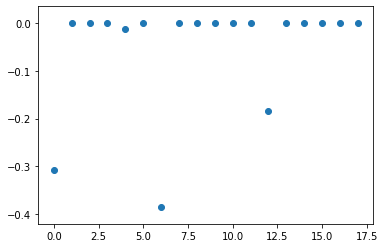

In [180]:
# plt.plot(lin_reg_l1.coef_)
plt.scatter( np.arange(len(lin_reg_l1.coef_)) , lin_reg_l1.coef_)


plt.show()

In [181]:
su_drsc.columns[2:][lin_reg_l1.coef_ < 0]

Index(['Chriz', 'CP190', 'H3K4me1', 'H3K27me1'], dtype='object')

In [182]:
lin_reg_l1.coef_

array([-0.30810401,  0.        ,  0.        , -0.        , -0.01306781,
       -0.        , -0.38528056, -0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.18354512,  0.        , -0.        ,
       -0.        , -0.        , -0.        ])

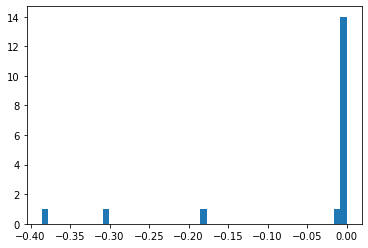

In [183]:
plt.hist(lin_reg_l1.coef_, bins=50)
plt.show()

In [184]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 
# Create linear regression object
lin_reg_l1 = linear_model.Lasso(alpha=0.8)

# Train the model using the training sets
lin_reg_l1.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = lin_reg_l1.predict(X_test)

Коэффициенты

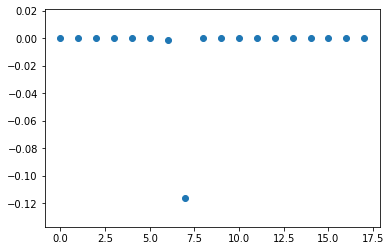

In [185]:
# plt.plot(lin_reg_l1.coef_)
plt.scatter( np.arange(len(lin_reg_l1.coef_)) , lin_reg_l1.coef_)


plt.show()

In [186]:
su_drsc.columns[2:][lin_reg_l1.coef_ < 0]

Index(['H3K4me1', 'H3K4me2'], dtype='object')

In [187]:
lin_reg_l1.coef_

array([-0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.00126763, -0.11607179, -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        ])

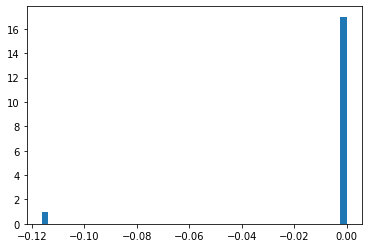

In [188]:
plt.hist(lin_reg_l1.coef_, bins=50)
plt.show()

# Gradient Boosting Regressor

In [189]:
%%time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import ensemble

params = {'n_estimators': 250, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}


X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)


kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
kf.get_n_splits(X)

MSE_train = []
MSE_test = []
MAE_train = []
MAE_test = []
r2_test = []

coefs = []
coefs_argsort = []

weighted_mse_test_all = []
weighted_mse_train_all = []

for train_index, test_index in kf.split(X):

    print('train_index=', train_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gr_boost_300 = ensemble.GradientBoostingRegressor(**params)

    # Train the model using the training sets
    gr_boost_300.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = gr_boost_300.predict(X_test)

    # Make predictions using the testing set
    y_pred_train = gr_boost_300.predict(X_train)

    MSE_train.append(mean_squared_error(y_train, y_pred_train))
    MSE_test.append(mean_squared_error(y_test, y_pred))

    MAE_train.append(mae_cout(y_true = y_train, y_pred = y_pred_train))
    MAE_test.append(mae_cout(y_true = y_test, y_pred = y_pred))

    r2_test.append(r2_score(y_test, y_pred))

    coefs.append(model.coef_)
    coefs_argsort.append(np.argsort(-np.abs(model.coef_)))
    
    print("wMean squared error on Train: %.2f"
          % weighted_mse_cout(y_train, y_pred_train))

    # The mean squared error
    print("wMean squared error on Test: %.2f"
          %  weighted_mse_cout(y_test, y_pred))



    weighted_mse_test_all.append(weighted_mse_cout(y_test, y_pred))
    weighted_mse_train_all.append(weighted_mse_cout(y_train, y_pred_train))
    

weighted_mse_test_all = np.array(weighted_mse_test_all)
weighted_mse_train_all =  np.array(weighted_mse_train_all)

coefs = np.array(coefs)
coefs_argsort = np.array(coefs_argsort)

# The mean squared error
print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
      MSE_train,  "\n")

# The mean squared error
print("Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
      MSE_test, "\n")

# The mean squared error
print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
       np.sqrt(MSE_test), "\n")

# Explained variance score: 1 is perfect prediction
print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , r2_test, "\n")

model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
            weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
            rmse_test, rmse_train, rmse_test_const, \
            MAE_test,    MAE_train,  mae_test_const
print_metrices(model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const)

coefs_pd = pd.DataFrame(coefs, columns=su_drsc.columns[2:])
coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]]

# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")


train_index= [   0    1    2 ... 5947 5948 5949]
wMean squared error on Train: 0.95
wMean squared error on Test: 1.10
train_index= [   0    1    2 ... 5947 5948 5949]
wMean squared error on Train: 0.95
wMean squared error on Test: 1.08
train_index= [   0    2    3 ... 5947 5948 5949]
wMean squared error on Train: 0.95
wMean squared error on Test: 1.08
train_index= [   0    1    2 ... 5947 5948 5949]
wMean squared error on Train: 0.96
wMean squared error on Test: 1.03
train_index= [   0    1    2 ... 5946 5948 5949]
wMean squared error on Train: 0.94
wMean squared error on Test: 1.11
train_index= [   1    4    5 ... 5945 5947 5949]
wMean squared error on Train: 0.94
wMean squared error on Test: 1.18
train_index= [   0    1    2 ... 5947 5948 5949]
wMean squared error on Train: 0.96
wMean squared error on Test: 1.00
train_index= [   0    1    2 ... 5946 5947 5948]
wMean squared error on Train: 0.95
wMean squared error on Test: 1.14
train_index= [   0    1    2 ... 5947 5948 5949]
wMean s

In [190]:
# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")


Weighted Mean squared error CONST std on Train : 0.95 
 wmst CONST std train 0.01 

Weighted Mean squared error  CONST std on Test: 1.07 
 wmst CONST std test 0.06 



# GB 250 TRAIN 0.9+0.01
# GB 250 TEST   1.07+0.06

In [191]:
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}


X, y = data_scaled_clean.values, target.values  # np.log(0.01 + target)  #  data.drop(["bin_id"], axis=1), target.drop(["bin_id"], axis=1)


kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
kf.get_n_splits(X)

MSE_train = []
MSE_test = []
MAE_train = []
MAE_test = []
r2_test = []

coefs = []
coefs_argsort = []

weighted_mse_test_all = []
weighted_mse_train_all = []

for train_index, test_index in kf.split(X):

    print('train_index=', train_index)

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gr_boost_300 = ensemble.GradientBoostingRegressor(**params)

    # Train the model using the training sets
    gr_boost_300.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = gr_boost_300.predict(X_test)

    # Make predictions using the testing set
    y_pred_train = gr_boost_300.predict(X_train)

    
#     y_pred_train = const_pred_train
#     y_pred = const_pred_test

    MSE_train.append(mean_squared_error(y_train, y_pred_train))
    MSE_test.append(mean_squared_error(y_test, y_pred))

    MAE_train.append(mae_cout(y_true = y_train, y_pred = y_pred_train))
    MAE_test.append(mae_cout(y_true = y_test, y_pred = y_pred))

    r2_test.append(r2_score(y_test, y_pred))

    coefs.append(model.coef_)
    coefs_argsort.append(np.argsort(-np.abs(model.coef_)))

    print("wMean squared error on Train: %.2f"
          % weighted_mse_cout(y_train, y_pred_train))

    # The mean squared error
    print("wMean squared error on Test: %.2f"
          %  weighted_mse_cout(y_test, y_pred))



    weighted_mse_test_all.append(weighted_mse_cout(y_test, y_pred))
    weighted_mse_train_all.append(weighted_mse_cout(y_train, y_pred_train))

    
    

weighted_mse_test_all = np.array(weighted_mse_test_all)
weighted_mse_train_all =  np.array(weighted_mse_train_all)

coefs = np.array(coefs)
coefs_argsort = np.array(coefs_argsort)

# The mean squared error
print("Weighted Mean squared error on Train: %.2f" % np.mean(weighted_mse_train_all), "\n",
      MSE_train,  "\n")

# The mean squared error
print("Mean squared error on Test: %.2f" % np.mean(weighted_mse_test_all), "\n",
      MSE_test, "\n")

# The mean squared error
print("Root of Mean squared error: %.2f" % np.mean(np.sqrt(weighted_mse_test_all)), "\n",
       np.sqrt(MSE_test), "\n")

# Explained variance score: 1 is perfect prediction
print("Variance score on Test: %.2f" % np.std(weighted_mse_test_all), "\n" , r2_test, "\n")

model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
            weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
            rmse_test, rmse_train, rmse_test_const, \
            MAE_test,    MAE_train,  mae_test_const
print_metrices(model, MSE_train, MSE_test, r2_test, coefs, coefs_argsort, kf, \
                weighted_mse_test_all, weighted_mse_train_all, weighted_mse_test_const, \
                rmse_test, rmse_train, rmse_test_const, \
                mae_test,    mae_train,  mae_test_const)

coefs_pd = pd.DataFrame(coefs, columns=su_drsc.columns[2:])
coefs_pd[su_drsc.columns[2:][coefs_argsort[0]]]

train_index= [   0    1    2 ... 5947 5948 5949]
wMean squared error on Train: 1.04
wMean squared error on Test: 1.15
train_index= [   0    1    2 ... 5947 5948 5949]
wMean squared error on Train: 1.05
wMean squared error on Test: 1.13
train_index= [   0    2    3 ... 5947 5948 5949]
wMean squared error on Train: 1.05
wMean squared error on Test: 1.07
train_index= [   0    1    2 ... 5947 5948 5949]
wMean squared error on Train: 1.06
wMean squared error on Test: 1.02
train_index= [   0    1    2 ... 5946 5948 5949]
wMean squared error on Train: 1.04
wMean squared error on Test: 1.15
train_index= [   1    4    5 ... 5945 5947 5949]
wMean squared error on Train: 1.04
wMean squared error on Test: 1.20
train_index= [   0    1    2 ... 5947 5948 5949]
wMean squared error on Train: 1.06
wMean squared error on Test: 1.06
train_index= [   0    1    2 ... 5946 5947 5948]
wMean squared error on Train: 1.04
wMean squared error on Test: 1.17
train_index= [   0    1    2 ... 5947 5948 5949]
wMean s

H3K4me1  H3K27me3     Chriz  H3K36me3  H3K36me1     CP190  H3K27me1  \
0 -0.31998 -0.310965 -0.308894 -0.278461  -0.27624 -0.271187 -0.241115   
1 -0.31998 -0.310965 -0.308894 -0.278461  -0.27624 -0.271187 -0.241115   
2 -0.31998 -0.310965 -0.308894 -0.278461  -0.27624 -0.271187 -0.241115   
3 -0.31998 -0.310965 -0.308894 -0.278461  -0.27624 -0.271187 -0.241115   
4 -0.31998 -0.310965 -0.308894 -0.278461  -0.27624 -0.271187 -0.241115   
5 -0.31998 -0.310965 -0.308894 -0.278461  -0.27624 -0.271187 -0.241115   
6 -0.31998 -0.310965 -0.308894 -0.278461  -0.27624 -0.271187 -0.241115   
7 -0.31998 -0.310965 -0.308894 -0.278461  -0.27624 -0.271187 -0.241115   
8 -0.31998 -0.310965 -0.308894 -0.278461  -0.27624 -0.271187 -0.241115   
9 -0.31998 -0.310965 -0.308894 -0.278461  -0.27624 -0.271187 -0.241115   

    H3K4me2   H3K4me3  RNA-polymerase-II    Su(Hw)   H3K27ac   H4K16ac  \
0  0.132554 -0.108803          -0.103969  0.085557  0.068738  0.059857   
1  0.132554 -0.108803          -0.103969  0.085557  0.068738  0.059857   
2  0.132554 -0.108803          -0.103969  0.085557  0.068738  0.059857   
3  0.132554 -0.108803          -0.103969  0.085557  0.068738  0.059857   
4  0.132554 -0.108803          -0.103969  0.085557  0.068738  0.059857   
5  0.132554 -0.108803          -0.103969  0.085557  0.068738  0.059857   
6  0.132554 -0.108803          -0.103969  0.085557  0.068738  0.059857   
7  0.132554 -0.108803          -0.103969  0.085557  0.068738  0.059857   
8  0.132554 -0.108803          -0.103969  0.085557  0.068738  0.059857   
9  0.132554 -0.108803          -0.103969  0.085557  0.068738  0.059857   

       CTCF   H3K9me3       GAF   H3K9me2   BEAF-32  
0  0.046798 -0.036759 -0.022436  0.015714 -0.010772  
1  0.046798 -0.036759 -0.022436  0.015714 -0.010772  
2  0.046798 -0.036759 -0.022436  0.015714 -0.010772  
3  0.046798 -0.036759 -0.022436  0.015714 -0.010772  
4  0.046798 -0.036759 -0.022436  0.015714 -0.010772  
5  0.046798 -0.036759 -0.022436  0.015714 -0.010772  
6  0.046798 -0.036759 -0.022436  0.015714 -0.010772  
7  0.046798 -0.036759 -0.022436  0.015714 -0.010772  
8  0.046798 -0.036759 -0.022436  0.015714 -0.010772  
9  0.046798 -0.036759 -0.022436  0.015714 -0.010772

In [192]:
# The mean squared error
print("Weighted Mean squared error CONST std on Train : %.2f" % np.mean(weighted_mse_train_all), 
      "\n wmst CONST std train %.2f" % np.std(weighted_mse_train_all), "\n")

# The mean squared error
print("Weighted Mean squared error  CONST std on Test: %.2f" % np.mean(weighted_mse_test_all),
      "\n wmst CONST std test %.2f" % np.std(weighted_mse_test_all), "\n")

Weighted Mean squared error CONST std on Train : 1.05 
 wmst CONST std train 0.01 

Weighted Mean squared error  CONST std on Test: 1.10 
 wmst CONST std test 0.06 



# Results

In [197]:
results_pd

model_name wMSE_test_mean wMSE_test_std wMSE_train_mean  \
1     LR+L1_no_outliers       0.923253     0.0347824        0.916697   
2                    LR        1.13867     0.0750751         1.13198   
3                 LR+L1        1.61552      0.092714          1.6149   
4  LR+L1_alf=0.2_spt=10        1.12173      0.070063          1.1202   
5        LR+L2_alf=3000        1.11571     0.0738139         1.11323   
6        LR+L2_alf=2000        1.11562     0.0734816         1.11272   
7              LR+L1+L2        1.26697     0.0809144          1.2655   
8   LR+L2_alf=.2_rat=.5        1.11488     0.0701701         1.11253   
9                    LR        1.13867     0.0750751         1.13198   

  wMSE_train_std comments                  params  MSE_test_mean  \
1     0.00763124        -  test_params = testtest       1.392874   
2     0.00978238        -  test_params = testtest       2.634009   
3      0.0115859        -  test_params = testtest       3.708353   
4     0.00824059        -  test_params = testtest       2.768352   
5     0.00918478        -  test_params = testtest       2.688229   
6     0.00924482        -  test_params = testtest       2.670077   
7     0.00816356        -  test_params = testtest       3.119421   
8     0.00880197        -  test_params = testtest       2.715704   
9     0.00978238        -  test_params = testtest       2.634009   

   MSE_test_std  MSE_train_mean  MSE_train_std  \
1      0.042988        1.382760       0.010296   
2      0.159500        2.619701       0.017773   
3      0.221185        3.707263       0.024586   
4      0.170443        2.765067       0.016531   
5      0.163748        2.682297       0.017655   
6      0.161791        2.663243       0.017661   
7      0.200324        3.116866       0.018646   
8      0.162221        2.710776       0.016951   
9      0.159500        2.619701       0.017773   

                                             r2_test n_splits  \
1  [0.3173100836941761, 0.33173764707849474, 0.30...        5   
2  [0.30233272815667, 0.3418028647562872, 0.25460...       10   
3  [-0.0005277141720481104, -2.210887072906509e-0...       10   
4  [0.24862101980287654, 0.2826266315081707, 0.24...       10   
5  [0.27684219529817444, 0.3168635855108799, 0.26...       10   
6  [0.28341377745575747, 0.32388081130388513, 0.2...       10   
7  [0.1515102542917558, 0.17286615599028132, 0.15...       10   
8  [0.2685022458518105, 0.30198282772135177, 0.25...       10   
9  [0.30233272815667, 0.3418028647562872, 0.25460...       10   

                                               model  
1  LinearRegression(copy_X=True, fit_intercept=Tr...  
2  LinearRegression(copy_X=True, fit_intercept=Tr...  
3  Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...  
4  Lasso(alpha=0.2, copy_X=True, fit_intercept=Tr...  
5  Ridge(alpha=3000, copy_X=True, fit_intercept=T...  
6  Ridge(alpha=2000, copy_X=True, fit_intercept=T...  
7  ElasticNet(alpha=1.0, copy_X=True, fit_interce...  
8  ElasticNet(alpha=0.2, copy_X=True, fit_interce...  
9  LinearRegression(copy_X=True, fit_intercept=Tr...